In [1]:
import os
import pandas as pd
from tqdm import tqdm

def scan_images(folder, word_label):
    images_data = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                images_data.append({
                    'Word': word_label,
                    'Frames path': os.path.join(root, file)
                })
    return images_data

def create_csv(root_folder, output_root_folder, csv_path):
    all_data = []

    # Scan original images
    for word_folder in tqdm(os.listdir(root_folder), desc="Scanning original images"):
        full_path = os.path.join(root_folder, word_folder)
        if os.path.isdir(full_path):
            word_label = os.path.basename(word_folder)
            word_data = scan_images(full_path, word_label)
            all_data.extend(word_data)

    # Scan augmented images
    for word_folder in tqdm(os.listdir(output_root_folder), desc="Scanning augmented images"):
        full_path = os.path.join(output_root_folder, word_folder)
        if os.path.isdir(full_path):
            word_label = os.path.basename(word_folder)
            word_data = scan_images(full_path, word_label)
            all_data.extend(word_data)

    # Create DataFrame and save to CSV
    df = pd.DataFrame(all_data)
    df.to_csv(csv_path, index=False)
    print(f"CSV file created at: {csv_path}")

# Paths
root_folder = 'D:/kcmpdxky7p-1/ISL_CSLRT_Corpus/ISL_CSLRT_Corpus/Frames_Word_Level'
output_root_folder = 'E:/augmentation'
csv_path = 'E:/word_csv.csv'

# Run the process to recreate CSV
create_csv(root_folder, output_root_folder, csv_path)


Scanning augmented images: 100%|███████████████████████████████████████████████████| 131/131 [00:00<00:00, 3857.39it/s]

CSV file created at: E:/word_csv.csv


In [1]:
import pandas as pd
df=pd.read_csv("E:/word_csv.csv")

In [2]:
df

Word                                        Frames path
0     A LOT  D:/kcmpdxky7p-1/ISL_CSLRT_Corpus/ISL_CSLRT_Cor...
1     A LOT  D:/kcmpdxky7p-1/ISL_CSLRT_Corpus/ISL_CSLRT_Cor...
2     A LOT  D:/kcmpdxky7p-1/ISL_CSLRT_Corpus/ISL_CSLRT_Cor...
3     A LOT  D:/kcmpdxky7p-1/ISL_CSLRT_Corpus/ISL_CSLRT_Cor...
4     ABUSE  D:/kcmpdxky7p-1/ISL_CSLRT_Corpus/ISL_CSLRT_Cor...
...     ...                                                ...
2067    YOU           E:/augmentation\YOU\YOUR (1)_aug_105.jpg
2068    YOU           E:/augmentation\YOU\YOUR (2)_aug_106.jpg
2069    YOU           E:/augmentation\YOU\YOUR (3)_aug_107.jpg
2070    YOU             E:/augmentation\YOU\YOUR-1_aug_108.jpg
2071    YOU               E:/augmentation\YOU\YOUR_aug_109.jpg

[2072 rows x 2 columns]

In [3]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import joblib

# Define the paths and other constants
model_dir = "models_ensemble"
n_models = 5  # Ensure this matches the number of models you have trained
scaler_path = 'scaler.pkl'  # Path to the saved scaler
pca_path = 'pca.pkl'  # Path to the saved PCA model

# Load the scaler and PCA model
scaler = joblib.load(scaler_path)
pca = joblib.load(pca_path)


df = df.dropna()

# Define unique sentences
unique_sentences = df['Word'].unique()
num_classes = len(unique_sentences)

# Preprocess images
def preprocess_images(df, target_size=(224, 224)):
    import cv2
    processed_images = []
    for path in df['Frames path']:
        try:
            image = cv2.imread(path)
            if image is None:
                print(f"Warning: Unable to read image at path {path}")
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            image = image.astype('float32') / 255.0
            processed_images.append(image)
        except Exception as e:
            print(f"Error processing image at path {path}: {e}")
    return np.array(processed_images)

processed_images_array = preprocess_images(df)

# Feature extraction
import cv2
import mediapipe as mp
from tensorflow.keras.applications import MobileNetV2
from tqdm import tqdm

cnn_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def extract_mediapipe_keypoints(image):
    image_uint8 = (image * 255).astype('uint8')
    results = hands.process(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        keypoints = []
        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                keypoints.append((lm.x, lm.y, lm.z))
        keypoints = np.array(keypoints).flatten()
        if len(keypoints) < 63:
            keypoints = np.pad(keypoints, (0, 63 - len(keypoints)), mode='constant')
        return keypoints
    else:
        return np.zeros(63)

def extract_cnn_features(image_array):
    image_array = np.expand_dims(image_array, axis=0)
    features = cnn_model.predict(image_array)
    return features.flatten()

def combine_features(image_array):
    keypoints = extract_mediapipe_keypoints(image_array)
    cnn_features = extract_cnn_features(image_array)
    combined_features = np.concatenate((keypoints, cnn_features))
    return combined_features

combined_features_list = []
for idx, image_array in enumerate(tqdm(processed_images_array, desc="Extracting features")):
    try:
        combined_features = combine_features(image_array)
        combined_features_list.append(combined_features)
    except Exception as e:
        print(f"Error processing image at index {idx}: {e}")

combined_features_array = np.array(combined_features_list)

# Apply scaling and PCA transformation
combined_features_array_2d = combined_features_array.reshape(combined_features_array.shape[0], -1)
combined_features_array_scaled = scaler.transform(combined_features_array_2d)
reduced_features_array = pca.transform(combined_features_array_scaled)

# Reshape for LSTM input
reduced_features_array = reduced_features_array.reshape((reduced_features_array.shape[0], 1, reduced_features_array.shape[1]))

# Encode labels
df['label'] = df['Word'].apply(lambda x: np.where(unique_sentences == x)[0][0])
labels = pd.get_dummies(df['label']).values

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(reduced_features_array, labels, test_size=0.2, random_state=42)

# Load models
models = []
for i in range(n_models):
    model = load_model(os.path.join(model_dir, f'model2_{i}.h5'))
    models.append(model)

# Function to make predictions using the ensemble of models
def predict_with_ensemble(models, X):
    predictions = np.zeros((X.shape[0], num_classes))
    for model in models:
        pred = model.predict(X)
        predictions += pred
    predictions /= len(models)  # Average the predictions
    return predictions

# Make predictions on the validation set
ensemble_predictions = predict_with_ensemble(models, X_val)

# Evaluate the ensemble performance
ensemble_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(ensemble_predictions, axis=1))
print(f'Ensemble Validation Accuracy: {ensemble_accuracy}')

# Calculate precision, recall, and F1 score for each word (label)
precision, recall, f1_score, support = precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(ensemble_predictions, axis=1), average=None, zero_division=0)

# Get unique labels from the validation set
unique_labels = np.unique(np.argmax(y_val, axis=1))

# Create a DataFrame to display the metrics in table format
metrics_df = pd.DataFrame({
    'Word': [unique_sentences[label] for label in unique_labels],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

# Display the table
from IPython.display import display
display(metrics_df)

# Save the metrics DataFrame to a CSV file
metrics_df.to_csv('ensemble_model_metrics.csv', index=False)

# Calculate overall precision, recall, and F1 score
overall_precision, overall_recall, overall_f1_score, _ = precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(ensemble_predictions, axis=1), average='macro', zero_division=0)
print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1 Score: {overall_f1_score}')


Extracting features:   0%|                                                                    | 0/2072 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Extracting features:   0%|                                                            | 1/2072 [00:01<48:42,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


Extracting features:   0%|                                                            | 2/2072 [00:01<22:50,  1.51it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   0%|                                                            | 3/2072 [00:01<14:29,  2.38it/s]C:\Users\User\anaconda3\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 0s 51ms/step


Extracting features:   0%|                                                            | 4/2072 [00:01<11:12,  3.08it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:   0%|▏                                                           | 5/2072 [00:02<08:55,  3.86it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   0%|▏                                                           | 6/2072 [00:02<07:46,  4.43it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:   0%|▏                                                           | 7/2072 [00:02<06:47,  5.07it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   0%|▏                                                           | 8/2072 [00:02<06:20,  5.42it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   0%|▎                                                           | 9/2072 [00:02<05:52,  5.85it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   0%|▎                                                          | 10/2072 [00:02<05:41,  6.03it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   1%|▎                                                          | 11/2072 [00:02<05:28,  6.27it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   1%|▎                                                          | 12/2072 [00:03<05:15,  6.54it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   1%|▎                                                          | 13/2072 [00:03<05:06,  6.71it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   1%|▍                                                          | 14/2072 [00:03<05:14,  6.54it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   1%|▍                                                          | 15/2072 [00:03<05:04,  6.76it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   1%|▍                                                          | 16/2072 [00:03<05:11,  6.59it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   1%|▍                                                          | 17/2072 [00:03<05:03,  6.77it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   1%|▌                                                          | 18/2072 [00:03<05:15,  6.51it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   1%|▌                                                          | 19/2072 [00:04<05:18,  6.44it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   1%|▌                                                          | 20/2072 [00:04<05:08,  6.66it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   1%|▌                                                          | 21/2072 [00:04<05:01,  6.81it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:   1%|▋                                                          | 22/2072 [00:04<04:57,  6.90it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   1%|▋                                                          | 23/2072 [00:04<05:04,  6.74it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   1%|▋                                                          | 24/2072 [00:04<05:12,  6.56it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   1%|▋                                                          | 25/2072 [00:04<05:12,  6.55it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:   1%|▋                                                          | 26/2072 [00:05<05:02,  6.75it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   1%|▊                                                          | 27/2072 [00:05<04:55,  6.92it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:   1%|▊                                                          | 28/2072 [00:05<04:48,  7.07it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   1%|▊                                                          | 29/2072 [00:05<05:03,  6.74it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   1%|▊                                                          | 30/2072 [00:05<06:11,  5.49it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   1%|▉                                                          | 31/2072 [00:05<06:01,  5.64it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   2%|▉                                                          | 32/2072 [00:06<05:51,  5.80it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   2%|▉                                                          | 33/2072 [00:06<05:49,  5.84it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   2%|▉                                                          | 34/2072 [00:06<05:55,  5.74it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   2%|▉                                                          | 35/2072 [00:06<05:46,  5.87it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   2%|█                                                          | 36/2072 [00:06<06:08,  5.52it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   2%|█                                                          | 37/2072 [00:07<05:46,  5.87it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:   2%|█                                                          | 38/2072 [00:07<05:38,  6.01it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:   2%|█                                                          | 39/2072 [00:07<05:20,  6.34it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   2%|█▏                                                         | 40/2072 [00:07<05:16,  6.42it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   2%|█▏                                                         | 41/2072 [00:07<05:12,  6.49it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   2%|█▏                                                         | 42/2072 [00:07<05:13,  6.48it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   2%|█▏                                                         | 43/2072 [00:07<05:01,  6.74it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   2%|█▎                                                         | 44/2072 [00:08<05:04,  6.66it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▎                                                         | 45/2072 [00:08<04:59,  6.76it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   2%|█▎                                                         | 46/2072 [00:08<04:48,  7.01it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   2%|█▎                                                         | 47/2072 [00:08<04:54,  6.89it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   2%|█▎                                                         | 48/2072 [00:08<04:47,  7.05it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   2%|█▍                                                         | 49/2072 [00:08<04:50,  6.97it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   2%|█▍                                                         | 50/2072 [00:08<05:12,  6.48it/s]

1/1 [==============================] - 0s 187ms/step


Extracting features:   2%|█▍                                                         | 51/2072 [00:09<06:48,  4.95it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   3%|█▍                                                         | 52/2072 [00:09<06:52,  4.90it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   3%|█▌                                                         | 53/2072 [00:09<06:39,  5.05it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   3%|█▌                                                         | 54/2072 [00:09<06:25,  5.23it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   3%|█▌                                                         | 55/2072 [00:10<06:53,  4.88it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:   3%|█▌                                                         | 56/2072 [00:10<06:40,  5.04it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   3%|█▌                                                         | 57/2072 [00:10<06:29,  5.17it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   3%|█▋                                                         | 58/2072 [00:10<06:10,  5.44it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   3%|█▋                                                         | 59/2072 [00:10<05:59,  5.60it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   3%|█▋                                                         | 60/2072 [00:10<06:06,  5.49it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   3%|█▋                                                         | 61/2072 [00:11<05:49,  5.76it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   3%|█▊                                                         | 62/2072 [00:11<05:26,  6.16it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   3%|█▊                                                         | 63/2072 [00:11<05:21,  6.25it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:   3%|█▊                                                         | 64/2072 [00:11<05:06,  6.55it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   3%|█▊                                                         | 65/2072 [00:11<05:08,  6.51it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   3%|█▉                                                         | 66/2072 [00:11<04:57,  6.75it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   3%|█▉                                                         | 67/2072 [00:11<04:53,  6.84it/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:   3%|█▉                                                         | 68/2072 [00:12<04:45,  7.02it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|█▉                                                         | 69/2072 [00:12<04:49,  6.91it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   3%|█▉                                                         | 70/2072 [00:12<04:51,  6.86it/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:   3%|██                                                         | 71/2072 [00:12<04:44,  7.02it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   3%|██                                                         | 72/2072 [00:12<04:56,  6.73it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██                                                         | 73/2072 [00:12<05:14,  6.36it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   4%|██                                                         | 74/2072 [00:13<05:15,  6.33it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██▏                                                        | 75/2072 [00:13<05:11,  6.41it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██▏                                                        | 76/2072 [00:13<04:59,  6.67it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██▏                                                        | 77/2072 [00:13<04:49,  6.90it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   4%|██▏                                                        | 78/2072 [00:13<04:52,  6.82it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██▏                                                        | 79/2072 [00:13<04:42,  7.06it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██▎                                                        | 80/2072 [00:13<04:43,  7.03it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██▎                                                        | 81/2072 [00:14<04:51,  6.84it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   4%|██▎                                                        | 82/2072 [00:14<04:42,  7.05it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██▎                                                        | 83/2072 [00:14<04:47,  6.91it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██▍                                                        | 84/2072 [00:14<04:53,  6.78it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██▍                                                        | 85/2072 [00:14<04:43,  7.01it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   4%|██▍                                                        | 86/2072 [00:14<04:34,  7.22it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   4%|██▍                                                        | 87/2072 [00:14<04:54,  6.74it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██▌                                                        | 88/2072 [00:15<04:46,  6.92it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██▌                                                        | 89/2072 [00:15<04:38,  7.13it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:   4%|██▌                                                        | 90/2072 [00:15<05:11,  6.37it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   4%|██▌                                                        | 91/2072 [00:15<05:05,  6.49it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:   4%|██▌                                                        | 92/2072 [00:15<04:55,  6.69it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   4%|██▋                                                        | 93/2072 [00:15<05:11,  6.34it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   5%|██▋                                                        | 94/2072 [00:15<05:14,  6.30it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   5%|██▋                                                        | 95/2072 [00:16<05:25,  6.07it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   5%|██▋                                                        | 96/2072 [00:16<05:31,  5.95it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   5%|██▊                                                        | 97/2072 [00:16<05:30,  5.98it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   5%|██▊                                                        | 98/2072 [00:16<05:09,  6.37it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   5%|██▊                                                        | 99/2072 [00:16<05:22,  6.13it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   5%|██▊                                                       | 100/2072 [00:16<05:32,  5.93it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   5%|██▊                                                       | 101/2072 [00:17<05:41,  5.77it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   5%|██▊                                                       | 102/2072 [00:17<05:15,  6.25it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   5%|██▉                                                       | 103/2072 [00:17<04:56,  6.63it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   5%|██▉                                                       | 104/2072 [00:17<04:58,  6.60it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   5%|██▉                                                       | 105/2072 [00:17<04:57,  6.60it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   5%|██▉                                                       | 106/2072 [00:17<04:48,  6.80it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   5%|██▉                                                       | 107/2072 [00:18<04:54,  6.68it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:   5%|███                                                       | 108/2072 [00:18<04:46,  6.86it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   5%|███                                                       | 109/2072 [00:18<04:53,  6.68it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   5%|███                                                       | 110/2072 [00:18<04:42,  6.95it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   5%|███                                                       | 111/2072 [00:18<04:38,  7.05it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   5%|███▏                                                      | 112/2072 [00:18<04:44,  6.88it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   5%|███▏                                                      | 113/2072 [00:18<04:38,  7.03it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:   6%|███▏                                                      | 114/2072 [00:19<04:31,  7.21it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:   6%|███▏                                                      | 115/2072 [00:19<04:26,  7.36it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   6%|███▏                                                      | 116/2072 [00:19<04:21,  7.49it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   6%|███▎                                                      | 117/2072 [00:19<04:19,  7.54it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:   6%|███▎                                                      | 118/2072 [00:19<04:20,  7.51it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   6%|███▎                                                      | 119/2072 [00:19<04:18,  7.57it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:   6%|███▎                                                      | 120/2072 [00:19<04:26,  7.34it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   6%|███▍                                                      | 121/2072 [00:19<04:43,  6.89it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   6%|███▍                                                      | 122/2072 [00:20<04:51,  6.69it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   6%|███▍                                                      | 123/2072 [00:20<04:50,  6.70it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   6%|███▍                                                      | 124/2072 [00:20<04:51,  6.68it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   6%|███▍                                                      | 125/2072 [00:20<04:56,  6.56it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:   6%|███▌                                                      | 126/2072 [00:20<04:46,  6.79it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:   6%|███▌                                                      | 127/2072 [00:20<04:40,  6.94it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   6%|███▌                                                      | 128/2072 [00:20<04:32,  7.13it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   6%|███▌                                                      | 129/2072 [00:21<04:26,  7.28it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   6%|███▋                                                      | 130/2072 [00:21<04:22,  7.39it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:   6%|███▋                                                      | 131/2072 [00:21<04:19,  7.47it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   6%|███▋                                                      | 132/2072 [00:21<04:29,  7.19it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   6%|███▋                                                      | 133/2072 [00:21<04:27,  7.26it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   6%|███▊                                                      | 134/2072 [00:21<04:37,  6.98it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   7%|███▊                                                      | 135/2072 [00:21<04:47,  6.74it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   7%|███▊                                                      | 136/2072 [00:22<04:35,  7.02it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   7%|███▊                                                      | 137/2072 [00:22<04:40,  6.90it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   7%|███▊                                                      | 138/2072 [00:22<04:30,  7.15it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:   7%|███▉                                                      | 139/2072 [00:22<04:26,  7.25it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   7%|███▉                                                      | 140/2072 [00:22<04:23,  7.32it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:   7%|███▉                                                      | 141/2072 [00:22<04:23,  7.32it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   7%|███▉                                                      | 142/2072 [00:22<04:36,  6.98it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   7%|████                                                      | 143/2072 [00:23<04:42,  6.82it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   7%|████                                                      | 144/2072 [00:23<04:35,  7.00it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   7%|████                                                      | 145/2072 [00:23<04:40,  6.87it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   7%|████                                                      | 146/2072 [00:23<04:41,  6.83it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   7%|████                                                      | 147/2072 [00:23<04:31,  7.08it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:   7%|████▏                                                     | 148/2072 [00:23<04:28,  7.17it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   7%|████▏                                                     | 149/2072 [00:23<04:42,  6.81it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   7%|████▏                                                     | 150/2072 [00:24<04:46,  6.72it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   7%|████▏                                                     | 151/2072 [00:24<04:38,  6.90it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   7%|████▎                                                     | 152/2072 [00:24<04:29,  7.12it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   7%|████▎                                                     | 153/2072 [00:24<04:24,  7.27it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:   7%|████▎                                                     | 154/2072 [00:24<04:24,  7.25it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   7%|████▎                                                     | 155/2072 [00:24<04:21,  7.33it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   8%|████▎                                                     | 156/2072 [00:24<04:20,  7.37it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   8%|████▍                                                     | 157/2072 [00:25<04:33,  7.00it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   8%|████▍                                                     | 158/2072 [00:25<04:39,  6.85it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:   8%|████▍                                                     | 159/2072 [00:25<04:36,  6.92it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:   8%|████▍                                                     | 160/2072 [00:25<04:30,  7.07it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:   8%|████▌                                                     | 161/2072 [00:25<04:27,  7.15it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   8%|████▌                                                     | 162/2072 [00:25<04:44,  6.72it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   8%|████▌                                                     | 163/2072 [00:25<04:36,  6.91it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   8%|████▌                                                     | 164/2072 [00:26<04:40,  6.81it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   8%|████▌                                                     | 165/2072 [00:26<04:33,  6.98it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   8%|████▋                                                     | 166/2072 [00:26<04:25,  7.19it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   8%|████▋                                                     | 167/2072 [00:26<04:32,  6.99it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   8%|████▋                                                     | 168/2072 [00:26<04:35,  6.91it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   8%|████▋                                                     | 169/2072 [00:26<04:28,  7.09it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   8%|████▊                                                     | 170/2072 [00:26<04:26,  7.15it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   8%|████▊                                                     | 171/2072 [00:27<04:33,  6.94it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:   8%|████▊                                                     | 172/2072 [00:27<04:26,  7.12it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   8%|████▊                                                     | 173/2072 [00:27<04:21,  7.26it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   8%|████▊                                                     | 174/2072 [00:27<04:28,  7.07it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   8%|████▉                                                     | 175/2072 [00:27<04:22,  7.23it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   8%|████▉                                                     | 176/2072 [00:27<04:26,  7.11it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   9%|████▉                                                     | 177/2072 [00:27<04:34,  6.91it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   9%|████▉                                                     | 178/2072 [00:28<04:25,  7.12it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   9%|█████                                                     | 179/2072 [00:28<04:20,  7.25it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   9%|█████                                                     | 180/2072 [00:28<04:14,  7.42it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:   9%|█████                                                     | 181/2072 [00:28<04:17,  7.34it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   9%|█████                                                     | 182/2072 [00:28<04:27,  7.05it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   9%|█████                                                     | 183/2072 [00:28<04:21,  7.23it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   9%|█████▏                                                    | 184/2072 [00:28<04:16,  7.35it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   9%|█████▏                                                    | 185/2072 [00:29<04:14,  7.42it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:   9%|█████▏                                                    | 186/2072 [00:29<04:13,  7.44it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   9%|█████▏                                                    | 187/2072 [00:29<04:13,  7.44it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   9%|█████▎                                                    | 188/2072 [00:29<04:24,  7.12it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   9%|█████▎                                                    | 189/2072 [00:29<04:20,  7.22it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   9%|█████▎                                                    | 190/2072 [00:29<04:16,  7.34it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   9%|█████▎                                                    | 191/2072 [00:29<04:13,  7.42it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   9%|█████▎                                                    | 192/2072 [00:29<04:11,  7.46it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   9%|█████▍                                                    | 193/2072 [00:30<04:11,  7.48it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:   9%|█████▍                                                    | 194/2072 [00:30<04:09,  7.52it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:   9%|█████▍                                                    | 195/2072 [00:30<04:10,  7.49it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   9%|█████▍                                                    | 196/2072 [00:30<04:19,  7.23it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  10%|█████▌                                                    | 197/2072 [00:30<04:30,  6.93it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  10%|█████▌                                                    | 198/2072 [00:30<05:00,  6.24it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  10%|█████▌                                                    | 199/2072 [00:31<05:13,  5.97it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  10%|█████▌                                                    | 200/2072 [00:31<04:56,  6.32it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  10%|█████▋                                                    | 201/2072 [00:31<04:43,  6.60it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  10%|█████▋                                                    | 202/2072 [00:31<04:40,  6.67it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  10%|█████▋                                                    | 203/2072 [00:31<04:32,  6.87it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  10%|█████▋                                                    | 204/2072 [00:31<04:25,  7.05it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  10%|█████▋                                                    | 205/2072 [00:31<04:24,  7.06it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  10%|█████▊                                                    | 206/2072 [00:32<04:34,  6.81it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  10%|█████▊                                                    | 207/2072 [00:32<04:27,  6.98it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  10%|█████▊                                                    | 208/2072 [00:32<04:32,  6.84it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  10%|█████▊                                                    | 209/2072 [00:32<04:23,  7.07it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  10%|█████▉                                                    | 210/2072 [00:32<04:17,  7.23it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  10%|█████▉                                                    | 211/2072 [00:32<04:25,  7.00it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  10%|█████▉                                                    | 212/2072 [00:32<04:21,  7.12it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  10%|█████▉                                                    | 213/2072 [00:33<04:18,  7.19it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  10%|█████▉                                                    | 214/2072 [00:33<04:14,  7.31it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  10%|██████                                                    | 215/2072 [00:33<04:25,  6.99it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  10%|██████                                                    | 216/2072 [00:33<04:22,  7.08it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  10%|██████                                                    | 217/2072 [00:33<04:30,  6.85it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  11%|██████                                                    | 218/2072 [00:33<04:31,  6.83it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  11%|██████▏                                                   | 219/2072 [00:33<04:42,  6.55it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  11%|██████▏                                                   | 220/2072 [00:34<04:31,  6.82it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  11%|██████▏                                                   | 221/2072 [00:34<04:38,  6.65it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  11%|██████▏                                                   | 222/2072 [00:34<04:41,  6.56it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  11%|██████▏                                                   | 223/2072 [00:34<04:48,  6.40it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  11%|██████▎                                                   | 224/2072 [00:34<04:48,  6.39it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  11%|██████▎                                                   | 225/2072 [00:34<04:53,  6.30it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  11%|██████▎                                                   | 226/2072 [00:35<04:52,  6.31it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  11%|██████▎                                                   | 227/2072 [00:35<05:00,  6.15it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  11%|██████▍                                                   | 228/2072 [00:35<04:55,  6.24it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  11%|██████▍                                                   | 229/2072 [00:35<04:40,  6.56it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  11%|██████▍                                                   | 230/2072 [00:35<04:28,  6.85it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████▍                                                   | 231/2072 [00:35<04:21,  7.04it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  11%|██████▍                                                   | 232/2072 [00:35<04:16,  7.16it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  11%|██████▌                                                   | 233/2072 [00:36<04:13,  7.27it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  11%|██████▌                                                   | 234/2072 [00:36<04:15,  7.19it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  11%|██████▌                                                   | 235/2072 [00:36<04:31,  6.78it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  11%|██████▌                                                   | 236/2072 [00:36<04:25,  6.92it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  11%|██████▋                                                   | 237/2072 [00:36<04:20,  7.04it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  11%|██████▋                                                   | 238/2072 [00:36<04:16,  7.14it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  12%|██████▋                                                   | 239/2072 [00:36<04:13,  7.23it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  12%|██████▋                                                   | 240/2072 [00:37<04:23,  6.96it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  12%|██████▋                                                   | 241/2072 [00:37<04:20,  7.04it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  12%|██████▊                                                   | 242/2072 [00:37<04:15,  7.15it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  12%|██████▊                                                   | 243/2072 [00:37<04:12,  7.25it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  12%|██████▊                                                   | 244/2072 [00:37<04:11,  7.27it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  12%|██████▊                                                   | 245/2072 [00:37<04:12,  7.23it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  12%|██████▉                                                   | 246/2072 [00:37<04:10,  7.30it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  12%|██████▉                                                   | 247/2072 [00:37<04:19,  7.04it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  12%|██████▉                                                   | 248/2072 [00:38<04:17,  7.10it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  12%|██████▉                                                   | 249/2072 [00:38<04:26,  6.85it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  12%|██████▉                                                   | 250/2072 [00:38<04:18,  7.05it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  12%|███████                                                   | 251/2072 [00:38<04:35,  6.62it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  12%|███████                                                   | 252/2072 [00:38<04:26,  6.84it/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  12%|███████                                                   | 253/2072 [00:38<04:23,  6.91it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  12%|███████                                                   | 254/2072 [00:38<04:14,  7.14it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  12%|███████▏                                                  | 255/2072 [00:39<04:11,  7.21it/s]

1/1 [==============================] - 0s 39ms/step


Extracting features:  12%|███████▏                                                  | 256/2072 [00:39<04:09,  7.27it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  12%|███████▏                                                  | 257/2072 [00:39<04:08,  7.32it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  12%|███████▏                                                  | 258/2072 [00:39<04:17,  7.04it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  12%|███████▎                                                  | 259/2072 [00:39<04:11,  7.19it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  13%|███████▎                                                  | 260/2072 [00:39<04:20,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  13%|███████▎                                                  | 261/2072 [00:39<04:17,  7.02it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  13%|███████▎                                                  | 262/2072 [00:40<04:12,  7.18it/s]

1/1 [==============================] - 0s 40ms/step


Extracting features:  13%|███████▎                                                  | 263/2072 [00:40<04:09,  7.24it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  13%|███████▍                                                  | 264/2072 [00:40<04:05,  7.35it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  13%|███████▍                                                  | 265/2072 [00:40<04:06,  7.34it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  13%|███████▍                                                  | 266/2072 [00:40<04:05,  7.35it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  13%|███████▍                                                  | 267/2072 [00:40<04:03,  7.41it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  13%|███████▌                                                  | 268/2072 [00:40<04:04,  7.37it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  13%|███████▌                                                  | 269/2072 [00:41<04:17,  7.00it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  13%|███████▌                                                  | 270/2072 [00:41<04:25,  6.80it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  13%|███████▌                                                  | 271/2072 [00:41<04:47,  6.26it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  13%|███████▌                                                  | 272/2072 [00:41<04:41,  6.39it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  13%|███████▋                                                  | 273/2072 [00:41<04:41,  6.39it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  13%|███████▋                                                  | 274/2072 [00:41<04:39,  6.43it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  13%|███████▋                                                  | 275/2072 [00:42<04:30,  6.65it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  13%|███████▋                                                  | 276/2072 [00:42<04:24,  6.79it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  13%|███████▊                                                  | 277/2072 [00:42<04:19,  6.91it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  13%|███████▊                                                  | 278/2072 [00:42<04:35,  6.52it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  13%|███████▊                                                  | 279/2072 [00:42<04:37,  6.46it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  14%|███████▊                                                  | 280/2072 [00:42<04:27,  6.70it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  14%|███████▊                                                  | 281/2072 [00:42<04:32,  6.57it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  14%|███████▉                                                  | 282/2072 [00:43<04:21,  6.86it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  14%|███████▉                                                  | 283/2072 [00:43<04:28,  6.67it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  14%|███████▉                                                  | 284/2072 [00:43<04:32,  6.55it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  14%|███████▉                                                  | 285/2072 [00:43<04:25,  6.73it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  14%|████████                                                  | 286/2072 [00:43<04:29,  6.63it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  14%|████████                                                  | 287/2072 [00:43<04:27,  6.68it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  14%|████████                                                  | 288/2072 [00:43<04:20,  6.84it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  14%|████████                                                  | 289/2072 [00:44<04:29,  6.61it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  14%|████████                                                  | 290/2072 [00:44<04:34,  6.48it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  14%|████████▏                                                 | 291/2072 [00:44<04:27,  6.65it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  14%|████████▏                                                 | 292/2072 [00:44<04:22,  6.78it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  14%|████████▏                                                 | 293/2072 [00:44<04:33,  6.51it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  14%|████████▏                                                 | 294/2072 [00:44<04:35,  6.46it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  14%|████████▎                                                 | 295/2072 [00:45<04:25,  6.70it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  14%|████████▎                                                 | 296/2072 [00:45<04:30,  6.56it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  14%|████████▎                                                 | 297/2072 [00:45<04:25,  6.70it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  14%|████████▎                                                 | 298/2072 [00:45<04:19,  6.84it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  14%|████████▎                                                 | 299/2072 [00:45<04:17,  6.87it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  14%|████████▍                                                 | 300/2072 [00:45<04:25,  6.67it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  15%|████████▍                                                 | 301/2072 [00:45<04:31,  6.53it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  15%|████████▍                                                 | 302/2072 [00:46<04:23,  6.71it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  15%|████████▍                                                 | 303/2072 [00:46<04:17,  6.87it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  15%|████████▌                                                 | 304/2072 [00:46<04:11,  7.03it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  15%|████████▌                                                 | 305/2072 [00:46<04:09,  7.09it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  15%|████████▌                                                 | 306/2072 [00:46<04:11,  7.03it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  15%|████████▌                                                 | 307/2072 [00:46<04:26,  6.63it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  15%|████████▌                                                 | 308/2072 [00:46<04:32,  6.47it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  15%|████████▋                                                 | 309/2072 [00:47<04:35,  6.39it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  15%|████████▋                                                 | 310/2072 [00:47<04:40,  6.28it/s]

1/1 [==============================] - 0s 41ms/step


Extracting features:  15%|████████▋                                                 | 311/2072 [00:47<04:27,  6.58it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  15%|████████▋                                                 | 312/2072 [00:47<04:17,  6.83it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  15%|████████▊                                                 | 313/2072 [00:47<04:22,  6.71it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  15%|████████▊                                                 | 314/2072 [00:47<04:14,  6.92it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  15%|████████▊                                                 | 315/2072 [00:47<04:08,  7.06it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  15%|████████▊                                                 | 316/2072 [00:48<04:17,  6.82it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  15%|████████▊                                                 | 317/2072 [00:48<04:13,  6.91it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  15%|████████▉                                                 | 318/2072 [00:48<04:08,  7.05it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  15%|████████▉                                                 | 319/2072 [00:48<04:06,  7.11it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  15%|████████▉                                                 | 320/2072 [00:48<04:05,  7.15it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  15%|████████▉                                                 | 321/2072 [00:48<04:02,  7.22it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  16%|█████████                                                 | 322/2072 [00:48<04:11,  6.95it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  16%|█████████                                                 | 323/2072 [00:49<04:07,  7.05it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  16%|█████████                                                 | 324/2072 [00:49<04:17,  6.78it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  16%|█████████                                                 | 325/2072 [00:49<04:14,  6.87it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  16%|█████████▏                                                | 326/2072 [00:49<04:17,  6.77it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  16%|█████████▏                                                | 327/2072 [00:49<04:13,  6.90it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  16%|█████████▏                                                | 328/2072 [00:49<04:34,  6.35it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  16%|█████████▏                                                | 329/2072 [00:50<04:53,  5.93it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  16%|█████████▏                                                | 330/2072 [00:50<04:50,  6.00it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  16%|█████████▎                                                | 331/2072 [00:50<04:43,  6.13it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  16%|█████████▎                                                | 332/2072 [00:50<04:34,  6.34it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  16%|█████████▎                                                | 333/2072 [00:50<04:29,  6.44it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  16%|█████████▎                                                | 334/2072 [00:50<04:29,  6.44it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  16%|█████████▍                                                | 335/2072 [00:50<04:20,  6.67it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  16%|█████████▍                                                | 336/2072 [00:51<04:15,  6.79it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  16%|█████████▍                                                | 337/2072 [00:51<04:08,  6.99it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  16%|█████████▍                                                | 338/2072 [00:51<04:15,  6.80it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  16%|█████████▍                                                | 339/2072 [00:51<04:18,  6.71it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  16%|█████████▌                                                | 340/2072 [00:51<04:13,  6.83it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  16%|█████████▌                                                | 341/2072 [00:51<04:18,  6.69it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  17%|█████████▌                                                | 342/2072 [00:52<04:28,  6.44it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  17%|█████████▌                                                | 343/2072 [00:52<04:19,  6.67it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  17%|█████████▋                                                | 344/2072 [00:52<04:24,  6.54it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  17%|█████████▋                                                | 345/2072 [00:52<04:28,  6.44it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  17%|█████████▋                                                | 346/2072 [00:52<04:18,  6.68it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  17%|█████████▋                                                | 347/2072 [00:52<04:13,  6.82it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  17%|█████████▋                                                | 348/2072 [00:52<04:21,  6.60it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  17%|█████████▊                                                | 349/2072 [00:53<04:37,  6.20it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  17%|█████████▊                                                | 350/2072 [00:53<04:36,  6.23it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  17%|█████████▊                                                | 351/2072 [00:53<04:21,  6.57it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  17%|█████████▊                                                | 352/2072 [00:53<04:22,  6.56it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  17%|█████████▉                                                | 353/2072 [00:53<04:13,  6.78it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  17%|█████████▉                                                | 354/2072 [00:53<04:18,  6.66it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  17%|█████████▉                                                | 355/2072 [00:53<04:10,  6.85it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  17%|█████████▉                                                | 356/2072 [00:54<04:04,  7.01it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  17%|█████████▉                                                | 357/2072 [00:54<04:07,  6.92it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  17%|██████████                                                | 358/2072 [00:54<04:16,  6.69it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  17%|██████████                                                | 359/2072 [00:54<04:27,  6.40it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  17%|██████████                                                | 360/2072 [00:54<04:29,  6.35it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  17%|██████████                                                | 361/2072 [00:54<04:31,  6.31it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  17%|██████████▏                                               | 362/2072 [00:55<04:31,  6.29it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  18%|██████████▏                                               | 363/2072 [00:55<04:30,  6.32it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  18%|██████████▏                                               | 364/2072 [00:55<04:21,  6.53it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  18%|██████████▏                                               | 365/2072 [00:55<04:29,  6.33it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  18%|██████████▏                                               | 366/2072 [00:55<04:18,  6.61it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  18%|██████████▎                                               | 367/2072 [00:55<04:09,  6.82it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  18%|██████████▎                                               | 368/2072 [00:55<04:14,  6.69it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  18%|██████████▎                                               | 369/2072 [00:56<04:21,  6.51it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  18%|██████████▎                                               | 370/2072 [00:56<04:24,  6.43it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  18%|██████████▍                                               | 371/2072 [00:56<04:25,  6.41it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  18%|██████████▍                                               | 372/2072 [00:56<04:25,  6.41it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  18%|██████████▍                                               | 373/2072 [00:56<04:16,  6.63it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  18%|██████████▍                                               | 374/2072 [00:56<04:07,  6.85it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  18%|██████████▍                                               | 375/2072 [00:57<04:11,  6.74it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  18%|██████████▌                                               | 376/2072 [00:57<04:22,  6.47it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  18%|██████████▌                                               | 377/2072 [00:57<04:25,  6.39it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  18%|██████████▌                                               | 378/2072 [00:57<04:16,  6.61it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  18%|██████████▌                                               | 379/2072 [00:57<04:24,  6.39it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  18%|██████████▋                                               | 380/2072 [00:57<04:13,  6.67it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  18%|██████████▋                                               | 381/2072 [00:57<04:17,  6.56it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  18%|██████████▋                                               | 382/2072 [00:58<04:08,  6.79it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  18%|██████████▋                                               | 383/2072 [00:58<04:16,  6.59it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  19%|██████████▋                                               | 384/2072 [00:58<04:19,  6.51it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  19%|██████████▊                                               | 385/2072 [00:58<04:26,  6.33it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  19%|██████████▊                                               | 386/2072 [00:58<04:16,  6.58it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  19%|██████████▊                                               | 387/2072 [00:58<04:21,  6.44it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  19%|██████████▊                                               | 388/2072 [00:59<04:09,  6.75it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  19%|██████████▉                                               | 389/2072 [00:59<04:15,  6.58it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  19%|██████████▉                                               | 390/2072 [00:59<04:19,  6.47it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  19%|██████████▉                                               | 391/2072 [00:59<04:10,  6.72it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  19%|██████████▉                                               | 392/2072 [00:59<04:03,  6.90it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  19%|███████████                                               | 393/2072 [00:59<04:00,  6.99it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  19%|███████████                                               | 394/2072 [00:59<04:18,  6.50it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  19%|███████████                                               | 395/2072 [01:00<04:23,  6.37it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  19%|███████████                                               | 396/2072 [01:00<04:15,  6.56it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  19%|███████████                                               | 397/2072 [01:00<04:27,  6.27it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  19%|███████████▏                                              | 398/2072 [01:00<04:25,  6.31it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  19%|███████████▏                                              | 399/2072 [01:00<04:13,  6.59it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  19%|███████████▏                                              | 400/2072 [01:00<04:18,  6.47it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  19%|███████████▏                                              | 401/2072 [01:01<04:25,  6.29it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  19%|███████████▎                                              | 402/2072 [01:01<04:23,  6.34it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  19%|███████████▎                                              | 403/2072 [01:01<04:13,  6.59it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  19%|███████████▎                                              | 404/2072 [01:01<04:06,  6.75it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  20%|███████████▎                                              | 405/2072 [01:01<04:06,  6.77it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  20%|███████████▎                                              | 406/2072 [01:01<04:15,  6.51it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  20%|███████████▍                                              | 407/2072 [01:01<04:28,  6.20it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  20%|███████████▍                                              | 408/2072 [01:02<04:56,  5.61it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  20%|███████████▍                                              | 409/2072 [01:02<04:49,  5.75it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  20%|███████████▍                                              | 410/2072 [01:02<04:39,  5.95it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  20%|███████████▌                                              | 411/2072 [01:02<04:41,  5.90it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  20%|███████████▌                                              | 412/2072 [01:02<04:42,  5.88it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  20%|███████████▌                                              | 413/2072 [01:03<05:06,  5.41it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▌                                              | 414/2072 [01:03<04:53,  5.65it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  20%|███████████▌                                              | 415/2072 [01:03<04:35,  6.01it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▋                                              | 416/2072 [01:03<04:35,  6.02it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▋                                              | 417/2072 [01:03<04:33,  6.04it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  20%|███████████▋                                              | 418/2072 [01:03<04:44,  5.81it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▋                                              | 419/2072 [01:04<04:30,  6.11it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  20%|███████████▊                                              | 420/2072 [01:04<04:21,  6.32it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  20%|███████████▊                                              | 421/2072 [01:04<04:25,  6.22it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  20%|███████████▊                                              | 422/2072 [01:04<04:16,  6.43it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▊                                              | 423/2072 [01:04<04:11,  6.55it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▊                                              | 424/2072 [01:04<04:18,  6.37it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  21%|███████████▉                                              | 425/2072 [01:05<04:40,  5.88it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  21%|███████████▉                                              | 426/2072 [01:05<04:49,  5.68it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  21%|███████████▉                                              | 427/2072 [01:05<04:49,  5.68it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  21%|███████████▉                                              | 428/2072 [01:05<04:38,  5.91it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  21%|████████████                                              | 429/2072 [01:05<04:38,  5.89it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  21%|████████████                                              | 430/2072 [01:05<04:26,  6.16it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  21%|████████████                                              | 431/2072 [01:06<04:22,  6.24it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  21%|████████████                                              | 432/2072 [01:06<04:10,  6.54it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  21%|████████████                                              | 433/2072 [01:06<04:03,  6.74it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  21%|████████████▏                                             | 434/2072 [01:06<03:59,  6.85it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  21%|████████████▏                                             | 435/2072 [01:06<04:16,  6.39it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  21%|████████████▏                                             | 436/2072 [01:06<04:23,  6.20it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  21%|████████████▏                                             | 437/2072 [01:06<04:16,  6.36it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  21%|████████████▎                                             | 438/2072 [01:07<04:16,  6.38it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  21%|████████████▎                                             | 439/2072 [01:07<04:11,  6.51it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  21%|████████████▎                                             | 440/2072 [01:07<04:06,  6.63it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  21%|████████████▎                                             | 441/2072 [01:07<04:30,  6.02it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  21%|████████████▎                                             | 442/2072 [01:07<04:32,  5.98it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  21%|████████████▍                                             | 443/2072 [01:07<04:19,  6.28it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  21%|████████████▍                                             | 444/2072 [01:08<04:24,  6.16it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  21%|████████████▍                                             | 445/2072 [01:08<04:33,  5.95it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▍                                             | 446/2072 [01:08<04:38,  5.85it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  22%|████████████▌                                             | 447/2072 [01:08<05:31,  4.90it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  22%|████████████▌                                             | 448/2072 [01:08<05:24,  5.01it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  22%|████████████▌                                             | 449/2072 [01:09<05:11,  5.21it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  22%|████████████▌                                             | 450/2072 [01:09<05:38,  4.79it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  22%|████████████▌                                             | 451/2072 [01:09<05:25,  4.98it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  22%|████████████▋                                             | 452/2072 [01:09<05:14,  5.16it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  22%|████████████▋                                             | 453/2072 [01:09<05:06,  5.28it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  22%|████████████▋                                             | 454/2072 [01:09<04:42,  5.72it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  22%|████████████▋                                             | 455/2072 [01:10<04:38,  5.81it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  22%|████████████▊                                             | 456/2072 [01:10<04:41,  5.75it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  22%|████████████▊                                             | 457/2072 [01:10<04:38,  5.79it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  22%|████████████▊                                             | 458/2072 [01:10<04:25,  6.09it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  22%|████████████▊                                             | 459/2072 [01:10<04:35,  5.85it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  22%|████████████▉                                             | 460/2072 [01:11<04:38,  5.78it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  22%|████████████▉                                             | 461/2072 [01:11<04:25,  6.07it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  22%|████████████▉                                             | 462/2072 [01:11<04:46,  5.62it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  22%|████████████▉                                             | 463/2072 [01:11<04:41,  5.71it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  22%|████████████▉                                             | 464/2072 [01:11<04:37,  5.80it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  22%|█████████████                                             | 465/2072 [01:11<04:43,  5.66it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  22%|█████████████                                             | 466/2072 [01:12<04:32,  5.90it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  23%|█████████████                                             | 467/2072 [01:12<04:33,  5.87it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  23%|█████████████                                             | 468/2072 [01:12<04:21,  6.14it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  23%|█████████████▏                                            | 469/2072 [01:12<04:13,  6.31it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  23%|█████████████▏                                            | 470/2072 [01:12<04:15,  6.26it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  23%|█████████████▏                                            | 471/2072 [01:12<04:30,  5.92it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  23%|█████████████▏                                            | 472/2072 [01:13<04:33,  5.84it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  23%|█████████████▏                                            | 473/2072 [01:13<04:45,  5.60it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  23%|█████████████▎                                            | 474/2072 [01:13<04:34,  5.82it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  23%|█████████████▎                                            | 475/2072 [01:13<04:26,  5.98it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  23%|█████████████▎                                            | 476/2072 [01:13<04:24,  6.04it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  23%|█████████████▎                                            | 477/2072 [01:13<04:29,  5.91it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  23%|█████████████▍                                            | 478/2072 [01:14<04:33,  5.82it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  23%|█████████████▍                                            | 479/2072 [01:14<04:32,  5.86it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  23%|█████████████▍                                            | 480/2072 [01:14<04:21,  6.08it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  23%|█████████████▍                                            | 481/2072 [01:14<04:11,  6.32it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  23%|█████████████▍                                            | 482/2072 [01:14<04:08,  6.41it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  23%|█████████████▌                                            | 483/2072 [01:14<04:06,  6.43it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  23%|█████████████▌                                            | 484/2072 [01:15<04:20,  6.09it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  23%|█████████████▌                                            | 485/2072 [01:15<04:33,  5.81it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  23%|█████████████▌                                            | 486/2072 [01:15<04:26,  5.95it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  24%|█████████████▋                                            | 487/2072 [01:15<04:31,  5.84it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  24%|█████████████▋                                            | 488/2072 [01:15<04:48,  5.48it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  24%|█████████████▋                                            | 489/2072 [01:15<04:49,  5.47it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  24%|█████████████▋                                            | 490/2072 [01:16<04:36,  5.72it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  24%|█████████████▋                                            | 491/2072 [01:16<04:23,  5.99it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  24%|█████████████▊                                            | 492/2072 [01:16<04:20,  6.07it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  24%|█████████████▊                                            | 493/2072 [01:16<04:28,  5.89it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  24%|█████████████▊                                            | 494/2072 [01:16<04:28,  5.87it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  24%|█████████████▊                                            | 495/2072 [01:16<04:12,  6.24it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  24%|█████████████▉                                            | 496/2072 [01:17<04:15,  6.17it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  24%|█████████████▉                                            | 497/2072 [01:17<04:07,  6.37it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  24%|█████████████▉                                            | 498/2072 [01:17<04:02,  6.50it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  24%|█████████████▉                                            | 499/2072 [01:17<03:55,  6.68it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  24%|█████████████▉                                            | 500/2072 [01:17<03:51,  6.79it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  24%|██████████████                                            | 501/2072 [01:17<03:50,  6.81it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  24%|██████████████                                            | 502/2072 [01:17<04:02,  6.48it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  24%|██████████████                                            | 503/2072 [01:18<04:02,  6.48it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  24%|██████████████                                            | 504/2072 [01:18<03:54,  6.69it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  24%|██████████████▏                                           | 505/2072 [01:18<03:49,  6.82it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  24%|██████████████▏                                           | 506/2072 [01:18<03:47,  6.89it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  24%|██████████████▏                                           | 507/2072 [01:18<03:45,  6.96it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  25%|██████████████▏                                           | 508/2072 [01:18<03:54,  6.66it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  25%|██████████████▏                                           | 509/2072 [01:18<03:51,  6.75it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  25%|██████████████▎                                           | 510/2072 [01:19<03:52,  6.73it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  25%|██████████████▎                                           | 511/2072 [01:19<03:47,  6.86it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  25%|██████████████▎                                           | 512/2072 [01:19<03:58,  6.55it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  25%|██████████████▎                                           | 513/2072 [01:19<04:06,  6.33it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  25%|██████████████▍                                           | 514/2072 [01:19<03:59,  6.50it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  25%|██████████████▍                                           | 515/2072 [01:19<04:01,  6.43it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  25%|██████████████▍                                           | 516/2072 [01:20<04:07,  6.28it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  25%|██████████████▍                                           | 517/2072 [01:20<04:01,  6.43it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  25%|██████████████▌                                           | 518/2072 [01:20<04:07,  6.27it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  25%|██████████████▌                                           | 519/2072 [01:20<03:59,  6.50it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  25%|██████████████▌                                           | 520/2072 [01:20<04:05,  6.33it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  25%|██████████████▌                                           | 521/2072 [01:20<04:17,  6.03it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  25%|██████████████▌                                           | 522/2072 [01:21<04:22,  5.91it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  25%|██████████████▋                                           | 523/2072 [01:21<04:23,  5.88it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  25%|██████████████▋                                           | 524/2072 [01:21<04:19,  5.97it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  25%|██████████████▋                                           | 525/2072 [01:21<04:20,  5.94it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  25%|██████████████▋                                           | 526/2072 [01:21<04:07,  6.25it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  25%|██████████████▊                                           | 527/2072 [01:21<04:09,  6.19it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  25%|██████████████▊                                           | 528/2072 [01:22<04:14,  6.07it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  26%|██████████████▊                                           | 529/2072 [01:22<04:04,  6.32it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  26%|██████████████▊                                           | 530/2072 [01:22<03:57,  6.48it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  26%|██████████████▊                                           | 531/2072 [01:22<03:56,  6.50it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  26%|██████████████▉                                           | 532/2072 [01:22<03:55,  6.54it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  26%|██████████████▉                                           | 533/2072 [01:22<04:10,  6.14it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  26%|██████████████▉                                           | 534/2072 [01:22<03:58,  6.44it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  26%|██████████████▉                                           | 535/2072 [01:23<03:53,  6.59it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  26%|███████████████                                           | 536/2072 [01:23<03:53,  6.58it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  26%|███████████████                                           | 537/2072 [01:23<03:49,  6.67it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  26%|███████████████                                           | 538/2072 [01:23<03:46,  6.78it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  26%|███████████████                                           | 539/2072 [01:23<03:53,  6.57it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  26%|███████████████                                           | 540/2072 [01:23<03:47,  6.73it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  26%|███████████████▏                                          | 541/2072 [01:23<03:44,  6.81it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  26%|███████████████▏                                          | 542/2072 [01:24<03:42,  6.88it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  26%|███████████████▏                                          | 543/2072 [01:24<03:39,  6.95it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  26%|███████████████▏                                          | 544/2072 [01:24<03:39,  6.96it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  26%|███████████████▎                                          | 545/2072 [01:24<03:38,  6.98it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  26%|███████████████▎                                          | 546/2072 [01:24<03:47,  6.69it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  26%|███████████████▎                                          | 547/2072 [01:24<03:57,  6.42it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  26%|███████████████▎                                          | 548/2072 [01:25<04:02,  6.28it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  26%|███████████████▎                                          | 549/2072 [01:25<04:06,  6.19it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  27%|███████████████▍                                          | 550/2072 [01:25<03:54,  6.48it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  27%|███████████████▍                                          | 551/2072 [01:25<03:49,  6.64it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  27%|███████████████▍                                          | 552/2072 [01:25<03:43,  6.80it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  27%|███████████████▍                                          | 553/2072 [01:25<03:41,  6.84it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  27%|███████████████▌                                          | 554/2072 [01:25<03:40,  6.89it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  27%|███████████████▌                                          | 555/2072 [01:26<03:37,  6.97it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  27%|███████████████▌                                          | 556/2072 [01:26<03:47,  6.66it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  27%|███████████████▌                                          | 557/2072 [01:26<03:44,  6.74it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  27%|███████████████▌                                          | 558/2072 [01:26<03:39,  6.90it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  27%|███████████████▋                                          | 559/2072 [01:26<03:39,  6.90it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  27%|███████████████▋                                          | 560/2072 [01:26<03:39,  6.88it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  27%|███████████████▋                                          | 561/2072 [01:26<03:37,  6.94it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  27%|███████████████▋                                          | 562/2072 [01:27<03:51,  6.52it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  27%|███████████████▊                                          | 563/2072 [01:27<03:47,  6.64it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  27%|███████████████▊                                          | 564/2072 [01:27<03:42,  6.78it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  27%|███████████████▊                                          | 565/2072 [01:27<03:41,  6.80it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  27%|███████████████▊                                          | 566/2072 [01:27<03:36,  6.95it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  27%|███████████████▊                                          | 567/2072 [01:27<03:47,  6.62it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  27%|███████████████▉                                          | 568/2072 [01:27<03:41,  6.79it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  27%|███████████████▉                                          | 569/2072 [01:28<03:50,  6.51it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  28%|███████████████▉                                          | 570/2072 [01:28<04:07,  6.07it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  28%|███████████████▉                                          | 571/2072 [01:28<04:03,  6.17it/s]

1/1 [==============================] - 0s 42ms/step


Extracting features:  28%|████████████████                                          | 572/2072 [01:28<03:53,  6.44it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  28%|████████████████                                          | 573/2072 [01:28<04:04,  6.14it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  28%|████████████████                                          | 574/2072 [01:28<03:57,  6.30it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  28%|████████████████                                          | 575/2072 [01:29<04:05,  6.11it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  28%|████████████████                                          | 576/2072 [01:29<03:52,  6.44it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  28%|████████████████▏                                         | 577/2072 [01:29<03:47,  6.56it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  28%|████████████████▏                                         | 578/2072 [01:29<03:56,  6.32it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  28%|████████████████▏                                         | 579/2072 [01:29<03:57,  6.28it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  28%|████████████████▏                                         | 580/2072 [01:29<04:04,  6.09it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  28%|████████████████▎                                         | 581/2072 [01:30<03:56,  6.29it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  28%|████████████████▎                                         | 582/2072 [01:30<03:48,  6.51it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  28%|████████████████▎                                         | 583/2072 [01:30<03:57,  6.28it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  28%|████████████████▎                                         | 584/2072 [01:30<04:05,  6.07it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  28%|████████████████▍                                         | 585/2072 [01:30<04:09,  5.97it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  28%|████████████████▍                                         | 586/2072 [01:30<03:58,  6.23it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  28%|████████████████▍                                         | 587/2072 [01:31<03:49,  6.47it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  28%|████████████████▍                                         | 588/2072 [01:31<03:43,  6.64it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  28%|████████████████▍                                         | 589/2072 [01:31<03:52,  6.38it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  28%|████████████████▌                                         | 590/2072 [01:31<03:45,  6.57it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  29%|████████████████▌                                         | 591/2072 [01:31<03:40,  6.73it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  29%|████████████████▌                                         | 592/2072 [01:31<03:36,  6.82it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  29%|████████████████▌                                         | 593/2072 [01:31<03:36,  6.83it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  29%|████████████████▋                                         | 594/2072 [01:32<03:34,  6.89it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  29%|████████████████▋                                         | 595/2072 [01:32<03:41,  6.68it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  29%|████████████████▋                                         | 596/2072 [01:32<03:37,  6.79it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  29%|████████████████▋                                         | 597/2072 [01:32<03:36,  6.82it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  29%|████████████████▋                                         | 598/2072 [01:32<03:35,  6.85it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  29%|████████████████▊                                         | 599/2072 [01:32<03:46,  6.50it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  29%|████████████████▊                                         | 600/2072 [01:32<03:43,  6.59it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  29%|████████████████▊                                         | 601/2072 [01:33<03:55,  6.24it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  29%|████████████████▊                                         | 602/2072 [01:33<04:00,  6.11it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  29%|████████████████▉                                         | 603/2072 [01:33<03:52,  6.31it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  29%|████████████████▉                                         | 604/2072 [01:33<03:53,  6.29it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  29%|████████████████▉                                         | 605/2072 [01:33<04:02,  6.04it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  29%|████████████████▉                                         | 606/2072 [01:33<03:58,  6.15it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  29%|████████████████▉                                         | 607/2072 [01:34<03:57,  6.16it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  29%|█████████████████                                         | 608/2072 [01:34<04:02,  6.03it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  29%|█████████████████                                         | 609/2072 [01:34<03:51,  6.31it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  29%|█████████████████                                         | 610/2072 [01:34<03:53,  6.25it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  29%|█████████████████                                         | 611/2072 [01:34<04:01,  6.04it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  30%|█████████████████▏                                        | 612/2072 [01:34<04:03,  5.99it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  30%|█████████████████▏                                        | 613/2072 [01:35<03:54,  6.22it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  30%|█████████████████▏                                        | 614/2072 [01:35<04:01,  6.04it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  30%|█████████████████▏                                        | 615/2072 [01:35<03:59,  6.08it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  30%|█████████████████▏                                        | 616/2072 [01:35<03:50,  6.31it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  30%|█████████████████▎                                        | 617/2072 [01:35<03:43,  6.50it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  30%|█████████████████▎                                        | 618/2072 [01:35<03:38,  6.65it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  30%|█████████████████▎                                        | 619/2072 [01:36<03:39,  6.62it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  30%|█████████████████▎                                        | 620/2072 [01:36<03:46,  6.42it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  30%|█████████████████▍                                        | 621/2072 [01:36<03:40,  6.58it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  30%|█████████████████▍                                        | 622/2072 [01:36<03:33,  6.79it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  30%|█████████████████▍                                        | 623/2072 [01:36<03:39,  6.59it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  30%|█████████████████▍                                        | 624/2072 [01:36<03:46,  6.40it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  30%|█████████████████▍                                        | 625/2072 [01:36<03:38,  6.61it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  30%|█████████████████▌                                        | 626/2072 [01:37<03:49,  6.31it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  30%|█████████████████▌                                        | 627/2072 [01:37<03:42,  6.48it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  30%|█████████████████▌                                        | 628/2072 [01:37<03:37,  6.64it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  30%|█████████████████▌                                        | 629/2072 [01:37<03:44,  6.42it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  30%|█████████████████▋                                        | 630/2072 [01:37<03:39,  6.56it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  30%|█████████████████▋                                        | 631/2072 [01:37<03:35,  6.69it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  31%|█████████████████▋                                        | 632/2072 [01:37<03:31,  6.79it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  31%|█████████████████▋                                        | 633/2072 [01:38<03:43,  6.44it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  31%|█████████████████▋                                        | 634/2072 [01:38<03:38,  6.57it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  31%|█████████████████▊                                        | 635/2072 [01:38<03:43,  6.43it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  31%|█████████████████▊                                        | 636/2072 [01:38<03:46,  6.33it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  31%|█████████████████▊                                        | 637/2072 [01:38<03:49,  6.24it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  31%|█████████████████▊                                        | 638/2072 [01:38<03:45,  6.35it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  31%|█████████████████▉                                        | 639/2072 [01:39<03:43,  6.40it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  31%|█████████████████▉                                        | 640/2072 [01:39<03:45,  6.34it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  31%|█████████████████▉                                        | 641/2072 [01:39<03:38,  6.54it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  31%|█████████████████▉                                        | 642/2072 [01:39<03:41,  6.45it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  31%|█████████████████▉                                        | 643/2072 [01:39<03:47,  6.29it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  31%|██████████████████                                        | 644/2072 [01:39<03:50,  6.19it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  31%|██████████████████                                        | 645/2072 [01:40<03:58,  6.00it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  31%|██████████████████                                        | 646/2072 [01:40<04:05,  5.81it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  31%|██████████████████                                        | 647/2072 [01:40<04:08,  5.73it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  31%|██████████████████▏                                       | 648/2072 [01:40<04:03,  5.85it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  31%|██████████████████▏                                       | 649/2072 [01:40<03:48,  6.23it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  31%|██████████████████▏                                       | 650/2072 [01:40<03:43,  6.38it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  31%|██████████████████▏                                       | 651/2072 [01:41<03:46,  6.28it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  31%|██████████████████▎                                       | 652/2072 [01:41<03:38,  6.50it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  32%|██████████████████▎                                       | 653/2072 [01:41<03:37,  6.51it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  32%|██████████████████▎                                       | 654/2072 [01:41<03:48,  6.20it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  32%|██████████████████▎                                       | 655/2072 [01:41<03:41,  6.38it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  32%|██████████████████▎                                       | 656/2072 [01:41<03:38,  6.49it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  32%|██████████████████▍                                       | 657/2072 [01:41<03:31,  6.68it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  32%|██████████████████▍                                       | 658/2072 [01:42<03:32,  6.65it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  32%|██████████████████▍                                       | 659/2072 [01:42<03:43,  6.31it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  32%|██████████████████▍                                       | 660/2072 [01:42<03:52,  6.08it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  32%|██████████████████▌                                       | 661/2072 [01:42<03:42,  6.33it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  32%|██████████████████▌                                       | 662/2072 [01:42<03:36,  6.50it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  32%|██████████████████▌                                       | 663/2072 [01:42<03:35,  6.53it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  32%|██████████████████▌                                       | 664/2072 [01:43<03:29,  6.72it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  32%|██████████████████▌                                       | 665/2072 [01:43<03:27,  6.79it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  32%|██████████████████▋                                       | 666/2072 [01:43<03:28,  6.75it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  32%|██████████████████▋                                       | 667/2072 [01:43<03:39,  6.40it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  32%|██████████████████▋                                       | 668/2072 [01:43<03:37,  6.46it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  32%|██████████████████▋                                       | 669/2072 [01:43<03:33,  6.57it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  32%|██████████████████▊                                       | 670/2072 [01:43<03:37,  6.45it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  32%|██████████████████▊                                       | 671/2072 [01:44<03:39,  6.37it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  32%|██████████████████▊                                       | 672/2072 [01:44<03:45,  6.20it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  32%|██████████████████▊                                       | 673/2072 [01:44<03:36,  6.47it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  33%|██████████████████▊                                       | 674/2072 [01:44<03:31,  6.62it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  33%|██████████████████▉                                       | 675/2072 [01:44<03:29,  6.67it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  33%|██████████████████▉                                       | 676/2072 [01:44<03:29,  6.66it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  33%|██████████████████▉                                       | 677/2072 [01:45<03:56,  5.90it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  33%|██████████████████▉                                       | 678/2072 [01:45<04:15,  5.45it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  33%|███████████████████                                       | 679/2072 [01:45<04:03,  5.72it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  33%|███████████████████                                       | 680/2072 [01:45<03:59,  5.81it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  33%|███████████████████                                       | 681/2072 [01:45<03:51,  6.01it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  33%|███████████████████                                       | 682/2072 [01:45<03:45,  6.17it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  33%|███████████████████                                       | 683/2072 [01:46<03:55,  5.91it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  33%|███████████████████▏                                      | 684/2072 [01:46<03:43,  6.20it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  33%|███████████████████▏                                      | 685/2072 [01:46<03:38,  6.35it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  33%|███████████████████▏                                      | 686/2072 [01:46<03:33,  6.48it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  33%|███████████████████▏                                      | 687/2072 [01:46<03:31,  6.54it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  33%|███████████████████▎                                      | 688/2072 [01:46<03:38,  6.33it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  33%|███████████████████▎                                      | 689/2072 [01:47<03:47,  6.07it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  33%|███████████████████▎                                      | 690/2072 [01:47<03:50,  5.99it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  33%|███████████████████▎                                      | 691/2072 [01:47<03:41,  6.24it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  33%|███████████████████▎                                      | 692/2072 [01:47<03:44,  6.15it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  33%|███████████████████▍                                      | 693/2072 [01:47<03:44,  6.13it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  33%|███████████████████▍                                      | 694/2072 [01:47<03:44,  6.13it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  34%|███████████████████▍                                      | 695/2072 [01:48<03:38,  6.29it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  34%|███████████████████▍                                      | 696/2072 [01:48<03:44,  6.13it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  34%|███████████████████▌                                      | 697/2072 [01:48<03:37,  6.31it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  34%|███████████████████▌                                      | 698/2072 [01:48<03:40,  6.22it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  34%|███████████████████▌                                      | 699/2072 [01:48<03:35,  6.38it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  34%|███████████████████▌                                      | 700/2072 [01:48<03:35,  6.36it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  34%|███████████████████▌                                      | 701/2072 [01:48<03:35,  6.36it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  34%|███████████████████▋                                      | 702/2072 [01:49<03:32,  6.45it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  34%|███████████████████▋                                      | 703/2072 [01:49<03:43,  6.13it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  34%|███████████████████▋                                      | 704/2072 [01:49<03:49,  5.96it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  34%|███████████████████▋                                      | 705/2072 [01:49<03:53,  5.85it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  34%|███████████████████▊                                      | 706/2072 [01:49<04:06,  5.54it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  34%|███████████████████▊                                      | 707/2072 [01:50<04:11,  5.42it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  34%|███████████████████▊                                      | 708/2072 [01:50<04:14,  5.37it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  34%|███████████████████▊                                      | 709/2072 [01:50<04:15,  5.33it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  34%|███████████████████▊                                      | 710/2072 [01:50<04:01,  5.63it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  34%|███████████████████▉                                      | 711/2072 [01:50<03:53,  5.83it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  34%|███████████████████▉                                      | 712/2072 [01:50<03:45,  6.03it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  34%|███████████████████▉                                      | 713/2072 [01:51<03:46,  5.99it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  34%|███████████████████▉                                      | 714/2072 [01:51<03:44,  6.04it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  35%|████████████████████                                      | 715/2072 [01:51<03:47,  5.95it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  35%|████████████████████                                      | 716/2072 [01:51<03:49,  5.90it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  35%|████████████████████                                      | 717/2072 [01:51<03:40,  6.14it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  35%|████████████████████                                      | 718/2072 [01:51<03:47,  5.96it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  35%|████████████████████▏                                     | 719/2072 [01:52<03:46,  5.97it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  35%|████████████████████▏                                     | 720/2072 [01:52<03:46,  5.98it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  35%|████████████████████▏                                     | 721/2072 [01:52<03:38,  6.18it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  35%|████████████████████▏                                     | 722/2072 [01:52<03:44,  6.02it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  35%|████████████████████▏                                     | 723/2072 [01:52<03:45,  5.99it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  35%|████████████████████▎                                     | 724/2072 [01:52<03:50,  5.84it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  35%|████████████████████▎                                     | 725/2072 [01:53<03:49,  5.87it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  35%|████████████████████▎                                     | 726/2072 [01:53<03:38,  6.16it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  35%|████████████████████▎                                     | 727/2072 [01:53<03:40,  6.11it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  35%|████████████████████▍                                     | 728/2072 [01:53<03:37,  6.17it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  35%|████████████████████▍                                     | 729/2072 [01:53<03:39,  6.12it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  35%|████████████████████▍                                     | 730/2072 [01:53<03:42,  6.04it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  35%|████████████████████▍                                     | 731/2072 [01:54<03:33,  6.27it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  35%|████████████████████▍                                     | 732/2072 [01:54<03:31,  6.34it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  35%|████████████████████▌                                     | 733/2072 [01:54<03:45,  5.93it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  35%|████████████████████▌                                     | 734/2072 [01:54<04:33,  4.90it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  35%|████████████████████▌                                     | 735/2072 [01:54<04:16,  5.22it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  36%|████████████████████▌                                     | 736/2072 [01:54<03:56,  5.66it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  36%|████████████████████▋                                     | 737/2072 [01:55<03:41,  6.02it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  36%|████████████████████▋                                     | 738/2072 [01:55<03:32,  6.28it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  36%|████████████████████▋                                     | 739/2072 [01:55<03:30,  6.32it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  36%|████████████████████▋                                     | 740/2072 [01:55<03:24,  6.53it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  36%|████████████████████▋                                     | 741/2072 [01:55<03:21,  6.59it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  36%|████████████████████▊                                     | 742/2072 [01:55<03:17,  6.72it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  36%|████████████████████▊                                     | 743/2072 [01:56<03:21,  6.60it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  36%|████████████████████▊                                     | 744/2072 [01:56<03:21,  6.60it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  36%|████████████████████▊                                     | 745/2072 [01:56<03:26,  6.44it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  36%|████████████████████▉                                     | 746/2072 [01:56<03:21,  6.57it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  36%|████████████████████▉                                     | 747/2072 [01:56<03:20,  6.60it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  36%|████████████████████▉                                     | 748/2072 [01:56<03:20,  6.59it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  36%|████████████████████▉                                     | 749/2072 [01:56<03:20,  6.58it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  36%|████████████████████▉                                     | 750/2072 [01:57<03:28,  6.33it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  36%|█████████████████████                                     | 751/2072 [01:57<03:29,  6.30it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  36%|█████████████████████                                     | 752/2072 [01:57<03:27,  6.36it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  36%|█████████████████████                                     | 753/2072 [01:57<03:23,  6.47it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  36%|█████████████████████                                     | 754/2072 [01:57<03:31,  6.23it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  36%|█████████████████████▏                                    | 755/2072 [01:57<03:27,  6.33it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  36%|█████████████████████▏                                    | 756/2072 [01:58<03:21,  6.52it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  37%|█████████████████████▏                                    | 757/2072 [01:58<03:34,  6.14it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  37%|█████████████████████▏                                    | 758/2072 [01:58<03:26,  6.37it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  37%|█████████████████████▏                                    | 759/2072 [01:58<03:27,  6.31it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  37%|█████████████████████▎                                    | 760/2072 [01:58<03:30,  6.23it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  37%|█████████████████████▎                                    | 761/2072 [01:58<03:35,  6.07it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  37%|█████████████████████▎                                    | 762/2072 [01:59<03:27,  6.30it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  37%|█████████████████████▎                                    | 763/2072 [01:59<03:22,  6.47it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  37%|█████████████████████▍                                    | 764/2072 [01:59<03:29,  6.25it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  37%|█████████████████████▍                                    | 765/2072 [01:59<03:37,  6.01it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  37%|█████████████████████▍                                    | 766/2072 [01:59<03:47,  5.73it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  37%|█████████████████████▍                                    | 767/2072 [01:59<03:57,  5.49it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  37%|█████████████████████▍                                    | 768/2072 [02:00<03:49,  5.68it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  37%|█████████████████████▌                                    | 769/2072 [02:00<03:39,  5.94it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  37%|█████████████████████▌                                    | 770/2072 [02:00<03:44,  5.81it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  37%|█████████████████████▌                                    | 771/2072 [02:00<03:40,  5.90it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  37%|█████████████████████▌                                    | 772/2072 [02:00<03:42,  5.85it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  37%|█████████████████████▋                                    | 773/2072 [02:00<03:45,  5.75it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  37%|█████████████████████▋                                    | 774/2072 [02:01<03:39,  5.91it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  37%|█████████████████████▋                                    | 775/2072 [02:01<03:43,  5.80it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  37%|█████████████████████▋                                    | 776/2072 [02:01<03:58,  5.43it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  38%|█████████████████████▊                                    | 777/2072 [02:01<03:49,  5.63it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  38%|█████████████████████▊                                    | 778/2072 [02:01<03:50,  5.61it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  38%|█████████████████████▊                                    | 779/2072 [02:01<03:47,  5.69it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  38%|█████████████████████▊                                    | 780/2072 [02:02<03:43,  5.79it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  38%|█████████████████████▊                                    | 781/2072 [02:02<03:33,  6.03it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  38%|█████████████████████▉                                    | 782/2072 [02:02<05:08,  4.18it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  38%|█████████████████████▉                                    | 783/2072 [02:02<04:40,  4.59it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  38%|█████████████████████▉                                    | 784/2072 [02:03<04:12,  5.09it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  38%|█████████████████████▉                                    | 785/2072 [02:03<04:01,  5.32it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  38%|██████████████████████                                    | 786/2072 [02:03<03:44,  5.73it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  38%|██████████████████████                                    | 787/2072 [02:03<03:47,  5.64it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  38%|██████████████████████                                    | 788/2072 [02:03<03:41,  5.79it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  38%|██████████████████████                                    | 789/2072 [02:03<03:32,  6.04it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  38%|██████████████████████                                    | 790/2072 [02:03<03:25,  6.24it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  38%|██████████████████████▏                                   | 791/2072 [02:04<03:23,  6.28it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  38%|██████████████████████▏                                   | 792/2072 [02:04<03:19,  6.42it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  38%|██████████████████████▏                                   | 793/2072 [02:04<03:21,  6.34it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  38%|██████████████████████▏                                   | 794/2072 [02:04<03:19,  6.42it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  38%|██████████████████████▎                                   | 795/2072 [02:04<03:15,  6.54it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  38%|██████████████████████▎                                   | 796/2072 [02:04<03:31,  6.04it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  38%|██████████████████████▎                                   | 797/2072 [02:05<03:34,  5.94it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  39%|██████████████████████▎                                   | 798/2072 [02:05<03:37,  5.87it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  39%|██████████████████████▎                                   | 799/2072 [02:05<03:34,  5.94it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  39%|██████████████████████▍                                   | 800/2072 [02:05<03:32,  6.00it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  39%|██████████████████████▍                                   | 801/2072 [02:05<03:31,  6.00it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  39%|██████████████████████▍                                   | 802/2072 [02:05<03:24,  6.22it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  39%|██████████████████████▍                                   | 803/2072 [02:06<03:17,  6.43it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  39%|██████████████████████▌                                   | 804/2072 [02:06<03:20,  6.33it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  39%|██████████████████████▌                                   | 805/2072 [02:06<03:13,  6.53it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  39%|██████████████████████▌                                   | 806/2072 [02:06<03:10,  6.64it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  39%|██████████████████████▌                                   | 807/2072 [02:06<03:20,  6.30it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  39%|██████████████████████▌                                   | 808/2072 [02:06<03:16,  6.42it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  39%|██████████████████████▋                                   | 809/2072 [02:06<03:10,  6.62it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  39%|██████████████████████▋                                   | 810/2072 [02:07<03:10,  6.63it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  39%|██████████████████████▋                                   | 811/2072 [02:07<03:17,  6.39it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  39%|██████████████████████▋                                   | 812/2072 [02:07<03:14,  6.49it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  39%|██████████████████████▊                                   | 813/2072 [02:07<03:09,  6.63it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  39%|██████████████████████▊                                   | 814/2072 [02:07<03:07,  6.69it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  39%|██████████████████████▊                                   | 815/2072 [02:07<03:06,  6.74it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  39%|██████████████████████▊                                   | 816/2072 [02:08<03:16,  6.39it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  39%|██████████████████████▊                                   | 817/2072 [02:08<03:10,  6.57it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  39%|██████████████████████▉                                   | 818/2072 [02:08<03:10,  6.59it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  40%|██████████████████████▉                                   | 819/2072 [02:08<03:21,  6.22it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  40%|██████████████████████▉                                   | 820/2072 [02:08<03:24,  6.13it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  40%|██████████████████████▉                                   | 821/2072 [02:08<03:20,  6.24it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  40%|███████████████████████                                   | 822/2072 [02:09<03:28,  6.01it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  40%|███████████████████████                                   | 823/2072 [02:09<03:20,  6.24it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  40%|███████████████████████                                   | 824/2072 [02:09<03:22,  6.17it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  40%|███████████████████████                                   | 825/2072 [02:09<03:28,  5.97it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  40%|███████████████████████                                   | 826/2072 [02:09<03:27,  5.99it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  40%|███████████████████████▏                                  | 827/2072 [02:09<03:31,  5.89it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  40%|███████████████████████▏                                  | 828/2072 [02:10<03:33,  5.84it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  40%|███████████████████████▏                                  | 829/2072 [02:10<03:30,  5.90it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  40%|███████████████████████▏                                  | 830/2072 [02:10<03:33,  5.82it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  40%|███████████████████████▎                                  | 831/2072 [02:10<03:23,  6.10it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  40%|███████████████████████▎                                  | 832/2072 [02:10<03:16,  6.31it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  40%|███████████████████████▎                                  | 833/2072 [02:10<03:22,  6.11it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  40%|███████████████████████▎                                  | 834/2072 [02:11<03:26,  5.99it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  40%|███████████████████████▎                                  | 835/2072 [02:11<03:18,  6.22it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  40%|███████████████████████▍                                  | 836/2072 [02:11<03:22,  6.10it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  40%|███████████████████████▍                                  | 837/2072 [02:11<03:23,  6.08it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  40%|███████████████████████▍                                  | 838/2072 [02:11<03:25,  6.01it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  40%|███████████████████████▍                                  | 839/2072 [02:11<03:24,  6.03it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  41%|███████████████████████▌                                  | 840/2072 [02:11<03:17,  6.23it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  41%|███████████████████████▌                                  | 841/2072 [02:12<03:13,  6.36it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  41%|███████████████████████▌                                  | 842/2072 [02:12<03:16,  6.25it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  41%|███████████████████████▌                                  | 843/2072 [02:12<03:11,  6.43it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  41%|███████████████████████▋                                  | 844/2072 [02:12<03:16,  6.23it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  41%|███████████████████████▋                                  | 845/2072 [02:12<03:19,  6.15it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  41%|███████████████████████▋                                  | 846/2072 [02:12<03:22,  6.06it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  41%|███████████████████████▋                                  | 847/2072 [02:13<03:16,  6.25it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  41%|███████████████████████▋                                  | 848/2072 [02:13<03:19,  6.14it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  41%|███████████████████████▊                                  | 849/2072 [02:13<03:21,  6.08it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  41%|███████████████████████▊                                  | 850/2072 [02:13<03:16,  6.22it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  41%|███████████████████████▊                                  | 851/2072 [02:13<03:18,  6.15it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  41%|███████████████████████▊                                  | 852/2072 [02:13<03:17,  6.17it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  41%|███████████████████████▉                                  | 853/2072 [02:14<03:17,  6.16it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  41%|███████████████████████▉                                  | 854/2072 [02:14<03:17,  6.17it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  41%|███████████████████████▉                                  | 855/2072 [02:14<03:21,  6.04it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  41%|███████████████████████▉                                  | 856/2072 [02:14<03:13,  6.27it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  41%|███████████████████████▉                                  | 857/2072 [02:14<03:10,  6.39it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  41%|████████████████████████                                  | 858/2072 [02:14<03:05,  6.54it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  41%|████████████████████████                                  | 859/2072 [02:15<03:21,  6.01it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  42%|████████████████████████                                  | 860/2072 [02:15<03:17,  6.13it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  42%|████████████████████████                                  | 861/2072 [02:15<03:17,  6.13it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  42%|████████████████████████▏                                 | 862/2072 [02:15<03:15,  6.18it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  42%|████████████████████████▏                                 | 863/2072 [02:15<03:21,  5.99it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  42%|████████████████████████▏                                 | 864/2072 [02:15<03:24,  5.90it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  42%|████████████████████████▏                                 | 865/2072 [02:16<03:24,  5.91it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  42%|████████████████████████▏                                 | 866/2072 [02:16<03:21,  5.99it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  42%|████████████████████████▎                                 | 867/2072 [02:16<03:12,  6.26it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  42%|████████████████████████▎                                 | 868/2072 [02:16<03:17,  6.11it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  42%|████████████████████████▎                                 | 869/2072 [02:16<03:15,  6.15it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  42%|████████████████████████▎                                 | 870/2072 [02:16<03:19,  6.02it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  42%|████████████████████████▍                                 | 871/2072 [02:17<03:21,  5.96it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  42%|████████████████████████▍                                 | 872/2072 [02:17<03:14,  6.17it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  42%|████████████████████████▍                                 | 873/2072 [02:17<03:18,  6.05it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  42%|████████████████████████▍                                 | 874/2072 [02:17<03:12,  6.21it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  42%|████████████████████████▍                                 | 875/2072 [02:17<03:08,  6.34it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  42%|████████████████████████▌                                 | 876/2072 [02:17<03:10,  6.27it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  42%|████████████████████████▌                                 | 877/2072 [02:17<03:08,  6.32it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  42%|████████████████████████▌                                 | 878/2072 [02:18<03:08,  6.33it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  42%|████████████████████████▌                                 | 879/2072 [02:18<03:07,  6.36it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  42%|████████████████████████▋                                 | 880/2072 [02:18<03:12,  6.19it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  43%|████████████████████████▋                                 | 881/2072 [02:18<03:09,  6.28it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  43%|████████████████████████▋                                 | 882/2072 [02:18<03:07,  6.34it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  43%|████████████████████████▋                                 | 883/2072 [02:18<03:03,  6.49it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  43%|████████████████████████▋                                 | 884/2072 [02:19<03:09,  6.26it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  43%|████████████████████████▊                                 | 885/2072 [02:19<03:07,  6.35it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  43%|████████████████████████▊                                 | 886/2072 [02:19<03:05,  6.39it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  43%|████████████████████████▊                                 | 887/2072 [02:19<03:10,  6.21it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  43%|████████████████████████▊                                 | 888/2072 [02:19<03:13,  6.10it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  43%|████████████████████████▉                                 | 889/2072 [02:19<03:12,  6.14it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  43%|████████████████████████▉                                 | 890/2072 [02:20<03:09,  6.23it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  43%|████████████████████████▉                                 | 891/2072 [02:20<03:06,  6.34it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  43%|████████████████████████▉                                 | 892/2072 [02:20<03:03,  6.42it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  43%|████████████████████████▉                                 | 893/2072 [02:20<03:11,  6.15it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  43%|█████████████████████████                                 | 894/2072 [02:20<03:10,  6.18it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  43%|█████████████████████████                                 | 895/2072 [02:20<03:18,  5.91it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  43%|█████████████████████████                                 | 896/2072 [02:21<03:10,  6.16it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  43%|█████████████████████████                                 | 897/2072 [02:21<03:05,  6.34it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  43%|█████████████████████████▏                                | 898/2072 [02:21<03:04,  6.35it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  43%|█████████████████████████▏                                | 899/2072 [02:21<03:09,  6.21it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  43%|█████████████████████████▏                                | 900/2072 [02:21<03:02,  6.41it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  43%|█████████████████████████▏                                | 901/2072 [02:21<03:05,  6.30it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  44%|█████████████████████████▏                                | 902/2072 [02:21<03:10,  6.15it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  44%|█████████████████████████▎                                | 903/2072 [02:22<03:13,  6.05it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  44%|█████████████████████████▎                                | 904/2072 [02:22<03:09,  6.16it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  44%|█████████████████████████▎                                | 905/2072 [02:22<03:04,  6.33it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  44%|█████████████████████████▎                                | 906/2072 [02:22<03:05,  6.27it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  44%|█████████████████████████▍                                | 907/2072 [02:22<03:08,  6.17it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  44%|█████████████████████████▍                                | 908/2072 [02:22<03:15,  5.94it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  44%|█████████████████████████▍                                | 909/2072 [02:23<03:14,  5.97it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  44%|█████████████████████████▍                                | 910/2072 [02:23<03:23,  5.71it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  44%|█████████████████████████▌                                | 911/2072 [02:23<03:17,  5.87it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  44%|█████████████████████████▌                                | 912/2072 [02:23<03:22,  5.72it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  44%|█████████████████████████▌                                | 913/2072 [02:23<03:30,  5.51it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  44%|█████████████████████████▌                                | 914/2072 [02:24<03:24,  5.67it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  44%|█████████████████████████▌                                | 915/2072 [02:24<03:35,  5.37it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  44%|█████████████████████████▋                                | 916/2072 [02:24<03:24,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▋                                | 917/2072 [02:24<03:27,  5.57it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  44%|█████████████████████████▋                                | 918/2072 [02:24<03:23,  5.68it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  44%|█████████████████████████▋                                | 919/2072 [02:24<03:11,  6.01it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  44%|█████████████████████████▊                                | 920/2072 [02:25<03:18,  5.80it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  44%|█████████████████████████▊                                | 921/2072 [02:25<03:35,  5.33it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  44%|█████████████████████████▊                                | 922/2072 [02:25<03:44,  5.13it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  45%|█████████████████████████▊                                | 923/2072 [02:25<03:38,  5.25it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  45%|█████████████████████████▊                                | 924/2072 [02:25<03:34,  5.35it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  45%|█████████████████████████▉                                | 925/2072 [02:26<03:24,  5.62it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  45%|█████████████████████████▉                                | 926/2072 [02:26<03:15,  5.85it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  45%|█████████████████████████▉                                | 927/2072 [02:26<03:19,  5.75it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  45%|█████████████████████████▉                                | 928/2072 [02:26<03:10,  6.01it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  45%|██████████████████████████                                | 929/2072 [02:26<03:08,  6.06it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  45%|██████████████████████████                                | 930/2072 [02:26<03:10,  5.99it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  45%|██████████████████████████                                | 931/2072 [02:27<03:05,  6.14it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  45%|██████████████████████████                                | 932/2072 [02:27<03:02,  6.25it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  45%|██████████████████████████                                | 933/2072 [02:27<02:59,  6.34it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  45%|██████████████████████████▏                               | 934/2072 [02:27<03:06,  6.11it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  45%|██████████████████████████▏                               | 935/2072 [02:27<03:02,  6.24it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  45%|██████████████████████████▏                               | 936/2072 [02:27<03:06,  6.11it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  45%|██████████████████████████▏                               | 937/2072 [02:27<03:06,  6.08it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  45%|██████████████████████████▎                               | 938/2072 [02:28<03:08,  6.01it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  45%|██████████████████████████▎                               | 939/2072 [02:28<03:14,  5.83it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  45%|██████████████████████████▎                               | 940/2072 [02:28<03:14,  5.83it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  45%|██████████████████████████▎                               | 941/2072 [02:28<03:09,  5.96it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  45%|██████████████████████████▎                               | 942/2072 [02:28<03:13,  5.85it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  46%|██████████████████████████▍                               | 943/2072 [02:29<03:14,  5.80it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  46%|██████████████████████████▍                               | 944/2072 [02:29<03:09,  5.95it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  46%|██████████████████████████▍                               | 945/2072 [02:29<03:42,  5.07it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  46%|██████████████████████████▍                               | 946/2072 [02:29<03:34,  5.25it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  46%|██████████████████████████▌                               | 947/2072 [02:29<03:24,  5.51it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  46%|██████████████████████████▌                               | 948/2072 [02:29<03:31,  5.32it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  46%|██████████████████████████▌                               | 949/2072 [02:30<03:27,  5.40it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  46%|██████████████████████████▌                               | 950/2072 [02:30<03:18,  5.66it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  46%|██████████████████████████▌                               | 951/2072 [02:30<03:09,  5.93it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  46%|██████████████████████████▋                               | 952/2072 [02:30<03:11,  5.83it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  46%|██████████████████████████▋                               | 953/2072 [02:30<03:13,  5.79it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  46%|██████████████████████████▋                               | 954/2072 [02:31<03:23,  5.48it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  46%|██████████████████████████▋                               | 955/2072 [02:31<03:15,  5.71it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  46%|██████████████████████████▊                               | 956/2072 [02:31<03:10,  5.86it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  46%|██████████████████████████▊                               | 957/2072 [02:31<03:05,  6.02it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  46%|██████████████████████████▊                               | 958/2072 [02:31<03:03,  6.08it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  46%|██████████████████████████▊                               | 959/2072 [02:31<03:02,  6.11it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  46%|██████████████████████████▊                               | 960/2072 [02:32<03:04,  6.02it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  46%|██████████████████████████▉                               | 961/2072 [02:32<03:07,  5.92it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  46%|██████████████████████████▉                               | 962/2072 [02:32<03:09,  5.86it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  46%|██████████████████████████▉                               | 963/2072 [02:32<03:13,  5.73it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  47%|██████████████████████████▉                               | 964/2072 [02:32<03:05,  5.97it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  47%|███████████████████████████                               | 965/2072 [02:32<03:07,  5.92it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  47%|███████████████████████████                               | 966/2072 [02:33<03:02,  6.07it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  47%|███████████████████████████                               | 967/2072 [02:33<02:59,  6.14it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  47%|███████████████████████████                               | 968/2072 [02:33<03:00,  6.12it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  47%|███████████████████████████                               | 969/2072 [02:33<03:00,  6.10it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  47%|███████████████████████████▏                              | 970/2072 [02:33<02:57,  6.20it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  47%|███████████████████████████▏                              | 971/2072 [02:33<03:02,  6.03it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  47%|███████████████████████████▏                              | 972/2072 [02:33<02:58,  6.16it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  47%|███████████████████████████▏                              | 973/2072 [02:34<03:02,  6.03it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  47%|███████████████████████████▎                              | 974/2072 [02:34<03:01,  6.05it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  47%|███████████████████████████▎                              | 975/2072 [02:34<03:03,  5.99it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  47%|███████████████████████████▎                              | 976/2072 [02:34<03:04,  5.94it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  47%|███████████████████████████▎                              | 977/2072 [02:34<02:57,  6.16it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  47%|███████████████████████████▍                              | 978/2072 [02:34<02:55,  6.25it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  47%|███████████████████████████▍                              | 979/2072 [02:35<02:50,  6.41it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  47%|███████████████████████████▍                              | 980/2072 [02:35<02:50,  6.41it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  47%|███████████████████████████▍                              | 981/2072 [02:35<02:50,  6.40it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  47%|███████████████████████████▍                              | 982/2072 [02:35<02:56,  6.19it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  47%|███████████████████████████▌                              | 983/2072 [02:35<02:52,  6.33it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  47%|███████████████████████████▌                              | 984/2072 [02:35<02:56,  6.17it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  48%|███████████████████████████▌                              | 985/2072 [02:36<02:53,  6.28it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  48%|███████████████████████████▌                              | 986/2072 [02:36<03:07,  5.79it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  48%|███████████████████████████▋                              | 987/2072 [02:36<03:01,  5.99it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  48%|███████████████████████████▋                              | 988/2072 [02:36<02:59,  6.05it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  48%|███████████████████████████▋                              | 989/2072 [02:36<02:53,  6.25it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  48%|███████████████████████████▋                              | 990/2072 [02:36<02:58,  6.08it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  48%|███████████████████████████▋                              | 991/2072 [02:37<03:01,  5.96it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  48%|███████████████████████████▊                              | 992/2072 [02:37<03:00,  5.99it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  48%|███████████████████████████▊                              | 993/2072 [02:37<03:00,  5.99it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  48%|███████████████████████████▊                              | 994/2072 [02:37<03:02,  5.92it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  48%|███████████████████████████▊                              | 995/2072 [02:37<03:03,  5.88it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  48%|███████████████████████████▉                              | 996/2072 [02:37<02:55,  6.14it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  48%|███████████████████████████▉                              | 997/2072 [02:38<02:51,  6.28it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  48%|███████████████████████████▉                              | 998/2072 [02:38<02:47,  6.40it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  48%|███████████████████████████▉                              | 999/2072 [02:38<02:45,  6.49it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  48%|███████████████████████████▌                             | 1000/2072 [02:38<02:43,  6.55it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  48%|███████████████████████████▌                             | 1001/2072 [02:38<02:47,  6.40it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  48%|███████████████████████████▌                             | 1002/2072 [02:38<02:50,  6.28it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  48%|███████████████████████████▌                             | 1003/2072 [02:39<02:57,  6.03it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  48%|███████████████████████████▌                             | 1004/2072 [02:39<02:54,  6.12it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  49%|███████████████████████████▋                             | 1005/2072 [02:39<02:48,  6.34it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  49%|███████████████████████████▋                             | 1006/2072 [02:39<02:59,  5.95it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  49%|███████████████████████████▋                             | 1007/2072 [02:39<02:57,  6.00it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  49%|███████████████████████████▋                             | 1008/2072 [02:39<02:51,  6.19it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  49%|███████████████████████████▊                             | 1009/2072 [02:40<02:56,  6.02it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  49%|███████████████████████████▊                             | 1010/2072 [02:40<03:00,  5.90it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  49%|███████████████████████████▊                             | 1011/2072 [02:40<02:52,  6.14it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  49%|███████████████████████████▊                             | 1012/2072 [02:40<02:49,  6.25it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  49%|███████████████████████████▊                             | 1013/2072 [02:40<03:02,  5.81it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  49%|███████████████████████████▉                             | 1014/2072 [02:40<03:02,  5.79it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  49%|███████████████████████████▉                             | 1015/2072 [02:41<02:55,  6.01it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  49%|███████████████████████████▉                             | 1016/2072 [02:41<02:50,  6.19it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  49%|███████████████████████████▉                             | 1017/2072 [02:41<02:51,  6.17it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  49%|████████████████████████████                             | 1018/2072 [02:41<02:55,  6.02it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  49%|████████████████████████████                             | 1019/2072 [02:41<02:59,  5.86it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  49%|████████████████████████████                             | 1020/2072 [02:41<03:05,  5.68it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  49%|████████████████████████████                             | 1021/2072 [02:42<03:02,  5.74it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  49%|████████████████████████████                             | 1022/2072 [02:42<03:04,  5.70it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  49%|████████████████████████████▏                            | 1023/2072 [02:42<03:01,  5.77it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  49%|████████████████████████████▏                            | 1024/2072 [02:42<02:55,  5.98it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  49%|████████████████████████████▏                            | 1025/2072 [02:42<02:56,  5.93it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  50%|████████████████████████████▏                            | 1026/2072 [02:42<02:50,  6.15it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  50%|████████████████████████████▎                            | 1027/2072 [02:43<02:46,  6.29it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  50%|████████████████████████████▎                            | 1028/2072 [02:43<02:49,  6.15it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  50%|████████████████████████████▎                            | 1029/2072 [02:43<02:49,  6.16it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  50%|████████████████████████████▎                            | 1030/2072 [02:43<02:48,  6.20it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  50%|████████████████████████████▎                            | 1031/2072 [02:43<02:54,  5.98it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  50%|████████████████████████████▍                            | 1032/2072 [02:43<02:48,  6.17it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  50%|████████████████████████████▍                            | 1033/2072 [02:43<02:47,  6.22it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  50%|████████████████████████████▍                            | 1034/2072 [02:44<02:48,  6.15it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  50%|████████████████████████████▍                            | 1035/2072 [02:44<02:48,  6.17it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  50%|████████████████████████████▌                            | 1036/2072 [02:44<02:54,  5.93it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  50%|████████████████████████████▌                            | 1037/2072 [02:44<02:48,  6.14it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  50%|████████████████████████████▌                            | 1038/2072 [02:44<02:45,  6.26it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  50%|████████████████████████████▌                            | 1039/2072 [02:44<02:43,  6.31it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  50%|████████████████████████████▌                            | 1040/2072 [02:45<02:46,  6.20it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  50%|████████████████████████████▋                            | 1041/2072 [02:45<02:45,  6.24it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  50%|████████████████████████████▋                            | 1042/2072 [02:45<02:53,  5.95it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  50%|████████████████████████████▋                            | 1043/2072 [02:45<02:45,  6.22it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  50%|████████████████████████████▋                            | 1044/2072 [02:45<02:47,  6.13it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  50%|████████████████████████████▋                            | 1045/2072 [02:45<02:42,  6.31it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  50%|████████████████████████████▊                            | 1046/2072 [02:46<02:41,  6.37it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  51%|████████████████████████████▊                            | 1047/2072 [02:46<02:44,  6.23it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  51%|████████████████████████████▊                            | 1048/2072 [02:46<02:39,  6.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  51%|████████████████████████████▊                            | 1049/2072 [02:46<02:44,  6.23it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  51%|████████████████████████████▉                            | 1050/2072 [02:46<02:51,  5.95it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  51%|████████████████████████████▉                            | 1051/2072 [02:46<02:48,  6.06it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  51%|████████████████████████████▉                            | 1052/2072 [02:47<02:44,  6.22it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  51%|████████████████████████████▉                            | 1053/2072 [02:47<02:40,  6.35it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  51%|████████████████████████████▉                            | 1054/2072 [02:47<02:40,  6.33it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  51%|█████████████████████████████                            | 1055/2072 [02:47<02:38,  6.43it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  51%|█████████████████████████████                            | 1056/2072 [02:47<02:43,  6.20it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  51%|█████████████████████████████                            | 1057/2072 [02:47<02:39,  6.35it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  51%|█████████████████████████████                            | 1058/2072 [02:48<02:38,  6.40it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  51%|█████████████████████████████▏                           | 1059/2072 [02:48<02:43,  6.19it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  51%|█████████████████████████████▏                           | 1060/2072 [02:48<02:40,  6.32it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  51%|█████████████████████████████▏                           | 1061/2072 [02:48<02:39,  6.36it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  51%|█████████████████████████████▏                           | 1062/2072 [02:48<02:41,  6.26it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  51%|█████████████████████████████▏                           | 1063/2072 [02:48<02:40,  6.30it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  51%|█████████████████████████████▎                           | 1064/2072 [02:48<02:37,  6.39it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  51%|█████████████████████████████▎                           | 1065/2072 [02:49<02:43,  6.14it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  51%|█████████████████████████████▎                           | 1066/2072 [02:49<02:45,  6.08it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  51%|█████████████████████████████▎                           | 1067/2072 [02:49<02:42,  6.20it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  52%|█████████████████████████████▍                           | 1068/2072 [02:49<02:39,  6.28it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  52%|█████████████████████████████▍                           | 1069/2072 [02:49<02:38,  6.31it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  52%|█████████████████████████████▍                           | 1070/2072 [02:49<02:36,  6.42it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  52%|█████████████████████████████▍                           | 1071/2072 [02:50<02:37,  6.35it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  52%|█████████████████████████████▍                           | 1072/2072 [02:50<02:39,  6.27it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  52%|█████████████████████████████▌                           | 1073/2072 [02:50<02:35,  6.41it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  52%|█████████████████████████████▌                           | 1074/2072 [02:50<02:42,  6.13it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  52%|█████████████████████████████▌                           | 1075/2072 [02:50<02:42,  6.15it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  52%|█████████████████████████████▌                           | 1076/2072 [02:50<02:45,  6.03it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  52%|█████████████████████████████▋                           | 1077/2072 [02:51<02:47,  5.93it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  52%|█████████████████████████████▋                           | 1078/2072 [02:51<02:49,  5.86it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  52%|█████████████████████████████▋                           | 1079/2072 [02:51<02:48,  5.88it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  52%|█████████████████████████████▋                           | 1080/2072 [02:51<02:47,  5.91it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  52%|█████████████████████████████▋                           | 1081/2072 [02:51<02:43,  6.05it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  52%|█████████████████████████████▊                           | 1082/2072 [02:51<02:47,  5.91it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  52%|█████████████████████████████▊                           | 1083/2072 [02:52<02:49,  5.85it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  52%|█████████████████████████████▊                           | 1084/2072 [02:52<02:43,  6.03it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  52%|█████████████████████████████▊                           | 1085/2072 [02:52<02:40,  6.16it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  52%|█████████████████████████████▉                           | 1086/2072 [02:52<02:45,  5.97it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  52%|█████████████████████████████▉                           | 1087/2072 [02:52<02:38,  6.22it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  53%|█████████████████████████████▉                           | 1088/2072 [02:52<02:44,  6.00it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  53%|█████████████████████████████▉                           | 1089/2072 [02:53<02:42,  6.04it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  53%|█████████████████████████████▉                           | 1090/2072 [02:53<02:37,  6.22it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  53%|██████████████████████████████                           | 1091/2072 [02:53<02:42,  6.05it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  53%|██████████████████████████████                           | 1092/2072 [02:53<02:38,  6.17it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  53%|██████████████████████████████                           | 1093/2072 [02:53<02:43,  6.00it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  53%|██████████████████████████████                           | 1094/2072 [02:53<02:39,  6.14it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  53%|██████████████████████████████                           | 1095/2072 [02:54<02:34,  6.31it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  53%|██████████████████████████████▏                          | 1096/2072 [02:54<02:48,  5.81it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  53%|██████████████████████████████▏                          | 1097/2072 [02:54<02:56,  5.53it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  53%|██████████████████████████████▏                          | 1098/2072 [02:54<03:06,  5.23it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  53%|██████████████████████████████▏                          | 1099/2072 [02:54<03:10,  5.10it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  53%|██████████████████████████████▎                          | 1100/2072 [02:55<02:55,  5.55it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  53%|██████████████████████████████▎                          | 1101/2072 [02:55<03:01,  5.35it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  53%|██████████████████████████████▎                          | 1102/2072 [02:55<02:52,  5.64it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  53%|██████████████████████████████▎                          | 1103/2072 [02:55<02:50,  5.68it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  53%|██████████████████████████████▎                          | 1104/2072 [02:55<02:44,  5.88it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  53%|██████████████████████████████▍                          | 1105/2072 [02:55<02:40,  6.04it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  53%|██████████████████████████████▍                          | 1106/2072 [02:56<02:34,  6.24it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  53%|██████████████████████████████▍                          | 1107/2072 [02:56<02:34,  6.24it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  53%|██████████████████████████████▍                          | 1108/2072 [02:56<02:37,  6.13it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  54%|██████████████████████████████▌                          | 1109/2072 [02:56<02:38,  6.07it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  54%|██████████████████████████████▌                          | 1110/2072 [02:56<02:42,  5.94it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  54%|██████████████████████████████▌                          | 1111/2072 [02:56<02:37,  6.09it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  54%|██████████████████████████████▌                          | 1112/2072 [02:56<02:34,  6.22it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  54%|██████████████████████████████▌                          | 1113/2072 [02:57<02:36,  6.14it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  54%|██████████████████████████████▋                          | 1114/2072 [02:57<02:43,  5.87it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  54%|██████████████████████████████▋                          | 1115/2072 [02:57<02:38,  6.03it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  54%|██████████████████████████████▋                          | 1116/2072 [02:57<03:02,  5.25it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  54%|██████████████████████████████▋                          | 1117/2072 [02:57<02:54,  5.48it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  54%|██████████████████████████████▊                          | 1118/2072 [02:58<02:46,  5.72it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  54%|██████████████████████████████▊                          | 1119/2072 [02:58<02:43,  5.82it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  54%|██████████████████████████████▊                          | 1120/2072 [02:58<02:37,  6.04it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  54%|██████████████████████████████▊                          | 1121/2072 [02:58<02:32,  6.23it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  54%|██████████████████████████████▊                          | 1122/2072 [02:58<02:32,  6.25it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  54%|██████████████████████████████▉                          | 1123/2072 [02:58<02:37,  6.02it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  54%|██████████████████████████████▉                          | 1124/2072 [02:59<02:32,  6.20it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  54%|██████████████████████████████▉                          | 1125/2072 [02:59<02:34,  6.12it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  54%|██████████████████████████████▉                          | 1126/2072 [02:59<02:32,  6.21it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  54%|███████████████████████████████                          | 1127/2072 [02:59<02:35,  6.09it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  54%|███████████████████████████████                          | 1128/2072 [02:59<02:31,  6.22it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  54%|███████████████████████████████                          | 1129/2072 [02:59<02:34,  6.11it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  55%|███████████████████████████████                          | 1130/2072 [02:59<02:32,  6.18it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  55%|███████████████████████████████                          | 1131/2072 [03:00<02:29,  6.29it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  55%|███████████████████████████████▏                         | 1132/2072 [03:00<02:25,  6.45it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  55%|███████████████████████████████▏                         | 1133/2072 [03:00<02:26,  6.39it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  55%|███████████████████████████████▏                         | 1134/2072 [03:00<02:26,  6.42it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  55%|███████████████████████████████▏                         | 1135/2072 [03:00<02:30,  6.22it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  55%|███████████████████████████████▎                         | 1136/2072 [03:00<02:27,  6.34it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  55%|███████████████████████████████▎                         | 1137/2072 [03:01<02:30,  6.22it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  55%|███████████████████████████████▎                         | 1138/2072 [03:01<02:25,  6.41it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  55%|███████████████████████████████▎                         | 1139/2072 [03:01<02:22,  6.55it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  55%|███████████████████████████████▎                         | 1140/2072 [03:01<02:27,  6.32it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  55%|███████████████████████████████▍                         | 1141/2072 [03:01<02:31,  6.14it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  55%|███████████████████████████████▍                         | 1142/2072 [03:01<02:31,  6.16it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  55%|███████████████████████████████▍                         | 1143/2072 [03:02<02:37,  5.88it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  55%|███████████████████████████████▍                         | 1144/2072 [03:02<02:32,  6.07it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  55%|███████████████████████████████▍                         | 1145/2072 [03:02<02:41,  5.76it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  55%|███████████████████████████████▌                         | 1146/2072 [03:02<02:34,  5.98it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  55%|███████████████████████████████▌                         | 1147/2072 [03:02<02:30,  6.15it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  55%|███████████████████████████████▌                         | 1148/2072 [03:02<02:27,  6.26it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  55%|███████████████████████████████▌                         | 1149/2072 [03:03<02:25,  6.36it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  56%|███████████████████████████████▋                         | 1150/2072 [03:03<02:28,  6.20it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  56%|███████████████████████████████▋                         | 1151/2072 [03:03<02:26,  6.28it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  56%|███████████████████████████████▋                         | 1152/2072 [03:03<02:31,  6.09it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  56%|███████████████████████████████▋                         | 1153/2072 [03:03<02:29,  6.16it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  56%|███████████████████████████████▋                         | 1154/2072 [03:03<02:27,  6.24it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  56%|███████████████████████████████▊                         | 1155/2072 [03:03<02:23,  6.40it/s]

1/1 [==============================] - 0s 44ms/step


Extracting features:  56%|███████████████████████████████▊                         | 1156/2072 [03:04<02:23,  6.40it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  56%|███████████████████████████████▊                         | 1157/2072 [03:04<02:23,  6.38it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  56%|███████████████████████████████▊                         | 1158/2072 [03:04<02:27,  6.18it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  56%|███████████████████████████████▉                         | 1159/2072 [03:04<02:33,  5.95it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  56%|███████████████████████████████▉                         | 1160/2072 [03:04<02:29,  6.11it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  56%|███████████████████████████████▉                         | 1161/2072 [03:04<02:25,  6.26it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  56%|███████████████████████████████▉                         | 1162/2072 [03:05<02:24,  6.30it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  56%|███████████████████████████████▉                         | 1163/2072 [03:05<02:22,  6.39it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  56%|████████████████████████████████                         | 1164/2072 [03:05<02:23,  6.32it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  56%|████████████████████████████████                         | 1165/2072 [03:05<02:22,  6.37it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  56%|████████████████████████████████                         | 1166/2072 [03:05<02:20,  6.44it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  56%|████████████████████████████████                         | 1167/2072 [03:05<02:20,  6.45it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  56%|████████████████████████████████▏                        | 1168/2072 [03:06<02:25,  6.21it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  56%|████████████████████████████████▏                        | 1169/2072 [03:06<02:24,  6.23it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  56%|████████████████████████████████▏                        | 1170/2072 [03:06<02:28,  6.07it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  57%|████████████████████████████████▏                        | 1171/2072 [03:06<02:30,  5.97it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  57%|████████████████████████████████▏                        | 1172/2072 [03:06<02:28,  6.07it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  57%|████████████████████████████████▎                        | 1173/2072 [03:06<02:29,  6.00it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  57%|████████████████████████████████▎                        | 1174/2072 [03:07<02:26,  6.14it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  57%|████████████████████████████████▎                        | 1175/2072 [03:07<02:22,  6.28it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  57%|████████████████████████████████▎                        | 1176/2072 [03:07<02:24,  6.19it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  57%|████████████████████████████████▍                        | 1177/2072 [03:07<02:29,  5.97it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  57%|████████████████████████████████▍                        | 1178/2072 [03:07<02:34,  5.79it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  57%|████████████████████████████████▍                        | 1179/2072 [03:07<02:39,  5.58it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  57%|████████████████████████████████▍                        | 1180/2072 [03:08<02:31,  5.90it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  57%|████████████████████████████████▍                        | 1181/2072 [03:08<02:26,  6.06it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  57%|████████████████████████████████▌                        | 1182/2072 [03:08<02:24,  6.16it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  57%|████████████████████████████████▌                        | 1183/2072 [03:08<02:24,  6.16it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  57%|████████████████████████████████▌                        | 1184/2072 [03:08<02:21,  6.29it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  57%|████████████████████████████████▌                        | 1185/2072 [03:08<02:25,  6.09it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  57%|████████████████████████████████▋                        | 1186/2072 [03:09<02:29,  5.93it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  57%|████████████████████████████████▋                        | 1187/2072 [03:09<02:24,  6.11it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  57%|████████████████████████████████▋                        | 1188/2072 [03:09<02:25,  6.07it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  57%|████████████████████████████████▋                        | 1189/2072 [03:09<02:25,  6.06it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  57%|████████████████████████████████▋                        | 1190/2072 [03:09<02:28,  5.95it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  57%|████████████████████████████████▊                        | 1191/2072 [03:09<02:23,  6.14it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  58%|████████████████████████████████▊                        | 1192/2072 [03:10<02:25,  6.04it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  58%|████████████████████████████████▊                        | 1193/2072 [03:10<02:28,  5.92it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  58%|████████████████████████████████▊                        | 1194/2072 [03:10<02:29,  5.89it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  58%|████████████████████████████████▊                        | 1195/2072 [03:10<02:25,  6.03it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  58%|████████████████████████████████▉                        | 1196/2072 [03:10<02:28,  5.90it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  58%|████████████████████████████████▉                        | 1197/2072 [03:10<02:22,  6.13it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  58%|████████████████████████████████▉                        | 1198/2072 [03:11<02:29,  5.83it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  58%|████████████████████████████████▉                        | 1199/2072 [03:11<02:25,  5.99it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  58%|█████████████████████████████████                        | 1200/2072 [03:11<02:27,  5.91it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  58%|█████████████████████████████████                        | 1201/2072 [03:11<02:30,  5.80it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  58%|█████████████████████████████████                        | 1202/2072 [03:11<02:25,  6.00it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  58%|█████████████████████████████████                        | 1203/2072 [03:11<02:22,  6.09it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  58%|█████████████████████████████████                        | 1204/2072 [03:12<02:28,  5.85it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 1205/2072 [03:12<02:27,  5.87it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 1206/2072 [03:12<02:27,  5.89it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 1207/2072 [03:12<02:29,  5.77it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 1208/2072 [03:12<02:30,  5.76it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 1209/2072 [03:12<02:27,  5.84it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 1210/2072 [03:13<02:28,  5.80it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 1211/2072 [03:13<02:22,  6.03it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 1212/2072 [03:13<02:44,  5.22it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  59%|█████████████████████████████████▎                       | 1213/2072 [03:13<02:47,  5.12it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 1214/2072 [03:13<02:55,  4.90it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 1215/2072 [03:14<02:45,  5.19it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 1216/2072 [03:14<02:35,  5.49it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 1217/2072 [03:14<02:31,  5.64it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 1218/2072 [03:14<02:33,  5.57it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 1219/2072 [03:14<02:37,  5.41it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 1220/2072 [03:15<02:37,  5.40it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 1221/2072 [03:15<02:33,  5.56it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 1222/2072 [03:15<02:25,  5.84it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 1223/2072 [03:15<02:21,  6.01it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 1224/2072 [03:15<02:25,  5.81it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 1225/2072 [03:15<02:23,  5.92it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 1226/2072 [03:15<02:18,  6.09it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 1227/2072 [03:16<02:17,  6.15it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 1228/2072 [03:16<02:18,  6.10it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 1229/2072 [03:16<02:24,  5.81it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 1230/2072 [03:16<02:26,  5.77it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 1231/2072 [03:16<02:24,  5.82it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  59%|█████████████████████████████████▉                       | 1232/2072 [03:17<02:27,  5.69it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 1233/2072 [03:17<02:26,  5.74it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 1234/2072 [03:17<02:20,  5.96it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 1235/2072 [03:17<02:20,  5.96it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  60%|██████████████████████████████████                       | 1236/2072 [03:17<02:16,  6.10it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  60%|██████████████████████████████████                       | 1237/2072 [03:17<02:18,  6.01it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  60%|██████████████████████████████████                       | 1238/2072 [03:18<02:46,  5.01it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  60%|██████████████████████████████████                       | 1239/2072 [03:18<02:35,  5.35it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  60%|██████████████████████████████████                       | 1240/2072 [03:18<02:31,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 1241/2072 [03:18<02:32,  5.44it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 1242/2072 [03:18<02:36,  5.29it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 1243/2072 [03:18<02:27,  5.60it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 1244/2072 [03:19<02:31,  5.47it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 1245/2072 [03:19<02:25,  5.70it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 1246/2072 [03:19<02:27,  5.62it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 1247/2072 [03:19<02:35,  5.30it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 1248/2072 [03:20<02:52,  4.78it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 1249/2072 [03:20<03:09,  4.34it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 1250/2072 [03:20<03:06,  4.41it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 1251/2072 [03:20<03:05,  4.41it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 1252/2072 [03:20<02:53,  4.74it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 1253/2072 [03:21<02:55,  4.68it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  61%|██████████████████████████████████▍                      | 1254/2072 [03:21<02:46,  4.92it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 1255/2072 [03:21<02:40,  5.09it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 1256/2072 [03:21<02:29,  5.46it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 1257/2072 [03:21<02:41,  5.06it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 1258/2072 [03:22<02:38,  5.14it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 1259/2072 [03:22<02:40,  5.07it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 1260/2072 [03:22<02:38,  5.12it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 1261/2072 [03:22<02:40,  5.06it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 1262/2072 [03:22<02:43,  4.97it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 1263/2072 [03:23<02:40,  5.05it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 1264/2072 [03:23<02:38,  5.08it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 1265/2072 [03:23<02:33,  5.25it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 1266/2072 [03:23<02:25,  5.54it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 1267/2072 [03:23<02:24,  5.56it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 1268/2072 [03:23<02:19,  5.74it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 1269/2072 [03:24<02:21,  5.69it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 1270/2072 [03:24<02:17,  5.83it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 1271/2072 [03:24<02:42,  4.92it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 1272/2072 [03:24<02:46,  4.79it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  61%|███████████████████████████████████                      | 1273/2072 [03:24<02:48,  4.73it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  61%|███████████████████████████████████                      | 1274/2072 [03:25<02:40,  4.97it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  62%|███████████████████████████████████                      | 1275/2072 [03:25<02:33,  5.21it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  62%|███████████████████████████████████                      | 1276/2072 [03:25<02:30,  5.29it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 1277/2072 [03:25<02:46,  4.78it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 1278/2072 [03:25<02:33,  5.18it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 1279/2072 [03:26<02:24,  5.48it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 1280/2072 [03:26<02:24,  5.47it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 1281/2072 [03:26<02:17,  5.75it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 1282/2072 [03:26<02:13,  5.91it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 1283/2072 [03:26<02:20,  5.61it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 1284/2072 [03:26<02:18,  5.70it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 1285/2072 [03:27<02:22,  5.50it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 1286/2072 [03:27<02:18,  5.67it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 1287/2072 [03:27<02:17,  5.70it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 1288/2072 [03:27<02:17,  5.72it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 1289/2072 [03:27<02:15,  5.78it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 1290/2072 [03:27<02:18,  5.64it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 1291/2072 [03:28<02:13,  5.86it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 1292/2072 [03:28<02:08,  6.08it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 1293/2072 [03:28<02:11,  5.94it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 1294/2072 [03:28<02:25,  5.33it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  62%|███████████████████████████████████▋                     | 1295/2072 [03:28<02:22,  5.46it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 1296/2072 [03:29<02:21,  5.49it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 1297/2072 [03:29<02:13,  5.81it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 1298/2072 [03:29<02:11,  5.88it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 1299/2072 [03:29<02:08,  6.00it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 1300/2072 [03:29<02:04,  6.22it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 1301/2072 [03:29<02:04,  6.17it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 1302/2072 [03:30<02:03,  6.24it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 1303/2072 [03:30<02:03,  6.24it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 1304/2072 [03:30<02:01,  6.32it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 1305/2072 [03:30<02:12,  5.78it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 1306/2072 [03:30<02:15,  5.65it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 1307/2072 [03:30<02:17,  5.56it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 1308/2072 [03:31<02:18,  5.52it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  63%|████████████████████████████████████                     | 1309/2072 [03:31<02:11,  5.80it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  63%|████████████████████████████████████                     | 1310/2072 [03:31<02:14,  5.67it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  63%|████████████████████████████████████                     | 1311/2072 [03:31<02:09,  5.89it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  63%|████████████████████████████████████                     | 1312/2072 [03:31<02:08,  5.93it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  63%|████████████████████████████████████                     | 1313/2072 [03:31<02:04,  6.09it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 1314/2072 [03:32<02:05,  6.06it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 1315/2072 [03:32<02:06,  5.97it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  64%|████████████████████████████████████▏                    | 1316/2072 [03:32<02:08,  5.91it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  64%|████████████████████████████████████▏                    | 1317/2072 [03:32<02:14,  5.60it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 1318/2072 [03:32<02:15,  5.55it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 1319/2072 [03:32<02:19,  5.39it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 1320/2072 [03:33<02:24,  5.21it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 1321/2072 [03:33<02:22,  5.26it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 1322/2072 [03:33<02:25,  5.16it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 1323/2072 [03:33<02:22,  5.27it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 1324/2072 [03:33<02:18,  5.41it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 1325/2072 [03:34<02:15,  5.50it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 1326/2072 [03:34<02:15,  5.49it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 1327/2072 [03:34<02:07,  5.85it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 1328/2072 [03:34<02:05,  5.92it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 1329/2072 [03:34<02:11,  5.65it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 1330/2072 [03:34<02:14,  5.52it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 1331/2072 [03:35<02:07,  5.79it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 1332/2072 [03:35<02:06,  5.83it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 1333/2072 [03:35<02:03,  5.99it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 1334/2072 [03:35<02:02,  6.02it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 1335/2072 [03:35<02:00,  6.14it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  64%|████████████████████████████████████▊                    | 1336/2072 [03:35<02:04,  5.92it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 1337/2072 [03:36<02:13,  5.52it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 1338/2072 [03:36<02:17,  5.35it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 1339/2072 [03:36<02:10,  5.60it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 1340/2072 [03:36<02:03,  5.92it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 1341/2072 [03:36<02:04,  5.89it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 1342/2072 [03:37<01:59,  6.08it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 1343/2072 [03:37<02:02,  5.97it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 1344/2072 [03:37<02:04,  5.87it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  65%|█████████████████████████████████████                    | 1345/2072 [03:37<02:05,  5.81it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  65%|█████████████████████████████████████                    | 1346/2072 [03:37<02:08,  5.63it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  65%|█████████████████████████████████████                    | 1347/2072 [03:37<02:03,  5.89it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  65%|█████████████████████████████████████                    | 1348/2072 [03:38<02:00,  5.99it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  65%|█████████████████████████████████████                    | 1349/2072 [03:38<02:02,  5.90it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 1350/2072 [03:38<01:59,  6.04it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 1351/2072 [03:38<02:00,  5.96it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 1352/2072 [03:38<02:03,  5.81it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 1353/2072 [03:38<02:02,  5.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 1354/2072 [03:39<02:10,  5.52it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 1355/2072 [03:39<02:10,  5.48it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 1356/2072 [03:39<02:03,  5.80it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 1357/2072 [03:39<02:02,  5.84it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  66%|█████████████████████████████████████▎                   | 1358/2072 [03:39<02:06,  5.63it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 1359/2072 [03:39<02:03,  5.77it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 1360/2072 [03:40<02:03,  5.79it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 1361/2072 [03:40<02:06,  5.64it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 1362/2072 [03:40<02:01,  5.85it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 1363/2072 [03:40<02:03,  5.73it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 1364/2072 [03:40<02:06,  5.61it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 1365/2072 [03:41<02:09,  5.47it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 1366/2072 [03:41<02:03,  5.70it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 1367/2072 [03:41<02:04,  5.68it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 1368/2072 [03:41<01:59,  5.89it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 1369/2072 [03:41<01:59,  5.86it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 1370/2072 [03:41<02:01,  5.79it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 1371/2072 [03:42<01:58,  5.93it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 1372/2072 [03:42<01:56,  6.01it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 1373/2072 [03:42<01:53,  6.16it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 1374/2072 [03:42<02:00,  5.80it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 1375/2072 [03:42<02:07,  5.48it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 1376/2072 [03:42<02:04,  5.57it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  66%|█████████████████████████████████████▉                   | 1377/2072 [03:43<01:58,  5.86it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 1378/2072 [03:43<01:59,  5.80it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 1379/2072 [03:43<01:59,  5.78it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 1380/2072 [03:43<02:03,  5.59it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 1381/2072 [03:43<02:02,  5.66it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  67%|██████████████████████████████████████                   | 1382/2072 [03:43<01:59,  5.78it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  67%|██████████████████████████████████████                   | 1383/2072 [03:44<01:55,  5.94it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  67%|██████████████████████████████████████                   | 1384/2072 [03:44<02:00,  5.70it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  67%|██████████████████████████████████████                   | 1385/2072 [03:44<02:01,  5.64it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 1386/2072 [03:44<02:02,  5.62it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 1387/2072 [03:44<01:56,  5.86it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 1388/2072 [03:44<01:57,  5.83it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 1389/2072 [03:45<01:53,  6.04it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 1390/2072 [03:45<01:55,  5.90it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 1391/2072 [03:45<01:58,  5.73it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 1392/2072 [03:45<01:54,  5.92it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 1393/2072 [03:45<01:55,  5.89it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 1394/2072 [03:46<01:56,  5.84it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 1395/2072 [03:46<01:57,  5.76it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 1396/2072 [03:46<01:57,  5.75it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 1397/2072 [03:46<01:59,  5.65it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 1398/2072 [03:46<02:00,  5.60it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  68%|██████████████████████████████████████▍                  | 1399/2072 [03:46<02:01,  5.54it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 1400/2072 [03:47<01:56,  5.76it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 1401/2072 [03:47<01:57,  5.72it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 1402/2072 [03:47<01:54,  5.86it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 1403/2072 [03:47<01:49,  6.10it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 1404/2072 [03:47<01:52,  5.93it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 1405/2072 [03:47<01:50,  6.03it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 1406/2072 [03:48<01:47,  6.18it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 1407/2072 [03:48<01:46,  6.23it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 1408/2072 [03:48<01:50,  6.03it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 1409/2072 [03:48<01:48,  6.09it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 1410/2072 [03:48<01:46,  6.24it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 1411/2072 [03:48<01:44,  6.33it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 1412/2072 [03:49<01:48,  6.07it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 1413/2072 [03:49<01:51,  5.92it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 1414/2072 [03:49<01:52,  5.86it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 1415/2072 [03:49<02:02,  5.38it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 1416/2072 [03:49<01:56,  5.64it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 1417/2072 [03:49<01:57,  5.59it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  68%|███████████████████████████████████████                  | 1418/2072 [03:50<01:54,  5.73it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  68%|███████████████████████████████████████                  | 1419/2072 [03:50<01:50,  5.93it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  69%|███████████████████████████████████████                  | 1420/2072 [03:50<01:51,  5.86it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  69%|███████████████████████████████████████                  | 1421/2072 [03:50<01:54,  5.70it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  69%|███████████████████████████████████████                  | 1422/2072 [03:50<01:53,  5.73it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 1423/2072 [03:50<01:53,  5.71it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 1424/2072 [03:51<01:49,  5.93it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 1425/2072 [03:51<01:51,  5.82it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 1426/2072 [03:51<01:53,  5.69it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 1427/2072 [03:51<01:50,  5.84it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 1428/2072 [03:51<01:47,  5.98it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 1429/2072 [03:51<01:46,  6.05it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 1430/2072 [03:52<01:49,  5.88it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 1431/2072 [03:52<01:50,  5.80it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 1432/2072 [03:52<01:46,  6.01it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 1433/2072 [03:52<02:07,  5.02it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 1434/2072 [03:52<01:58,  5.40it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 1435/2072 [03:53<01:52,  5.69it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 1436/2072 [03:53<01:52,  5.67it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 1437/2072 [03:53<02:09,  4.89it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 1438/2072 [03:53<02:05,  5.06it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 1439/2072 [03:53<01:59,  5.28it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 1440/2072 [03:54<01:52,  5.60it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 1441/2072 [03:54<01:50,  5.72it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 1442/2072 [03:54<01:51,  5.65it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 1443/2072 [03:54<01:51,  5.62it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 1444/2072 [03:54<01:58,  5.29it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 1445/2072 [03:54<01:52,  5.59it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 1446/2072 [03:55<01:52,  5.58it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 1447/2072 [03:55<01:52,  5.58it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 1448/2072 [03:55<01:48,  5.75it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 1449/2072 [03:55<01:48,  5.74it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 1450/2072 [03:55<01:44,  5.94it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 1451/2072 [03:55<01:46,  5.85it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 1452/2072 [03:56<01:48,  5.74it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 1453/2072 [03:56<01:48,  5.68it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 1454/2072 [03:56<01:57,  5.26it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  70%|████████████████████████████████████████                 | 1455/2072 [03:56<01:50,  5.56it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  70%|████████████████████████████████████████                 | 1456/2072 [03:56<01:48,  5.65it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  70%|████████████████████████████████████████                 | 1457/2072 [03:57<01:46,  5.78it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  70%|████████████████████████████████████████                 | 1458/2072 [03:57<01:59,  5.13it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  70%|████████████████████████████████████████▏                | 1459/2072 [03:57<01:51,  5.51it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  70%|████████████████████████████████████████▏                | 1460/2072 [03:57<01:50,  5.52it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 1461/2072 [03:57<01:47,  5.69it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 1462/2072 [03:57<01:45,  5.76it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 1463/2072 [03:58<01:43,  5.90it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 1464/2072 [03:58<01:48,  5.59it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 1465/2072 [03:58<02:01,  5.00it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 1466/2072 [03:58<02:05,  4.81it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 1467/2072 [03:58<02:00,  5.00it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 1468/2072 [03:59<01:53,  5.32it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 1469/2072 [03:59<01:47,  5.60it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 1470/2072 [03:59<01:44,  5.74it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 1471/2072 [03:59<01:44,  5.76it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 1472/2072 [03:59<01:49,  5.46it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 1473/2072 [04:00<01:52,  5.34it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 1474/2072 [04:00<01:47,  5.56it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 1475/2072 [04:00<01:42,  5.80it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 1476/2072 [04:00<01:41,  5.90it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 1477/2072 [04:00<01:40,  5.90it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 1478/2072 [04:00<01:43,  5.72it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 1479/2072 [04:01<01:44,  5.69it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 1480/2072 [04:01<01:44,  5.66it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 1481/2072 [04:01<01:44,  5.67it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 1482/2072 [04:01<01:44,  5.64it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 1483/2072 [04:01<01:44,  5.62it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 1484/2072 [04:01<01:47,  5.49it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 1485/2072 [04:02<01:46,  5.53it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 1486/2072 [04:02<01:48,  5.38it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 1487/2072 [04:02<01:45,  5.52it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 1488/2072 [04:02<01:44,  5.58it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 1489/2072 [04:02<01:45,  5.50it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 1490/2072 [04:02<01:42,  5.70it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  72%|█████████████████████████████████████████                | 1491/2072 [04:03<01:42,  5.68it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  72%|█████████████████████████████████████████                | 1492/2072 [04:03<01:38,  5.88it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  72%|█████████████████████████████████████████                | 1493/2072 [04:03<01:35,  6.05it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  72%|█████████████████████████████████████████                | 1494/2072 [04:03<01:41,  5.72it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 1495/2072 [04:03<01:42,  5.65it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 1496/2072 [04:04<01:41,  5.68it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 1497/2072 [04:04<01:38,  5.85it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 1498/2072 [04:04<01:43,  5.54it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 1499/2072 [04:04<01:36,  5.92it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 1500/2072 [04:04<01:37,  5.89it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 1501/2072 [04:04<01:41,  5.65it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 1502/2072 [04:05<01:41,  5.64it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  73%|█████████████████████████████████████████▎               | 1503/2072 [04:05<01:43,  5.48it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  73%|█████████████████████████████████████████▎               | 1504/2072 [04:05<01:45,  5.40it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 1505/2072 [04:05<01:41,  5.61it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 1506/2072 [04:05<01:36,  5.87it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 1507/2072 [04:05<01:37,  5.82it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 1508/2072 [04:06<01:38,  5.75it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 1509/2072 [04:06<01:39,  5.66it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 1510/2072 [04:06<01:37,  5.78it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 1511/2072 [04:06<01:34,  5.93it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 1512/2072 [04:06<01:37,  5.75it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 1513/2072 [04:07<01:38,  5.69it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 1514/2072 [04:07<01:33,  5.96it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 1515/2072 [04:07<01:35,  5.84it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 1516/2072 [04:07<01:31,  6.04it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 1517/2072 [04:07<01:30,  6.15it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 1518/2072 [04:07<01:30,  6.15it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 1519/2072 [04:07<01:30,  6.09it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 1520/2072 [04:08<01:34,  5.85it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 1521/2072 [04:08<01:35,  5.79it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 1522/2072 [04:08<01:34,  5.84it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 1523/2072 [04:08<01:35,  5.74it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 1524/2072 [04:08<01:38,  5.57it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 1525/2072 [04:09<01:34,  5.81it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 1526/2072 [04:09<01:44,  5.22it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  74%|██████████████████████████████████████████               | 1527/2072 [04:09<01:47,  5.06it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  74%|██████████████████████████████████████████               | 1528/2072 [04:09<01:49,  4.96it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  74%|██████████████████████████████████████████               | 1529/2072 [04:09<01:51,  4.89it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  74%|██████████████████████████████████████████               | 1530/2072 [04:10<01:44,  5.20it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  74%|██████████████████████████████████████████               | 1531/2072 [04:10<01:39,  5.45it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 1532/2072 [04:10<01:44,  5.18it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 1533/2072 [04:10<01:43,  5.19it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 1534/2072 [04:10<01:38,  5.44it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 1535/2072 [04:10<01:33,  5.73it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 1536/2072 [04:11<01:30,  5.89it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 1537/2072 [04:11<01:33,  5.72it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 1538/2072 [04:11<01:30,  5.91it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 1539/2072 [04:11<01:29,  5.98it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 1540/2072 [04:11<01:29,  5.97it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 1541/2072 [04:11<01:29,  5.91it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 1542/2072 [04:12<01:29,  5.95it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 1543/2072 [04:12<01:28,  6.01it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  75%|██████████████████████████████████████████▍              | 1544/2072 [04:12<01:30,  5.84it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 1545/2072 [04:12<01:28,  5.97it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 1546/2072 [04:12<01:37,  5.42it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 1547/2072 [04:13<01:40,  5.23it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 1548/2072 [04:13<01:45,  4.97it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 1549/2072 [04:13<01:43,  5.05it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 1550/2072 [04:13<01:37,  5.34it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 1551/2072 [04:13<01:37,  5.33it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 1552/2072 [04:14<01:36,  5.42it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 1553/2072 [04:14<01:32,  5.62it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 1554/2072 [04:14<01:34,  5.45it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 1555/2072 [04:14<01:31,  5.64it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 1556/2072 [04:14<01:33,  5.53it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 1557/2072 [04:14<01:33,  5.53it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 1558/2072 [04:15<01:34,  5.43it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 1559/2072 [04:15<01:35,  5.35it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 1560/2072 [04:15<01:33,  5.47it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 1561/2072 [04:15<01:37,  5.25it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 1562/2072 [04:15<01:33,  5.47it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 1563/2072 [04:15<01:29,  5.69it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  75%|███████████████████████████████████████████              | 1564/2072 [04:16<01:30,  5.59it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  76%|███████████████████████████████████████████              | 1565/2072 [04:16<01:27,  5.77it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  76%|███████████████████████████████████████████              | 1566/2072 [04:16<01:30,  5.56it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  76%|███████████████████████████████████████████              | 1567/2072 [04:16<01:30,  5.59it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 1568/2072 [04:16<01:25,  5.90it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 1569/2072 [04:17<01:27,  5.75it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 1570/2072 [04:17<01:30,  5.54it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 1571/2072 [04:17<01:28,  5.67it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 1572/2072 [04:17<01:26,  5.81it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 1573/2072 [04:17<01:23,  5.97it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 1574/2072 [04:17<01:25,  5.81it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 1575/2072 [04:18<01:27,  5.65it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 1576/2072 [04:18<01:28,  5.64it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 1577/2072 [04:18<01:25,  5.79it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 1578/2072 [04:18<01:23,  5.94it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 1579/2072 [04:18<01:23,  5.93it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 1580/2072 [04:18<01:22,  5.97it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 1581/2072 [04:19<01:23,  5.88it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 1582/2072 [04:19<01:20,  6.07it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 1583/2072 [04:19<01:20,  6.09it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 1584/2072 [04:19<01:18,  6.19it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 1585/2072 [04:19<01:22,  5.89it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 1586/2072 [04:19<01:21,  5.99it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 1587/2072 [04:20<01:22,  5.86it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 1588/2072 [04:20<01:23,  5.79it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 1589/2072 [04:20<01:22,  5.86it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 1590/2072 [04:20<01:22,  5.87it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 1591/2072 [04:20<01:19,  6.01it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 1592/2072 [04:20<01:25,  5.62it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 1593/2072 [04:21<01:24,  5.68it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 1594/2072 [04:21<01:22,  5.81it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 1595/2072 [04:21<01:20,  5.96it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 1596/2072 [04:21<01:20,  5.93it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 1597/2072 [04:21<01:18,  6.02it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 1598/2072 [04:21<01:22,  5.77it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 1599/2072 [04:22<01:20,  5.85it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  77%|████████████████████████████████████████████             | 1600/2072 [04:22<01:19,  5.92it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  77%|████████████████████████████████████████████             | 1601/2072 [04:22<01:18,  5.99it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  77%|████████████████████████████████████████████             | 1602/2072 [04:22<01:17,  6.03it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  77%|████████████████████████████████████████████             | 1603/2072 [04:22<01:19,  5.93it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  77%|████████████████████████████████████████████▏            | 1604/2072 [04:22<01:18,  5.98it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  77%|████████████████████████████████████████████▏            | 1605/2072 [04:23<01:19,  5.88it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 1606/2072 [04:23<01:22,  5.68it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 1607/2072 [04:23<01:23,  5.59it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 1608/2072 [04:23<01:28,  5.23it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 1609/2072 [04:23<01:34,  4.91it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 1610/2072 [04:24<01:32,  5.00it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 1611/2072 [04:24<01:29,  5.15it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 1612/2072 [04:24<01:30,  5.11it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 1613/2072 [04:24<01:26,  5.31it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 1614/2072 [04:24<01:27,  5.25it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 1615/2072 [04:25<01:29,  5.08it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 1616/2072 [04:25<01:35,  4.79it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 1617/2072 [04:25<01:29,  5.11it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 1618/2072 [04:25<01:26,  5.24it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 1619/2072 [04:25<01:26,  5.24it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 1620/2072 [04:26<01:32,  4.90it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 1621/2072 [04:26<01:29,  5.05it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 1622/2072 [04:26<01:24,  5.30it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 1623/2072 [04:26<01:20,  5.55it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 1624/2072 [04:26<01:18,  5.73it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 1625/2072 [04:26<01:18,  5.69it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 1626/2072 [04:27<01:19,  5.64it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 1627/2072 [04:27<01:15,  5.90it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 1628/2072 [04:27<01:15,  5.85it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 1629/2072 [04:27<01:16,  5.81it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 1630/2072 [04:27<01:14,  5.93it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 1631/2072 [04:28<01:18,  5.63it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 1632/2072 [04:28<01:18,  5.61it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 1633/2072 [04:28<01:16,  5.77it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 1634/2072 [04:28<01:14,  5.85it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 1635/2072 [04:28<01:16,  5.74it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 1636/2072 [04:28<01:14,  5.88it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 1637/2072 [04:29<01:17,  5.62it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 1638/2072 [04:29<01:20,  5.42it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 1639/2072 [04:29<01:48,  3.99it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 1640/2072 [04:29<01:36,  4.48it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 1641/2072 [04:30<01:30,  4.75it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 1642/2072 [04:30<01:27,  4.92it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 1643/2072 [04:30<01:24,  5.07it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 1644/2072 [04:30<01:20,  5.29it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 1645/2072 [04:30<01:18,  5.42it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 1646/2072 [04:30<01:18,  5.42it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 1647/2072 [04:31<01:18,  5.45it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  80%|█████████████████████████████████████████████▎           | 1648/2072 [04:31<01:15,  5.64it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  80%|█████████████████████████████████████████████▎           | 1649/2072 [04:31<01:15,  5.61it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 1650/2072 [04:31<01:23,  5.08it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 1651/2072 [04:31<01:30,  4.65it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 1652/2072 [04:32<01:42,  4.09it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 1653/2072 [04:32<01:32,  4.51it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 1654/2072 [04:32<01:26,  4.81it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 1655/2072 [04:32<01:21,  5.14it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 1656/2072 [04:32<01:17,  5.35it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 1657/2072 [04:33<01:17,  5.33it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 1658/2072 [04:33<01:13,  5.61it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 1659/2072 [04:33<01:14,  5.56it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 1660/2072 [04:33<01:16,  5.35it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 1661/2072 [04:33<01:16,  5.37it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 1662/2072 [04:34<01:18,  5.25it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 1663/2072 [04:34<01:14,  5.51it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 1664/2072 [04:34<01:12,  5.60it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 1665/2072 [04:34<01:14,  5.49it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 1666/2072 [04:34<01:10,  5.78it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 1667/2072 [04:34<01:08,  5.90it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 1668/2072 [04:35<01:08,  5.93it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 1669/2072 [04:35<01:08,  5.87it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 1670/2072 [04:35<01:09,  5.75it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 1671/2072 [04:35<01:13,  5.47it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 1672/2072 [04:35<01:08,  5.87it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 1673/2072 [04:35<01:07,  5.95it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 1674/2072 [04:36<01:06,  6.02it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 1675/2072 [04:36<01:10,  5.67it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 1676/2072 [04:36<01:10,  5.60it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 1677/2072 [04:36<01:10,  5.59it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 1678/2072 [04:36<01:12,  5.40it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 1679/2072 [04:37<01:14,  5.28it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 1680/2072 [04:37<01:12,  5.44it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 1681/2072 [04:37<01:07,  5.79it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 1682/2072 [04:37<01:09,  5.63it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 1683/2072 [04:37<01:10,  5.52it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 1684/2072 [04:37<01:11,  5.42it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 1685/2072 [04:38<01:10,  5.48it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 1686/2072 [04:38<01:07,  5.70it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 1687/2072 [04:38<01:10,  5.44it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 1688/2072 [04:38<01:10,  5.46it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  82%|██████████████████████████████████████████████▍          | 1689/2072 [04:38<01:08,  5.56it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  82%|██████████████████████████████████████████████▍          | 1690/2072 [04:38<01:07,  5.65it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 1691/2072 [04:39<01:06,  5.72it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 1692/2072 [04:39<01:04,  5.90it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 1693/2072 [04:39<01:04,  5.84it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 1694/2072 [04:39<01:07,  5.60it/s]

1/1 [==============================] - 0s 45ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 1695/2072 [04:39<01:07,  5.60it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 1696/2072 [04:40<01:09,  5.42it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 1697/2072 [04:40<01:06,  5.63it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 1698/2072 [04:40<01:04,  5.76it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 1699/2072 [04:40<01:05,  5.72it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 1700/2072 [04:40<01:07,  5.55it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 1701/2072 [04:40<01:03,  5.80it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 1702/2072 [04:41<01:02,  5.92it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 1703/2072 [04:41<01:04,  5.68it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 1704/2072 [04:41<01:05,  5.66it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 1705/2072 [04:41<01:04,  5.68it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 1706/2072 [04:41<01:06,  5.46it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 1707/2072 [04:41<01:03,  5.71it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 1708/2072 [04:42<01:05,  5.57it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  82%|███████████████████████████████████████████████          | 1709/2072 [04:42<01:10,  5.16it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 1710/2072 [04:42<01:06,  5.42it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 1711/2072 [04:42<01:05,  5.55it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 1712/2072 [04:42<01:02,  5.73it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 1713/2072 [04:43<01:05,  5.52it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 1714/2072 [04:43<01:04,  5.52it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 1715/2072 [04:43<01:03,  5.66it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 1716/2072 [04:43<00:59,  5.94it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 1717/2072 [04:43<01:00,  5.83it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 1718/2072 [04:43<01:01,  5.75it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 1719/2072 [04:44<01:03,  5.57it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 1720/2072 [04:44<01:01,  5.73it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 1721/2072 [04:44<01:00,  5.80it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 1722/2072 [04:44<00:58,  5.93it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 1723/2072 [04:44<01:02,  5.62it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 1724/2072 [04:45<01:02,  5.56it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 1725/2072 [04:45<01:02,  5.54it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 1726/2072 [04:45<01:02,  5.52it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 1727/2072 [04:45<01:04,  5.36it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 1728/2072 [04:45<01:04,  5.35it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 1729/2072 [04:45<01:01,  5.54it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 1730/2072 [04:46<01:04,  5.29it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  84%|███████████████████████████████████████████████▌         | 1731/2072 [04:46<01:01,  5.58it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 1732/2072 [04:46<01:10,  4.81it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 1733/2072 [04:46<01:07,  5.00it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 1734/2072 [04:46<01:08,  4.94it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 1735/2072 [04:47<01:05,  5.14it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 1736/2072 [04:47<01:01,  5.42it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 1737/2072 [04:47<00:59,  5.61it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 1738/2072 [04:47<00:57,  5.76it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 1739/2072 [04:47<00:57,  5.79it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 1740/2072 [04:48<01:04,  5.18it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 1741/2072 [04:48<01:06,  5.00it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 1742/2072 [04:48<01:01,  5.38it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 1743/2072 [04:48<00:57,  5.68it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 1744/2072 [04:48<01:00,  5.40it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 1745/2072 [04:48<01:00,  5.39it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 1746/2072 [04:49<01:00,  5.41it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 1747/2072 [04:49<00:56,  5.72it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 1748/2072 [04:49<00:55,  5.85it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 1749/2072 [04:49<01:00,  5.37it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  84%|████████████████████████████████████████████████▏        | 1750/2072 [04:49<00:57,  5.57it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 1751/2072 [04:49<00:56,  5.71it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 1752/2072 [04:50<00:57,  5.53it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 1753/2072 [04:50<00:55,  5.74it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 1754/2072 [04:50<00:56,  5.64it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 1755/2072 [04:50<00:59,  5.31it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 1756/2072 [04:50<01:00,  5.21it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 1757/2072 [04:51<00:58,  5.37it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 1758/2072 [04:51<00:59,  5.24it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 1759/2072 [04:51<00:58,  5.32it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 1760/2072 [04:51<01:00,  5.15it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 1761/2072 [04:51<01:00,  5.11it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 1762/2072 [04:52<01:00,  5.08it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 1763/2072 [04:52<01:01,  5.01it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 1764/2072 [04:52<00:57,  5.32it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 1765/2072 [04:52<00:55,  5.53it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 1766/2072 [04:52<00:57,  5.35it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 1767/2072 [04:53<00:54,  5.58it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 1768/2072 [04:53<00:54,  5.60it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 1769/2072 [04:53<00:54,  5.55it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 1770/2072 [04:53<00:55,  5.42it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 1771/2072 [04:53<00:57,  5.23it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  86%|████████████████████████████████████████████████▋        | 1772/2072 [04:53<00:57,  5.23it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 1773/2072 [04:54<00:54,  5.47it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 1774/2072 [04:54<00:52,  5.64it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 1775/2072 [04:54<00:53,  5.59it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 1776/2072 [04:54<00:52,  5.62it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 1777/2072 [04:54<00:52,  5.59it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 1778/2072 [04:54<00:51,  5.74it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 1779/2072 [04:55<00:51,  5.66it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 1780/2072 [04:55<00:50,  5.77it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 1781/2072 [04:55<00:49,  5.89it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 1782/2072 [04:55<00:50,  5.79it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 1783/2072 [04:55<00:51,  5.66it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 1784/2072 [04:56<00:51,  5.63it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 1785/2072 [04:56<00:49,  5.83it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 1786/2072 [04:56<00:57,  4.94it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 1787/2072 [04:56<00:55,  5.11it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 1788/2072 [04:56<00:52,  5.36it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 1789/2072 [04:56<00:50,  5.66it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 1790/2072 [04:57<00:51,  5.45it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  86%|█████████████████████████████████████████████████▎       | 1791/2072 [04:57<00:50,  5.55it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  86%|█████████████████████████████████████████████████▎       | 1792/2072 [04:57<00:50,  5.58it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 1793/2072 [04:57<00:53,  5.21it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 1794/2072 [04:57<00:54,  5.09it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 1795/2072 [04:58<00:53,  5.14it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 1796/2072 [04:58<00:54,  5.03it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 1797/2072 [04:58<00:58,  4.74it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 1798/2072 [04:58<00:56,  4.83it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 1799/2072 [04:59<00:57,  4.79it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 1800/2072 [04:59<00:57,  4.77it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 1801/2072 [04:59<01:04,  4.17it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 1802/2072 [04:59<01:01,  4.37it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 1803/2072 [04:59<01:00,  4.42it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 1804/2072 [05:00<01:00,  4.44it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 1805/2072 [05:00<00:56,  4.68it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 1806/2072 [05:00<00:52,  5.07it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 1807/2072 [05:00<00:59,  4.45it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 1808/2072 [05:01<00:57,  4.61it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 1809/2072 [05:01<00:55,  4.76it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 1810/2072 [05:01<00:55,  4.74it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 1811/2072 [05:01<00:53,  4.84it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 1812/2072 [05:01<00:59,  4.40it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 1813/2072 [05:02<00:53,  4.84it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 1814/2072 [05:02<00:51,  4.97it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 1815/2072 [05:02<00:51,  5.02it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 1816/2072 [05:02<00:48,  5.31it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 1817/2072 [05:02<00:48,  5.22it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 1818/2072 [05:02<00:46,  5.48it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 1819/2072 [05:03<00:46,  5.39it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 1820/2072 [05:03<00:44,  5.64it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 1821/2072 [05:03<00:45,  5.50it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 1822/2072 [05:03<00:50,  4.91it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 1823/2072 [05:03<00:49,  4.99it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 1824/2072 [05:04<00:47,  5.18it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 1825/2072 [05:04<00:46,  5.30it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 1826/2072 [05:04<00:44,  5.49it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 1827/2072 [05:04<00:42,  5.76it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 1828/2072 [05:04<00:41,  5.83it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 1829/2072 [05:04<00:42,  5.78it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 1830/2072 [05:05<00:41,  5.78it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 1831/2072 [05:05<00:41,  5.87it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 1832/2072 [05:05<00:41,  5.79it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 1833/2072 [05:05<00:41,  5.71it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  89%|██████████████████████████████████████████████████▍      | 1834/2072 [05:05<00:42,  5.56it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  89%|██████████████████████████████████████████████████▍      | 1835/2072 [05:06<00:43,  5.40it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 1836/2072 [05:06<00:44,  5.28it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 1837/2072 [05:06<00:44,  5.29it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 1838/2072 [05:06<00:44,  5.28it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 1839/2072 [05:06<00:43,  5.35it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 1840/2072 [05:06<00:44,  5.27it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 1841/2072 [05:07<00:41,  5.51it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 1842/2072 [05:07<00:41,  5.54it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 1843/2072 [05:07<00:42,  5.41it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 1844/2072 [05:07<00:41,  5.43it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 1845/2072 [05:07<00:40,  5.58it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 1846/2072 [05:08<00:39,  5.75it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 1847/2072 [05:08<00:39,  5.65it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 1848/2072 [05:08<00:40,  5.55it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 1849/2072 [05:08<00:39,  5.68it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 1850/2072 [05:08<00:37,  5.86it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 1851/2072 [05:08<00:38,  5.80it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 1852/2072 [05:09<00:38,  5.76it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 1853/2072 [05:09<00:38,  5.76it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  89%|███████████████████████████████████████████████████      | 1854/2072 [05:09<00:37,  5.83it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 1855/2072 [05:09<00:43,  5.02it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 1856/2072 [05:09<00:41,  5.15it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 1857/2072 [05:10<00:40,  5.28it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 1858/2072 [05:10<00:40,  5.29it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 1859/2072 [05:10<00:39,  5.34it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 1860/2072 [05:10<00:38,  5.48it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 1861/2072 [05:10<00:39,  5.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 1862/2072 [05:10<00:37,  5.54it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 1863/2072 [05:11<00:37,  5.62it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 1864/2072 [05:11<00:36,  5.72it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 1865/2072 [05:11<00:35,  5.78it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 1866/2072 [05:11<00:36,  5.57it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 1867/2072 [05:11<00:37,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 1868/2072 [05:12<00:36,  5.52it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 1869/2072 [05:12<00:38,  5.31it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 1870/2072 [05:12<00:37,  5.37it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 1871/2072 [05:12<00:36,  5.57it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 1872/2072 [05:12<00:39,  5.02it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 1873/2072 [05:13<00:38,  5.12it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 1874/2072 [05:13<00:37,  5.31it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 1875/2072 [05:13<00:37,  5.29it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  91%|███████████████████████████████████████████████████▌     | 1876/2072 [05:13<00:36,  5.35it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 1877/2072 [05:13<00:36,  5.33it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 1878/2072 [05:13<00:37,  5.15it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 1879/2072 [05:14<00:38,  5.05it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 1880/2072 [05:14<00:37,  5.12it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 1881/2072 [05:14<00:36,  5.23it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 1882/2072 [05:14<00:37,  5.07it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 1883/2072 [05:14<00:36,  5.24it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 1884/2072 [05:15<00:36,  5.22it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 1885/2072 [05:15<00:35,  5.21it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 1886/2072 [05:15<00:34,  5.45it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 1887/2072 [05:15<00:33,  5.51it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 1888/2072 [05:15<00:32,  5.58it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 1889/2072 [05:16<00:34,  5.37it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 1890/2072 [05:16<00:32,  5.59it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 1891/2072 [05:16<00:38,  4.76it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 1892/2072 [05:16<00:37,  4.86it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 1893/2072 [05:16<00:35,  5.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 1894/2072 [05:17<00:38,  4.60it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  91%|████████████████████████████████████████████████████▏    | 1895/2072 [05:17<00:37,  4.66it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 1896/2072 [05:17<00:35,  4.95it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 1897/2072 [05:17<00:33,  5.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 1898/2072 [05:17<00:32,  5.42it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 1899/2072 [05:18<00:32,  5.40it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 1900/2072 [05:18<00:31,  5.53it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 1901/2072 [05:18<00:31,  5.41it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 1902/2072 [05:18<00:31,  5.48it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 1903/2072 [05:18<00:30,  5.49it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 1904/2072 [05:18<00:30,  5.60it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 1905/2072 [05:19<00:33,  4.95it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 1906/2072 [05:19<00:32,  5.11it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 1907/2072 [05:19<00:31,  5.30it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 1908/2072 [05:19<00:30,  5.45it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 1909/2072 [05:19<00:28,  5.62it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 1910/2072 [05:20<00:29,  5.56it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 1911/2072 [05:20<00:30,  5.29it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 1912/2072 [05:20<00:29,  5.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 1913/2072 [05:20<00:29,  5.48it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 1914/2072 [05:20<00:28,  5.63it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 1915/2072 [05:20<00:27,  5.71it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 1916/2072 [05:21<00:28,  5.50it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  93%|████████████████████████████████████████████████████▋    | 1917/2072 [05:21<00:27,  5.59it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 1918/2072 [05:21<00:27,  5.65it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 1919/2072 [05:21<00:26,  5.69it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 1920/2072 [05:21<00:27,  5.46it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 1921/2072 [05:22<00:27,  5.56it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 1922/2072 [05:22<00:26,  5.61it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 1923/2072 [05:22<00:28,  5.19it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 1924/2072 [05:22<00:30,  4.89it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 1925/2072 [05:22<00:30,  4.82it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 1926/2072 [05:23<00:30,  4.79it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 1927/2072 [05:23<00:29,  4.93it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 1928/2072 [05:23<00:28,  5.01it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 1929/2072 [05:23<00:27,  5.17it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 1930/2072 [05:23<00:27,  5.14it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 1931/2072 [05:24<00:27,  5.16it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 1932/2072 [05:24<00:26,  5.32it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 1933/2072 [05:24<00:25,  5.45it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 1934/2072 [05:24<00:24,  5.59it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 1935/2072 [05:24<00:25,  5.38it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▎   | 1936/2072 [05:24<00:25,  5.42it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▎   | 1937/2072 [05:25<00:24,  5.59it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 1938/2072 [05:25<00:25,  5.25it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 1939/2072 [05:25<00:25,  5.22it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 1940/2072 [05:25<00:24,  5.45it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 1941/2072 [05:25<00:23,  5.62it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 1942/2072 [05:25<00:22,  5.82it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 1943/2072 [05:26<00:22,  5.79it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 1944/2072 [05:26<00:23,  5.56it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 1945/2072 [05:26<00:22,  5.72it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 1946/2072 [05:26<00:21,  5.74it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 1947/2072 [05:26<00:23,  5.31it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 1948/2072 [05:27<00:24,  5.16it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 1949/2072 [05:27<00:23,  5.19it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 1950/2072 [05:27<00:23,  5.22it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 1951/2072 [05:27<00:24,  4.87it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 1952/2072 [05:27<00:26,  4.60it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 1953/2072 [05:28<00:25,  4.72it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 1954/2072 [05:28<00:23,  4.93it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 1955/2072 [05:28<00:22,  5.14it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 1956/2072 [05:28<00:22,  5.19it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 1957/2072 [05:28<00:21,  5.33it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 1958/2072 [05:29<00:20,  5.59it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 1959/2072 [05:29<00:19,  5.69it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 1960/2072 [05:29<00:19,  5.64it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 1961/2072 [05:29<00:19,  5.65it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 1962/2072 [05:29<00:19,  5.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 1963/2072 [05:29<00:18,  5.79it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 1964/2072 [05:30<00:19,  5.53it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 1965/2072 [05:30<00:18,  5.66it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 1966/2072 [05:30<00:19,  5.46it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 1967/2072 [05:30<00:19,  5.48it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 1968/2072 [05:30<00:18,  5.52it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 1969/2072 [05:31<00:18,  5.68it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 1970/2072 [05:31<00:18,  5.55it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 1971/2072 [05:31<00:19,  5.12it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 1972/2072 [05:31<00:19,  5.14it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 1973/2072 [05:31<00:18,  5.26it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 1974/2072 [05:32<00:18,  5.26it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 1975/2072 [05:32<00:18,  5.17it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 1976/2072 [05:32<00:18,  5.07it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▍  | 1977/2072 [05:32<00:17,  5.41it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▍  | 1978/2072 [05:32<00:17,  5.36it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 1979/2072 [05:32<00:18,  5.06it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 1980/2072 [05:33<00:17,  5.27it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 1981/2072 [05:33<00:17,  5.09it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 1982/2072 [05:33<00:17,  5.20it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 1983/2072 [05:33<00:17,  5.00it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 1984/2072 [05:33<00:17,  5.09it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 1985/2072 [05:34<00:16,  5.31it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 1986/2072 [05:34<00:15,  5.44it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 1987/2072 [05:34<00:15,  5.49it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 1988/2072 [05:34<00:15,  5.40it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 1989/2072 [05:34<00:15,  5.29it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 1990/2072 [05:35<00:16,  4.96it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 1991/2072 [05:35<00:15,  5.13it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 1992/2072 [05:35<00:15,  5.28it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 1993/2072 [05:35<00:14,  5.57it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 1994/2072 [05:35<00:13,  5.71it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 1995/2072 [05:35<00:13,  5.71it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 1996/2072 [05:36<00:13,  5.54it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 1997/2072 [05:36<00:13,  5.38it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 1998/2072 [05:36<00:13,  5.37it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 1999/2072 [05:36<00:13,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 2000/2072 [05:36<00:13,  5.53it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 2001/2072 [05:37<00:13,  5.31it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 2002/2072 [05:37<00:12,  5.49it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 2003/2072 [05:37<00:14,  4.80it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 2004/2072 [05:37<00:13,  5.18it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 2005/2072 [05:37<00:12,  5.21it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 2006/2072 [05:38<00:12,  5.41it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 2007/2072 [05:38<00:13,  4.99it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 2008/2072 [05:38<00:12,  5.06it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 2009/2072 [05:38<00:12,  5.07it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 2010/2072 [05:38<00:11,  5.23it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 2011/2072 [05:39<00:12,  4.88it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 2012/2072 [05:39<00:11,  5.00it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 2013/2072 [05:39<00:11,  4.97it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 2014/2072 [05:39<00:11,  5.08it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 2015/2072 [05:39<00:11,  5.07it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 2016/2072 [05:40<00:10,  5.15it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 2017/2072 [05:40<00:10,  5.20it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 2018/2072 [05:40<00:10,  5.37it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 2019/2072 [05:40<00:10,  5.18it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 2020/2072 [05:40<00:10,  5.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▌ | 2021/2072 [05:41<00:10,  5.09it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▌ | 2022/2072 [05:41<00:09,  5.33it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 2023/2072 [05:41<00:08,  5.48it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 2024/2072 [05:41<00:08,  5.57it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 2025/2072 [05:41<00:08,  5.72it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 2026/2072 [05:41<00:09,  4.84it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 2027/2072 [05:42<00:09,  4.95it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 2028/2072 [05:42<00:08,  4.99it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 2029/2072 [05:42<00:08,  4.95it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 2030/2072 [05:42<00:08,  4.87it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 2031/2072 [05:42<00:08,  4.90it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 2032/2072 [05:43<00:07,  5.19it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 2033/2072 [05:43<00:07,  5.26it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 2034/2072 [05:43<00:07,  5.24it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 2035/2072 [05:43<00:07,  5.17it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 2036/2072 [05:43<00:06,  5.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 2037/2072 [05:44<00:06,  5.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 2038/2072 [05:44<00:06,  5.59it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 2039/2072 [05:44<00:06,  5.44it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 2040/2072 [05:44<00:05,  5.50it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 2041/2072 [05:44<00:05,  5.61it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 2042/2072 [05:44<00:05,  5.53it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 2043/2072 [05:45<00:05,  5.45it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 2044/2072 [05:45<00:05,  5.51it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 2045/2072 [05:45<00:04,  5.55it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 2046/2072 [05:45<00:04,  5.65it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 2047/2072 [05:45<00:04,  5.70it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 2048/2072 [05:46<00:04,  5.72it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 2049/2072 [05:46<00:04,  5.43it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 2050/2072 [05:46<00:04,  5.39it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 2051/2072 [05:46<00:03,  5.59it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 2052/2072 [05:46<00:03,  5.74it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 2053/2072 [05:46<00:03,  5.63it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 2054/2072 [05:47<00:03,  5.72it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 2055/2072 [05:47<00:03,  5.55it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 2056/2072 [05:47<00:02,  5.49it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 2057/2072 [05:47<00:02,  5.37it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 2058/2072 [05:47<00:02,  5.29it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 2059/2072 [05:48<00:02,  5.49it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 2060/2072 [05:48<00:02,  5.46it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 2061/2072 [05:48<00:02,  5.35it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▋| 2062/2072 [05:48<00:01,  5.34it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 2063/2072 [05:48<00:01,  5.13it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 2064/2072 [05:48<00:01,  5.19it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 2065/2072 [05:49<00:01,  5.42it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 2066/2072 [05:49<00:01,  5.44it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 2067/2072 [05:49<00:00,  5.28it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 2068/2072 [05:49<00:00,  5.43it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 2069/2072 [05:49<00:00,  5.59it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 2070/2072 [05:50<00:00,  5.52it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 2071/2072 [05:50<00:00,  5.64it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features: 100%|█████████████████████████████████████████████████████████| 2072/2072 [05:50<00:00,  5.91it/s]


13/13 [==============================] - 1s 7ms/step
Ensemble Validation Accuracy: 0.7012048192771084


ValueError: All arrays must be of the same length

In [5]:
# Calculate precision, recall, and F1 score for each word (label)
precision, recall, f1_score, support = precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(ensemble_predictions, axis=1), average=None, zero_division=0)

# Get unique labels from the validation set and predictions
unique_labels = sorted(set(np.argmax(y_val, axis=1)).union(set(np.argmax(ensemble_predictions, axis=1))))

# Debugging step: Check lengths of the arrays
print(f'Length of unique_labels: {len(unique_labels)}')
print(f'Length of precision: {len(precision)}')
print(f'Length of recall: {len(recall)}')
print(f'Length of f1_score: {len(f1_score)}')

# Create a DataFrame to display the metrics in table format
metrics_df = pd.DataFrame({
    'Word': [unique_sentences[label] for label in unique_labels],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

# Display the table
from IPython.display import display
display(metrics_df)

# Save the metrics DataFrame to a CSV file
metrics_df.to_csv('ensemble_model_metrics.csv', index=False)

# Calculate overall precision, recall, and F1 score
overall_precision, overall_recall, overall_f1_score, _ = precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(ensemble_predictions, axis=1), average='macro', zero_division=0)
print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1 Score: {overall_f1_score}')

Length of unique_labels: 109
Length of precision: 109
Length of recall: 109
Length of f1_score: 109


Word  Precision    Recall  F1 Score
0      A LOT   0.500000  1.000000  0.666667
1      ABUSE   1.000000  1.000000  1.000000
2     AFRAID   0.000000  0.000000  0.000000
3      AGREE   1.000000  1.000000  1.000000
4        ALL   1.000000  0.500000  0.666667
..       ...        ...       ...       ...
104  WELCOME   0.000000  0.000000  0.000000
105     WHAT   0.545455  0.857143  0.666667
106    WHERE   1.000000  0.500000  0.666667
107    WORRY   1.000000  0.500000  0.666667
108      YOU   0.770492  0.903846  0.831858

[109 rows x 4 columns]

Overall Precision: 0.7022011837863845
Overall Recall: 0.65956001185359
Overall F1 Score: 0.6396735302574046


In [7]:
from augmentation import augment_images_for_all_words,update_csv_with_augmented_images

# Paths
root_folder = 'D:/kcmpdxky7p-1/ISL_CSLRT_Corpus/ISL_CSLRT_Corpus/Frames_Word_Level'
output_root_folder = 'E:/augmentation'
csv_path = 'E:/word_csv.csv'

# Run augmentation
augmented_data = augment_images_for_all_words(root_folder, output_root_folder)
update_csv_with_augmented_images(csv_path, augmented_data)

Augmenting images in A LOT:   0%|                                                                | 0/4 [00:00<?, ?it/s]C:\Users\User\anaconda3\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '

Processing all word folders:   5%|██▍                                                  | 6/131 [00:07<02:46,  1.33s/it]
Augmenting images in ANY: 0it [00:00, ?it/s]

Augmenting images in DIFFERENCE: 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Processing all word folders:  28%|██████████████▋                                     | 37/131 [01:10<04:01,  2.57s/it]
Augmenting images in GLASS: 0it [00:00, ?it/s]

Processing all word folders:  31%|███████████████▉                                    | 40/131 [01:12<02:27,  1.62s/it]
Augmenting images in GOT: 0it [00:00, ?it/s]

Augmenting images in HELP: 100%|███████████████████████████████████████████████████████| 26/26 [00:02<00:00, 12.89it/s]


Processing all word folders:  42%|█████████████████████▊                              | 55/131 [01:48<05:42,  4.51s/it]
Augmenting images in KNOW: 0it [00:00, ?it/s]

Processing all word folders:  44%|██████████████████████▋                             | 57/131 [01:48<03:16,  2.65s/it]
Augmenting images in LIGHT: 0it [00:00, ?it/s]

Processing all word folders:  46%|███████████████████████▊                            | 60/131 [01:51<01:57,  1.65s/it]
Augmenting images in MAKE: 0it [00:00, ?it/s]

Processing all word folders:  50%|█████████████████████████▊                          | 65/131 [01:58<01:47,  1.63s/it]
Augmenting images in NEED: 0it [00:00, ?it/s]

Augmenting images in NEVER: 0it [00:00, ?it/s]

Augmenting images in New folder: 0it [00:00, ?it/s]

Processing all word folders:  53%|███████████████████████████▍                        | 69/131 [02:01<01:04,  1.04s/it]


Processing all word folders:  53%|███████████████████████████▊                        | 70/131 [02:03<01:17,  1.27s/it]
Augmenting images in NOW: 0it [00:00, ?it/s]

Processing all word folders:  56%|█████████████████████████████▎                      | 74/131 [02:09<01:15,  1.33s/it]
Augmenting images in ONWARDS: 0it [00:00, ?it/s]

Processing all word folders:  60%|██████████████████████████████▉                     | 78/131 [02:12<00:51,  1.04it/s]
Augmenting images in PLANNED: 0it [00:00, ?it/s]

Processing all word folders:  72%|█████████████████████████████████████▎              | 94/131 [02:29<00:37,  1.01s/it]
Augmenting images in SOME MORE: 0it [00:00, ?it/s]

Augmenting images in SORRY: 100%|████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.35it/s]


Processing all word folders:  82%|██████████████████████████████████████████         | 108/131 [02:53<01:05,  2.84s/it]
Augmenting images in THERE: 0it [00:00, ?it/s]

Processing all word folders:  85%|███████████████████████████████████████████▌       | 112/131 [02:56<00:25,  1.34s/it]
Augmenting images in THIS ONE: 0it [00:00, ?it/s]

Processing all word folders:  92%|██████████████████████████████████████████████▋    | 120/131 [03:03<00:10,  1.08it/s]
Augmenting images in VERY: 0it [00:00, ?it/s]

Augmenting images in WHAT:  19%|██████████▊                                             | 6/31 [00:00<00:01, 14.15it/s]


Processing all word folders:  96%|█████████████████████████████████████████████████  | 126/131 [03:13<00:09,  1.94s/it]
Augmenting images in WHEN: 0it [00:00, ?it/s]

Processing all word folders: 100%|███████████████████████████████████████████████████| 131/131 [03:35<00:00,  1.64s/it]


# New augmentation

In [8]:
import albumentations as A
import cv2
import os
import pandas as pd
import mediapipe as mp
import numpy as np
from tqdm import tqdm

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.GaussianBlur(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.CoarseDropout(max_height=16, max_width=16, max_holes=8, p=0.2)
])

def detect_hands(image):
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        return results.multi_hand_landmarks
    return None

def augment_image(image):
    hand_landmarks_list = detect_hands(image)
    if hand_landmarks_list and len(hand_landmarks_list) == 2:
        # Apply augmentations to the whole image
        augmented_image = augmentation_pipeline(image=image)['image']
        return augmented_image
    else:
        # If both hands are not detected, return the original image
        return image

def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames

def save_images(images, filenames, folder):
    new_filenames = []
    for i, img in enumerate(images):
        base, ext = os.path.splitext(filenames[i])
        new_filename = f"{base}_new_aug_{i}{ext}"
        cv2.imwrite(os.path.join(folder, new_filename), img)
        new_filenames.append(new_filename)
    return new_filenames

def augment_images_in_folder(word_folder, output_folder):
    images, filenames = load_images_from_folder(word_folder)
    augmented_images = [augment_image(image) for image in tqdm(images, desc=f"Augmenting images in {os.path.basename(word_folder)}")]
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    new_filenames = save_images(augmented_images, filenames, output_folder)
    return new_filenames

def augment_images_for_all_words(root_folder, output_root_folder):
    augmented_data = []
    for word_folder in tqdm(os.listdir(root_folder), desc="Processing all word folders"):
        full_path = os.path.join(root_folder, word_folder)
        output_folder = os.path.join(output_root_folder, word_folder)
        if os.path.isdir(full_path):
            new_filenames = augment_images_in_folder(full_path, output_folder)
            for filename in new_filenames:
                augmented_data.append({
                    'Word': os.path.basename(word_folder),
                    'Frames path': os.path.join(output_folder, filename)
                })
    return augmented_data

def update_csv_with_augmented_images(original_csv_path, augmented_csv_path, augmented_data):
    original_df = pd.read_csv(original_csv_path)
    augmented_df = pd.DataFrame(augmented_data)
    updated_df = pd.concat([original_df, augmented_df], ignore_index=True)
    updated_df.to_csv(augmented_csv_path, index=False)

# Paths
original_root_folder = 'D:/kcmpdxky7p-1/ISL_CSLRT_Corpus/ISL_CSLRT_Corpus/Frames_Word_Level'
augmented_root_folder = 'E:/augmentation'
new_augmented_root_folder = 'E:/new_augmentation'
original_csv_path = 'E:/word_csv.csv'
augmented_csv_path = 'E:/augmented_word_csv.csv'

# Run augmentation for original images
original_augmented_data = augment_images_for_all_words(original_root_folder, new_augmented_root_folder)

# Run augmentation for already augmented images
additional_augmented_data = augment_images_for_all_words(augmented_root_folder, new_augmented_root_folder)

# Combine the augmented data
all_augmented_data = original_augmented_data + additional_augmented_data

# Update the CSV with new augmented images
update_csv_with_augmented_images(original_csv_path, augmented_csv_path, all_augmented_data)


Augmenting images in A LOT:   0%|                                                                | 0/4 [00:00<?, ?it/s]C:\Users\User\anaconda3\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '

Processing all word folders:   5%|██▍                                                  | 6/131 [00:12<03:24,  1.64s/it]
Augmenting images in ANY: 0it [00:00, ?it/s]

Augmenting images in DILEMMA:   0%|                                                              | 0/6 [00:00<?, ?it/s]


Processing all word folders:  28%|██████████████▋                                     | 37/131 [01:07<02:15,  1.44s/it]
Augmenting images in GLASS: 0it [00:00, ?it/s]

Processing all word folders:  31%|███████████████▉                                    | 40/131 [01:10<01:44,  1.15s/it]
Augmenting images in GOT: 0it [00:00, ?it/s]

Augmenting images in HIDING:  67%|████████████████████████████████████▋                  | 4/6 [00:00<00:00, 10.54it/s]


Processing all word folders:  42%|█████████████████████▊                              | 55/131 [01:56<07:13,  5.71s/it]
Augmenting images in KNOW: 0it [00:00, ?it/s]

Processing all word folders:  44%|██████████████████████▋                             | 57/131 [01:57<04:05,  3.31s/it]
Augmenting images in LIGHT: 0it [00:00, ?it/s]

Processing all word folders:  46%|███████████████████████▊                            | 60/131 [02:00<02:29,  2.11s/it]
Augmenting images in MAKE: 0it [00:00, ?it/s]

Processing all word folders:  50%|█████████████████████████▊                          | 65/131 [02:04<01:22,  1.25s/it]
Augmenting images in NEED: 0it [00:00, ?it/s]

Augmenting images in NEVER: 0it [00:00, ?it/s]

Augmenting images in New folder: 0it [00:00, ?it/s]

Augmenting images in NOT:  50%|████████████████████████████▌                            | 8/16 [00:00<00:00, 13.13it/s]


Processing all word folders:  53%|███████████████████████████▊                        | 70/131 [02:09<01:14,  1.21s/it]
Augmenting images in NOW: 0it [00:00, ?it/s]

Processing all word folders:  56%|█████████████████████████████▎                      | 74/131 [02:13<01:03,  1.12s/it]
Augmenting images in ONWARDS: 0it [00:00, ?it/s]

Processing all word folders:  60%|██████████████████████████████▉                     | 78/131 [02:16<00:45,  1.17it/s]
Augmenting images in PLANNED: 0it [00:00, ?it/s]

Processing all word folders:  72%|█████████████████████████████████████▎              | 94/131 [02:44<00:44,  1.20s/it]
Augmenting images in SOME MORE: 0it [00:00, ?it/s]

Augmenting images in SPEAK:   0%|                                                                | 0/5 [00:00<?, ?it/s]


Processing all word folders:  82%|██████████████████████████████████████████         | 108/131 [03:02<00:40,  1.75s/it]
Augmenting images in THERE: 0it [00:00, ?it/s]

Processing all word folders:  85%|███████████████████████████████████████████▌       | 112/131 [03:05<00:19,  1.03s/it]
Augmenting images in THIS ONE: 0it [00:00, ?it/s]

Processing all word folders:  92%|██████████████████████████████████████████████▋    | 120/131 [03:17<00:13,  1.20s/it]
Augmenting images in VERY: 0it [00:00, ?it/s]

Processing all word folders:  95%|████████████████████████████████████████████████▋  | 125/131 [03:32<00:15,  2.52s/it]


Processing all word folders:  96%|█████████████████████████████████████████████████  | 126/131 [03:36<00:14,  2.99s/it]
Augmenting images in WHEN: 0it [00:00, ?it/s]

Processing all word folders:   5%|██▍                                                  | 6/131 [00:07<03:12,  1.54s/it]
Augmenting images in ANY: 0it [00:00, ?it/s]

Augmenting images in BAD:  20%|███████████▌                                              | 1/5 [00:00<00:00,  8.70it/s]


Processing all word folders:  25%|█████████████                                       | 33/131 [00:51<02:03,  1.26s/it]


Processing all word folders:  28%|██████████████▋                                     | 37/131 [01:00<03:03,  1.95s/it]
Augmenting images in GLASS: 0it [00:00, ?it/s]

Processing all word folders:  31%|███████████████▉                                    | 40/131 [01:08<03:24,  2.25s/it]
Augmenting images in GOT: 0it [00:00, ?it/s]

Augmenting images in I_ME_MINE_MY:  21%|█████████▋                                     | 20/97 [00:01<00:06, 11.41it/s]


Processing all word folders:  42%|█████████████████████▊                              | 55/131 [01:50<07:32,  5.96s/it]
Augmenting images in KNOW: 0it [00:00, ?it/s]

Processing all word folders:  44%|██████████████████████▋                             | 57/131 [01:53<05:05,  4.13s/it]
Augmenting images in LIGHT: 0it [00:00, ?it/s]

Processing all word folders:  46%|███████████████████████▊                            | 60/131 [01:56<02:47,  2.36s/it]
Augmenting images in MAKE: 0it [00:00, ?it/s]

Processing all word folders:  50%|█████████████████████████▊                          | 65/131 [01:59<01:22,  1.24s/it]
Augmenting images in NEED: 0it [00:00, ?it/s]

Augmenting images in NEVER: 0it [00:00, ?it/s]

Augmenting images in New folder: 0it [00:00, ?it/s]

Processing all word folders:  53%|███████████████████████████▊                        | 70/131 [02:06<01:27,  1.44s/it]
Augmenting images in NOW: 0it [00:00, ?it/s]

Processing all word folders:  56%|█████████████████████████████▎

Processing all word folders:  60%|██████████████████████████████▉                     | 78/131 [02:14<00:53,  1.01s/it]
Augmenting images in PLANNED: 0it [00:00, ?it/s]

Processing all word folders:  72%|█████████████████████████████████████▎              | 94/131 [02:46<00:47,  1.29s/it]
Augmenting images in SOME MORE: 0it [00:00, ?it/s]

Augmenting images in TALK: 100%|█████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.88it/s]


Processing all word folders:  82%|██████████████████████████████████████████         | 108/131 [03:03<00:38,  1.66s/it]
Augmenting images in THERE: 0it [00:00, ?it/s]

Processing all word folders:  85%|███████████████████████████████████████████▌       | 112/131 [03:05<00:18,  1.02it/s]
Augmenting images in THIS ONE: 0it [00:00, ?it/s]

Processing all word folders:  92%|██████████████████████████████████████████████▋    | 120/131 [03:13<00:10,  1.02it/s]
Augmenting images in VERY: 0it [00:00, ?it/s]

Processing all word folders:  96%|█████████████████████████████████████████████████  | 126/131 [03:31<00:18,  3.78s/it]
Augmenting images in WHEN: 0it [00:00, ?it/s]

Augmenting images in YOU:  11%|██████                                                 | 12/110 [00:00<00:06, 14.40it/s]


Processing all word folders: 100%|███████████████████████████████████████████████████| 131/131 [03:52<00:00,  1.77s/it]


In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from tqdm import tqdm

# Load the scaler and PCA model
scaler_path = 'scaler.pkl'  # Path to the saved scaler
pca_path = 'pca.pkl'  # Path to the saved PCA model
scaler = joblib.load(scaler_path)
pca = joblib.load(pca_path)

# Load ensemble models
model_dir = "models_ensemble"
n_models = 5  # Number of models in the ensemble
models = [load_model(os.path.join(model_dir, f'model2_{i}.h5')) for i in range(n_models)]


In [3]:
import cv2
import mediapipe as mp
from tensorflow.keras.applications import MobileNetV2

# Initialize MediaPipe and MobileNetV2
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
cnn_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_mediapipe_keypoints(image):
    image_uint8 = (image * 255).astype('uint8')
    results = hands.process(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        keypoints = []
        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                keypoints.append((lm.x, lm.y, lm.z))
        keypoints = np.array(keypoints).flatten()
        if len(keypoints) < 63:
            keypoints = np.pad(keypoints, (0, 63 - len(keypoints)), mode='constant')
        return keypoints
    else:
        return np.zeros(63)

def extract_cnn_features(image_array):
    image_array = np.expand_dims(image_array, axis=0)
    features = cnn_model.predict(image_array)
    return features.flatten()

def combine_features(image_array):
    keypoints = extract_mediapipe_keypoints(image_array)
    cnn_features = extract_cnn_features(image_array)
    combined_features = np.concatenate((keypoints, cnn_features))
    return combined_features

# Load new augmented data paths
new_augmented_data_path = 'E:/augmented_word_csv.csv'
new_augmented_df = pd.read_csv(new_augmented_data_path)
new_augmented_df = new_augmented_df.dropna()
new_base_path = r"D:/kcmpdxky7p-1/ISL_CSLRT_Corpus/"
df_copy = new_augmented_df.copy()  
df_copy["Frames path"] = df_copy["Frames path"].apply(lambda x: new_base_path + x if not x.startswith("E:") else x)
new_augmented_df=df_copy
unique_sentences = new_augmented_df['Word'].unique()
num_classes = len(unique_sentences)

# Preprocess images
def preprocess_images(df, target_size=(224, 224)):
    processed_images = []
    for path in df['Frames path']:
        try:
            image = cv2.imread(path)
            if image is None:
                print(f"Warning: Unable to read image at path {path}")
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            image = image.astype('float32') / 255.0
            processed_images.append(image)
        except Exception as e:
            print(f"Error processing image at path {path}: {e}")
    return np.array(processed_images)

processed_images_array = preprocess_images(new_augmented_df)

# Extract features
combined_features_list = []
for idx, image_array in enumerate(tqdm(processed_images_array, desc="Extracting features")):
    try:
        combined_features = combine_features(image_array)
        combined_features_list.append(combined_features)
    except Exception as e:
        print(f"Error processing image at index {idx}: {e}")

combined_features_array = np.array(combined_features_list)

# Apply scaling and PCA transformation
combined_features_array_2d = combined_features_array.reshape(combined_features_array.shape[0], -1)
combined_features_array_scaled = scaler.transform(combined_features_array_2d)
reduced_features_array = pca.transform(combined_features_array_scaled)

# Reshape for LSTM input
reduced_features_array = reduced_features_array.reshape((reduced_features_array.shape[0], 1, reduced_features_array.shape[1]))

# Encode labels
new_augmented_df['label'] = new_augmented_df['Word'].apply(lambda x: np.where(unique_sentences == x)[0][0])
labels = pd.get_dummies(new_augmented_df['label']).values


Extracting features:   0%|                                                                    | 0/4144 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


Extracting features:   0%|                                                          | 1/4144 [00:02<2:43:09,  2.36s/it]

1/1 [==============================] - 0s 69ms/step


Extracting features:   0%|                                                          | 2/4144 [00:02<1:13:39,  1.07s/it]

1/1 [==============================] - 0s 81ms/step


Extracting features:   0%|                                                            | 3/4144 [00:02<45:57,  1.50it/s]C:\Users\User\anaconda3\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 0s 74ms/step


Extracting features:   0%|                                                            | 4/4144 [00:02<34:22,  2.01it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   0%|                                                            | 5/4144 [00:03<27:27,  2.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   0%|                                                            | 6/4144 [00:03<23:31,  2.93it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   0%|                                                            | 7/4144 [00:03<20:33,  3.35it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   0%|                                                            | 8/4144 [00:03<18:55,  3.64it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:   0%|▏                                                           | 9/4144 [00:04<17:17,  3.99it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:   0%|▏                                                          | 10/4144 [00:04<16:57,  4.06it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   0%|▏                                                          | 11/4144 [00:04<15:35,  4.42it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:   0%|▏                                                          | 12/4144 [00:04<15:14,  4.52it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:   0%|▏                                                          | 13/4144 [00:04<14:54,  4.62it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   0%|▏                                                          | 14/4144 [00:05<14:46,  4.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   0%|▏                                                          | 15/4144 [00:05<14:14,  4.83it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   0%|▏                                                          | 16/4144 [00:05<15:10,  4.53it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:   0%|▏                                                          | 17/4144 [00:05<14:13,  4.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   0%|▎                                                          | 18/4144 [00:05<14:04,  4.89it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   0%|▎                                                          | 19/4144 [00:06<14:28,  4.75it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   0%|▎                                                          | 20/4144 [00:06<14:14,  4.83it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:   1%|▎                                                          | 21/4144 [00:06<14:17,  4.81it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▎                                                          | 22/4144 [00:06<14:15,  4.82it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   1%|▎                                                          | 23/4144 [00:06<14:48,  4.64it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   1%|▎                                                          | 24/4144 [00:07<14:28,  4.74it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   1%|▎                                                          | 25/4144 [00:07<14:12,  4.83it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   1%|▎                                                          | 26/4144 [00:07<14:03,  4.88it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   1%|▍                                                          | 27/4144 [00:07<14:47,  4.64it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   1%|▍                                                          | 28/4144 [00:08<14:48,  4.63it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   1%|▍                                                          | 29/4144 [00:08<15:30,  4.42it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   1%|▍                                                          | 30/4144 [00:08<15:59,  4.29it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   1%|▍                                                          | 31/4144 [00:08<15:53,  4.31it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:   1%|▍                                                          | 32/4144 [00:08<15:23,  4.45it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   1%|▍                                                          | 33/4144 [00:09<15:22,  4.46it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   1%|▍                                                          | 34/4144 [00:09<14:48,  4.62it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   1%|▍                                                          | 35/4144 [00:09<15:22,  4.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▌                                                          | 36/4144 [00:09<15:40,  4.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▌                                                          | 37/4144 [00:10<15:38,  4.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▌                                                          | 38/4144 [00:10<16:44,  4.09it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   1%|▌                                                          | 39/4144 [00:10<16:10,  4.23it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:   1%|▌                                                          | 40/4144 [00:10<18:20,  3.73it/s]

1/1 [==============================] - 0s 232ms/step


Extracting features:   1%|▌                                                          | 41/4144 [00:11<23:26,  2.92it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   1%|▌                                                          | 42/4144 [00:11<23:12,  2.95it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   1%|▌                                                          | 43/4144 [00:11<20:39,  3.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▋                                                          | 44/4144 [00:12<21:25,  3.19it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   1%|▋                                                          | 45/4144 [00:12<18:57,  3.60it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:   1%|▋                                                          | 46/4144 [00:12<16:51,  4.05it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   1%|▋                                                          | 47/4144 [00:12<17:14,  3.96it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   1%|▋                                                          | 48/4144 [00:13<16:20,  4.18it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   1%|▋                                                          | 49/4144 [00:13<15:21,  4.45it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   1%|▋                                                          | 50/4144 [00:13<15:30,  4.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▋                                                          | 51/4144 [00:13<15:45,  4.33it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   1%|▋                                                          | 52/4144 [00:14<15:51,  4.30it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   1%|▊                                                          | 53/4144 [00:14<15:09,  4.50it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   1%|▊                                                          | 54/4144 [00:14<14:30,  4.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▊                                                          | 55/4144 [00:14<14:14,  4.78it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   1%|▊                                                          | 56/4144 [00:14<14:13,  4.79it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   1%|▊                                                          | 57/4144 [00:15<14:43,  4.63it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:   1%|▊                                                          | 58/4144 [00:15<15:42,  4.33it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   1%|▊                                                          | 59/4144 [00:15<15:47,  4.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▊                                                          | 60/4144 [00:15<16:07,  4.22it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:   1%|▊                                                          | 61/4144 [00:16<15:14,  4.46it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   1%|▉                                                          | 62/4144 [00:16<14:03,  4.84it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   2%|▉                                                          | 63/4144 [00:16<14:34,  4.67it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   2%|▉                                                          | 64/4144 [00:16<13:56,  4.88it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   2%|▉                                                          | 65/4144 [00:16<14:00,  4.85it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   2%|▉                                                          | 66/4144 [00:16<12:51,  5.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   2%|▉                                                          | 67/4144 [00:17<12:32,  5.42it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   2%|▉                                                          | 68/4144 [00:17<12:18,  5.52it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   2%|▉                                                          | 69/4144 [00:17<11:32,  5.89it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   2%|▉                                                          | 70/4144 [00:17<12:09,  5.58it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   2%|█                                                          | 71/4144 [00:17<12:13,  5.55it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   2%|█                                                          | 72/4144 [00:18<14:10,  4.79it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   2%|█                                                          | 73/4144 [00:18<14:40,  4.62it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   2%|█                                                          | 74/4144 [00:18<14:38,  4.63it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   2%|█                                                          | 75/4144 [00:18<14:39,  4.63it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   2%|█                                                          | 76/4144 [00:19<14:39,  4.63it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   2%|█                                                          | 77/4144 [00:19<13:48,  4.91it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   2%|█                                                          | 78/4144 [00:19<13:54,  4.87it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   2%|█                                                          | 79/4144 [00:19<14:58,  4.53it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   2%|█▏                                                         | 80/4144 [00:19<15:41,  4.31it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:   2%|█▏                                                         | 81/4144 [00:20<16:06,  4.21it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   2%|█▏                                                         | 82/4144 [00:20<14:57,  4.52it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   2%|█▏                                                         | 83/4144 [00:20<17:14,  3.93it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   2%|█▏                                                         | 84/4144 [00:20<16:27,  4.11it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   2%|█▏                                                         | 85/4144 [00:21<15:44,  4.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   2%|█▏                                                         | 86/4144 [00:21<14:53,  4.54it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   2%|█▏                                                         | 87/4144 [00:21<15:09,  4.46it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   2%|█▎                                                         | 88/4144 [00:21<14:29,  4.67it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   2%|█▎                                                         | 89/4144 [00:21<14:19,  4.72it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   2%|█▎                                                         | 90/4144 [00:22<13:46,  4.91it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   2%|█▎                                                         | 91/4144 [00:22<13:41,  4.93it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   2%|█▎                                                         | 92/4144 [00:22<13:58,  4.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   2%|█▎                                                         | 93/4144 [00:22<14:26,  4.67it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   2%|█▎                                                         | 94/4144 [00:22<14:01,  4.81it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   2%|█▎                                                         | 95/4144 [00:23<13:41,  4.93it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:   2%|█▎                                                         | 96/4144 [00:23<14:00,  4.81it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:   2%|█▍                                                         | 97/4144 [00:23<13:38,  4.95it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   2%|█▍                                                         | 98/4144 [00:23<13:45,  4.90it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   2%|█▍                                                         | 99/4144 [00:23<13:49,  4.87it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   2%|█▍                                                        | 100/4144 [00:24<12:53,  5.23it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   2%|█▍                                                        | 101/4144 [00:24<13:04,  5.16it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   2%|█▍                                                        | 102/4144 [00:24<13:08,  5.13it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   2%|█▍                                                        | 103/4144 [00:24<12:55,  5.21it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   3%|█▍                                                        | 104/4144 [00:24<13:45,  4.90it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   3%|█▍                                                        | 105/4144 [00:25<15:40,  4.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▍                                                        | 106/4144 [00:25<14:49,  4.54it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   3%|█▍                                                        | 107/4144 [00:25<14:44,  4.56it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   3%|█▌                                                        | 108/4144 [00:25<14:33,  4.62it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   3%|█▌                                                        | 109/4144 [00:26<14:51,  4.52it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   3%|█▌                                                        | 110/4144 [00:26<14:25,  4.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▌                                                        | 111/4144 [00:26<13:57,  4.82it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:   3%|█▌                                                        | 112/4144 [00:26<14:39,  4.58it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   3%|█▌                                                        | 113/4144 [00:26<14:57,  4.49it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:   3%|█▌                                                        | 114/4144 [00:27<15:18,  4.39it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   3%|█▌                                                        | 115/4144 [00:27<14:43,  4.56it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   3%|█▌                                                        | 116/4144 [00:27<14:00,  4.80it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   3%|█▋                                                        | 117/4144 [00:27<13:39,  4.91it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   3%|█▋                                                        | 118/4144 [00:27<13:44,  4.88it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:   3%|█▋                                                        | 119/4144 [00:28<13:28,  4.98it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   3%|█▋                                                        | 120/4144 [00:28<13:24,  5.00it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   3%|█▋                                                        | 121/4144 [00:28<13:26,  4.99it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   3%|█▋                                                        | 122/4144 [00:28<12:45,  5.25it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   3%|█▋                                                        | 123/4144 [00:28<12:55,  5.19it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   3%|█▋                                                        | 124/4144 [00:29<12:41,  5.28it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   3%|█▋                                                        | 125/4144 [00:29<12:05,  5.54it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▊                                                        | 126/4144 [00:29<11:48,  5.67it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   3%|█▊                                                        | 127/4144 [00:29<11:25,  5.86it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:   3%|█▊                                                        | 128/4144 [00:29<10:42,  6.25it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   3%|█▊                                                        | 129/4144 [00:29<11:09,  5.99it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   3%|█▊                                                        | 130/4144 [00:30<10:27,  6.40it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   3%|█▊                                                        | 131/4144 [00:30<10:41,  6.26it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   3%|█▊                                                        | 132/4144 [00:30<11:29,  5.82it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   3%|█▊                                                        | 133/4144 [00:30<11:02,  6.05it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   3%|█▉                                                        | 134/4144 [00:30<11:41,  5.72it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   3%|█▉                                                        | 135/4144 [00:30<11:53,  5.62it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   3%|█▉                                                        | 136/4144 [00:31<11:10,  5.98it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   3%|█▉                                                        | 137/4144 [00:31<11:00,  6.07it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   3%|█▉                                                        | 138/4144 [00:31<11:18,  5.90it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   3%|█▉                                                        | 139/4144 [00:31<10:26,  6.39it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   3%|█▉                                                        | 140/4144 [00:31<10:18,  6.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▉                                                        | 141/4144 [00:31<09:52,  6.76it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   3%|█▉                                                        | 142/4144 [00:32<10:25,  6.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|██                                                        | 143/4144 [00:32<10:58,  6.08it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   3%|██                                                        | 144/4144 [00:32<10:18,  6.46it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   3%|██                                                        | 145/4144 [00:32<10:43,  6.22it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██                                                        | 146/4144 [00:32<10:20,  6.45it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   4%|██                                                        | 147/4144 [00:32<09:53,  6.73it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   4%|██                                                        | 148/4144 [00:32<09:35,  6.95it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██                                                        | 149/4144 [00:33<10:02,  6.64it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   4%|██                                                        | 150/4144 [00:33<12:18,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██                                                        | 151/4144 [00:33<11:38,  5.72it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   4%|██▏                                                       | 152/4144 [00:33<10:45,  6.18it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   4%|██▏                                                       | 153/4144 [00:33<10:03,  6.61it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   4%|██▏                                                       | 154/4144 [00:33<10:01,  6.63it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▏                                                       | 155/4144 [00:34<09:50,  6.75it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▏                                                       | 156/4144 [00:34<09:32,  6.97it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   4%|██▏                                                       | 157/4144 [00:34<10:20,  6.43it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▏                                                       | 158/4144 [00:34<10:13,  6.50it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   4%|██▏                                                       | 159/4144 [00:34<09:48,  6.78it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   4%|██▏                                                       | 160/4144 [00:34<09:30,  6.98it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▎                                                       | 161/4144 [00:34<09:28,  7.01it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   4%|██▎                                                       | 162/4144 [00:35<11:45,  5.64it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:   4%|██▎                                                       | 163/4144 [00:35<10:43,  6.19it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▎                                                       | 164/4144 [00:35<10:57,  6.06it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:   4%|██▎                                                       | 165/4144 [00:35<10:30,  6.31it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   4%|██▎                                                       | 166/4144 [00:35<10:30,  6.31it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▎                                                       | 167/4144 [00:35<10:40,  6.21it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   4%|██▎                                                       | 168/4144 [00:36<10:26,  6.35it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▎                                                       | 169/4144 [00:36<09:57,  6.65it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▍                                                       | 170/4144 [00:36<09:26,  7.01it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   4%|██▍                                                       | 171/4144 [00:36<10:14,  6.46it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▍                                                       | 172/4144 [00:36<09:39,  6.86it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██▍                                                       | 173/4144 [00:36<09:24,  7.04it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▍                                                       | 174/4144 [00:36<10:13,  6.48it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▍                                                       | 175/4144 [00:37<10:07,  6.53it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   4%|██▍                                                       | 176/4144 [00:37<09:43,  6.80it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   4%|██▍                                                       | 177/4144 [00:37<10:05,  6.55it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:   4%|██▍                                                       | 178/4144 [00:37<10:02,  6.58it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   4%|██▌                                                       | 179/4144 [00:37<10:20,  6.39it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▌                                                       | 180/4144 [00:37<10:21,  6.38it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▌                                                       | 181/4144 [00:38<09:42,  6.80it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▌                                                       | 182/4144 [00:38<10:35,  6.23it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▌                                                       | 183/4144 [00:38<10:03,  6.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██▌                                                       | 184/4144 [00:38<09:50,  6.71it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   4%|██▌                                                       | 185/4144 [00:38<09:51,  6.70it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   4%|██▌                                                       | 186/4144 [00:38<09:52,  6.68it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|██▌                                                       | 187/4144 [00:38<09:42,  6.80it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:   5%|██▋                                                       | 188/4144 [00:39<10:04,  6.54it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|██▋                                                       | 189/4144 [00:39<09:50,  6.69it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   5%|██▋                                                       | 190/4144 [00:39<09:49,  6.70it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   5%|██▋                                                       | 191/4144 [00:39<09:32,  6.91it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|██▋                                                       | 192/4144 [00:39<09:47,  6.72it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   5%|██▋                                                       | 193/4144 [00:39<10:19,  6.38it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|██▋                                                       | 194/4144 [00:40<10:00,  6.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   5%|██▋                                                       | 195/4144 [00:40<09:57,  6.61it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   5%|██▋                                                       | 196/4144 [00:40<10:55,  6.03it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   5%|██▊                                                       | 197/4144 [00:40<10:46,  6.10it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   5%|██▊                                                       | 198/4144 [00:40<10:28,  6.27it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:   5%|██▊                                                       | 199/4144 [00:40<10:37,  6.19it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|██▊                                                       | 200/4144 [00:40<10:33,  6.23it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|██▊                                                       | 201/4144 [00:41<10:20,  6.36it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   5%|██▊                                                       | 202/4144 [00:41<09:59,  6.57it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   5%|██▊                                                       | 203/4144 [00:41<09:49,  6.69it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   5%|██▊                                                       | 204/4144 [00:41<09:59,  6.57it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|██▊                                                       | 205/4144 [00:41<09:36,  6.83it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|██▉                                                       | 206/4144 [00:41<10:10,  6.46it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|██▉                                                       | 207/4144 [00:42<10:13,  6.41it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|██▉                                                       | 208/4144 [00:42<10:16,  6.38it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   5%|██▉                                                       | 209/4144 [00:42<10:08,  6.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   5%|██▉                                                       | 210/4144 [00:42<09:52,  6.64it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|██▉                                                       | 211/4144 [00:42<10:30,  6.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   5%|██▉                                                       | 212/4144 [00:42<10:35,  6.19it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   5%|██▉                                                       | 213/4144 [00:42<10:04,  6.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   5%|██▉                                                       | 214/4144 [00:43<11:37,  5.63it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|███                                                       | 215/4144 [00:43<11:22,  5.76it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   5%|███                                                       | 216/4144 [00:43<10:54,  6.00it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   5%|███                                                       | 217/4144 [00:43<10:45,  6.08it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   5%|███                                                       | 218/4144 [00:43<10:38,  6.15it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   5%|███                                                       | 219/4144 [00:44<10:52,  6.01it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   5%|███                                                       | 220/4144 [00:44<10:22,  6.30it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|███                                                       | 221/4144 [00:44<10:22,  6.30it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|███                                                       | 222/4144 [00:44<10:22,  6.30it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   5%|███                                                       | 223/4144 [00:44<10:31,  6.21it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   5%|███▏                                                      | 224/4144 [00:44<10:27,  6.25it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   5%|███▏                                                      | 225/4144 [00:44<10:15,  6.37it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   5%|███▏                                                      | 226/4144 [00:45<10:34,  6.18it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   5%|███▏                                                      | 227/4144 [00:45<10:41,  6.11it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▏                                                      | 228/4144 [00:45<10:53,  5.99it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:   6%|███▏                                                      | 229/4144 [00:45<10:13,  6.38it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▏                                                      | 230/4144 [00:45<09:36,  6.79it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   6%|███▏                                                      | 231/4144 [00:45<09:29,  6.87it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▏                                                      | 232/4144 [00:45<09:05,  7.18it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▎                                                      | 233/4144 [00:46<08:58,  7.26it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:   6%|███▎                                                      | 234/4144 [00:46<09:31,  6.84it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   6%|███▎                                                      | 235/4144 [00:46<11:32,  5.64it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▎                                                      | 236/4144 [00:46<10:39,  6.11it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   6%|███▎                                                      | 237/4144 [00:46<09:55,  6.56it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▎                                                      | 238/4144 [00:46<09:40,  6.72it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▎                                                      | 239/4144 [00:47<09:24,  6.92it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   6%|███▎                                                      | 240/4144 [00:47<09:20,  6.97it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▎                                                      | 241/4144 [00:47<08:57,  7.26it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▍                                                      | 242/4144 [00:47<08:53,  7.31it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▍                                                      | 243/4144 [00:47<08:47,  7.40it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▍                                                      | 244/4144 [00:47<08:36,  7.55it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▍                                                      | 245/4144 [00:47<08:47,  7.39it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   6%|███▍                                                      | 246/4144 [00:48<08:34,  7.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▍                                                      | 247/4144 [00:48<09:34,  6.79it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   6%|███▍                                                      | 248/4144 [00:48<09:08,  7.10it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   6%|███▍                                                      | 249/4144 [00:48<09:18,  6.98it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▍                                                      | 250/4144 [00:48<09:06,  7.13it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▌                                                      | 251/4144 [00:48<09:37,  6.74it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▌                                                      | 252/4144 [00:48<09:19,  6.96it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▌                                                      | 253/4144 [00:49<09:07,  7.10it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▌                                                      | 254/4144 [00:49<09:14,  7.01it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▌                                                      | 255/4144 [00:49<09:04,  7.14it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▌                                                      | 256/4144 [00:49<09:17,  6.98it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   6%|███▌                                                      | 257/4144 [00:49<09:24,  6.88it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▌                                                      | 258/4144 [00:49<09:47,  6.61it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   6%|███▋                                                      | 259/4144 [00:49<09:47,  6.61it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   6%|███▋                                                      | 260/4144 [00:50<10:24,  6.22it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▋                                                      | 261/4144 [00:50<09:52,  6.55it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:   6%|███▋                                                      | 262/4144 [00:50<09:19,  6.93it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:   6%|███▋                                                      | 263/4144 [00:50<09:26,  6.85it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▋                                                      | 264/4144 [00:50<09:30,  6.80it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   6%|███▋                                                      | 265/4144 [00:50<10:41,  6.05it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   6%|███▋                                                      | 266/4144 [00:51<10:41,  6.05it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▋                                                      | 267/4144 [00:51<09:55,  6.51it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▊                                                      | 268/4144 [00:51<09:31,  6.78it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   6%|███▊                                                      | 269/4144 [00:51<10:03,  6.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▊                                                      | 270/4144 [00:51<10:35,  6.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▊                                                      | 271/4144 [00:51<10:47,  5.98it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   7%|███▊                                                      | 272/4144 [00:51<10:17,  6.27it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   7%|███▊                                                      | 273/4144 [00:52<10:44,  6.00it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   7%|███▊                                                      | 274/4144 [00:52<11:22,  5.67it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   7%|███▊                                                      | 275/4144 [00:52<11:51,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▊                                                      | 276/4144 [00:52<11:39,  5.53it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   7%|███▉                                                      | 277/4144 [00:52<11:13,  5.74it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   7%|███▉                                                      | 278/4144 [00:53<12:30,  5.15it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   7%|███▉                                                      | 279/4144 [00:53<13:45,  4.68it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▉                                                      | 280/4144 [00:53<13:19,  4.83it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   7%|███▉                                                      | 281/4144 [00:53<12:31,  5.14it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▉                                                      | 282/4144 [00:53<11:59,  5.37it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   7%|███▉                                                      | 283/4144 [00:54<12:07,  5.31it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   7%|███▉                                                      | 284/4144 [00:54<12:16,  5.24it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   7%|███▉                                                      | 285/4144 [00:54<11:32,  5.58it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   7%|████                                                      | 286/4144 [00:54<12:34,  5.11it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:   7%|████                                                      | 287/4144 [00:54<12:38,  5.08it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   7%|████                                                      | 288/4144 [00:55<12:51,  5.00it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   7%|████                                                      | 289/4144 [00:55<12:20,  5.20it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████                                                      | 290/4144 [00:55<12:20,  5.21it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   7%|████                                                      | 291/4144 [00:55<11:21,  5.65it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   7%|████                                                      | 292/4144 [00:55<11:18,  5.68it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   7%|████                                                      | 293/4144 [00:55<11:26,  5.61it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   7%|████                                                      | 294/4144 [00:56<11:31,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████▏                                                     | 295/4144 [00:56<10:48,  5.94it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:   7%|████▏                                                     | 296/4144 [00:56<13:10,  4.87it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   7%|████▏                                                     | 297/4144 [00:56<13:03,  4.91it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   7%|████▏                                                     | 298/4144 [00:56<12:19,  5.20it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   7%|████▏                                                     | 299/4144 [00:57<11:20,  5.65it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████▏                                                     | 300/4144 [00:57<11:08,  5.75it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:   7%|████▏                                                     | 301/4144 [00:57<12:07,  5.28it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   7%|████▏                                                     | 302/4144 [00:57<12:08,  5.28it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   7%|████▏                                                     | 303/4144 [00:57<12:00,  5.33it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   7%|████▎                                                     | 304/4144 [00:58<11:17,  5.67it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   7%|████▎                                                     | 305/4144 [00:58<10:57,  5.84it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   7%|████▎                                                     | 306/4144 [00:58<11:09,  5.74it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   7%|████▎                                                     | 307/4144 [00:58<11:09,  5.73it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   7%|████▎                                                     | 308/4144 [00:58<11:58,  5.34it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   7%|████▎                                                     | 309/4144 [00:59<13:47,  4.63it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   7%|████▎                                                     | 310/4144 [00:59<15:08,  4.22it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   8%|████▎                                                     | 311/4144 [00:59<14:43,  4.34it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:   8%|████▎                                                     | 312/4144 [00:59<14:45,  4.33it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   8%|████▍                                                     | 313/4144 [01:00<15:36,  4.09it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   8%|████▍                                                     | 314/4144 [01:00<15:32,  4.11it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:   8%|████▍                                                     | 315/4144 [01:00<17:16,  3.70it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   8%|████▍                                                     | 316/4144 [01:00<18:04,  3.53it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   8%|████▍                                                     | 317/4144 [01:01<17:44,  3.60it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   8%|████▍                                                     | 318/4144 [01:01<16:45,  3.80it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:   8%|████▍                                                     | 319/4144 [01:01<16:40,  3.82it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:   8%|████▍                                                     | 320/4144 [01:02<18:40,  3.41it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   8%|████▍                                                     | 321/4144 [01:02<16:32,  3.85it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   8%|████▌                                                     | 322/4144 [01:02<16:41,  3.82it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:   8%|████▌                                                     | 323/4144 [01:02<16:06,  3.95it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   8%|████▌                                                     | 324/4144 [01:02<16:22,  3.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▌                                                     | 325/4144 [01:03<14:54,  4.27it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:   8%|████▌                                                     | 326/4144 [01:03<17:19,  3.67it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:   8%|████▌                                                     | 327/4144 [01:03<17:03,  3.73it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▌                                                     | 328/4144 [01:04<16:11,  3.93it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   8%|████▌                                                     | 329/4144 [01:04<16:13,  3.92it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:   8%|████▌                                                     | 330/4144 [01:04<15:40,  4.06it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   8%|████▋                                                     | 331/4144 [01:04<15:40,  4.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▋                                                     | 332/4144 [01:04<14:30,  4.38it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:   8%|████▋                                                     | 333/4144 [01:05<14:08,  4.49it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   8%|████▋                                                     | 334/4144 [01:05<13:57,  4.55it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:   8%|████▋                                                     | 335/4144 [01:05<13:47,  4.60it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:   8%|████▋                                                     | 336/4144 [01:05<14:58,  4.24it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   8%|████▋                                                     | 337/4144 [01:06<15:23,  4.12it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:   8%|████▋                                                     | 338/4144 [01:06<16:57,  3.74it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   8%|████▋                                                     | 339/4144 [01:06<15:59,  3.97it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   8%|████▊                                                     | 340/4144 [01:06<14:59,  4.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▊                                                     | 341/4144 [01:07<14:07,  4.49it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:   8%|████▊                                                     | 342/4144 [01:07<15:09,  4.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▊                                                     | 343/4144 [01:07<13:55,  4.55it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   8%|████▊                                                     | 344/4144 [01:07<13:52,  4.57it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   8%|████▊                                                     | 345/4144 [01:07<14:16,  4.43it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:   8%|████▊                                                     | 346/4144 [01:08<13:38,  4.64it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   8%|████▊                                                     | 347/4144 [01:08<12:39,  5.00it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   8%|████▊                                                     | 348/4144 [01:08<12:33,  5.04it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:   8%|████▉                                                     | 349/4144 [01:08<12:33,  5.04it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:   8%|████▉                                                     | 350/4144 [01:08<13:19,  4.74it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   8%|████▉                                                     | 351/4144 [01:09<13:00,  4.86it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▉                                                     | 352/4144 [01:09<13:03,  4.84it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:   9%|████▉                                                     | 353/4144 [01:09<12:35,  5.01it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|████▉                                                     | 354/4144 [01:09<12:44,  4.96it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   9%|████▉                                                     | 355/4144 [01:09<12:23,  5.10it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   9%|████▉                                                     | 356/4144 [01:10<12:08,  5.20it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|████▉                                                     | 357/4144 [01:10<11:29,  5.49it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:   9%|█████                                                     | 358/4144 [01:10<12:08,  5.20it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   9%|█████                                                     | 359/4144 [01:10<12:54,  4.89it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   9%|█████                                                     | 360/4144 [01:10<12:28,  5.06it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   9%|█████                                                     | 361/4144 [01:11<12:49,  4.92it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:   9%|█████                                                     | 362/4144 [01:11<13:07,  4.80it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   9%|█████                                                     | 363/4144 [01:11<13:35,  4.64it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   9%|█████                                                     | 364/4144 [01:11<12:57,  4.86it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   9%|█████                                                     | 365/4144 [01:11<13:08,  4.79it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   9%|█████                                                     | 366/4144 [01:12<13:15,  4.75it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   9%|█████▏                                                    | 367/4144 [01:12<13:05,  4.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   9%|█████▏                                                    | 368/4144 [01:12<14:29,  4.34it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   9%|█████▏                                                    | 369/4144 [01:12<14:14,  4.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▏                                                    | 370/4144 [01:13<13:59,  4.50it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   9%|█████▏                                                    | 371/4144 [01:13<13:26,  4.68it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▏                                                    | 372/4144 [01:13<13:29,  4.66it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   9%|█████▏                                                    | 373/4144 [01:13<12:44,  4.94it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   9%|█████▏                                                    | 374/4144 [01:13<12:23,  5.07it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▏                                                    | 375/4144 [01:14<12:06,  5.19it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   9%|█████▎                                                    | 376/4144 [01:14<12:43,  4.93it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▎                                                    | 377/4144 [01:14<12:38,  4.97it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   9%|█████▎                                                    | 378/4144 [01:14<12:17,  5.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▎                                                    | 379/4144 [01:14<12:21,  5.08it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   9%|█████▎                                                    | 380/4144 [01:14<11:47,  5.32it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▎                                                    | 381/4144 [01:15<12:10,  5.15it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:   9%|█████▎                                                    | 382/4144 [01:15<11:39,  5.38it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▎                                                    | 383/4144 [01:15<11:54,  5.26it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   9%|█████▎                                                    | 384/4144 [01:15<12:24,  5.05it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:   9%|█████▍                                                    | 385/4144 [01:15<12:43,  4.92it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   9%|█████▍                                                    | 386/4144 [01:16<12:29,  5.01it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   9%|█████▍                                                    | 387/4144 [01:16<13:56,  4.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   9%|█████▍                                                    | 388/4144 [01:16<13:39,  4.58it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   9%|█████▍                                                    | 389/4144 [01:16<13:37,  4.59it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   9%|█████▍                                                    | 390/4144 [01:17<13:36,  4.60it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   9%|█████▍                                                    | 391/4144 [01:17<12:57,  4.83it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   9%|█████▍                                                    | 392/4144 [01:17<12:20,  5.07it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   9%|█████▌                                                    | 393/4144 [01:17<12:04,  5.18it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  10%|█████▌                                                    | 394/4144 [01:17<12:30,  5.00it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  10%|█████▌                                                    | 395/4144 [01:18<11:52,  5.26it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  10%|█████▌                                                    | 396/4144 [01:18<11:41,  5.34it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  10%|█████▌                                                    | 397/4144 [01:18<11:58,  5.21it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  10%|█████▌                                                    | 398/4144 [01:18<12:23,  5.04it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  10%|█████▌                                                    | 399/4144 [01:18<12:08,  5.14it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  10%|█████▌                                                    | 400/4144 [01:19<12:32,  4.97it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  10%|█████▌                                                    | 401/4144 [01:19<12:50,  4.86it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▋                                                    | 402/4144 [01:19<13:10,  4.73it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  10%|█████▋                                                    | 403/4144 [01:19<12:47,  4.88it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  10%|█████▋                                                    | 404/4144 [01:19<12:21,  5.04it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  10%|█████▋                                                    | 405/4144 [01:20<11:48,  5.28it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  10%|█████▋                                                    | 406/4144 [01:20<12:33,  4.96it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  10%|█████▋                                                    | 407/4144 [01:20<13:38,  4.56it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  10%|█████▋                                                    | 408/4144 [01:20<14:32,  4.28it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  10%|█████▋                                                    | 409/4144 [01:21<15:36,  3.99it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  10%|█████▋                                                    | 410/4144 [01:21<18:22,  3.39it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  10%|█████▊                                                    | 411/4144 [01:21<18:26,  3.37it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  10%|█████▊                                                    | 412/4144 [01:21<17:15,  3.60it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  10%|█████▊                                                    | 413/4144 [01:22<17:40,  3.52it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  10%|█████▊                                                    | 414/4144 [01:22<17:01,  3.65it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  10%|█████▊                                                    | 415/4144 [01:22<17:48,  3.49it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  10%|█████▊                                                    | 416/4144 [01:23<31:14,  1.99it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  10%|█████▊                                                    | 417/4144 [01:24<26:31,  2.34it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  10%|█████▊                                                    | 418/4144 [01:24<23:12,  2.68it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  10%|█████▊                                                    | 419/4144 [01:24<20:45,  2.99it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  10%|█████▉                                                    | 420/4144 [01:24<18:41,  3.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  10%|█████▉                                                    | 421/4144 [01:25<16:47,  3.69it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  10%|█████▉                                                    | 422/4144 [01:25<15:09,  4.09it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  10%|█████▉                                                    | 423/4144 [01:25<16:36,  3.73it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  10%|█████▉                                                    | 424/4144 [01:25<17:51,  3.47it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  10%|█████▉                                                    | 425/4144 [01:26<19:19,  3.21it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  10%|█████▉                                                    | 426/4144 [01:26<18:10,  3.41it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  10%|█████▉                                                    | 427/4144 [01:26<17:02,  3.63it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  10%|█████▉                                                    | 428/4144 [01:26<16:14,  3.81it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  10%|██████                                                    | 429/4144 [01:27<16:19,  3.79it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  10%|██████                                                    | 430/4144 [01:27<15:26,  4.01it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  10%|██████                                                    | 431/4144 [01:27<14:47,  4.18it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  10%|██████                                                    | 432/4144 [01:27<14:33,  4.25it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  10%|██████                                                    | 433/4144 [01:28<13:48,  4.48it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  10%|██████                                                    | 434/4144 [01:28<13:17,  4.65it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  10%|██████                                                    | 435/4144 [01:28<13:38,  4.53it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  11%|██████                                                    | 436/4144 [01:28<13:42,  4.51it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  11%|██████                                                    | 437/4144 [01:28<13:43,  4.50it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  11%|██████▏                                                   | 438/4144 [01:29<13:39,  4.52it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  11%|██████▏                                                   | 439/4144 [01:29<13:33,  4.55it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  11%|██████▏                                                   | 440/4144 [01:29<13:11,  4.68it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  11%|██████▏                                                   | 441/4144 [01:29<13:44,  4.49it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  11%|██████▏                                                   | 442/4144 [01:30<14:39,  4.21it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  11%|██████▏                                                   | 443/4144 [01:30<14:05,  4.38it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  11%|██████▏                                                   | 444/4144 [01:30<15:01,  4.11it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  11%|██████▏                                                   | 445/4144 [01:30<15:13,  4.05it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  11%|██████▏                                                   | 446/4144 [01:31<15:27,  3.99it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  11%|██████▎                                                   | 447/4144 [01:31<15:24,  4.00it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  11%|██████▎                                                   | 448/4144 [01:31<15:30,  3.97it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  11%|██████▎                                                   | 449/4144 [01:31<15:12,  4.05it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  11%|██████▎                                                   | 450/4144 [01:32<14:47,  4.16it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  11%|██████▎                                                   | 451/4144 [01:32<15:24,  3.99it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  11%|██████▎                                                   | 452/4144 [01:32<15:33,  3.96it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  11%|██████▎                                                   | 453/4144 [01:32<15:37,  3.94it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  11%|██████▎                                                   | 454/4144 [01:33<14:28,  4.25it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  11%|██████▎                                                   | 455/4144 [01:33<15:12,  4.04it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  11%|██████▍                                                   | 456/4144 [01:33<15:42,  3.91it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  11%|██████▍                                                   | 457/4144 [01:33<15:26,  3.98it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  11%|██████▍                                                   | 458/4144 [01:34<14:47,  4.15it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  11%|██████▍                                                   | 459/4144 [01:34<14:27,  4.25it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  11%|██████▍                                                   | 460/4144 [01:34<15:54,  3.86it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  11%|██████▍                                                   | 461/4144 [01:34<15:09,  4.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▍                                                   | 462/4144 [01:35<14:37,  4.20it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  11%|██████▍                                                   | 463/4144 [01:35<13:45,  4.46it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  11%|██████▍                                                   | 464/4144 [01:35<12:59,  4.72it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  11%|██████▌                                                   | 465/4144 [01:35<13:23,  4.58it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  11%|██████▌                                                   | 466/4144 [01:35<12:44,  4.81it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  11%|██████▌                                                   | 467/4144 [01:36<13:00,  4.71it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  11%|██████▌                                                   | 468/4144 [01:36<12:11,  5.02it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  11%|██████▌                                                   | 469/4144 [01:36<11:52,  5.16it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  11%|██████▌                                                   | 470/4144 [01:36<11:42,  5.23it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  11%|██████▌                                                   | 471/4144 [01:36<12:28,  4.91it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  11%|██████▌                                                   | 472/4144 [01:37<13:01,  4.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▌                                                   | 473/4144 [01:37<12:54,  4.74it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  11%|██████▋                                                   | 474/4144 [01:37<12:33,  4.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▋                                                   | 475/4144 [01:37<12:08,  5.04it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  11%|██████▋                                                   | 476/4144 [01:37<12:27,  4.90it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  12%|██████▋                                                   | 477/4144 [01:38<13:00,  4.70it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  12%|██████▋                                                   | 478/4144 [01:38<13:12,  4.63it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  12%|██████▋                                                   | 479/4144 [01:38<13:38,  4.48it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  12%|██████▋                                                   | 480/4144 [01:38<13:05,  4.67it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  12%|██████▋                                                   | 481/4144 [01:38<12:31,  4.88it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  12%|██████▋                                                   | 482/4144 [01:39<11:57,  5.10it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  12%|██████▊                                                   | 483/4144 [01:39<11:42,  5.21it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  12%|██████▊                                                   | 484/4144 [01:39<12:18,  4.95it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  12%|██████▊                                                   | 485/4144 [01:39<12:35,  4.84it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  12%|██████▊                                                   | 486/4144 [01:39<12:34,  4.85it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|██████▊                                                   | 487/4144 [01:40<12:38,  4.82it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  12%|██████▊                                                   | 488/4144 [01:40<13:35,  4.48it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  12%|██████▊                                                   | 489/4144 [01:40<12:58,  4.69it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  12%|██████▊                                                   | 490/4144 [01:40<12:44,  4.78it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  12%|██████▊                                                   | 491/4144 [01:41<13:28,  4.52it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  12%|██████▉                                                   | 492/4144 [01:41<14:45,  4.13it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  12%|██████▉                                                   | 493/4144 [01:41<14:34,  4.17it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|██████▉                                                   | 494/4144 [01:41<14:17,  4.26it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  12%|██████▉                                                   | 495/4144 [01:42<14:25,  4.21it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|██████▉                                                   | 496/4144 [01:42<14:09,  4.29it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  12%|██████▉                                                   | 497/4144 [01:42<13:27,  4.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|██████▉                                                   | 498/4144 [01:42<12:33,  4.84it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  12%|██████▉                                                   | 499/4144 [01:42<13:21,  4.55it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  12%|██████▉                                                   | 500/4144 [01:43<14:00,  4.34it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  12%|███████                                                   | 501/4144 [01:43<13:02,  4.66it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  12%|███████                                                   | 502/4144 [01:43<12:55,  4.70it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  12%|███████                                                   | 503/4144 [01:43<12:29,  4.86it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  12%|███████                                                   | 504/4144 [01:43<12:14,  4.96it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  12%|███████                                                   | 505/4144 [01:44<11:45,  5.16it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|███████                                                   | 506/4144 [01:44<11:32,  5.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|███████                                                   | 507/4144 [01:44<11:32,  5.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|███████                                                   | 508/4144 [01:44<12:29,  4.85it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|███████                                                   | 509/4144 [01:44<11:45,  5.15it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  12%|███████▏                                                  | 510/4144 [01:45<11:25,  5.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|███████▏                                                  | 511/4144 [01:45<11:09,  5.43it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  12%|███████▏                                                  | 512/4144 [01:45<11:44,  5.16it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|███████▏                                                  | 513/4144 [01:45<12:18,  4.92it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  12%|███████▏                                                  | 514/4144 [01:45<12:12,  4.96it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  12%|███████▏                                                  | 515/4144 [01:46<12:29,  4.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|███████▏                                                  | 516/4144 [01:46<12:49,  4.72it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  12%|███████▏                                                  | 517/4144 [01:46<12:44,  4.74it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  12%|███████▎                                                  | 518/4144 [01:46<13:09,  4.59it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▎                                                  | 519/4144 [01:46<12:29,  4.84it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  13%|███████▎                                                  | 520/4144 [01:47<12:41,  4.76it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  13%|███████▎                                                  | 521/4144 [01:47<13:25,  4.50it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  13%|███████▎                                                  | 522/4144 [01:47<13:35,  4.44it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  13%|███████▎                                                  | 523/4144 [01:47<14:39,  4.11it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  13%|███████▎                                                  | 524/4144 [01:48<14:27,  4.17it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  13%|███████▎                                                  | 525/4144 [01:48<14:02,  4.30it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  13%|███████▎                                                  | 526/4144 [01:48<12:58,  4.65it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  13%|███████▍                                                  | 527/4144 [01:48<12:51,  4.69it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  13%|███████▍                                                  | 528/4144 [01:48<13:48,  4.36it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  13%|███████▍                                                  | 529/4144 [01:49<13:43,  4.39it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  13%|███████▍                                                  | 530/4144 [01:49<14:34,  4.13it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  13%|███████▍                                                  | 531/4144 [01:49<14:52,  4.05it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  13%|███████▍                                                  | 532/4144 [01:49<13:41,  4.40it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  13%|███████▍                                                  | 533/4144 [01:50<13:38,  4.41it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  13%|███████▍                                                  | 534/4144 [01:50<13:25,  4.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▍                                                  | 535/4144 [01:50<12:34,  4.78it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  13%|███████▌                                                  | 536/4144 [01:50<12:06,  4.97it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▌                                                  | 537/4144 [01:50<12:13,  4.91it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  13%|███████▌                                                  | 538/4144 [01:51<11:33,  5.20it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  13%|███████▌                                                  | 539/4144 [01:51<11:59,  5.01it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  13%|███████▌                                                  | 540/4144 [01:51<12:00,  5.01it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  13%|███████▌                                                  | 541/4144 [01:51<12:14,  4.90it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  13%|███████▌                                                  | 542/4144 [01:51<12:39,  4.74it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  13%|███████▌                                                  | 543/4144 [01:52<12:44,  4.71it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  13%|███████▌                                                  | 544/4144 [01:52<12:49,  4.68it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  13%|███████▋                                                  | 545/4144 [01:52<13:01,  4.60it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  13%|███████▋                                                  | 546/4144 [01:52<14:02,  4.27it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  13%|███████▋                                                  | 547/4144 [01:53<13:52,  4.32it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  13%|███████▋                                                  | 548/4144 [01:53<13:26,  4.46it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  13%|███████▋                                                  | 549/4144 [01:53<13:35,  4.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▋                                                  | 550/4144 [01:53<12:48,  4.68it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  13%|███████▋                                                  | 551/4144 [01:53<12:40,  4.72it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  13%|███████▋                                                  | 552/4144 [01:54<12:38,  4.74it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  13%|███████▋                                                  | 553/4144 [01:54<11:59,  4.99it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  13%|███████▊                                                  | 554/4144 [01:54<11:41,  5.12it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  13%|███████▊                                                  | 555/4144 [01:54<11:18,  5.29it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  13%|███████▊                                                  | 556/4144 [01:54<11:56,  5.01it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  13%|███████▊                                                  | 557/4144 [01:55<12:50,  4.66it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  13%|███████▊                                                  | 558/4144 [01:55<12:42,  4.70it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  13%|███████▊                                                  | 559/4144 [01:55<12:02,  4.96it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|███████▊                                                  | 560/4144 [01:55<11:57,  5.00it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  14%|███████▊                                                  | 561/4144 [01:55<11:13,  5.32it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  14%|███████▊                                                  | 562/4144 [01:56<11:53,  5.02it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  14%|███████▉                                                  | 563/4144 [01:56<11:45,  5.08it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  14%|███████▉                                                  | 564/4144 [01:56<11:01,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|███████▉                                                  | 565/4144 [01:56<10:43,  5.56it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  14%|███████▉                                                  | 566/4144 [01:56<10:44,  5.55it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  14%|███████▉                                                  | 567/4144 [01:57<11:25,  5.22it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  14%|███████▉                                                  | 568/4144 [01:57<11:14,  5.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|███████▉                                                  | 569/4144 [01:57<11:28,  5.19it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  14%|███████▉                                                  | 570/4144 [01:57<12:01,  4.95it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  14%|███████▉                                                  | 571/4144 [01:57<11:33,  5.15it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  14%|████████                                                  | 572/4144 [01:58<11:21,  5.24it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  14%|████████                                                  | 573/4144 [01:58<11:39,  5.11it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  14%|████████                                                  | 574/4144 [01:58<11:17,  5.27it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████                                                  | 575/4144 [01:58<12:11,  4.88it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  14%|████████                                                  | 576/4144 [01:58<11:57,  4.97it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  14%|████████                                                  | 577/4144 [01:59<12:22,  4.80it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  14%|████████                                                  | 578/4144 [01:59<12:59,  4.57it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  14%|████████                                                  | 579/4144 [01:59<13:05,  4.54it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  14%|████████                                                  | 580/4144 [01:59<13:00,  4.57it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  14%|████████▏                                                 | 581/4144 [01:59<12:30,  4.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▏                                                 | 582/4144 [02:00<12:01,  4.94it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  14%|████████▏                                                 | 583/4144 [02:00<11:58,  4.95it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  14%|████████▏                                                 | 584/4144 [02:00<12:47,  4.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  14%|████████▏                                                 | 585/4144 [02:00<12:40,  4.68it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  14%|████████▏                                                 | 586/4144 [02:00<11:59,  4.95it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  14%|████████▏                                                 | 587/4144 [02:01<11:47,  5.03it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  14%|████████▏                                                 | 588/4144 [02:01<11:39,  5.08it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  14%|████████▏                                                 | 589/4144 [02:01<11:52,  4.99it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  14%|████████▎                                                 | 590/4144 [02:01<11:32,  5.13it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  14%|████████▎                                                 | 591/4144 [02:01<11:01,  5.38it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▎                                                 | 592/4144 [02:02<10:48,  5.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▎                                                 | 593/4144 [02:02<10:57,  5.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▎                                                 | 594/4144 [02:02<10:37,  5.57it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  14%|████████▎                                                 | 595/4144 [02:02<12:19,  4.80it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  14%|████████▎                                                 | 596/4144 [02:02<13:22,  4.42it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  14%|████████▎                                                 | 597/4144 [02:03<12:36,  4.69it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  14%|████████▎                                                 | 598/4144 [02:03<11:19,  5.22it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  14%|████████▍                                                 | 599/4144 [02:03<11:27,  5.16it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  14%|████████▍                                                 | 600/4144 [02:03<11:16,  5.24it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▍                                                 | 601/4144 [02:03<10:58,  5.38it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  15%|████████▍                                                 | 602/4144 [02:04<11:04,  5.33it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  15%|████████▍                                                 | 603/4144 [02:04<10:06,  5.84it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  15%|████████▍                                                 | 604/4144 [02:04<10:29,  5.63it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  15%|████████▍                                                 | 605/4144 [02:04<11:36,  5.08it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  15%|████████▍                                                 | 606/4144 [02:04<12:05,  4.88it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  15%|████████▍                                                 | 607/4144 [02:05<13:19,  4.43it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  15%|████████▌                                                 | 608/4144 [02:05<13:44,  4.29it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  15%|████████▌                                                 | 609/4144 [02:05<13:18,  4.43it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  15%|████████▌                                                 | 610/4144 [02:05<14:10,  4.16it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  15%|████████▌                                                 | 611/4144 [02:06<14:19,  4.11it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  15%|████████▌                                                 | 612/4144 [02:06<14:43,  4.00it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  15%|████████▌                                                 | 613/4144 [02:06<13:23,  4.40it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  15%|████████▌                                                 | 614/4144 [02:06<12:44,  4.62it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▌                                                 | 615/4144 [02:06<12:52,  4.57it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  15%|████████▌                                                 | 616/4144 [02:07<12:41,  4.63it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  15%|████████▋                                                 | 617/4144 [02:07<11:22,  5.17it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  15%|████████▋                                                 | 618/4144 [02:07<11:12,  5.24it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  15%|████████▋                                                 | 619/4144 [02:07<11:39,  5.04it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  15%|████████▋                                                 | 620/4144 [02:07<12:16,  4.79it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  15%|████████▋                                                 | 621/4144 [02:08<11:48,  4.97it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  15%|████████▋                                                 | 622/4144 [02:08<12:38,  4.64it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  15%|████████▋                                                 | 623/4144 [02:08<12:56,  4.53it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  15%|████████▋                                                 | 624/4144 [02:08<12:45,  4.60it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▋                                                 | 625/4144 [02:08<12:16,  4.78it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  15%|████████▊                                                 | 626/4144 [02:09<11:57,  4.90it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  15%|████████▊                                                 | 627/4144 [02:09<11:37,  5.04it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▊                                                 | 628/4144 [02:09<11:01,  5.32it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  15%|████████▊                                                 | 629/4144 [02:09<12:50,  4.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▊                                                 | 630/4144 [02:09<11:36,  5.04it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  15%|████████▊                                                 | 631/4144 [02:10<11:20,  5.16it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  15%|████████▊                                                 | 632/4144 [02:10<10:25,  5.62it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  15%|████████▊                                                 | 633/4144 [02:10<10:30,  5.57it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  15%|████████▊                                                 | 634/4144 [02:10<09:41,  6.04it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▉                                                 | 635/4144 [02:10<10:17,  5.69it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  15%|████████▉                                                 | 636/4144 [02:10<10:14,  5.71it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  15%|████████▉                                                 | 637/4144 [02:11<10:32,  5.54it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▉                                                 | 638/4144 [02:11<09:52,  5.92it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  15%|████████▉                                                 | 639/4144 [02:11<09:48,  5.95it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▉                                                 | 640/4144 [02:11<10:12,  5.72it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▉                                                 | 641/4144 [02:11<10:04,  5.80it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  15%|████████▉                                                 | 642/4144 [02:12<10:42,  5.45it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  16%|████████▉                                                 | 643/4144 [02:12<10:59,  5.31it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  16%|█████████                                                 | 644/4144 [02:12<11:02,  5.29it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  16%|█████████                                                 | 645/4144 [02:12<11:31,  5.06it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  16%|█████████                                                 | 646/4144 [02:12<11:24,  5.11it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  16%|█████████                                                 | 647/4144 [02:13<11:01,  5.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████                                                 | 648/4144 [02:13<11:12,  5.20it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  16%|█████████                                                 | 649/4144 [02:13<10:36,  5.49it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  16%|█████████                                                 | 650/4144 [02:13<09:44,  5.98it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  16%|█████████                                                 | 651/4144 [02:13<10:36,  5.48it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  16%|█████████▏                                                | 652/4144 [02:13<11:03,  5.26it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  16%|█████████▏                                                | 653/4144 [02:14<10:38,  5.47it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  16%|█████████▏                                                | 654/4144 [02:14<10:38,  5.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▏                                                | 655/4144 [02:14<10:28,  5.55it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  16%|█████████▏                                                | 656/4144 [02:14<09:58,  5.83it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  16%|█████████▏                                                | 657/4144 [02:14<09:36,  6.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▏                                                | 658/4144 [02:14<09:27,  6.14it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▏                                                | 659/4144 [02:15<09:56,  5.84it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  16%|█████████▏                                                | 660/4144 [02:15<10:27,  5.55it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  16%|█████████▎                                                | 661/4144 [02:15<10:13,  5.68it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  16%|█████████▎                                                | 662/4144 [02:15<11:39,  4.98it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  16%|█████████▎                                                | 663/4144 [02:16<13:53,  4.18it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  16%|█████████▎                                                | 664/4144 [02:16<13:42,  4.23it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  16%|█████████▎                                                | 665/4144 [02:16<12:09,  4.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▎                                                | 666/4144 [02:16<11:40,  4.97it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  16%|█████████▎                                                | 667/4144 [02:16<11:31,  5.03it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  16%|█████████▎                                                | 668/4144 [02:16<11:06,  5.22it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  16%|█████████▎                                                | 669/4144 [02:17<10:22,  5.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▍                                                | 670/4144 [02:17<09:52,  5.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▍                                                | 671/4144 [02:17<09:47,  5.91it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  16%|█████████▍                                                | 672/4144 [02:17<09:45,  5.93it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  16%|█████████▍                                                | 673/4144 [02:17<09:22,  6.17it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▍                                                | 674/4144 [02:17<09:46,  5.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▍                                                | 675/4144 [02:18<09:09,  6.32it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  16%|█████████▍                                                | 676/4144 [02:18<09:00,  6.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▍                                                | 677/4144 [02:18<10:54,  5.29it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  16%|█████████▍                                                | 678/4144 [02:18<11:40,  4.95it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  16%|█████████▌                                                | 679/4144 [02:18<10:36,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▌                                                | 680/4144 [02:19<10:25,  5.54it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  16%|█████████▌                                                | 681/4144 [02:19<09:38,  5.99it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  16%|█████████▌                                                | 682/4144 [02:19<09:03,  6.38it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  16%|█████████▌                                                | 683/4144 [02:19<09:46,  5.90it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▌                                                | 684/4144 [02:19<09:09,  6.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▌                                                | 685/4144 [02:19<09:25,  6.11it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  17%|█████████▌                                                | 686/4144 [02:20<10:45,  5.36it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▌                                                | 687/4144 [02:20<09:49,  5.86it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▋                                                | 688/4144 [02:20<11:30,  5.01it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  17%|█████████▋                                                | 689/4144 [02:20<11:03,  5.20it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  17%|█████████▋                                                | 690/4144 [02:20<11:55,  4.83it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▋                                                | 691/4144 [02:21<11:03,  5.20it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  17%|█████████▋                                                | 692/4144 [02:21<10:29,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▋                                                | 693/4144 [02:21<10:20,  5.56it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  17%|█████████▋                                                | 694/4144 [02:21<10:24,  5.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▋                                                | 695/4144 [02:21<10:08,  5.66it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  17%|█████████▋                                                | 696/4144 [02:21<10:07,  5.67it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▊                                                | 697/4144 [02:22<11:14,  5.11it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▊                                                | 698/4144 [02:22<10:52,  5.28it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  17%|█████████▊                                                | 699/4144 [02:22<10:20,  5.55it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  17%|█████████▊                                                | 700/4144 [02:22<09:31,  6.02it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  17%|█████████▊                                                | 701/4144 [02:22<08:57,  6.40it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  17%|█████████▊                                                | 702/4144 [02:22<08:33,  6.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▊                                                | 703/4144 [02:23<08:57,  6.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▊                                                | 704/4144 [02:23<09:01,  6.35it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▊                                                | 705/4144 [02:23<10:53,  5.26it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▉                                                | 706/4144 [02:23<10:04,  5.69it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  17%|█████████▉                                                | 707/4144 [02:23<09:36,  5.96it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  17%|█████████▉                                                | 708/4144 [02:23<09:43,  5.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▉                                                | 709/4144 [02:24<09:57,  5.75it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  17%|█████████▉                                                | 710/4144 [02:24<09:15,  6.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▉                                                | 711/4144 [02:24<09:11,  6.22it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  17%|█████████▉                                                | 712/4144 [02:24<09:17,  6.16it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▉                                                | 713/4144 [02:24<09:29,  6.02it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  17%|█████████▉                                                | 714/4144 [02:24<09:04,  6.30it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  17%|██████████                                                | 715/4144 [02:25<09:03,  6.31it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|██████████                                                | 716/4144 [02:25<09:37,  5.94it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  17%|██████████                                                | 717/4144 [02:25<11:01,  5.18it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  17%|██████████                                                | 718/4144 [02:25<10:59,  5.20it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  17%|██████████                                                | 719/4144 [02:25<10:49,  5.28it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  17%|██████████                                                | 720/4144 [02:26<11:01,  5.18it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  17%|██████████                                                | 721/4144 [02:26<10:15,  5.57it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  17%|██████████                                                | 722/4144 [02:26<10:27,  5.45it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  17%|██████████                                                | 723/4144 [02:26<10:10,  5.61it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|██████████▏                                               | 724/4144 [02:26<10:22,  5.49it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  17%|██████████▏                                               | 725/4144 [02:26<10:15,  5.55it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  18%|██████████▏                                               | 726/4144 [02:27<09:52,  5.77it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  18%|██████████▏                                               | 727/4144 [02:27<10:11,  5.59it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  18%|██████████▏                                               | 728/4144 [02:27<09:32,  5.97it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▏                                               | 729/4144 [02:27<09:31,  5.98it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  18%|██████████▏                                               | 730/4144 [02:27<09:20,  6.09it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  18%|██████████▏                                               | 731/4144 [02:27<08:50,  6.44it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  18%|██████████▏                                               | 732/4144 [02:28<08:27,  6.73it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▎                                               | 733/4144 [02:28<09:19,  6.09it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  18%|██████████▎                                               | 734/4144 [02:28<09:53,  5.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▎                                               | 735/4144 [02:28<09:56,  5.72it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  18%|██████████▎                                               | 736/4144 [02:28<09:13,  6.16it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  18%|██████████▎                                               | 737/4144 [02:28<08:43,  6.51it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  18%|██████████▎                                               | 738/4144 [02:28<08:14,  6.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▎                                               | 739/4144 [02:29<08:26,  6.72it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▎                                               | 740/4144 [02:29<08:44,  6.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▎                                               | 741/4144 [02:29<08:48,  6.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▍                                               | 742/4144 [02:29<08:51,  6.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▍                                               | 743/4144 [02:29<08:36,  6.59it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  18%|██████████▍                                               | 744/4144 [02:29<09:08,  6.20it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  18%|██████████▍                                               | 745/4144 [02:30<09:30,  5.96it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▍                                               | 746/4144 [02:30<09:27,  5.99it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▍                                               | 747/4144 [02:30<09:11,  6.16it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  18%|██████████▍                                               | 748/4144 [02:30<08:57,  6.32it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  18%|██████████▍                                               | 749/4144 [02:30<09:04,  6.23it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  18%|██████████▍                                               | 750/4144 [02:30<09:28,  5.97it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  18%|██████████▌                                               | 751/4144 [02:31<09:36,  5.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▌                                               | 752/4144 [02:31<09:22,  6.03it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▌                                               | 753/4144 [02:31<10:33,  5.36it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  18%|██████████▌                                               | 754/4144 [02:31<10:03,  5.62it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  18%|██████████▌                                               | 755/4144 [02:31<09:18,  6.07it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  18%|██████████▌                                               | 756/4144 [02:31<09:29,  5.95it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  18%|██████████▌                                               | 757/4144 [02:32<09:34,  5.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▌                                               | 758/4144 [02:32<08:57,  6.30it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  18%|██████████▌                                               | 759/4144 [02:32<08:40,  6.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▋                                               | 760/4144 [02:32<09:27,  5.96it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▋                                               | 761/4144 [02:32<09:59,  5.65it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  18%|██████████▋                                               | 762/4144 [02:32<09:14,  6.10it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  18%|██████████▋                                               | 763/4144 [02:33<08:42,  6.47it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  18%|██████████▋                                               | 764/4144 [02:33<08:46,  6.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▋                                               | 765/4144 [02:33<09:05,  6.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▋                                               | 766/4144 [02:33<09:35,  5.87it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  19%|██████████▋                                               | 767/4144 [02:33<10:21,  5.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▋                                               | 768/4144 [02:34<10:12,  5.51it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  19%|██████████▊                                               | 769/4144 [02:34<09:23,  5.99it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▊                                               | 770/4144 [02:34<09:30,  5.91it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  19%|██████████▊                                               | 771/4144 [02:34<09:53,  5.68it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  19%|██████████▊                                               | 772/4144 [02:34<09:27,  5.94it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|██████████▊                                               | 773/4144 [02:34<09:42,  5.79it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  19%|██████████▊                                               | 774/4144 [02:34<09:02,  6.22it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▊                                               | 775/4144 [02:35<10:48,  5.20it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|██████████▊                                               | 776/4144 [02:35<10:13,  5.49it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|██████████▉                                               | 777/4144 [02:35<09:57,  5.64it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▉                                               | 778/4144 [02:35<10:19,  5.43it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  19%|██████████▉                                               | 779/4144 [02:35<10:18,  5.44it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|██████████▉                                               | 780/4144 [02:36<09:36,  5.84it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  19%|██████████▉                                               | 781/4144 [02:36<09:47,  5.73it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▉                                               | 782/4144 [02:36<09:06,  6.15it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▉                                               | 783/4144 [02:36<09:07,  6.14it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▉                                               | 784/4144 [02:36<09:21,  5.99it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▉                                               | 785/4144 [02:36<09:46,  5.73it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████                                               | 786/4144 [02:37<09:12,  6.08it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|███████████                                               | 787/4144 [02:37<09:30,  5.88it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  19%|███████████                                               | 788/4144 [02:37<09:34,  5.84it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  19%|███████████                                               | 789/4144 [02:37<09:47,  5.71it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  19%|███████████                                               | 790/4144 [02:37<09:39,  5.79it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████                                               | 791/4144 [02:37<09:32,  5.85it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|███████████                                               | 792/4144 [02:38<09:02,  6.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████                                               | 793/4144 [02:38<09:31,  5.87it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|███████████                                               | 794/4144 [02:38<08:54,  6.26it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████▏                                              | 795/4144 [02:38<09:01,  6.19it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|███████████▏                                              | 796/4144 [02:38<09:14,  6.04it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████▏                                              | 797/4144 [02:38<09:48,  5.69it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  19%|███████████▏                                              | 798/4144 [02:39<09:30,  5.86it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  19%|███████████▏                                              | 799/4144 [02:39<08:53,  6.27it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████▏                                              | 800/4144 [02:39<08:58,  6.21it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|███████████▏                                              | 801/4144 [02:39<08:49,  6.32it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  19%|███████████▏                                              | 802/4144 [02:39<08:23,  6.64it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|███████████▏                                              | 803/4144 [02:39<08:06,  6.87it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|███████████▎                                              | 804/4144 [02:40<08:18,  6.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████▎                                              | 805/4144 [02:40<08:27,  6.58it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  19%|███████████▎                                              | 806/4144 [02:40<08:08,  6.84it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|███████████▎                                              | 807/4144 [02:40<08:19,  6.68it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████▎                                              | 808/4144 [02:40<08:53,  6.26it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  20%|███████████▎                                              | 809/4144 [02:40<08:42,  6.38it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  20%|███████████▎                                              | 810/4144 [02:40<08:19,  6.68it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  20%|███████████▎                                              | 811/4144 [02:41<09:01,  6.16it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  20%|███████████▎                                              | 812/4144 [02:41<08:46,  6.32it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▍                                              | 813/4144 [02:41<08:48,  6.31it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  20%|███████████▍                                              | 814/4144 [02:41<08:22,  6.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▍                                              | 815/4144 [02:41<08:21,  6.64it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  20%|███████████▍                                              | 816/4144 [02:41<08:45,  6.33it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  20%|███████████▍                                              | 817/4144 [02:42<08:21,  6.64it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▍                                              | 818/4144 [02:42<08:44,  6.34it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▍                                              | 819/4144 [02:42<08:20,  6.65it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▍                                              | 820/4144 [02:42<10:15,  5.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▍                                              | 821/4144 [02:42<09:31,  5.81it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  20%|███████████▌                                              | 822/4144 [02:42<09:25,  5.87it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▌                                              | 823/4144 [02:43<09:22,  5.91it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  20%|███████████▌                                              | 824/4144 [02:43<09:19,  5.94it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▌                                              | 825/4144 [02:43<09:41,  5.70it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  20%|███████████▌                                              | 826/4144 [02:43<09:15,  5.97it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▌                                              | 827/4144 [02:43<09:23,  5.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▌                                              | 828/4144 [02:43<09:19,  5.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▌                                              | 829/4144 [02:44<08:59,  6.14it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▌                                              | 830/4144 [02:44<09:12,  6.00it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▋                                              | 831/4144 [02:44<08:39,  6.38it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  20%|███████████▋                                              | 832/4144 [02:44<08:23,  6.57it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▋                                              | 833/4144 [02:44<08:29,  6.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▋                                              | 834/4144 [02:44<08:50,  6.24it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  20%|███████████▋                                              | 835/4144 [02:44<08:31,  6.47it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  20%|███████████▋                                              | 836/4144 [02:45<08:43,  6.32it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▋                                              | 837/4144 [02:45<09:32,  5.77it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  20%|███████████▋                                              | 838/4144 [02:45<09:17,  5.93it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▋                                              | 839/4144 [02:45<08:42,  6.33it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▊                                              | 840/4144 [02:45<08:26,  6.53it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  20%|███████████▊                                              | 841/4144 [02:45<08:06,  6.79it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  20%|███████████▊                                              | 842/4144 [02:46<08:40,  6.34it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▊                                              | 843/4144 [02:46<08:17,  6.64it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▊                                              | 844/4144 [02:46<08:32,  6.44it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  20%|███████████▊                                              | 845/4144 [02:46<08:35,  6.40it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▊                                              | 846/4144 [02:46<09:43,  5.65it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  20%|███████████▊                                              | 847/4144 [02:46<09:07,  6.02it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  20%|███████████▊                                              | 848/4144 [02:47<08:59,  6.11it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  20%|███████████▉                                              | 849/4144 [02:47<08:54,  6.16it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  21%|███████████▉                                              | 850/4144 [02:47<09:06,  6.03it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|███████████▉                                              | 851/4144 [02:47<09:06,  6.02it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  21%|███████████▉                                              | 852/4144 [02:47<08:34,  6.40it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  21%|███████████▉                                              | 853/4144 [02:47<09:00,  6.09it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|███████████▉                                              | 854/4144 [02:48<08:29,  6.45it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  21%|███████████▉                                              | 855/4144 [02:48<09:04,  6.04it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|███████████▉                                              | 856/4144 [02:48<08:41,  6.31it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  21%|███████████▉                                              | 857/4144 [02:48<08:41,  6.31it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  21%|████████████                                              | 858/4144 [02:48<08:15,  6.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████                                              | 859/4144 [02:48<08:39,  6.32it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  21%|████████████                                              | 860/4144 [02:49<08:47,  6.22it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████                                              | 861/4144 [02:49<08:20,  6.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████                                              | 862/4144 [02:49<08:01,  6.82it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  21%|████████████                                              | 863/4144 [02:49<08:28,  6.45it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  21%|████████████                                              | 864/4144 [02:49<08:39,  6.31it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  21%|████████████                                              | 865/4144 [02:49<08:39,  6.31it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  21%|████████████                                              | 866/4144 [02:49<08:22,  6.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▏                                             | 867/4144 [02:50<08:27,  6.46it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  21%|████████████▏                                             | 868/4144 [02:50<08:06,  6.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▏                                             | 869/4144 [02:50<08:31,  6.40it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  21%|████████████▏                                             | 870/4144 [02:50<08:41,  6.28it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  21%|████████████▏                                             | 871/4144 [02:50<09:04,  6.01it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  21%|████████████▏                                             | 872/4144 [02:50<08:39,  6.30it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  21%|████████████▏                                             | 873/4144 [02:51<08:56,  6.10it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  21%|████████████▏                                             | 874/4144 [02:51<08:26,  6.45it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  21%|████████████▏                                             | 875/4144 [02:51<08:04,  6.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▎                                             | 876/4144 [02:51<08:14,  6.62it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  21%|████████████▎                                             | 877/4144 [02:51<07:56,  6.86it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▎                                             | 878/4144 [02:51<08:08,  6.69it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▎                                             | 879/4144 [02:51<07:58,  6.83it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▎                                             | 880/4144 [02:52<08:03,  6.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▎                                             | 881/4144 [02:52<08:21,  6.51it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  21%|████████████▎                                             | 882/4144 [02:52<08:01,  6.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▎                                             | 883/4144 [02:52<08:18,  6.55it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  21%|████████████▎                                             | 884/4144 [02:52<08:24,  6.46it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  21%|████████████▍                                             | 885/4144 [02:52<08:35,  6.32it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▍                                             | 886/4144 [02:52<08:17,  6.55it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▍                                             | 887/4144 [02:53<08:32,  6.35it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  21%|████████████▍                                             | 888/4144 [02:53<08:41,  6.24it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▍                                             | 889/4144 [02:53<08:23,  6.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|████████████▍                                             | 890/4144 [02:53<08:18,  6.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▍                                             | 891/4144 [02:53<08:06,  6.68it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▍                                             | 892/4144 [02:53<08:23,  6.46it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  22%|████████████▍                                             | 893/4144 [02:54<08:09,  6.64it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▌                                             | 894/4144 [02:54<08:33,  6.33it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▌                                             | 895/4144 [02:54<08:33,  6.33it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  22%|████████████▌                                             | 896/4144 [02:54<08:33,  6.33it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▌                                             | 897/4144 [02:54<08:33,  6.33it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▌                                             | 898/4144 [02:54<08:41,  6.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▌                                             | 899/4144 [02:55<08:55,  6.06it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▌                                             | 900/4144 [02:55<08:32,  6.33it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▌                                             | 901/4144 [02:55<08:14,  6.55it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▌                                             | 902/4144 [02:55<08:45,  6.16it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▋                                             | 903/4144 [02:55<08:50,  6.11it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▋                                             | 904/4144 [02:55<08:28,  6.38it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▋                                             | 905/4144 [02:55<08:29,  6.35it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  22%|████████████▋                                             | 906/4144 [02:56<08:22,  6.45it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▋                                             | 907/4144 [02:56<08:00,  6.73it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▋                                             | 908/4144 [02:56<08:41,  6.20it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  22%|████████████▋                                             | 909/4144 [02:56<08:22,  6.44it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  22%|████████████▋                                             | 910/4144 [02:56<09:21,  5.76it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▊                                             | 911/4144 [02:56<08:50,  6.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▊                                             | 912/4144 [02:57<09:24,  5.72it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  22%|████████████▊                                             | 913/4144 [02:57<09:00,  5.98it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▊                                             | 914/4144 [02:57<08:35,  6.26it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  22%|████████████▊                                             | 915/4144 [02:57<08:59,  5.99it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  22%|████████████▊                                             | 916/4144 [02:57<08:33,  6.28it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▊                                             | 917/4144 [02:57<08:48,  6.11it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  22%|████████████▊                                             | 918/4144 [02:58<08:50,  6.08it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▊                                             | 919/4144 [02:58<08:44,  6.15it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  22%|████████████▉                                             | 920/4144 [02:58<09:28,  5.67it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▉                                             | 921/4144 [02:58<08:46,  6.13it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▉                                             | 922/4144 [02:58<08:17,  6.47it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  22%|████████████▉                                             | 923/4144 [02:58<08:20,  6.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▉                                             | 924/4144 [02:59<08:31,  6.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▉                                             | 925/4144 [02:59<08:13,  6.53it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  22%|████████████▉                                             | 926/4144 [02:59<08:18,  6.45it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  22%|████████████▉                                             | 927/4144 [02:59<08:13,  6.51it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  22%|████████████▉                                             | 928/4144 [02:59<09:14,  5.80it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|█████████████                                             | 929/4144 [02:59<09:48,  5.46it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|█████████████                                             | 930/4144 [03:00<09:32,  5.61it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  22%|█████████████                                             | 931/4144 [03:00<09:05,  5.89it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  22%|█████████████                                             | 932/4144 [03:00<08:37,  6.21it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  23%|█████████████                                             | 933/4144 [03:00<08:18,  6.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  23%|█████████████                                             | 934/4144 [03:00<08:59,  5.94it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  23%|█████████████                                             | 935/4144 [03:00<08:27,  6.33it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  23%|█████████████                                             | 936/4144 [03:01<09:23,  5.69it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  23%|█████████████                                             | 937/4144 [03:01<08:58,  5.95it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  23%|█████████████▏                                            | 938/4144 [03:01<09:36,  5.56it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  23%|█████████████▏                                            | 939/4144 [03:01<09:16,  5.76it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  23%|█████████████▏                                            | 940/4144 [03:01<09:33,  5.59it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  23%|█████████████▏                                            | 941/4144 [03:01<09:21,  5.71it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  23%|█████████████▏                                            | 942/4144 [03:02<09:21,  5.71it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  23%|█████████████▏                                            | 943/4144 [03:02<09:36,  5.55it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  23%|█████████████▏                                            | 944/4144 [03:02<09:14,  5.77it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  23%|█████████████▏                                            | 945/4144 [03:02<09:32,  5.59it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  23%|█████████████▏                                            | 946/4144 [03:02<10:48,  4.93it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  23%|█████████████▎                                            | 947/4144 [03:03<11:01,  4.83it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  23%|█████████████▎                                            | 948/4144 [03:03<11:25,  4.66it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  23%|█████████████▎                                            | 949/4144 [03:03<10:40,  4.99it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  23%|█████████████▎                                            | 950/4144 [03:03<10:21,  5.14it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  23%|█████████████▎                                            | 951/4144 [03:03<09:55,  5.36it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  23%|█████████████▎                                            | 952/4144 [03:04<10:05,  5.27it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  23%|█████████████▎                                            | 953/4144 [03:04<10:01,  5.31it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  23%|█████████████▎                                            | 954/4144 [03:04<10:05,  5.27it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  23%|█████████████▎                                            | 955/4144 [03:04<10:30,  5.06it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  23%|█████████████▍                                            | 956/4144 [03:04<10:32,  5.04it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  23%|█████████████▍                                            | 957/4144 [03:05<10:14,  5.19it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  23%|█████████████▍                                            | 958/4144 [03:05<10:39,  4.98it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  23%|█████████████▍                                            | 959/4144 [03:05<10:33,  5.03it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  23%|█████████████▍                                            | 960/4144 [03:05<11:10,  4.75it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  23%|█████████████▍                                            | 961/4144 [03:05<11:32,  4.60it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  23%|█████████████▍                                            | 962/4144 [03:06<11:37,  4.56it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  23%|█████████████▍                                            | 963/4144 [03:06<11:41,  4.53it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  23%|█████████████▍                                            | 964/4144 [03:06<11:32,  4.59it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  23%|█████████████▌                                            | 965/4144 [03:06<12:03,  4.39it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  23%|█████████████▌                                            | 966/4144 [03:07<11:34,  4.58it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  23%|█████████████▌                                            | 967/4144 [03:07<11:47,  4.49it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  23%|█████████████▌                                            | 968/4144 [03:07<11:24,  4.64it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  23%|█████████████▌                                            | 969/4144 [03:07<12:07,  4.37it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  23%|█████████████▌                                            | 970/4144 [03:07<12:02,  4.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  23%|█████████████▌                                            | 971/4144 [03:08<11:43,  4.51it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  23%|█████████████▌                                            | 972/4144 [03:08<10:56,  4.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  23%|█████████████▌                                            | 973/4144 [03:08<10:52,  4.86it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  24%|█████████████▋                                            | 974/4144 [03:08<10:22,  5.09it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  24%|█████████████▋                                            | 975/4144 [03:08<10:25,  5.07it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  24%|█████████████▋                                            | 976/4144 [03:09<10:34,  4.99it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  24%|█████████████▋                                            | 977/4144 [03:09<10:08,  5.20it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  24%|█████████████▋                                            | 978/4144 [03:09<10:27,  5.05it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  24%|█████████████▋                                            | 979/4144 [03:09<10:44,  4.91it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▋                                            | 980/4144 [03:09<10:05,  5.22it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  24%|█████████████▋                                            | 981/4144 [03:10<09:41,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▋                                            | 982/4144 [03:10<09:25,  5.60it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  24%|█████████████▊                                            | 983/4144 [03:10<09:36,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                            | 984/4144 [03:10<09:52,  5.33it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  24%|█████████████▊                                            | 985/4144 [03:10<09:48,  5.37it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                            | 986/4144 [03:11<10:32,  4.99it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                            | 987/4144 [03:11<10:08,  5.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                            | 988/4144 [03:11<09:51,  5.34it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  24%|█████████████▊                                            | 989/4144 [03:11<09:31,  5.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                            | 990/4144 [03:11<09:41,  5.43it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  24%|█████████████▊                                            | 991/4144 [03:11<09:39,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▉                                            | 992/4144 [03:12<10:02,  5.23it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  24%|█████████████▉                                            | 993/4144 [03:12<09:54,  5.30it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  24%|█████████████▉                                            | 994/4144 [03:12<12:03,  4.36it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  24%|█████████████▉                                            | 995/4144 [03:12<11:28,  4.57it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  24%|█████████████▉                                            | 996/4144 [03:13<10:39,  4.92it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  24%|█████████████▉                                            | 997/4144 [03:13<10:20,  5.07it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  24%|█████████████▉                                            | 998/4144 [03:13<09:51,  5.32it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  24%|█████████████▉                                            | 999/4144 [03:13<09:23,  5.58it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  24%|█████████████▊                                           | 1000/4144 [03:13<09:08,  5.73it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  24%|█████████████▊                                           | 1001/4144 [03:13<08:55,  5.87it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  24%|█████████████▊                                           | 1002/4144 [03:14<08:51,  5.91it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  24%|█████████████▊                                           | 1003/4144 [03:14<09:26,  5.55it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  24%|█████████████▊                                           | 1004/4144 [03:14<09:06,  5.75it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  24%|█████████████▊                                           | 1005/4144 [03:14<08:59,  5.81it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  24%|█████████████▊                                           | 1006/4144 [03:14<09:17,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                           | 1007/4144 [03:14<09:36,  5.44it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  24%|█████████████▊                                           | 1008/4144 [03:15<09:20,  5.60it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  24%|█████████████▉                                           | 1009/4144 [03:15<09:26,  5.54it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  24%|█████████████▉                                           | 1010/4144 [03:15<09:20,  5.59it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  24%|█████████████▉                                           | 1011/4144 [03:15<09:15,  5.64it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  24%|█████████████▉                                           | 1012/4144 [03:15<09:04,  5.75it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  24%|█████████████▉                                           | 1013/4144 [03:16<09:22,  5.56it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  24%|█████████████▉                                           | 1014/4144 [03:16<09:31,  5.48it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  24%|█████████████▉                                           | 1015/4144 [03:16<09:17,  5.61it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  25%|█████████████▉                                           | 1016/4144 [03:16<09:06,  5.72it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  25%|█████████████▉                                           | 1017/4144 [03:16<09:06,  5.72it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  25%|██████████████                                           | 1018/4144 [03:16<08:49,  5.90it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  25%|██████████████                                           | 1019/4144 [03:17<09:19,  5.58it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  25%|██████████████                                           | 1020/4144 [03:17<09:36,  5.42it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  25%|██████████████                                           | 1021/4144 [03:17<09:29,  5.49it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  25%|██████████████                                           | 1022/4144 [03:17<09:29,  5.48it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  25%|██████████████                                           | 1023/4144 [03:17<09:30,  5.48it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  25%|██████████████                                           | 1024/4144 [03:17<09:20,  5.56it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  25%|██████████████                                           | 1025/4144 [03:18<09:39,  5.38it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  25%|██████████████                                           | 1026/4144 [03:18<09:21,  5.56it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  25%|██████████████▏                                          | 1027/4144 [03:18<09:02,  5.74it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  25%|██████████████▏                                          | 1028/4144 [03:18<09:10,  5.66it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  25%|██████████████▏                                          | 1029/4144 [03:18<08:53,  5.84it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  25%|██████████████▏                                          | 1030/4144 [03:19<09:02,  5.74it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  25%|██████████████▏                                          | 1031/4144 [03:19<09:11,  5.64it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  25%|██████████████▏                                          | 1032/4144 [03:19<09:01,  5.74it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  25%|██████████████▏                                          | 1033/4144 [03:19<08:47,  5.90it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  25%|██████████████▏                                          | 1034/4144 [03:19<10:00,  5.18it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  25%|██████████████▏                                          | 1035/4144 [03:19<10:13,  5.06it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  25%|██████████████▎                                          | 1036/4144 [03:20<10:15,  5.05it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  25%|██████████████▎                                          | 1037/4144 [03:20<10:11,  5.08it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  25%|██████████████▎                                          | 1038/4144 [03:20<09:34,  5.40it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  25%|██████████████▎                                          | 1039/4144 [03:20<09:40,  5.35it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  25%|██████████████▎                                          | 1040/4144 [03:20<09:52,  5.24it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  25%|██████████████▎                                          | 1041/4144 [03:21<09:29,  5.45it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  25%|██████████████▎                                          | 1042/4144 [03:21<09:44,  5.31it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  25%|██████████████▎                                          | 1043/4144 [03:21<09:16,  5.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▎                                          | 1044/4144 [03:21<09:33,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▎                                          | 1045/4144 [03:21<09:10,  5.63it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  25%|██████████████▍                                          | 1046/4144 [03:22<09:14,  5.58it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  25%|██████████████▍                                          | 1047/4144 [03:22<09:24,  5.49it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  25%|██████████████▍                                          | 1048/4144 [03:22<09:19,  5.54it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  25%|██████████████▍                                          | 1049/4144 [03:22<09:05,  5.67it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  25%|██████████████▍                                          | 1050/4144 [03:22<09:33,  5.40it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  25%|██████████████▍                                          | 1051/4144 [03:22<09:09,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▍                                          | 1052/4144 [03:23<10:47,  4.78it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  25%|██████████████▍                                          | 1053/4144 [03:23<10:07,  5.09it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  25%|██████████████▍                                          | 1054/4144 [03:23<10:00,  5.14it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  25%|██████████████▌                                          | 1055/4144 [03:23<09:28,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▌                                          | 1056/4144 [03:23<09:18,  5.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▌                                          | 1057/4144 [03:24<09:04,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▌                                          | 1058/4144 [03:24<08:55,  5.76it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  26%|██████████████▌                                          | 1059/4144 [03:24<09:21,  5.49it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  26%|██████████████▌                                          | 1060/4144 [03:24<08:58,  5.73it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  26%|██████████████▌                                          | 1061/4144 [03:24<08:51,  5.80it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  26%|██████████████▌                                          | 1062/4144 [03:24<08:51,  5.79it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  26%|██████████████▌                                          | 1063/4144 [03:25<08:31,  6.02it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  26%|██████████████▋                                          | 1064/4144 [03:25<08:32,  6.00it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  26%|██████████████▋                                          | 1065/4144 [03:25<09:10,  5.59it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  26%|██████████████▋                                          | 1066/4144 [03:25<10:06,  5.07it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  26%|██████████████▋                                          | 1067/4144 [03:25<10:03,  5.10it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  26%|██████████████▋                                          | 1068/4144 [03:26<10:43,  4.78it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  26%|██████████████▋                                          | 1069/4144 [03:26<10:04,  5.09it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  26%|██████████████▋                                          | 1070/4144 [03:26<09:37,  5.33it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  26%|██████████████▋                                          | 1071/4144 [03:26<09:40,  5.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▋                                          | 1072/4144 [03:26<09:42,  5.27it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  26%|██████████████▊                                          | 1073/4144 [03:26<09:19,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▊                                          | 1074/4144 [03:27<09:29,  5.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▊                                          | 1075/4144 [03:27<09:19,  5.48it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  26%|██████████████▊                                          | 1076/4144 [03:27<09:42,  5.26it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  26%|██████████████▊                                          | 1077/4144 [03:27<09:36,  5.32it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  26%|██████████████▊                                          | 1078/4144 [03:27<09:39,  5.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▊                                          | 1079/4144 [03:28<09:41,  5.27it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  26%|██████████████▊                                          | 1080/4144 [03:28<09:43,  5.25it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  26%|██████████████▊                                          | 1081/4144 [03:28<09:28,  5.39it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  26%|██████████████▉                                          | 1082/4144 [03:28<09:10,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▉                                          | 1083/4144 [03:28<09:29,  5.38it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  26%|██████████████▉                                          | 1084/4144 [03:29<09:03,  5.64it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▉                                          | 1085/4144 [03:29<09:15,  5.50it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  26%|██████████████▉                                          | 1086/4144 [03:29<09:09,  5.56it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  26%|██████████████▉                                          | 1087/4144 [03:29<09:27,  5.39it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  26%|██████████████▉                                          | 1088/4144 [03:29<10:01,  5.08it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  26%|██████████████▉                                          | 1089/4144 [03:29<09:26,  5.39it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  26%|██████████████▉                                          | 1090/4144 [03:30<09:17,  5.47it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  26%|███████████████                                          | 1091/4144 [03:30<09:39,  5.26it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  26%|███████████████                                          | 1092/4144 [03:30<09:27,  5.38it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  26%|███████████████                                          | 1093/4144 [03:30<09:45,  5.21it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  26%|███████████████                                          | 1094/4144 [03:30<09:44,  5.22it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  26%|███████████████                                          | 1095/4144 [03:31<09:21,  5.43it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  26%|███████████████                                          | 1096/4144 [03:31<09:58,  5.09it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  26%|███████████████                                          | 1097/4144 [03:31<09:55,  5.11it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  26%|███████████████                                          | 1098/4144 [03:31<09:20,  5.44it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  27%|███████████████                                          | 1099/4144 [03:31<09:33,  5.31it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  27%|███████████████▏                                         | 1100/4144 [03:32<10:01,  5.06it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  27%|███████████████▏                                         | 1101/4144 [03:32<10:25,  4.86it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  27%|███████████████▏                                         | 1102/4144 [03:32<10:19,  4.91it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  27%|███████████████▏                                         | 1103/4144 [03:32<10:16,  4.93it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  27%|███████████████▏                                         | 1104/4144 [03:32<10:04,  5.03it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  27%|███████████████▏                                         | 1105/4144 [03:33<10:22,  4.88it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  27%|███████████████▏                                         | 1106/4144 [03:33<10:35,  4.78it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  27%|███████████████▏                                         | 1107/4144 [03:33<11:06,  4.56it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  27%|███████████████▏                                         | 1108/4144 [03:33<10:50,  4.67it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  27%|███████████████▎                                         | 1109/4144 [03:33<10:42,  4.73it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▎                                         | 1110/4144 [03:34<10:33,  4.79it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  27%|███████████████▎                                         | 1111/4144 [03:34<10:50,  4.66it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  27%|███████████████▎                                         | 1112/4144 [03:34<10:40,  4.74it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  27%|███████████████▎                                         | 1113/4144 [03:34<10:37,  4.76it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▎                                         | 1114/4144 [03:35<10:19,  4.89it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  27%|███████████████▎                                         | 1115/4144 [03:35<10:00,  5.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▎                                         | 1116/4144 [03:35<09:31,  5.30it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  27%|███████████████▎                                         | 1117/4144 [03:35<09:55,  5.08it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▍                                         | 1118/4144 [03:35<09:28,  5.32it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▍                                         | 1119/4144 [03:35<09:39,  5.22it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▍                                         | 1120/4144 [03:36<09:54,  5.09it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  27%|███████████████▍                                         | 1121/4144 [03:36<09:53,  5.09it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  27%|███████████████▍                                         | 1122/4144 [03:36<09:48,  5.14it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  27%|███████████████▍                                         | 1123/4144 [03:36<10:19,  4.88it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  27%|███████████████▍                                         | 1124/4144 [03:36<10:02,  5.02it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  27%|███████████████▍                                         | 1125/4144 [03:37<10:01,  5.02it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  27%|███████████████▍                                         | 1126/4144 [03:37<09:29,  5.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▌                                         | 1127/4144 [03:37<09:39,  5.20it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  27%|███████████████▌                                         | 1128/4144 [03:37<09:49,  5.11it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  27%|███████████████▌                                         | 1129/4144 [03:37<10:05,  4.98it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  27%|███████████████▌                                         | 1130/4144 [03:38<09:41,  5.18it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  27%|███████████████▌                                         | 1131/4144 [03:38<09:39,  5.20it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  27%|███████████████▌                                         | 1132/4144 [03:38<10:31,  4.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▌                                         | 1133/4144 [03:38<10:22,  4.84it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  27%|███████████████▌                                         | 1134/4144 [03:38<10:08,  4.95it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  27%|███████████████▌                                         | 1135/4144 [03:39<09:58,  5.03it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  27%|███████████████▋                                         | 1136/4144 [03:39<09:58,  5.02it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  27%|███████████████▋                                         | 1137/4144 [03:39<10:02,  4.99it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  27%|███████████████▋                                         | 1138/4144 [03:39<09:35,  5.22it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  27%|███████████████▋                                         | 1139/4144 [03:39<09:21,  5.35it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  28%|███████████████▋                                         | 1140/4144 [03:40<10:32,  4.75it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  28%|███████████████▋                                         | 1141/4144 [03:40<10:38,  4.71it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  28%|███████████████▋                                         | 1142/4144 [03:40<10:03,  4.97it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  28%|███████████████▋                                         | 1143/4144 [03:40<10:10,  4.92it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  28%|███████████████▋                                         | 1144/4144 [03:40<10:06,  4.95it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  28%|███████████████▋                                         | 1145/4144 [03:41<10:19,  4.84it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  28%|███████████████▊                                         | 1146/4144 [03:41<09:51,  5.07it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  28%|███████████████▊                                         | 1147/4144 [03:41<09:24,  5.31it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  28%|███████████████▊                                         | 1148/4144 [03:41<09:47,  5.10it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  28%|███████████████▊                                         | 1149/4144 [03:41<09:28,  5.27it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  28%|███████████████▊                                         | 1150/4144 [03:42<09:23,  5.31it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  28%|███████████████▊                                         | 1151/4144 [03:42<09:26,  5.28it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  28%|███████████████▊                                         | 1152/4144 [03:42<09:35,  5.20it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  28%|███████████████▊                                         | 1153/4144 [03:42<09:18,  5.36it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  28%|███████████████▊                                         | 1154/4144 [03:42<09:32,  5.22it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  28%|███████████████▉                                         | 1155/4144 [03:43<09:59,  4.99it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  28%|███████████████▉                                         | 1156/4144 [03:43<09:35,  5.19it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  28%|███████████████▉                                         | 1157/4144 [03:43<09:42,  5.13it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  28%|███████████████▉                                         | 1158/4144 [03:43<10:00,  4.97it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  28%|███████████████▉                                         | 1159/4144 [03:43<10:01,  4.96it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  28%|███████████████▉                                         | 1160/4144 [03:44<10:07,  4.91it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  28%|███████████████▉                                         | 1161/4144 [03:44<09:41,  5.13it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  28%|███████████████▉                                         | 1162/4144 [03:44<09:45,  5.09it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  28%|███████████████▉                                         | 1163/4144 [03:44<09:25,  5.27it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  28%|████████████████                                         | 1164/4144 [03:44<09:19,  5.32it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  28%|████████████████                                         | 1165/4144 [03:44<09:15,  5.36it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  28%|████████████████                                         | 1166/4144 [03:45<09:12,  5.39it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  28%|████████████████                                         | 1167/4144 [03:45<08:48,  5.64it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  28%|████████████████                                         | 1168/4144 [03:45<09:07,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  28%|████████████████                                         | 1169/4144 [03:45<09:05,  5.46it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  28%|████████████████                                         | 1170/4144 [03:45<09:13,  5.37it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  28%|████████████████                                         | 1171/4144 [03:46<09:19,  5.31it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  28%|████████████████                                         | 1172/4144 [03:46<09:06,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  28%|████████████████▏                                        | 1173/4144 [03:46<09:35,  5.17it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  28%|████████████████▏                                        | 1174/4144 [03:46<09:18,  5.32it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  28%|████████████████▏                                        | 1175/4144 [03:46<09:12,  5.38it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  28%|████████████████▏                                        | 1176/4144 [03:47<09:10,  5.39it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  28%|████████████████▏                                        | 1177/4144 [03:47<09:15,  5.34it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  28%|████████████████▏                                        | 1178/4144 [03:47<09:12,  5.37it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  28%|████████████████▏                                        | 1179/4144 [03:47<09:24,  5.25it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  28%|████████████████▏                                        | 1180/4144 [03:47<09:10,  5.38it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  28%|████████████████▏                                        | 1181/4144 [03:47<09:00,  5.48it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▎                                        | 1182/4144 [03:48<08:51,  5.57it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  29%|████████████████▎                                        | 1183/4144 [03:48<08:49,  5.60it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  29%|████████████████▎                                        | 1184/4144 [03:48<08:53,  5.55it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▎                                        | 1185/4144 [03:48<09:10,  5.38it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  29%|████████████████▎                                        | 1186/4144 [03:48<09:22,  5.26it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  29%|████████████████▎                                        | 1187/4144 [03:49<09:21,  5.27it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  29%|████████████████▎                                        | 1188/4144 [03:49<09:02,  5.45it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▎                                        | 1189/4144 [03:49<08:55,  5.52it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  29%|████████████████▎                                        | 1190/4144 [03:49<09:18,  5.29it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▍                                        | 1191/4144 [03:49<09:26,  5.22it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  29%|████████████████▍                                        | 1192/4144 [03:50<09:33,  5.15it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  29%|████████████████▍                                        | 1193/4144 [03:50<09:24,  5.23it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  29%|████████████████▍                                        | 1194/4144 [03:50<09:24,  5.22it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  29%|████████████████▍                                        | 1195/4144 [03:50<09:37,  5.10it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  29%|████████████████▍                                        | 1196/4144 [03:50<09:11,  5.34it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▍                                        | 1197/4144 [03:50<08:54,  5.51it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▍                                        | 1198/4144 [03:51<09:18,  5.28it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  29%|████████████████▍                                        | 1199/4144 [03:51<10:03,  4.88it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▌                                        | 1200/4144 [03:51<09:57,  4.93it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▌                                        | 1201/4144 [03:51<09:25,  5.20it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  29%|████████████████▌                                        | 1202/4144 [03:51<09:16,  5.28it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▌                                        | 1203/4144 [03:52<09:25,  5.20it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▌                                        | 1204/4144 [03:52<09:25,  5.20it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  29%|████████████████▌                                        | 1205/4144 [03:52<09:03,  5.41it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  29%|████████████████▌                                        | 1206/4144 [03:52<08:52,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  29%|████████████████▌                                        | 1207/4144 [03:52<09:17,  5.26it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▌                                        | 1208/4144 [03:53<09:04,  5.39it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  29%|████████████████▋                                        | 1209/4144 [03:53<08:54,  5.49it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  29%|████████████████▋                                        | 1210/4144 [03:53<08:33,  5.71it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  29%|████████████████▋                                        | 1211/4144 [03:53<08:38,  5.65it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  29%|████████████████▋                                        | 1212/4144 [03:53<08:53,  5.50it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  29%|████████████████▋                                        | 1213/4144 [03:53<08:59,  5.43it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  29%|████████████████▋                                        | 1214/4144 [03:54<09:00,  5.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  29%|████████████████▋                                        | 1215/4144 [03:54<08:44,  5.59it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  29%|████████████████▋                                        | 1216/4144 [03:54<09:02,  5.40it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  29%|████████████████▋                                        | 1217/4144 [03:54<09:37,  5.07it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  29%|████████████████▊                                        | 1218/4144 [03:54<09:30,  5.13it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  29%|████████████████▊                                        | 1219/4144 [03:55<09:35,  5.08it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  29%|████████████████▊                                        | 1220/4144 [03:55<09:07,  5.34it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  29%|████████████████▊                                        | 1221/4144 [03:55<08:50,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  29%|████████████████▊                                        | 1222/4144 [03:55<08:50,  5.51it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  30%|████████████████▊                                        | 1223/4144 [03:55<08:37,  5.65it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  30%|████████████████▊                                        | 1224/4144 [03:56<08:51,  5.49it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  30%|████████████████▊                                        | 1225/4144 [03:56<08:37,  5.64it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  30%|████████████████▊                                        | 1226/4144 [03:56<08:33,  5.68it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  30%|████████████████▉                                        | 1227/4144 [03:56<08:19,  5.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|████████████████▉                                        | 1228/4144 [03:56<08:22,  5.80it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  30%|████████████████▉                                        | 1229/4144 [03:56<08:38,  5.62it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  30%|████████████████▉                                        | 1230/4144 [03:57<08:21,  5.81it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  30%|████████████████▉                                        | 1231/4144 [03:57<08:14,  5.89it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  30%|████████████████▉                                        | 1232/4144 [03:57<08:49,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|████████████████▉                                        | 1233/4144 [03:57<09:10,  5.28it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  30%|████████████████▉                                        | 1234/4144 [03:57<08:52,  5.47it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  30%|████████████████▉                                        | 1235/4144 [03:57<08:38,  5.61it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  30%|█████████████████                                        | 1236/4144 [03:58<08:40,  5.58it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  30%|█████████████████                                        | 1237/4144 [03:58<08:58,  5.40it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  30%|█████████████████                                        | 1238/4144 [03:58<08:50,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|█████████████████                                        | 1239/4144 [03:58<09:05,  5.33it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  30%|█████████████████                                        | 1240/4144 [03:58<09:01,  5.37it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  30%|█████████████████                                        | 1241/4144 [03:59<08:58,  5.39it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  30%|█████████████████                                        | 1242/4144 [03:59<09:01,  5.36it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  30%|█████████████████                                        | 1243/4144 [03:59<08:38,  5.60it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  30%|█████████████████                                        | 1244/4144 [03:59<08:47,  5.50it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  30%|█████████████████                                        | 1245/4144 [03:59<08:42,  5.55it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  30%|█████████████████▏                                       | 1246/4144 [03:59<08:23,  5.76it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  30%|█████████████████▏                                       | 1247/4144 [04:00<08:58,  5.38it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  30%|█████████████████▏                                       | 1248/4144 [04:00<08:50,  5.46it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  30%|█████████████████▏                                       | 1249/4144 [04:00<08:28,  5.69it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  30%|█████████████████▏                                       | 1250/4144 [04:00<08:27,  5.70it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  30%|█████████████████▏                                       | 1251/4144 [04:00<08:48,  5.47it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  30%|█████████████████▏                                       | 1252/4144 [04:01<08:48,  5.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|█████████████████▏                                       | 1253/4144 [04:01<09:03,  5.32it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  30%|█████████████████▏                                       | 1254/4144 [04:01<08:50,  5.45it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  30%|█████████████████▎                                       | 1255/4144 [04:01<09:04,  5.31it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  30%|█████████████████▎                                       | 1256/4144 [04:01<08:46,  5.49it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  30%|█████████████████▎                                       | 1257/4144 [04:01<08:54,  5.40it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  30%|█████████████████▎                                       | 1258/4144 [04:02<08:59,  5.35it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  30%|█████████████████▎                                       | 1259/4144 [04:02<09:09,  5.25it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  30%|█████████████████▎                                       | 1260/4144 [04:02<09:11,  5.23it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  30%|█████████████████▎                                       | 1261/4144 [04:02<09:25,  5.09it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  30%|█████████████████▎                                       | 1262/4144 [04:02<09:29,  5.06it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  30%|█████████████████▎                                       | 1263/4144 [04:03<09:30,  5.05it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  31%|█████████████████▍                                       | 1264/4144 [04:03<09:30,  5.05it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  31%|█████████████████▍                                       | 1265/4144 [04:03<09:02,  5.30it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  31%|█████████████████▍                                       | 1266/4144 [04:03<08:52,  5.41it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  31%|█████████████████▍                                       | 1267/4144 [04:03<08:43,  5.50it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  31%|█████████████████▍                                       | 1268/4144 [04:04<08:57,  5.35it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  31%|█████████████████▍                                       | 1269/4144 [04:04<09:10,  5.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▍                                       | 1270/4144 [04:04<10:14,  4.67it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  31%|█████████████████▍                                       | 1271/4144 [04:04<09:33,  5.01it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  31%|█████████████████▍                                       | 1272/4144 [04:04<09:18,  5.14it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  31%|█████████████████▌                                       | 1273/4144 [04:05<09:07,  5.25it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  31%|█████████████████▌                                       | 1274/4144 [04:05<08:55,  5.36it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  31%|█████████████████▌                                       | 1275/4144 [04:05<08:44,  5.47it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  31%|█████████████████▌                                       | 1276/4144 [04:05<09:06,  5.25it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  31%|█████████████████▌                                       | 1277/4144 [04:05<08:45,  5.45it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  31%|█████████████████▌                                       | 1278/4144 [04:05<08:38,  5.53it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  31%|█████████████████▌                                       | 1279/4144 [04:06<08:26,  5.66it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  31%|█████████████████▌                                       | 1280/4144 [04:06<08:59,  5.31it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  31%|█████████████████▌                                       | 1281/4144 [04:06<09:03,  5.27it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  31%|█████████████████▋                                       | 1282/4144 [04:06<08:56,  5.34it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▋                                       | 1283/4144 [04:06<09:06,  5.23it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  31%|█████████████████▋                                       | 1284/4144 [04:07<08:45,  5.44it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  31%|█████████████████▋                                       | 1285/4144 [04:07<09:13,  5.17it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  31%|█████████████████▋                                       | 1286/4144 [04:07<08:55,  5.34it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  31%|█████████████████▋                                       | 1287/4144 [04:07<09:06,  5.23it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  31%|█████████████████▋                                       | 1288/4144 [04:07<09:07,  5.21it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  31%|█████████████████▋                                       | 1289/4144 [04:08<08:51,  5.37it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  31%|█████████████████▋                                       | 1290/4144 [04:08<08:34,  5.55it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  31%|█████████████████▊                                       | 1291/4144 [04:08<08:31,  5.58it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  31%|█████████████████▊                                       | 1292/4144 [04:08<09:10,  5.18it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  31%|█████████████████▊                                       | 1293/4144 [04:08<09:15,  5.13it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  31%|█████████████████▊                                       | 1294/4144 [04:09<09:32,  4.98it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  31%|█████████████████▊                                       | 1295/4144 [04:09<09:02,  5.25it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  31%|█████████████████▊                                       | 1296/4144 [04:09<09:10,  5.17it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▊                                       | 1297/4144 [04:09<13:11,  3.60it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  31%|█████████████████▊                                       | 1298/4144 [04:10<11:28,  4.14it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▊                                       | 1299/4144 [04:10<10:24,  4.56it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  31%|█████████████████▉                                       | 1300/4144 [04:10<09:45,  4.85it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  31%|█████████████████▉                                       | 1301/4144 [04:10<09:12,  5.15it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  31%|█████████████████▉                                       | 1302/4144 [04:10<09:16,  5.10it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  31%|█████████████████▉                                       | 1303/4144 [04:10<08:58,  5.28it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  31%|█████████████████▉                                       | 1304/4144 [04:11<08:52,  5.34it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  31%|█████████████████▉                                       | 1305/4144 [04:11<08:34,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|█████████████████▉                                       | 1306/4144 [04:11<09:18,  5.08it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  32%|█████████████████▉                                       | 1307/4144 [04:11<09:29,  4.98it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  32%|█████████████████▉                                       | 1308/4144 [04:11<09:06,  5.19it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  32%|██████████████████                                       | 1309/4144 [04:12<08:51,  5.33it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  32%|██████████████████                                       | 1310/4144 [04:12<08:52,  5.32it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████                                       | 1311/4144 [04:12<08:43,  5.42it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  32%|██████████████████                                       | 1312/4144 [04:12<08:32,  5.52it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  32%|██████████████████                                       | 1313/4144 [04:12<08:29,  5.56it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  32%|██████████████████                                       | 1314/4144 [04:12<08:31,  5.53it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  32%|██████████████████                                       | 1315/4144 [04:13<09:02,  5.22it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  32%|██████████████████                                       | 1316/4144 [04:13<08:31,  5.53it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  32%|██████████████████                                       | 1317/4144 [04:13<09:02,  5.21it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  32%|██████████████████▏                                      | 1318/4144 [04:13<08:40,  5.43it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  32%|██████████████████▏                                      | 1319/4144 [04:13<08:54,  5.29it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  32%|██████████████████▏                                      | 1320/4144 [04:14<09:01,  5.21it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  32%|██████████████████▏                                      | 1321/4144 [04:14<08:54,  5.28it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  32%|██████████████████▏                                      | 1322/4144 [04:14<09:33,  4.92it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  32%|██████████████████▏                                      | 1323/4144 [04:14<09:29,  4.95it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  32%|██████████████████▏                                      | 1324/4144 [04:14<09:27,  4.97it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  32%|██████████████████▏                                      | 1325/4144 [04:15<10:06,  4.65it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  32%|██████████████████▏                                      | 1326/4144 [04:15<10:21,  4.53it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  32%|██████████████████▎                                      | 1327/4144 [04:15<10:17,  4.56it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  32%|██████████████████▎                                      | 1328/4144 [04:15<10:15,  4.58it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  32%|██████████████████▎                                      | 1329/4144 [04:16<10:27,  4.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  32%|██████████████████▎                                      | 1330/4144 [04:16<10:35,  4.43it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  32%|██████████████████▎                                      | 1331/4144 [04:16<10:14,  4.58it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  32%|██████████████████▎                                      | 1332/4144 [04:16<10:25,  4.49it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  32%|██████████████████▎                                      | 1333/4144 [04:16<10:15,  4.57it/s]

1/1 [==============================] - 0s 170ms/step


Extracting features:  32%|██████████████████▎                                      | 1334/4144 [04:17<11:23,  4.11it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  32%|██████████████████▎                                      | 1335/4144 [04:17<10:51,  4.31it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  32%|██████████████████▍                                      | 1336/4144 [04:17<11:07,  4.20it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  32%|██████████████████▍                                      | 1337/4144 [04:17<11:08,  4.20it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  32%|██████████████████▍                                      | 1338/4144 [04:18<10:36,  4.41it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  32%|██████████████████▍                                      | 1339/4144 [04:18<10:14,  4.57it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  32%|██████████████████▍                                      | 1340/4144 [04:18<10:04,  4.64it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  32%|██████████████████▍                                      | 1341/4144 [04:18<09:43,  4.80it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  32%|██████████████████▍                                      | 1342/4144 [04:18<09:10,  5.09it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  32%|██████████████████▍                                      | 1343/4144 [04:19<09:33,  4.88it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  32%|██████████████████▍                                      | 1344/4144 [04:19<11:00,  4.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  32%|██████████████████▌                                      | 1345/4144 [04:19<11:18,  4.12it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  32%|██████████████████▌                                      | 1346/4144 [04:19<11:01,  4.23it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  33%|██████████████████▌                                      | 1347/4144 [04:20<10:09,  4.59it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  33%|██████████████████▌                                      | 1348/4144 [04:20<09:33,  4.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▌                                      | 1349/4144 [04:20<09:28,  4.92it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  33%|██████████████████▌                                      | 1350/4144 [04:20<09:18,  5.00it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  33%|██████████████████▌                                      | 1351/4144 [04:20<09:26,  4.93it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  33%|██████████████████▌                                      | 1352/4144 [04:21<09:16,  5.02it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  33%|██████████████████▌                                      | 1353/4144 [04:21<09:22,  4.96it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  33%|██████████████████▌                                      | 1354/4144 [04:21<09:00,  5.16it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  33%|██████████████████▋                                      | 1355/4144 [04:21<08:39,  5.37it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  33%|██████████████████▋                                      | 1356/4144 [04:21<08:29,  5.47it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  33%|██████████████████▋                                      | 1357/4144 [04:21<08:20,  5.56it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  33%|██████████████████▋                                      | 1358/4144 [04:22<08:52,  5.24it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  33%|██████████████████▋                                      | 1359/4144 [04:22<08:44,  5.31it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  33%|██████████████████▋                                      | 1360/4144 [04:22<08:48,  5.27it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  33%|██████████████████▋                                      | 1361/4144 [04:22<08:42,  5.32it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  33%|██████████████████▋                                      | 1362/4144 [04:23<09:26,  4.91it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  33%|██████████████████▋                                      | 1363/4144 [04:23<09:17,  4.99it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  33%|██████████████████▊                                      | 1364/4144 [04:23<09:23,  4.93it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  33%|██████████████████▊                                      | 1365/4144 [04:23<09:53,  4.68it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  33%|██████████████████▊                                      | 1366/4144 [04:23<10:03,  4.60it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  33%|██████████████████▊                                      | 1367/4144 [04:24<10:22,  4.46it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  33%|██████████████████▊                                      | 1368/4144 [04:24<09:48,  4.72it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  33%|██████████████████▊                                      | 1369/4144 [04:24<09:45,  4.74it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  33%|██████████████████▊                                      | 1370/4144 [04:24<09:42,  4.76it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  33%|██████████████████▊                                      | 1371/4144 [04:24<09:20,  4.95it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  33%|██████████████████▊                                      | 1372/4144 [04:25<09:44,  4.75it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  33%|██████████████████▉                                      | 1373/4144 [04:25<09:44,  4.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▉                                      | 1374/4144 [04:25<09:28,  4.87it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  33%|██████████████████▉                                      | 1375/4144 [04:25<09:24,  4.91it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  33%|██████████████████▉                                      | 1376/4144 [04:25<09:18,  4.96it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  33%|██████████████████▉                                      | 1377/4144 [04:26<09:23,  4.91it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  33%|██████████████████▉                                      | 1378/4144 [04:26<10:15,  4.50it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  33%|██████████████████▉                                      | 1379/4144 [04:26<10:51,  4.24it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▉                                      | 1380/4144 [04:26<10:35,  4.35it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  33%|██████████████████▉                                      | 1381/4144 [04:27<10:12,  4.51it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  33%|███████████████████                                      | 1382/4144 [04:27<09:46,  4.71it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  33%|███████████████████                                      | 1383/4144 [04:27<09:08,  5.03it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  33%|███████████████████                                      | 1384/4144 [04:27<09:15,  4.97it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  33%|███████████████████                                      | 1385/4144 [04:27<09:27,  4.86it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  33%|███████████████████                                      | 1386/4144 [04:28<09:29,  4.84it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  33%|███████████████████                                      | 1387/4144 [04:28<08:56,  5.14it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  33%|███████████████████                                      | 1388/4144 [04:28<08:53,  5.17it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  34%|███████████████████                                      | 1389/4144 [04:28<08:52,  5.18it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  34%|███████████████████                                      | 1390/4144 [04:28<08:36,  5.33it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  34%|███████████████████▏                                     | 1391/4144 [04:28<08:31,  5.38it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  34%|███████████████████▏                                     | 1392/4144 [04:29<08:56,  5.13it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  34%|███████████████████▏                                     | 1393/4144 [04:29<09:00,  5.09it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  34%|███████████████████▏                                     | 1394/4144 [04:29<09:03,  5.06it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  34%|███████████████████▏                                     | 1395/4144 [04:29<09:05,  5.04it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  34%|███████████████████▏                                     | 1396/4144 [04:29<09:05,  5.04it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  34%|███████████████████▏                                     | 1397/4144 [04:30<09:56,  4.61it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  34%|███████████████████▏                                     | 1398/4144 [04:30<09:46,  4.68it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  34%|███████████████████▏                                     | 1399/4144 [04:30<10:04,  4.54it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  34%|███████████████████▎                                     | 1400/4144 [04:30<09:31,  4.80it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  34%|███████████████████▎                                     | 1401/4144 [04:31<09:46,  4.67it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  34%|███████████████████▎                                     | 1402/4144 [04:31<09:26,  4.84it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  34%|███████████████████▎                                     | 1403/4144 [04:31<09:08,  5.00it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▎                                     | 1404/4144 [04:31<09:15,  4.94it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  34%|███████████████████▎                                     | 1405/4144 [04:31<08:50,  5.16it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  34%|███████████████████▎                                     | 1406/4144 [04:32<09:04,  5.03it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  34%|███████████████████▎                                     | 1407/4144 [04:32<09:11,  4.96it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  34%|███████████████████▎                                     | 1408/4144 [04:32<09:09,  4.98it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  34%|███████████████████▍                                     | 1409/4144 [04:32<08:53,  5.13it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  34%|███████████████████▍                                     | 1410/4144 [04:32<08:51,  5.14it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  34%|███████████████████▍                                     | 1411/4144 [04:33<08:35,  5.30it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  34%|███████████████████▍                                     | 1412/4144 [04:33<08:30,  5.35it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  34%|███████████████████▍                                     | 1413/4144 [04:33<08:40,  5.25it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  34%|███████████████████▍                                     | 1414/4144 [04:33<08:27,  5.38it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  34%|███████████████████▍                                     | 1415/4144 [04:33<08:45,  5.19it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  34%|███████████████████▍                                     | 1416/4144 [04:33<08:22,  5.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▍                                     | 1417/4144 [04:34<08:29,  5.35it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  34%|███████████████████▌                                     | 1418/4144 [04:34<08:33,  5.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▌                                     | 1419/4144 [04:34<09:03,  5.02it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  34%|███████████████████▌                                     | 1420/4144 [04:34<09:09,  4.95it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  34%|███████████████████▌                                     | 1421/4144 [04:34<09:01,  5.03it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  34%|███████████████████▌                                     | 1422/4144 [04:35<08:40,  5.23it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  34%|███████████████████▌                                     | 1423/4144 [04:35<08:46,  5.16it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  34%|███████████████████▌                                     | 1424/4144 [04:35<08:53,  5.10it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  34%|███████████████████▌                                     | 1425/4144 [04:35<08:56,  5.07it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  34%|███████████████████▌                                     | 1426/4144 [04:35<08:56,  5.07it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  34%|███████████████████▋                                     | 1427/4144 [04:36<08:58,  5.04it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  34%|███████████████████▋                                     | 1428/4144 [04:36<08:45,  5.17it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  34%|███████████████████▋                                     | 1429/4144 [04:36<08:31,  5.31it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  35%|███████████████████▋                                     | 1430/4144 [04:36<08:46,  5.16it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  35%|███████████████████▋                                     | 1431/4144 [04:36<09:12,  4.91it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  35%|███████████████████▋                                     | 1432/4144 [04:37<08:48,  5.13it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  35%|███████████████████▋                                     | 1433/4144 [04:37<08:53,  5.09it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  35%|███████████████████▋                                     | 1434/4144 [04:37<08:53,  5.08it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  35%|███████████████████▋                                     | 1435/4144 [04:37<08:28,  5.32it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  35%|███████████████████▊                                     | 1436/4144 [04:37<08:59,  5.02it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  35%|███████████████████▊                                     | 1437/4144 [04:38<08:53,  5.07it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▊                                     | 1438/4144 [04:38<09:02,  4.99it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  35%|███████████████████▊                                     | 1439/4144 [04:38<08:41,  5.19it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  35%|███████████████████▊                                     | 1440/4144 [04:38<08:46,  5.14it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  35%|███████████████████▊                                     | 1441/4144 [04:38<08:35,  5.24it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▊                                     | 1442/4144 [04:39<08:51,  5.09it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▊                                     | 1443/4144 [04:39<08:58,  5.01it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  35%|███████████████████▊                                     | 1444/4144 [04:39<08:53,  5.06it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  35%|███████████████████▉                                     | 1445/4144 [04:39<08:55,  5.04it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  35%|███████████████████▉                                     | 1446/4144 [04:39<08:36,  5.22it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  35%|███████████████████▉                                     | 1447/4144 [04:40<08:42,  5.16it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  35%|███████████████████▉                                     | 1448/4144 [04:40<08:27,  5.31it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▉                                     | 1449/4144 [04:40<08:41,  5.17it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  35%|███████████████████▉                                     | 1450/4144 [04:40<08:27,  5.31it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  35%|███████████████████▉                                     | 1451/4144 [04:40<08:15,  5.44it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  35%|███████████████████▉                                     | 1452/4144 [04:40<08:22,  5.36it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  35%|███████████████████▉                                     | 1453/4144 [04:41<08:32,  5.25it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  35%|███████████████████▉                                     | 1454/4144 [04:41<08:26,  5.31it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  35%|████████████████████                                     | 1455/4144 [04:41<08:27,  5.30it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  35%|████████████████████                                     | 1456/4144 [04:41<08:09,  5.49it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  35%|████████████████████                                     | 1457/4144 [04:41<08:23,  5.34it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  35%|████████████████████                                     | 1458/4144 [04:42<08:06,  5.52it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  35%|████████████████████                                     | 1459/4144 [04:42<08:15,  5.41it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  35%|████████████████████                                     | 1460/4144 [04:42<08:21,  5.36it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  35%|████████████████████                                     | 1461/4144 [04:42<08:11,  5.46it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  35%|████████████████████                                     | 1462/4144 [04:42<08:03,  5.55it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  35%|████████████████████                                     | 1463/4144 [04:43<08:40,  5.15it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  35%|████████████████████▏                                    | 1464/4144 [04:43<08:38,  5.17it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  35%|████████████████████▏                                    | 1465/4144 [04:43<08:43,  5.12it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  35%|████████████████████▏                                    | 1466/4144 [04:43<08:19,  5.36it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  35%|████████████████████▏                                    | 1467/4144 [04:43<08:15,  5.41it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  35%|████████████████████▏                                    | 1468/4144 [04:43<08:28,  5.26it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  35%|████████████████████▏                                    | 1469/4144 [04:44<08:15,  5.40it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  35%|████████████████████▏                                    | 1470/4144 [04:44<08:07,  5.49it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  35%|████████████████████▏                                    | 1471/4144 [04:44<08:28,  5.26it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  36%|████████████████████▏                                    | 1472/4144 [04:44<08:36,  5.17it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  36%|████████████████████▎                                    | 1473/4144 [04:44<08:47,  5.06it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  36%|████████████████████▎                                    | 1474/4144 [04:45<08:28,  5.25it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  36%|████████████████████▎                                    | 1475/4144 [04:45<08:16,  5.38it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  36%|████████████████████▎                                    | 1476/4144 [04:45<08:00,  5.56it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  36%|████████████████████▎                                    | 1477/4144 [04:45<08:09,  5.45it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  36%|████████████████████▎                                    | 1478/4144 [04:45<08:22,  5.30it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  36%|████████████████████▎                                    | 1479/4144 [04:46<08:04,  5.50it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  36%|████████████████████▎                                    | 1480/4144 [04:46<08:18,  5.35it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  36%|████████████████████▎                                    | 1481/4144 [04:46<08:33,  5.18it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  36%|████████████████████▍                                    | 1482/4144 [04:46<08:40,  5.12it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  36%|████████████████████▍                                    | 1483/4144 [04:46<08:42,  5.09it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  36%|████████████████████▍                                    | 1484/4144 [04:47<08:52,  4.99it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  36%|████████████████████▍                                    | 1485/4144 [04:47<08:52,  4.99it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  36%|████████████████████▍                                    | 1486/4144 [04:47<08:45,  5.06it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  36%|████████████████████▍                                    | 1487/4144 [04:47<08:46,  5.04it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  36%|████████████████████▍                                    | 1488/4144 [04:47<08:47,  5.03it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  36%|████████████████████▍                                    | 1489/4144 [04:48<08:55,  4.96it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  36%|████████████████████▍                                    | 1490/4144 [04:48<08:40,  5.10it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  36%|████████████████████▌                                    | 1491/4144 [04:48<08:36,  5.14it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  36%|████████████████████▌                                    | 1492/4144 [04:48<08:20,  5.30it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  36%|████████████████████▌                                    | 1493/4144 [04:48<08:35,  5.14it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  36%|████████████████████▌                                    | 1494/4144 [04:48<08:38,  5.11it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  36%|████████████████████▌                                    | 1495/4144 [04:49<08:42,  5.07it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  36%|████████████████████▌                                    | 1496/4144 [04:49<08:44,  5.05it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  36%|████████████████████▌                                    | 1497/4144 [04:49<08:39,  5.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▌                                    | 1498/4144 [04:49<08:47,  5.02it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  36%|████████████████████▌                                    | 1499/4144 [04:49<08:42,  5.06it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  36%|████████████████████▋                                    | 1500/4144 [04:50<08:51,  4.98it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  36%|████████████████████▋                                    | 1501/4144 [04:50<09:01,  4.88it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  36%|████████████████████▋                                    | 1502/4144 [04:50<09:38,  4.57it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  36%|████████████████████▋                                    | 1503/4144 [04:50<09:29,  4.64it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  36%|████████████████████▋                                    | 1504/4144 [04:51<09:29,  4.63it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  36%|████████████████████▋                                    | 1505/4144 [04:51<09:03,  4.85it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  36%|████████████████████▋                                    | 1506/4144 [04:51<09:56,  4.42it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  36%|████████████████████▋                                    | 1507/4144 [04:51<09:22,  4.69it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  36%|████████████████████▋                                    | 1508/4144 [04:51<09:24,  4.67it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  36%|████████████████████▊                                    | 1509/4144 [04:52<09:14,  4.75it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  36%|████████████████████▊                                    | 1510/4144 [04:52<09:06,  4.82it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  36%|████████████████████▊                                    | 1511/4144 [04:52<08:33,  5.13it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  36%|████████████████████▊                                    | 1512/4144 [04:52<08:48,  4.98it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  37%|████████████████████▊                                    | 1513/4144 [04:52<08:35,  5.11it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|████████████████████▊                                    | 1514/4144 [04:53<08:58,  4.88it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  37%|████████████████████▊                                    | 1515/4144 [04:53<08:54,  4.92it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  37%|████████████████████▊                                    | 1516/4144 [04:53<08:56,  4.90it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  37%|████████████████████▊                                    | 1517/4144 [04:53<08:54,  4.92it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  37%|████████████████████▉                                    | 1518/4144 [04:53<08:38,  5.06it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  37%|████████████████████▉                                    | 1519/4144 [04:54<08:40,  5.05it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  37%|████████████████████▉                                    | 1520/4144 [04:54<08:41,  5.03it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  37%|████████████████████▉                                    | 1521/4144 [04:54<08:54,  4.90it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  37%|████████████████████▉                                    | 1522/4144 [04:54<08:36,  5.07it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  37%|████████████████████▉                                    | 1523/4144 [04:54<08:33,  5.10it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  37%|████████████████████▉                                    | 1524/4144 [04:55<08:43,  5.01it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  37%|████████████████████▉                                    | 1525/4144 [04:55<08:30,  5.13it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  37%|████████████████████▉                                    | 1526/4144 [04:55<08:46,  4.97it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  37%|█████████████████████                                    | 1527/4144 [04:55<08:52,  4.92it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  37%|█████████████████████                                    | 1528/4144 [04:55<09:22,  4.65it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  37%|█████████████████████                                    | 1529/4144 [04:56<09:28,  4.60it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  37%|█████████████████████                                    | 1530/4144 [04:56<09:20,  4.67it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  37%|█████████████████████                                    | 1531/4144 [04:56<08:42,  5.00it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  37%|█████████████████████                                    | 1532/4144 [04:56<08:42,  5.00it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  37%|█████████████████████                                    | 1533/4144 [04:56<08:55,  4.87it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  37%|█████████████████████                                    | 1534/4144 [04:57<08:58,  4.85it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  37%|█████████████████████                                    | 1535/4144 [04:57<08:32,  5.09it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  37%|█████████████████████▏                                   | 1536/4144 [04:57<09:02,  4.81it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  37%|█████████████████████▏                                   | 1537/4144 [04:57<08:36,  5.05it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  37%|█████████████████████▏                                   | 1538/4144 [04:57<08:11,  5.30it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  37%|█████████████████████▏                                   | 1539/4144 [04:58<08:25,  5.16it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  37%|█████████████████████▏                                   | 1540/4144 [04:58<08:16,  5.25it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  37%|█████████████████████▏                                   | 1541/4144 [04:58<08:12,  5.29it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  37%|█████████████████████▏                                   | 1542/4144 [04:58<08:05,  5.36it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  37%|█████████████████████▏                                   | 1543/4144 [04:58<07:57,  5.44it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  37%|█████████████████████▏                                   | 1544/4144 [04:59<08:16,  5.24it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  37%|█████████████████████▎                                   | 1545/4144 [04:59<08:21,  5.18it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  37%|█████████████████████▎                                   | 1546/4144 [04:59<08:27,  5.12it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  37%|█████████████████████▎                                   | 1547/4144 [04:59<08:18,  5.21it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  37%|█████████████████████▎                                   | 1548/4144 [04:59<08:24,  5.15it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  37%|█████████████████████▎                                   | 1549/4144 [05:00<08:27,  5.12it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  37%|█████████████████████▎                                   | 1550/4144 [05:00<08:17,  5.21it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  37%|█████████████████████▎                                   | 1551/4144 [05:00<09:29,  4.55it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  37%|█████████████████████▎                                   | 1552/4144 [05:00<09:39,  4.47it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  37%|█████████████████████▎                                   | 1553/4144 [05:00<09:19,  4.63it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  38%|█████████████████████▍                                   | 1554/4144 [05:01<08:42,  4.95it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  38%|█████████████████████▍                                   | 1555/4144 [05:01<08:21,  5.16it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  38%|█████████████████████▍                                   | 1556/4144 [05:01<08:05,  5.33it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  38%|█████████████████████▍                                   | 1557/4144 [05:01<08:14,  5.23it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  38%|█████████████████████▍                                   | 1558/4144 [05:01<08:28,  5.08it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  38%|█████████████████████▍                                   | 1559/4144 [05:02<08:43,  4.94it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  38%|█████████████████████▍                                   | 1560/4144 [05:02<08:46,  4.91it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  38%|█████████████████████▍                                   | 1561/4144 [05:02<08:50,  4.86it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  38%|█████████████████████▍                                   | 1562/4144 [05:02<08:33,  5.03it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  38%|█████████████████████▍                                   | 1563/4144 [05:02<08:14,  5.22it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  38%|█████████████████████▌                                   | 1564/4144 [05:03<08:21,  5.15it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  38%|█████████████████████▌                                   | 1565/4144 [05:03<08:25,  5.10it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  38%|█████████████████████▌                                   | 1566/4144 [05:03<08:08,  5.28it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  38%|█████████████████████▌                                   | 1567/4144 [05:03<07:50,  5.47it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  38%|█████████████████████▌                                   | 1568/4144 [05:03<07:57,  5.40it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  38%|█████████████████████▌                                   | 1569/4144 [05:03<08:08,  5.27it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▌                                   | 1570/4144 [05:04<08:54,  4.81it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  38%|█████████████████████▌                                   | 1571/4144 [05:04<08:28,  5.06it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  38%|█████████████████████▌                                   | 1572/4144 [05:04<08:10,  5.25it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  38%|█████████████████████▋                                   | 1573/4144 [05:04<07:58,  5.37it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  38%|█████████████████████▋                                   | 1574/4144 [05:04<07:48,  5.49it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  38%|█████████████████████▋                                   | 1575/4144 [05:05<08:09,  5.25it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  38%|█████████████████████▋                                   | 1576/4144 [05:05<08:16,  5.18it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  38%|█████████████████████▋                                   | 1577/4144 [05:05<08:15,  5.18it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  38%|█████████████████████▋                                   | 1578/4144 [05:05<07:54,  5.41it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  38%|█████████████████████▋                                   | 1579/4144 [05:05<08:32,  5.01it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  38%|█████████████████████▋                                   | 1580/4144 [05:06<08:18,  5.15it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  38%|█████████████████████▋                                   | 1581/4144 [05:06<08:16,  5.17it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  38%|█████████████████████▊                                   | 1582/4144 [05:06<08:20,  5.12it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  38%|█████████████████████▊                                   | 1583/4144 [05:06<08:16,  5.16it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  38%|█████████████████████▊                                   | 1584/4144 [05:06<08:28,  5.03it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  38%|█████████████████████▊                                   | 1585/4144 [05:07<08:48,  4.85it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  38%|█████████████████████▊                                   | 1586/4144 [05:07<08:29,  5.02it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  38%|█████████████████████▊                                   | 1587/4144 [05:07<08:41,  4.90it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  38%|█████████████████████▊                                   | 1588/4144 [05:07<08:33,  4.98it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  38%|█████████████████████▊                                   | 1589/4144 [05:07<08:19,  5.11it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  38%|█████████████████████▊                                   | 1590/4144 [05:08<08:22,  5.08it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  38%|█████████████████████▉                                   | 1591/4144 [05:08<08:04,  5.27it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  38%|█████████████████████▉                                   | 1592/4144 [05:08<08:24,  5.06it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  38%|█████████████████████▉                                   | 1593/4144 [05:08<08:08,  5.22it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  38%|█████████████████████▉                                   | 1594/4144 [05:08<08:06,  5.24it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  38%|█████████████████████▉                                   | 1595/4144 [05:09<08:40,  4.90it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  39%|█████████████████████▉                                   | 1596/4144 [05:09<08:11,  5.19it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  39%|█████████████████████▉                                   | 1597/4144 [05:09<07:57,  5.34it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  39%|█████████████████████▉                                   | 1598/4144 [05:09<08:13,  5.16it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  39%|█████████████████████▉                                   | 1599/4144 [05:09<07:58,  5.32it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  39%|██████████████████████                                   | 1600/4144 [05:10<08:07,  5.22it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  39%|██████████████████████                                   | 1601/4144 [05:10<08:00,  5.29it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  39%|██████████████████████                                   | 1602/4144 [05:10<08:00,  5.29it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  39%|██████████████████████                                   | 1603/4144 [05:10<08:08,  5.20it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  39%|██████████████████████                                   | 1604/4144 [05:10<08:26,  5.01it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  39%|██████████████████████                                   | 1605/4144 [05:11<08:39,  4.89it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  39%|██████████████████████                                   | 1606/4144 [05:11<09:13,  4.58it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  39%|██████████████████████                                   | 1607/4144 [05:11<08:48,  4.80it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  39%|██████████████████████                                   | 1608/4144 [05:11<08:22,  5.05it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  39%|██████████████████████▏                                  | 1609/4144 [05:11<08:36,  4.91it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  39%|██████████████████████▏                                  | 1610/4144 [05:12<08:20,  5.06it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  39%|██████████████████████▏                                  | 1611/4144 [05:12<08:28,  4.98it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  39%|██████████████████████▏                                  | 1612/4144 [05:12<08:13,  5.13it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  39%|██████████████████████▏                                  | 1613/4144 [05:12<08:11,  5.15it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  39%|██████████████████████▏                                  | 1614/4144 [05:12<08:15,  5.10it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  39%|██████████████████████▏                                  | 1615/4144 [05:13<08:24,  5.01it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  39%|██████████████████████▏                                  | 1616/4144 [05:13<08:36,  4.90it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  39%|██████████████████████▏                                  | 1617/4144 [05:13<08:21,  5.04it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  39%|██████████████████████▎                                  | 1618/4144 [05:13<08:09,  5.16it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  39%|██████████████████████▎                                  | 1619/4144 [05:13<08:19,  5.05it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  39%|██████████████████████▎                                  | 1620/4144 [05:14<08:14,  5.10it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  39%|██████████████████████▎                                  | 1621/4144 [05:14<08:30,  4.94it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  39%|██████████████████████▎                                  | 1622/4144 [05:14<08:02,  5.23it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  39%|██████████████████████▎                                  | 1623/4144 [05:14<08:02,  5.22it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  39%|██████████████████████▎                                  | 1624/4144 [05:14<07:57,  5.28it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  39%|██████████████████████▎                                  | 1625/4144 [05:15<08:23,  5.00it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  39%|██████████████████████▎                                  | 1626/4144 [05:15<08:09,  5.15it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  39%|██████████████████████▍                                  | 1627/4144 [05:15<08:01,  5.23it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  39%|██████████████████████▍                                  | 1628/4144 [05:15<08:01,  5.22it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  39%|██████████████████████▍                                  | 1629/4144 [05:15<07:55,  5.29it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  39%|██████████████████████▍                                  | 1630/4144 [05:15<07:55,  5.28it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  39%|██████████████████████▍                                  | 1631/4144 [05:16<08:23,  4.99it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  39%|██████████████████████▍                                  | 1632/4144 [05:16<08:53,  4.71it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  39%|██████████████████████▍                                  | 1633/4144 [05:16<08:56,  4.68it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  39%|██████████████████████▍                                  | 1634/4144 [05:16<08:27,  4.94it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  39%|██████████████████████▍                                  | 1635/4144 [05:16<08:30,  4.91it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  39%|██████████████████████▌                                  | 1636/4144 [05:17<08:15,  5.07it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  40%|██████████████████████▌                                  | 1637/4144 [05:17<08:16,  5.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▌                                  | 1638/4144 [05:17<09:02,  4.62it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  40%|██████████████████████▌                                  | 1639/4144 [05:17<08:42,  4.79it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  40%|██████████████████████▌                                  | 1640/4144 [05:18<08:24,  4.96it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  40%|██████████████████████▌                                  | 1641/4144 [05:18<08:29,  4.92it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  40%|██████████████████████▌                                  | 1642/4144 [05:18<08:13,  5.07it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  40%|██████████████████████▌                                  | 1643/4144 [05:18<08:15,  5.05it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  40%|██████████████████████▌                                  | 1644/4144 [05:18<08:16,  5.03it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  40%|██████████████████████▋                                  | 1645/4144 [05:18<07:58,  5.23it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  40%|██████████████████████▋                                  | 1646/4144 [05:19<07:58,  5.22it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  40%|██████████████████████▋                                  | 1647/4144 [05:19<08:04,  5.15it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  40%|██████████████████████▋                                  | 1648/4144 [05:19<08:25,  4.93it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  40%|██████████████████████▋                                  | 1649/4144 [05:19<08:18,  5.01it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  40%|██████████████████████▋                                  | 1650/4144 [05:19<07:58,  5.21it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  40%|██████████████████████▋                                  | 1651/4144 [05:20<08:05,  5.14it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  40%|██████████████████████▋                                  | 1652/4144 [05:20<08:15,  5.03it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  40%|██████████████████████▋                                  | 1653/4144 [05:20<08:03,  5.15it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  40%|██████████████████████▊                                  | 1654/4144 [05:20<07:49,  5.30it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  40%|██████████████████████▊                                  | 1655/4144 [05:20<07:43,  5.37it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  40%|██████████████████████▊                                  | 1656/4144 [05:21<08:07,  5.11it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|██████████████████████▊                                  | 1657/4144 [05:21<07:57,  5.21it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  40%|██████████████████████▊                                  | 1658/4144 [05:21<07:49,  5.30it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  40%|██████████████████████▊                                  | 1659/4144 [05:21<08:42,  4.76it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  40%|██████████████████████▊                                  | 1660/4144 [05:22<09:24,  4.40it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  40%|██████████████████████▊                                  | 1661/4144 [05:22<09:09,  4.52it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  40%|██████████████████████▊                                  | 1662/4144 [05:22<09:05,  4.55it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  40%|██████████████████████▊                                  | 1663/4144 [05:22<08:36,  4.80it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|██████████████████████▉                                  | 1664/4144 [05:22<08:18,  4.97it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▉                                  | 1665/4144 [05:23<08:24,  4.92it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  40%|██████████████████████▉                                  | 1666/4144 [05:23<07:56,  5.20it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  40%|██████████████████████▉                                  | 1667/4144 [05:23<07:43,  5.34it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  40%|██████████████████████▉                                  | 1668/4144 [05:23<07:40,  5.38it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  40%|██████████████████████▉                                  | 1669/4144 [05:23<08:09,  5.06it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  40%|██████████████████████▉                                  | 1670/4144 [05:23<07:50,  5.26it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  40%|██████████████████████▉                                  | 1671/4144 [05:24<07:52,  5.23it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  40%|██████████████████████▉                                  | 1672/4144 [05:24<08:04,  5.10it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  40%|███████████████████████                                  | 1673/4144 [05:24<07:54,  5.21it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  40%|███████████████████████                                  | 1674/4144 [05:24<07:48,  5.27it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  40%|███████████████████████                                  | 1675/4144 [05:24<08:02,  5.12it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  40%|███████████████████████                                  | 1676/4144 [05:25<08:17,  4.96it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  40%|███████████████████████                                  | 1677/4144 [05:25<08:03,  5.10it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  40%|███████████████████████                                  | 1678/4144 [05:25<08:11,  5.02it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  41%|███████████████████████                                  | 1679/4144 [05:25<08:12,  5.00it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  41%|███████████████████████                                  | 1680/4144 [05:25<07:53,  5.20it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  41%|███████████████████████                                  | 1681/4144 [05:26<08:11,  5.01it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  41%|███████████████████████▏                                 | 1682/4144 [05:26<08:11,  5.01it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  41%|███████████████████████▏                                 | 1683/4144 [05:26<08:16,  4.96it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▏                                 | 1684/4144 [05:26<08:22,  4.90it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  41%|███████████████████████▏                                 | 1685/4144 [05:26<08:25,  4.86it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  41%|███████████████████████▏                                 | 1686/4144 [05:27<08:07,  5.04it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  41%|███████████████████████▏                                 | 1687/4144 [05:27<07:50,  5.22it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  41%|███████████████████████▏                                 | 1688/4144 [05:27<07:51,  5.21it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  41%|███████████████████████▏                                 | 1689/4144 [05:27<07:43,  5.29it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  41%|███████████████████████▏                                 | 1690/4144 [05:27<07:45,  5.27it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  41%|███████████████████████▎                                 | 1691/4144 [05:28<07:46,  5.26it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  41%|███████████████████████▎                                 | 1692/4144 [05:28<07:40,  5.33it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  41%|███████████████████████▎                                 | 1693/4144 [05:28<07:48,  5.23it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  41%|███████████████████████▎                                 | 1694/4144 [05:28<07:50,  5.21it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  41%|███████████████████████▎                                 | 1695/4144 [05:28<08:01,  5.09it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  41%|███████████████████████▎                                 | 1696/4144 [05:29<08:04,  5.06it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  41%|███████████████████████▎                                 | 1697/4144 [05:29<07:52,  5.18it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  41%|███████████████████████▎                                 | 1698/4144 [05:29<07:57,  5.12it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  41%|███████████████████████▎                                 | 1699/4144 [05:29<08:06,  5.02it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▍                                 | 1700/4144 [05:29<08:07,  5.02it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  41%|███████████████████████▍                                 | 1701/4144 [05:30<08:12,  4.96it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  41%|███████████████████████▍                                 | 1702/4144 [05:30<07:46,  5.24it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  41%|███████████████████████▍                                 | 1703/4144 [05:30<07:52,  5.17it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  41%|███████████████████████▍                                 | 1704/4144 [05:30<07:39,  5.31it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  41%|███████████████████████▍                                 | 1705/4144 [05:30<07:35,  5.35it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  41%|███████████████████████▍                                 | 1706/4144 [05:30<07:32,  5.38it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  41%|███████████████████████▍                                 | 1707/4144 [05:31<07:30,  5.41it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  41%|███████████████████████▍                                 | 1708/4144 [05:31<07:46,  5.22it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  41%|███████████████████████▌                                 | 1709/4144 [05:31<07:40,  5.29it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  41%|███████████████████████▌                                 | 1710/4144 [05:31<07:30,  5.40it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  41%|███████████████████████▌                                 | 1711/4144 [05:31<07:28,  5.43it/s]

1/1 [==============================] - 0s 192ms/step


Extracting features:  41%|███████████████████████▌                                 | 1712/4144 [05:32<08:47,  4.61it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  41%|███████████████████████▌                                 | 1713/4144 [05:32<09:17,  4.36it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  41%|███████████████████████▌                                 | 1714/4144 [05:32<08:43,  4.64it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  41%|███████████████████████▌                                 | 1715/4144 [05:32<08:31,  4.75it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  41%|███████████████████████▌                                 | 1716/4144 [05:33<08:29,  4.76it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  41%|███████████████████████▌                                 | 1717/4144 [05:33<08:10,  4.95it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  41%|███████████████████████▋                                 | 1718/4144 [05:33<08:02,  5.03it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  41%|███████████████████████▋                                 | 1719/4144 [05:33<08:31,  4.74it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  42%|███████████████████████▋                                 | 1720/4144 [05:33<08:11,  4.93it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  42%|███████████████████████▋                                 | 1721/4144 [05:33<07:56,  5.08it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  42%|███████████████████████▋                                 | 1722/4144 [05:34<07:47,  5.18it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  42%|███████████████████████▋                                 | 1723/4144 [05:34<07:52,  5.12it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  42%|███████████████████████▋                                 | 1724/4144 [05:34<08:06,  4.97it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  42%|███████████████████████▋                                 | 1725/4144 [05:34<08:19,  4.85it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  42%|███████████████████████▋                                 | 1726/4144 [05:35<09:27,  4.26it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  42%|███████████████████████▊                                 | 1727/4144 [05:35<08:48,  4.57it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  42%|███████████████████████▊                                 | 1728/4144 [05:35<08:56,  4.51it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  42%|███████████████████████▊                                 | 1729/4144 [05:35<08:41,  4.63it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  42%|███████████████████████▊                                 | 1730/4144 [05:35<08:12,  4.90it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  42%|███████████████████████▊                                 | 1731/4144 [05:36<07:51,  5.11it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  42%|███████████████████████▊                                 | 1732/4144 [05:36<08:00,  5.02it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  42%|███████████████████████▊                                 | 1733/4144 [05:36<08:05,  4.96it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  42%|███████████████████████▊                                 | 1734/4144 [05:36<07:51,  5.11it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  42%|███████████████████████▊                                 | 1735/4144 [05:36<08:08,  4.93it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  42%|███████████████████████▉                                 | 1736/4144 [05:37<07:47,  5.15it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  42%|███████████████████████▉                                 | 1737/4144 [05:37<07:45,  5.17it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  42%|███████████████████████▉                                 | 1738/4144 [05:37<08:00,  5.01it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  42%|███████████████████████▉                                 | 1739/4144 [05:37<08:31,  4.70it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  42%|███████████████████████▉                                 | 1740/4144 [05:37<08:15,  4.85it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  42%|███████████████████████▉                                 | 1741/4144 [05:38<08:23,  4.77it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  42%|███████████████████████▉                                 | 1742/4144 [05:38<08:02,  4.97it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▉                                 | 1743/4144 [05:38<07:55,  5.05it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  42%|███████████████████████▉                                 | 1744/4144 [05:38<08:20,  4.79it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  42%|████████████████████████                                 | 1745/4144 [05:39<09:57,  4.02it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  42%|████████████████████████                                 | 1746/4144 [05:39<09:01,  4.43it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  42%|████████████████████████                                 | 1747/4144 [05:39<08:58,  4.45it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  42%|████████████████████████                                 | 1748/4144 [05:39<09:15,  4.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|████████████████████████                                 | 1749/4144 [05:39<09:08,  4.37it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  42%|████████████████████████                                 | 1750/4144 [05:40<08:40,  4.60it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  42%|████████████████████████                                 | 1751/4144 [05:40<08:27,  4.71it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  42%|████████████████████████                                 | 1752/4144 [05:40<08:18,  4.80it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  42%|████████████████████████                                 | 1753/4144 [05:40<08:30,  4.69it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  42%|████████████████████████▏                                | 1754/4144 [05:40<08:32,  4.66it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  42%|████████████████████████▏                                | 1755/4144 [05:41<08:35,  4.64it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  42%|████████████████████████▏                                | 1756/4144 [05:41<08:35,  4.64it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  42%|████████████████████████▏                                | 1757/4144 [05:41<08:16,  4.81it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  42%|████████████████████████▏                                | 1758/4144 [05:41<08:23,  4.74it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  42%|████████████████████████▏                                | 1759/4144 [05:42<08:33,  4.64it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  42%|████████████████████████▏                                | 1760/4144 [05:42<08:32,  4.65it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  42%|████████████████████████▏                                | 1761/4144 [05:42<08:33,  4.64it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  43%|████████████████████████▏                                | 1762/4144 [05:42<08:21,  4.75it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  43%|████████████████████████▏                                | 1763/4144 [05:42<09:02,  4.39it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▎                                | 1764/4144 [05:43<08:23,  4.73it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  43%|████████████████████████▎                                | 1765/4144 [05:43<08:09,  4.86it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  43%|████████████████████████▎                                | 1766/4144 [05:43<08:28,  4.68it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  43%|████████████████████████▎                                | 1767/4144 [05:43<08:24,  4.71it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  43%|████████████████████████▎                                | 1768/4144 [05:43<07:57,  4.97it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  43%|████████████████████████▎                                | 1769/4144 [05:44<08:21,  4.73it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  43%|████████████████████████▎                                | 1770/4144 [05:44<08:30,  4.65it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  43%|████████████████████████▎                                | 1771/4144 [05:44<08:19,  4.75it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  43%|████████████████████████▎                                | 1772/4144 [05:44<08:29,  4.65it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  43%|████████████████████████▍                                | 1773/4144 [05:44<08:12,  4.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▍                                | 1774/4144 [05:45<07:49,  5.05it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  43%|████████████████████████▍                                | 1775/4144 [05:45<07:40,  5.14it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  43%|████████████████████████▍                                | 1776/4144 [05:45<07:46,  5.08it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  43%|████████████████████████▍                                | 1777/4144 [05:45<08:11,  4.81it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  43%|████████████████████████▍                                | 1778/4144 [05:45<08:02,  4.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▍                                | 1779/4144 [05:46<07:50,  5.02it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  43%|████████████████████████▍                                | 1780/4144 [05:46<07:45,  5.08it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  43%|████████████████████████▍                                | 1781/4144 [05:46<07:41,  5.12it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  43%|████████████████████████▌                                | 1782/4144 [05:46<07:33,  5.20it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  43%|████████████████████████▌                                | 1783/4144 [05:46<07:39,  5.14it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  43%|████████████████████████▌                                | 1784/4144 [05:47<07:36,  5.17it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  43%|████████████████████████▌                                | 1785/4144 [05:47<07:35,  5.18it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  43%|████████████████████████▌                                | 1786/4144 [05:47<08:33,  4.59it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  43%|████████████████████████▌                                | 1787/4144 [05:47<08:30,  4.61it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  43%|████████████████████████▌                                | 1788/4144 [05:48<08:14,  4.77it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  43%|████████████████████████▌                                | 1789/4144 [05:48<08:23,  4.68it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  43%|████████████████████████▌                                | 1790/4144 [05:48<08:25,  4.65it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  43%|████████████████████████▋                                | 1791/4144 [05:48<08:13,  4.76it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  43%|████████████████████████▋                                | 1792/4144 [05:48<08:06,  4.83it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  43%|████████████████████████▋                                | 1793/4144 [05:49<08:13,  4.77it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  43%|████████████████████████▋                                | 1794/4144 [05:49<08:13,  4.77it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  43%|████████████████████████▋                                | 1795/4144 [05:49<07:48,  5.01it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  43%|████████████████████████▋                                | 1796/4144 [05:49<07:58,  4.90it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  43%|████████████████████████▋                                | 1797/4144 [05:49<08:08,  4.81it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  43%|████████████████████████▋                                | 1798/4144 [05:50<08:08,  4.80it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  43%|████████████████████████▋                                | 1799/4144 [05:50<07:55,  4.93it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▊                                | 1800/4144 [05:50<08:39,  4.51it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  43%|████████████████████████▊                                | 1801/4144 [05:50<08:59,  4.34it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  43%|████████████████████████▊                                | 1802/4144 [05:51<08:55,  4.37it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  44%|████████████████████████▊                                | 1803/4144 [05:51<08:46,  4.44it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  44%|████████████████████████▊                                | 1804/4144 [05:51<08:45,  4.45it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  44%|████████████████████████▊                                | 1805/4144 [05:51<08:17,  4.70it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  44%|████████████████████████▊                                | 1806/4144 [05:51<08:02,  4.84it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  44%|████████████████████████▊                                | 1807/4144 [05:52<08:03,  4.83it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  44%|████████████████████████▊                                | 1808/4144 [05:52<08:15,  4.71it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  44%|████████████████████████▉                                | 1809/4144 [05:52<08:18,  4.69it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  44%|████████████████████████▉                                | 1810/4144 [05:52<08:02,  4.84it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  44%|████████████████████████▉                                | 1811/4144 [05:52<08:09,  4.77it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  44%|████████████████████████▉                                | 1812/4144 [05:53<08:02,  4.83it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  44%|████████████████████████▉                                | 1813/4144 [05:53<08:30,  4.56it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  44%|████████████████████████▉                                | 1814/4144 [05:53<08:35,  4.52it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|████████████████████████▉                                | 1815/4144 [05:53<08:38,  4.49it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  44%|████████████████████████▉                                | 1816/4144 [05:53<08:20,  4.65it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  44%|████████████████████████▉                                | 1817/4144 [05:54<07:53,  4.91it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  44%|█████████████████████████                                | 1818/4144 [05:54<07:44,  5.00it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  44%|█████████████████████████                                | 1819/4144 [05:54<07:56,  4.88it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  44%|█████████████████████████                                | 1820/4144 [05:54<07:51,  4.93it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  44%|█████████████████████████                                | 1821/4144 [05:54<07:55,  4.88it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  44%|█████████████████████████                                | 1822/4144 [05:55<07:46,  4.97it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  44%|█████████████████████████                                | 1823/4144 [05:55<07:56,  4.87it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  44%|█████████████████████████                                | 1824/4144 [05:55<07:58,  4.84it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  44%|█████████████████████████                                | 1825/4144 [05:55<07:53,  4.89it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  44%|█████████████████████████                                | 1826/4144 [05:55<07:45,  4.98it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  44%|█████████████████████████▏                               | 1827/4144 [05:56<07:32,  5.12it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  44%|█████████████████████████▏                               | 1828/4144 [05:56<07:41,  5.02it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  44%|█████████████████████████▏                               | 1829/4144 [05:56<08:04,  4.77it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  44%|█████████████████████████▏                               | 1830/4144 [05:56<07:52,  4.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|█████████████████████████▏                               | 1831/4144 [05:57<07:48,  4.93it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  44%|█████████████████████████▏                               | 1832/4144 [05:57<08:54,  4.32it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  44%|█████████████████████████▏                               | 1833/4144 [05:57<08:39,  4.45it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  44%|█████████████████████████▏                               | 1834/4144 [05:57<08:27,  4.55it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  44%|█████████████████████████▏                               | 1835/4144 [05:57<08:08,  4.73it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  44%|█████████████████████████▎                               | 1836/4144 [05:58<08:05,  4.75it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  44%|█████████████████████████▎                               | 1837/4144 [05:58<08:08,  4.72it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  44%|█████████████████████████▎                               | 1838/4144 [05:58<08:07,  4.73it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  44%|█████████████████████████▎                               | 1839/4144 [05:58<08:10,  4.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▎                               | 1840/4144 [05:58<08:12,  4.68it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  44%|█████████████████████████▎                               | 1841/4144 [05:59<07:55,  4.84it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  44%|█████████████████████████▎                               | 1842/4144 [05:59<07:39,  5.01it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  44%|█████████████████████████▎                               | 1843/4144 [05:59<08:03,  4.76it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  44%|█████████████████████████▎                               | 1844/4144 [05:59<07:38,  5.01it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  45%|█████████████████████████▍                               | 1845/4144 [05:59<07:32,  5.08it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  45%|█████████████████████████▍                               | 1846/4144 [06:00<07:40,  4.99it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  45%|█████████████████████████▍                               | 1847/4144 [06:00<07:39,  5.00it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  45%|█████████████████████████▍                               | 1848/4144 [06:00<08:18,  4.60it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  45%|█████████████████████████▍                               | 1849/4144 [06:00<07:55,  4.83it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  45%|█████████████████████████▍                               | 1850/4144 [06:00<07:38,  5.00it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  45%|█████████████████████████▍                               | 1851/4144 [06:01<07:33,  5.05it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  45%|█████████████████████████▍                               | 1852/4144 [06:01<07:23,  5.17it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  45%|█████████████████████████▍                               | 1853/4144 [06:01<07:16,  5.25it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  45%|█████████████████████████▌                               | 1854/4144 [06:01<08:31,  4.48it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  45%|█████████████████████████▌                               | 1855/4144 [06:02<07:57,  4.79it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  45%|█████████████████████████▌                               | 1856/4144 [06:02<07:51,  4.85it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  45%|█████████████████████████▌                               | 1857/4144 [06:02<07:52,  4.84it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  45%|█████████████████████████▌                               | 1858/4144 [06:02<08:04,  4.71it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▌                               | 1859/4144 [06:02<08:40,  4.39it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  45%|█████████████████████████▌                               | 1860/4144 [06:03<08:28,  4.49it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  45%|█████████████████████████▌                               | 1861/4144 [06:03<08:16,  4.60it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  45%|█████████████████████████▌                               | 1862/4144 [06:03<08:11,  4.65it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  45%|█████████████████████████▋                               | 1863/4144 [06:03<08:18,  4.58it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  45%|█████████████████████████▋                               | 1864/4144 [06:04<08:27,  4.49it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  45%|█████████████████████████▋                               | 1865/4144 [06:04<08:05,  4.69it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  45%|█████████████████████████▋                               | 1866/4144 [06:04<08:59,  4.22it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  45%|█████████████████████████▋                               | 1867/4144 [06:04<08:28,  4.48it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  45%|█████████████████████████▋                               | 1868/4144 [06:04<08:11,  4.63it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  45%|█████████████████████████▋                               | 1869/4144 [06:05<08:06,  4.68it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  45%|█████████████████████████▋                               | 1870/4144 [06:05<07:56,  4.77it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  45%|█████████████████████████▋                               | 1871/4144 [06:05<07:37,  4.97it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  45%|█████████████████████████▋                               | 1872/4144 [06:05<07:36,  4.97it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  45%|█████████████████████████▊                               | 1873/4144 [06:05<07:47,  4.86it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  45%|█████████████████████████▊                               | 1874/4144 [06:06<07:43,  4.90it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  45%|█████████████████████████▊                               | 1875/4144 [06:06<07:28,  5.05it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  45%|█████████████████████████▊                               | 1876/4144 [06:06<07:24,  5.11it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  45%|█████████████████████████▊                               | 1877/4144 [06:06<07:26,  5.08it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  45%|█████████████████████████▊                               | 1878/4144 [06:06<07:16,  5.19it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  45%|█████████████████████████▊                               | 1879/4144 [06:07<08:12,  4.60it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  45%|█████████████████████████▊                               | 1880/4144 [06:07<07:43,  4.89it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  45%|█████████████████████████▊                               | 1881/4144 [06:07<07:56,  4.75it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  45%|█████████████████████████▉                               | 1882/4144 [06:07<08:10,  4.61it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  45%|█████████████████████████▉                               | 1883/4144 [06:07<07:58,  4.72it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  45%|█████████████████████████▉                               | 1884/4144 [06:08<07:57,  4.74it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  45%|█████████████████████████▉                               | 1885/4144 [06:08<08:12,  4.59it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  46%|█████████████████████████▉                               | 1886/4144 [06:08<07:53,  4.77it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  46%|█████████████████████████▉                               | 1887/4144 [06:08<08:08,  4.62it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  46%|█████████████████████████▉                               | 1888/4144 [06:08<07:41,  4.89it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  46%|█████████████████████████▉                               | 1889/4144 [06:09<08:16,  4.55it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  46%|█████████████████████████▉                               | 1890/4144 [06:09<08:08,  4.61it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  46%|██████████████████████████                               | 1891/4144 [06:09<07:56,  4.72it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  46%|██████████████████████████                               | 1892/4144 [06:09<07:48,  4.80it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████                               | 1893/4144 [06:10<07:48,  4.80it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  46%|██████████████████████████                               | 1894/4144 [06:10<07:48,  4.80it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  46%|██████████████████████████                               | 1895/4144 [06:10<07:58,  4.70it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  46%|██████████████████████████                               | 1896/4144 [06:10<07:38,  4.90it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  46%|██████████████████████████                               | 1897/4144 [06:10<07:41,  4.87it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  46%|██████████████████████████                               | 1898/4144 [06:11<07:37,  4.91it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  46%|██████████████████████████                               | 1899/4144 [06:11<07:40,  4.88it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  46%|██████████████████████████▏                              | 1900/4144 [06:11<07:31,  4.97it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  46%|██████████████████████████▏                              | 1901/4144 [06:11<07:35,  4.93it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  46%|██████████████████████████▏                              | 1902/4144 [06:11<07:32,  4.95it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  46%|██████████████████████████▏                              | 1903/4144 [06:12<07:37,  4.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▏                              | 1904/4144 [06:12<07:34,  4.93it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  46%|██████████████████████████▏                              | 1905/4144 [06:12<07:47,  4.79it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  46%|██████████████████████████▏                              | 1906/4144 [06:12<08:10,  4.56it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  46%|██████████████████████████▏                              | 1907/4144 [06:12<08:13,  4.53it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  46%|██████████████████████████▏                              | 1908/4144 [06:13<07:48,  4.78it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  46%|██████████████████████████▎                              | 1909/4144 [06:13<08:32,  4.36it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  46%|██████████████████████████▎                              | 1910/4144 [06:13<08:12,  4.54it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  46%|██████████████████████████▎                              | 1911/4144 [06:13<08:20,  4.46it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  46%|██████████████████████████▎                              | 1912/4144 [06:14<09:00,  4.13it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  46%|██████████████████████████▎                              | 1913/4144 [06:14<08:48,  4.22it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  46%|██████████████████████████▎                              | 1914/4144 [06:14<08:33,  4.35it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  46%|██████████████████████████▎                              | 1915/4144 [06:14<08:12,  4.53it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  46%|██████████████████████████▎                              | 1916/4144 [06:15<08:04,  4.59it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  46%|██████████████████████████▎                              | 1917/4144 [06:15<07:57,  4.67it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  46%|██████████████████████████▍                              | 1918/4144 [06:15<08:42,  4.26it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  46%|██████████████████████████▍                              | 1919/4144 [06:15<08:08,  4.56it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  46%|██████████████████████████▍                              | 1920/4144 [06:15<08:18,  4.46it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  46%|██████████████████████████▍                              | 1921/4144 [06:16<07:56,  4.67it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  46%|██████████████████████████▍                              | 1922/4144 [06:16<07:38,  4.85it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▍                              | 1923/4144 [06:16<07:57,  4.65it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  46%|██████████████████████████▍                              | 1924/4144 [06:16<07:53,  4.69it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  46%|██████████████████████████▍                              | 1925/4144 [06:16<07:48,  4.73it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  46%|██████████████████████████▍                              | 1926/4144 [06:17<07:47,  4.74it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  47%|██████████████████████████▌                              | 1927/4144 [06:17<07:40,  4.82it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▌                              | 1928/4144 [06:17<07:28,  4.94it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  47%|██████████████████████████▌                              | 1929/4144 [06:17<07:15,  5.08it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  47%|██████████████████████████▌                              | 1930/4144 [06:17<07:22,  5.00it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  47%|██████████████████████████▌                              | 1931/4144 [06:18<07:22,  5.00it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  47%|██████████████████████████▌                              | 1932/4144 [06:18<08:17,  4.45it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  47%|██████████████████████████▌                              | 1933/4144 [06:18<07:49,  4.71it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  47%|██████████████████████████▌                              | 1934/4144 [06:18<07:36,  4.84it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  47%|██████████████████████████▌                              | 1935/4144 [06:19<07:47,  4.72it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  47%|██████████████████████████▋                              | 1936/4144 [06:19<07:33,  4.87it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  47%|██████████████████████████▋                              | 1937/4144 [06:19<07:57,  4.62it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  47%|██████████████████████████▋                              | 1938/4144 [06:19<08:35,  4.28it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  47%|██████████████████████████▋                              | 1939/4144 [06:19<08:19,  4.42it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  47%|██████████████████████████▋                              | 1940/4144 [06:20<08:05,  4.54it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  47%|██████████████████████████▋                              | 1941/4144 [06:20<08:03,  4.56it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  47%|██████████████████████████▋                              | 1942/4144 [06:20<07:49,  4.69it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  47%|██████████████████████████▋                              | 1943/4144 [06:20<07:42,  4.76it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  47%|██████████████████████████▋                              | 1944/4144 [06:20<07:46,  4.72it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  47%|██████████████████████████▊                              | 1945/4144 [06:21<07:32,  4.85it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  47%|██████████████████████████▊                              | 1946/4144 [06:21<07:44,  4.73it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  47%|██████████████████████████▊                              | 1947/4144 [06:21<07:42,  4.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▊                              | 1948/4144 [06:21<07:52,  4.65it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  47%|██████████████████████████▊                              | 1949/4144 [06:22<07:52,  4.64it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  47%|██████████████████████████▊                              | 1950/4144 [06:22<08:09,  4.49it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  47%|██████████████████████████▊                              | 1951/4144 [06:22<07:42,  4.74it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  47%|██████████████████████████▊                              | 1952/4144 [06:22<07:51,  4.65it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  47%|██████████████████████████▊                              | 1953/4144 [06:22<08:03,  4.53it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  47%|██████████████████████████▉                              | 1954/4144 [06:23<07:59,  4.56it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  47%|██████████████████████████▉                              | 1955/4144 [06:23<07:41,  4.74it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  47%|██████████████████████████▉                              | 1956/4144 [06:23<07:39,  4.76it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  47%|██████████████████████████▉                              | 1957/4144 [06:23<07:32,  4.83it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  47%|██████████████████████████▉                              | 1958/4144 [06:23<07:26,  4.89it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  47%|██████████████████████████▉                              | 1959/4144 [06:24<08:13,  4.43it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  47%|██████████████████████████▉                              | 1960/4144 [06:24<08:51,  4.11it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  47%|██████████████████████████▉                              | 1961/4144 [06:24<08:15,  4.40it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  47%|██████████████████████████▉                              | 1962/4144 [06:24<08:15,  4.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|███████████████████████████                              | 1963/4144 [06:25<08:12,  4.43it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  47%|███████████████████████████                              | 1964/4144 [06:25<07:55,  4.58it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  47%|███████████████████████████                              | 1965/4144 [06:25<07:38,  4.75it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  47%|███████████████████████████                              | 1966/4144 [06:25<07:57,  4.56it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  47%|███████████████████████████                              | 1967/4144 [06:25<07:40,  4.73it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  47%|███████████████████████████                              | 1968/4144 [06:26<08:32,  4.25it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  48%|███████████████████████████                              | 1969/4144 [06:26<08:14,  4.40it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  48%|███████████████████████████                              | 1970/4144 [06:26<09:05,  3.98it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  48%|███████████████████████████                              | 1971/4144 [06:26<08:38,  4.19it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  48%|███████████████████████████                              | 1972/4144 [06:27<08:27,  4.28it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  48%|███████████████████████████▏                             | 1973/4144 [06:27<07:55,  4.57it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  48%|███████████████████████████▏                             | 1974/4144 [06:27<08:57,  4.03it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  48%|███████████████████████████▏                             | 1975/4144 [06:27<08:48,  4.10it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  48%|███████████████████████████▏                             | 1976/4144 [06:28<08:25,  4.29it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  48%|███████████████████████████▏                             | 1977/4144 [06:28<08:29,  4.25it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  48%|███████████████████████████▏                             | 1978/4144 [06:28<08:28,  4.26it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  48%|███████████████████████████▏                             | 1979/4144 [06:28<08:11,  4.40it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  48%|███████████████████████████▏                             | 1980/4144 [06:29<08:08,  4.43it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▏                             | 1981/4144 [06:29<08:03,  4.47it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▎                             | 1982/4144 [06:29<07:53,  4.57it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  48%|███████████████████████████▎                             | 1983/4144 [06:29<07:51,  4.58it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  48%|███████████████████████████▎                             | 1984/4144 [06:29<08:05,  4.45it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  48%|███████████████████████████▎                             | 1985/4144 [06:30<07:48,  4.60it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  48%|███████████████████████████▎                             | 1986/4144 [06:30<07:59,  4.50it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  48%|███████████████████████████▎                             | 1987/4144 [06:30<07:35,  4.74it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  48%|███████████████████████████▎                             | 1988/4144 [06:30<07:54,  4.54it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  48%|███████████████████████████▎                             | 1989/4144 [06:31<07:56,  4.53it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  48%|███████████████████████████▎                             | 1990/4144 [06:31<08:03,  4.45it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  48%|███████████████████████████▍                             | 1991/4144 [06:31<07:43,  4.64it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  48%|███████████████████████████▍                             | 1992/4144 [06:31<07:33,  4.75it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  48%|███████████████████████████▍                             | 1993/4144 [06:31<07:25,  4.82it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  48%|███████████████████████████▍                             | 1994/4144 [06:32<07:10,  5.00it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  48%|███████████████████████████▍                             | 1995/4144 [06:32<07:13,  4.95it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  48%|███████████████████████████▍                             | 1996/4144 [06:32<07:23,  4.85it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  48%|███████████████████████████▍                             | 1997/4144 [06:32<07:46,  4.60it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▍                             | 1998/4144 [06:32<08:07,  4.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▍                             | 1999/4144 [06:33<07:43,  4.63it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  48%|███████████████████████████▌                             | 2000/4144 [06:33<07:33,  4.73it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  48%|███████████████████████████▌                             | 2001/4144 [06:33<07:52,  4.53it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  48%|███████████████████████████▌                             | 2002/4144 [06:33<07:32,  4.73it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  48%|███████████████████████████▌                             | 2003/4144 [06:33<07:31,  4.74it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  48%|███████████████████████████▌                             | 2004/4144 [06:34<07:19,  4.87it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  48%|███████████████████████████▌                             | 2005/4144 [06:34<07:36,  4.68it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  48%|███████████████████████████▌                             | 2006/4144 [06:34<07:22,  4.83it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  48%|███████████████████████████▌                             | 2007/4144 [06:34<09:04,  3.92it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  48%|███████████████████████████▌                             | 2008/4144 [06:35<08:22,  4.25it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  48%|███████████████████████████▋                             | 2009/4144 [06:35<08:27,  4.21it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  49%|███████████████████████████▋                             | 2010/4144 [06:35<08:34,  4.15it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  49%|███████████████████████████▋                             | 2011/4144 [06:35<08:22,  4.24it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  49%|███████████████████████████▋                             | 2012/4144 [06:36<08:05,  4.39it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  49%|███████████████████████████▋                             | 2013/4144 [06:36<08:03,  4.41it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  49%|███████████████████████████▋                             | 2014/4144 [06:36<07:35,  4.68it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  49%|███████████████████████████▋                             | 2015/4144 [06:36<07:25,  4.78it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  49%|███████████████████████████▋                             | 2016/4144 [06:36<07:31,  4.72it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  49%|███████████████████████████▋                             | 2017/4144 [06:37<07:55,  4.48it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  49%|███████████████████████████▊                             | 2018/4144 [06:37<07:49,  4.53it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  49%|███████████████████████████▊                             | 2019/4144 [06:37<07:31,  4.71it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  49%|███████████████████████████▊                             | 2020/4144 [06:37<07:33,  4.68it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  49%|███████████████████████████▊                             | 2021/4144 [06:37<07:24,  4.77it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  49%|███████████████████████████▊                             | 2022/4144 [06:38<07:33,  4.68it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  49%|███████████████████████████▊                             | 2023/4144 [06:38<07:23,  4.78it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  49%|███████████████████████████▊                             | 2024/4144 [06:38<07:28,  4.73it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▊                             | 2025/4144 [06:38<07:27,  4.74it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  49%|███████████████████████████▊                             | 2026/4144 [06:39<07:35,  4.65it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  49%|███████████████████████████▉                             | 2027/4144 [06:39<08:29,  4.15it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  49%|███████████████████████████▉                             | 2028/4144 [06:39<08:13,  4.29it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  49%|███████████████████████████▉                             | 2029/4144 [06:39<07:51,  4.49it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  49%|███████████████████████████▉                             | 2030/4144 [06:39<07:47,  4.52it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  49%|███████████████████████████▉                             | 2031/4144 [06:40<07:49,  4.50it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  49%|███████████████████████████▉                             | 2032/4144 [06:40<07:35,  4.64it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  49%|███████████████████████████▉                             | 2033/4144 [06:40<07:35,  4.63it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  49%|███████████████████████████▉                             | 2034/4144 [06:40<07:39,  4.59it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  49%|███████████████████████████▉                             | 2035/4144 [06:41<07:55,  4.43it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  49%|████████████████████████████                             | 2036/4144 [06:41<07:38,  4.59it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████                             | 2037/4144 [06:41<07:16,  4.82it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  49%|████████████████████████████                             | 2038/4144 [06:41<08:04,  4.35it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  49%|████████████████████████████                             | 2039/4144 [06:41<07:45,  4.53it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  49%|████████████████████████████                             | 2040/4144 [06:42<07:52,  4.45it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  49%|████████████████████████████                             | 2041/4144 [06:42<07:31,  4.65it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████                             | 2042/4144 [06:42<07:31,  4.66it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  49%|████████████████████████████                             | 2043/4144 [06:42<07:22,  4.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████                             | 2044/4144 [06:42<07:05,  4.93it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  49%|████████████████████████████▏                            | 2045/4144 [06:43<07:22,  4.74it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  49%|████████████████████████████▏                            | 2046/4144 [06:43<07:11,  4.86it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  49%|████████████████████████████▏                            | 2047/4144 [06:43<07:07,  4.90it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  49%|████████████████████████████▏                            | 2048/4144 [06:43<07:29,  4.66it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  49%|████████████████████████████▏                            | 2049/4144 [06:44<07:26,  4.69it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  49%|████████████████████████████▏                            | 2050/4144 [06:44<07:33,  4.62it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  49%|████████████████████████████▏                            | 2051/4144 [06:44<07:22,  4.73it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  50%|████████████████████████████▏                            | 2052/4144 [06:44<07:03,  4.94it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  50%|████████████████████████████▏                            | 2053/4144 [06:44<07:02,  4.95it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  50%|████████████████████████████▎                            | 2054/4144 [06:45<07:02,  4.95it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  50%|████████████████████████████▎                            | 2055/4144 [06:45<07:10,  4.85it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  50%|████████████████████████████▎                            | 2056/4144 [06:45<07:22,  4.72it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  50%|████████████████████████████▎                            | 2057/4144 [06:45<07:24,  4.69it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  50%|████████████████████████████▎                            | 2058/4144 [06:45<07:58,  4.36it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▎                            | 2059/4144 [06:46<07:44,  4.49it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  50%|████████████████████████████▎                            | 2060/4144 [06:46<07:29,  4.63it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  50%|████████████████████████████▎                            | 2061/4144 [06:46<07:35,  4.58it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  50%|████████████████████████████▎                            | 2062/4144 [06:46<07:08,  4.86it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  50%|████████████████████████████▍                            | 2063/4144 [06:46<07:02,  4.92it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  50%|████████████████████████████▍                            | 2064/4144 [06:47<07:11,  4.82it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  50%|████████████████████████████▍                            | 2065/4144 [06:47<07:12,  4.81it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  50%|████████████████████████████▍                            | 2066/4144 [06:47<07:17,  4.75it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  50%|████████████████████████████▍                            | 2067/4144 [06:47<07:25,  4.66it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  50%|████████████████████████████▍                            | 2068/4144 [06:48<07:11,  4.81it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  50%|████████████████████████████▍                            | 2069/4144 [06:48<06:56,  4.99it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  50%|████████████████████████████▍                            | 2070/4144 [06:48<07:19,  4.71it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  50%|████████████████████████████▍                            | 2071/4144 [06:48<07:08,  4.84it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  50%|████████████████████████████▌                            | 2072/4144 [06:48<07:19,  4.72it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  50%|████████████████████████████▌                            | 2073/4144 [06:49<07:16,  4.74it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  50%|████████████████████████████▌                            | 2074/4144 [06:49<06:59,  4.94it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  50%|████████████████████████████▌                            | 2075/4144 [06:49<07:22,  4.68it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  50%|████████████████████████████▌                            | 2076/4144 [06:49<07:29,  4.60it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  50%|████████████████████████████▌                            | 2077/4144 [06:49<07:12,  4.78it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  50%|████████████████████████████▌                            | 2078/4144 [06:50<07:18,  4.72it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  50%|████████████████████████████▌                            | 2079/4144 [06:50<07:04,  4.86it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  50%|████████████████████████████▌                            | 2080/4144 [06:50<07:11,  4.79it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  50%|████████████████████████████▌                            | 2081/4144 [06:50<07:19,  4.69it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  50%|████████████████████████████▋                            | 2082/4144 [06:50<07:11,  4.78it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  50%|████████████████████████████▋                            | 2083/4144 [06:51<07:05,  4.85it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  50%|████████████████████████████▋                            | 2084/4144 [06:51<07:52,  4.36it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  50%|████████████████████████████▋                            | 2085/4144 [06:51<07:35,  4.53it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  50%|████████████████████████████▋                            | 2086/4144 [06:51<08:12,  4.18it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  50%|████████████████████████████▋                            | 2087/4144 [06:52<08:08,  4.21it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  50%|████████████████████████████▋                            | 2088/4144 [06:52<07:50,  4.37it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  50%|████████████████████████████▋                            | 2089/4144 [06:52<07:32,  4.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▋                            | 2090/4144 [06:52<07:34,  4.52it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  50%|████████████████████████████▊                            | 2091/4144 [06:53<07:20,  4.66it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  50%|████████████████████████████▊                            | 2092/4144 [06:53<07:11,  4.76it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  51%|████████████████████████████▊                            | 2093/4144 [06:53<07:04,  4.83it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  51%|████████████████████████████▊                            | 2094/4144 [06:53<06:50,  5.00it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  51%|████████████████████████████▊                            | 2095/4144 [06:53<07:05,  4.81it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  51%|████████████████████████████▊                            | 2096/4144 [06:54<06:50,  4.99it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  51%|████████████████████████████▊                            | 2097/4144 [06:54<06:54,  4.93it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  51%|████████████████████████████▊                            | 2098/4144 [06:54<06:47,  5.02it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  51%|████████████████████████████▊                            | 2099/4144 [06:54<06:47,  5.01it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  51%|████████████████████████████▉                            | 2100/4144 [06:54<06:52,  4.96it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  51%|████████████████████████████▉                            | 2101/4144 [06:55<07:01,  4.85it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  51%|████████████████████████████▉                            | 2102/4144 [06:55<07:07,  4.78it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  51%|████████████████████████████▉                            | 2103/4144 [06:55<07:01,  4.85it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|████████████████████████████▉                            | 2104/4144 [06:55<06:48,  5.00it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  51%|████████████████████████████▉                            | 2105/4144 [06:55<06:52,  4.94it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  51%|████████████████████████████▉                            | 2106/4144 [06:56<06:45,  5.02it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  51%|████████████████████████████▉                            | 2107/4144 [06:56<06:40,  5.09it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  51%|████████████████████████████▉                            | 2108/4144 [06:56<06:57,  4.87it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  51%|█████████████████████████████                            | 2109/4144 [06:56<07:09,  4.74it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  51%|█████████████████████████████                            | 2110/4144 [06:56<07:22,  4.59it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  51%|█████████████████████████████                            | 2111/4144 [06:57<07:21,  4.60it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  51%|█████████████████████████████                            | 2112/4144 [06:57<07:25,  4.57it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  51%|█████████████████████████████                            | 2113/4144 [06:57<07:23,  4.58it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  51%|█████████████████████████████                            | 2114/4144 [06:57<07:23,  4.58it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  51%|█████████████████████████████                            | 2115/4144 [06:57<07:09,  4.73it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  51%|█████████████████████████████                            | 2116/4144 [06:58<07:08,  4.73it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  51%|█████████████████████████████                            | 2117/4144 [06:58<07:52,  4.29it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2118/4144 [06:58<07:26,  4.54it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2119/4144 [06:58<07:24,  4.55it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2120/4144 [06:59<07:02,  4.79it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2121/4144 [06:59<06:51,  4.92it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2122/4144 [06:59<07:03,  4.78it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2123/4144 [06:59<07:07,  4.72it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2124/4144 [06:59<07:11,  4.68it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2125/4144 [07:00<07:07,  4.72it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2126/4144 [07:00<07:04,  4.76it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2127/4144 [07:00<07:03,  4.76it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2128/4144 [07:00<07:02,  4.77it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2129/4144 [07:01<07:35,  4.42it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2130/4144 [07:01<07:20,  4.57it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2131/4144 [07:01<07:08,  4.69it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2132/4144 [07:01<07:15,  4.62it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2133/4144 [07:01<07:15,  4.62it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2134/4144 [07:02<07:05,  4.73it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  52%|█████████████████████████████▎                           | 2135/4144 [07:02<07:21,  4.55it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2136/4144 [07:02<07:09,  4.68it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2137/4144 [07:02<07:26,  4.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2138/4144 [07:02<07:16,  4.59it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2139/4144 [07:03<07:02,  4.75it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2140/4144 [07:03<06:50,  4.88it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2141/4144 [07:03<06:41,  4.98it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2142/4144 [07:03<06:51,  4.87it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2143/4144 [07:04<07:43,  4.32it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2144/4144 [07:04<08:03,  4.14it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2145/4144 [07:04<08:17,  4.02it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2146/4144 [07:04<08:14,  4.04it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2147/4144 [07:05<08:34,  3.88it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2148/4144 [07:05<08:05,  4.11it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2149/4144 [07:05<07:44,  4.30it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2150/4144 [07:05<07:32,  4.40it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2151/4144 [07:05<07:31,  4.42it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2152/4144 [07:06<07:21,  4.52it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2153/4144 [07:06<07:07,  4.66it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2154/4144 [07:06<06:57,  4.77it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2155/4144 [07:06<07:06,  4.66it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2156/4144 [07:07<07:32,  4.39it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2157/4144 [07:07<07:21,  4.50it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2158/4144 [07:07<07:18,  4.53it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2159/4144 [07:07<07:24,  4.47it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2160/4144 [07:07<07:29,  4.41it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2161/4144 [07:08<07:28,  4.43it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2162/4144 [07:08<07:27,  4.43it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2163/4144 [07:08<07:07,  4.63it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2164/4144 [07:08<06:53,  4.79it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2165/4144 [07:09<08:02,  4.11it/s]

1/1 [==============================] - 0s 200ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2166/4144 [07:09<10:02,  3.29it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2167/4144 [07:09<10:15,  3.21it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2168/4144 [07:10<11:32,  2.85it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2169/4144 [07:10<11:55,  2.76it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2170/4144 [07:11<12:10,  2.70it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2171/4144 [07:11<11:16,  2.92it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  52%|█████████████████████████████▉                           | 2172/4144 [07:11<10:19,  3.18it/s]

1/1 [==============================] - 0s 252ms/step


Extracting features:  52%|█████████████████████████████▉                           | 2173/4144 [07:12<11:18,  2.90it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  52%|█████████████████████████████▉                           | 2174/4144 [07:12<11:16,  2.91it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  52%|█████████████████████████████▉                           | 2175/4144 [07:12<10:43,  3.06it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2176/4144 [07:12<10:21,  3.17it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2177/4144 [07:13<09:47,  3.35it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2178/4144 [07:13<09:37,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2179/4144 [07:13<10:05,  3.25it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2180/4144 [07:14<09:40,  3.38it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2181/4144 [07:14<09:41,  3.38it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  53%|██████████████████████████████                           | 2182/4144 [07:14<09:09,  3.57it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  53%|██████████████████████████████                           | 2183/4144 [07:14<08:42,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  53%|██████████████████████████████                           | 2184/4144 [07:15<09:16,  3.52it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  53%|██████████████████████████████                           | 2185/4144 [07:15<09:28,  3.44it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████                           | 2186/4144 [07:15<08:40,  3.76it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  53%|██████████████████████████████                           | 2187/4144 [07:15<08:05,  4.03it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  53%|██████████████████████████████                           | 2188/4144 [07:16<08:02,  4.05it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  53%|██████████████████████████████                           | 2189/4144 [07:16<08:04,  4.04it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  53%|██████████████████████████████                           | 2190/4144 [07:16<07:40,  4.24it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2191/4144 [07:16<08:31,  3.82it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2192/4144 [07:17<08:06,  4.02it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2193/4144 [07:17<10:56,  2.97it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2194/4144 [07:17<10:39,  3.05it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2195/4144 [07:18<09:53,  3.28it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2196/4144 [07:18<08:51,  3.67it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2197/4144 [07:18<08:17,  3.91it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2198/4144 [07:18<07:45,  4.18it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2199/4144 [07:19<07:27,  4.35it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2200/4144 [07:19<06:59,  4.63it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2201/4144 [07:19<07:14,  4.47it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2202/4144 [07:19<07:00,  4.62it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2203/4144 [07:19<06:40,  4.84it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2204/4144 [07:20<07:01,  4.61it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2205/4144 [07:20<06:49,  4.73it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2206/4144 [07:20<06:52,  4.70it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2207/4144 [07:20<06:45,  4.77it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2208/4144 [07:20<06:40,  4.84it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2209/4144 [07:21<07:01,  4.59it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2210/4144 [07:21<07:05,  4.54it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2211/4144 [07:21<07:11,  4.48it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2212/4144 [07:21<07:06,  4.53it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2213/4144 [07:22<06:58,  4.62it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2214/4144 [07:22<07:23,  4.35it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2215/4144 [07:22<07:33,  4.25it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2216/4144 [07:22<07:48,  4.12it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2217/4144 [07:23<08:24,  3.82it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2218/4144 [07:23<07:53,  4.07it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2219/4144 [07:23<07:25,  4.32it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2220/4144 [07:23<07:13,  4.44it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2221/4144 [07:23<07:12,  4.45it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2222/4144 [07:24<07:16,  4.41it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2223/4144 [07:24<07:00,  4.57it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2224/4144 [07:24<06:48,  4.70it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2225/4144 [07:24<06:37,  4.83it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2226/4144 [07:24<06:32,  4.88it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2227/4144 [07:25<06:33,  4.87it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2228/4144 [07:25<06:49,  4.68it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2229/4144 [07:25<06:56,  4.60it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2230/4144 [07:25<07:05,  4.50it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2231/4144 [07:26<07:02,  4.53it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2232/4144 [07:26<07:03,  4.51it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2233/4144 [07:26<06:37,  4.81it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2234/4144 [07:26<06:51,  4.65it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2235/4144 [07:26<06:41,  4.75it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2236/4144 [07:27<06:45,  4.71it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2237/4144 [07:27<06:42,  4.74it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2238/4144 [07:27<06:34,  4.83it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2239/4144 [07:27<06:45,  4.69it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2240/4144 [07:28<06:51,  4.63it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2241/4144 [07:28<06:38,  4.78it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2242/4144 [07:28<06:56,  4.57it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2243/4144 [07:28<06:54,  4.58it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2244/4144 [07:28<06:42,  4.72it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2245/4144 [07:29<06:55,  4.57it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2246/4144 [07:29<06:54,  4.58it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2247/4144 [07:29<06:57,  4.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2248/4144 [07:29<07:23,  4.27it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2249/4144 [07:30<07:13,  4.37it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2250/4144 [07:30<07:00,  4.50it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2251/4144 [07:30<07:34,  4.16it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2252/4144 [07:30<07:10,  4.39it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2253/4144 [07:30<07:01,  4.49it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  54%|███████████████████████████████                          | 2254/4144 [07:31<07:11,  4.38it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  54%|███████████████████████████████                          | 2255/4144 [07:31<07:09,  4.40it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  54%|███████████████████████████████                          | 2256/4144 [07:31<06:53,  4.57it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|███████████████████████████████                          | 2257/4144 [07:31<06:46,  4.64it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  54%|███████████████████████████████                          | 2258/4144 [07:31<06:33,  4.79it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  55%|███████████████████████████████                          | 2259/4144 [07:32<06:42,  4.68it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  55%|███████████████████████████████                          | 2260/4144 [07:32<06:58,  4.51it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  55%|███████████████████████████████                          | 2261/4144 [07:32<06:48,  4.61it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  55%|███████████████████████████████                          | 2262/4144 [07:32<06:58,  4.49it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2263/4144 [07:33<06:55,  4.53it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2264/4144 [07:33<06:43,  4.66it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2265/4144 [07:33<06:53,  4.54it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2266/4144 [07:33<07:41,  4.07it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2267/4144 [07:34<07:16,  4.30it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2268/4144 [07:34<07:16,  4.30it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2269/4144 [07:34<07:07,  4.39it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2270/4144 [07:34<06:51,  4.56it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2271/4144 [07:34<06:39,  4.68it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2272/4144 [07:35<06:26,  4.84it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2273/4144 [07:35<06:37,  4.71it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2274/4144 [07:35<06:39,  4.68it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2275/4144 [07:35<06:30,  4.79it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2276/4144 [07:35<06:11,  5.03it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2277/4144 [07:36<06:07,  5.07it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2278/4144 [07:36<06:31,  4.77it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2279/4144 [07:36<06:25,  4.83it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2280/4144 [07:36<06:17,  4.93it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2281/4144 [07:36<06:16,  4.95it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2282/4144 [07:37<06:14,  4.97it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2283/4144 [07:37<06:23,  4.86it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2284/4144 [07:37<06:28,  4.79it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2285/4144 [07:37<06:18,  4.91it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2286/4144 [07:37<06:20,  4.88it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2287/4144 [07:38<06:27,  4.80it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2288/4144 [07:38<06:22,  4.86it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2289/4144 [07:38<06:41,  4.62it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2290/4144 [07:38<06:27,  4.78it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2291/4144 [07:39<06:49,  4.52it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2292/4144 [07:39<06:42,  4.60it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2293/4144 [07:39<06:32,  4.71it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2294/4144 [07:39<06:34,  4.69it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2295/4144 [07:39<06:31,  4.72it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2296/4144 [07:40<06:34,  4.69it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2297/4144 [07:40<06:39,  4.62it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2298/4144 [07:40<06:39,  4.62it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2299/4144 [07:40<06:49,  4.51it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2300/4144 [07:41<06:50,  4.49it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2301/4144 [07:41<06:50,  4.49it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2302/4144 [07:41<06:52,  4.47it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2303/4144 [07:41<06:33,  4.68it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2304/4144 [07:41<06:21,  4.82it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2305/4144 [07:42<06:31,  4.70it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2306/4144 [07:42<06:19,  4.85it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2307/4144 [07:42<06:18,  4.85it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2308/4144 [07:42<06:02,  5.07it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2309/4144 [07:42<06:08,  4.99it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2310/4144 [07:43<06:07,  4.99it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2311/4144 [07:43<06:14,  4.90it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2312/4144 [07:43<06:58,  4.38it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2313/4144 [07:43<06:38,  4.59it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2314/4144 [07:43<06:29,  4.70it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2315/4144 [07:44<06:16,  4.85it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2316/4144 [07:44<06:31,  4.67it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2317/4144 [07:44<06:27,  4.71it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2318/4144 [07:44<06:11,  4.91it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2319/4144 [07:44<06:09,  4.94it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2320/4144 [07:45<06:07,  4.96it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2321/4144 [07:45<06:15,  4.85it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2322/4144 [07:45<06:10,  4.91it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2323/4144 [07:45<06:15,  4.85it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2324/4144 [07:45<06:04,  4.99it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2325/4144 [07:46<06:06,  4.97it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2326/4144 [07:46<06:13,  4.86it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  56%|████████████████████████████████                         | 2327/4144 [07:46<06:15,  4.84it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  56%|████████████████████████████████                         | 2328/4144 [07:46<06:12,  4.88it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  56%|████████████████████████████████                         | 2329/4144 [07:47<06:12,  4.87it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  56%|████████████████████████████████                         | 2330/4144 [07:47<06:13,  4.86it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  56%|████████████████████████████████                         | 2331/4144 [07:47<06:01,  5.02it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  56%|████████████████████████████████                         | 2332/4144 [07:47<06:10,  4.89it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  56%|████████████████████████████████                         | 2333/4144 [07:47<06:12,  4.86it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  56%|████████████████████████████████                         | 2334/4144 [07:48<06:27,  4.67it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  56%|████████████████████████████████                         | 2335/4144 [07:48<06:13,  4.84it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2336/4144 [07:48<06:06,  4.94it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2337/4144 [07:48<06:04,  4.96it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2338/4144 [07:48<06:15,  4.80it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2339/4144 [07:49<06:11,  4.86it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2340/4144 [07:49<06:04,  4.95it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2341/4144 [07:49<06:20,  4.73it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  57%|████████████████████████████████▏                        | 2342/4144 [07:49<06:14,  4.81it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  57%|████████████████████████████████▏                        | 2343/4144 [07:49<06:36,  4.54it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  57%|████████████████████████████████▏                        | 2344/4144 [07:50<06:15,  4.80it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2345/4144 [07:50<06:06,  4.91it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2346/4144 [07:50<06:21,  4.71it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2347/4144 [07:50<06:14,  4.79it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2348/4144 [07:51<06:42,  4.46it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2349/4144 [07:51<06:38,  4.51it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2350/4144 [07:51<06:39,  4.49it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2351/4144 [07:51<06:43,  4.44it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2352/4144 [07:51<06:31,  4.58it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2353/4144 [07:52<06:37,  4.50it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2354/4144 [07:52<06:17,  4.74it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2355/4144 [07:52<06:29,  4.60it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2356/4144 [07:52<06:27,  4.61it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2357/4144 [07:52<06:23,  4.66it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2358/4144 [07:53<06:24,  4.65it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2359/4144 [07:53<06:15,  4.75it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2360/4144 [07:53<06:00,  4.94it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2361/4144 [07:53<06:11,  4.80it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2362/4144 [07:53<06:06,  4.86it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2363/4144 [07:54<06:08,  4.83it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2364/4144 [07:54<06:09,  4.82it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2365/4144 [07:54<06:36,  4.49it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2366/4144 [07:54<06:53,  4.30it/s]

1/1 [==============================] - 0s 499ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2367/4144 [07:55<12:49,  2.31it/s]

1/1 [==============================] - 0s 271ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2368/4144 [07:56<14:56,  1.98it/s]

1/1 [==============================] - 0s 343ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2369/4144 [07:57<15:25,  1.92it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2370/4144 [07:57<14:32,  2.03it/s]

1/1 [==============================] - 0s 223ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2371/4144 [07:57<13:58,  2.12it/s]

1/1 [==============================] - 0s 212ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2372/4144 [07:58<14:26,  2.04it/s]

1/1 [==============================] - 0s 317ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2373/4144 [07:58<15:07,  1.95it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2374/4144 [07:59<13:19,  2.21it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2375/4144 [07:59<12:05,  2.44it/s]

1/1 [==============================] - 0s 209ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2376/4144 [07:59<11:46,  2.50it/s]

1/1 [==============================] - 0s 283ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2377/4144 [08:00<12:27,  2.36it/s]

1/1 [==============================] - 0s 201ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2378/4144 [08:00<12:17,  2.39it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2379/4144 [08:01<12:29,  2.36it/s]

1/1 [==============================] - 0s 202ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2380/4144 [08:01<12:42,  2.31it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  57%|████████████████████████████████▊                        | 2381/4144 [08:02<12:54,  2.28it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  57%|████████████████████████████████▊                        | 2382/4144 [08:02<12:19,  2.38it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2383/4144 [08:02<11:25,  2.57it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2384/4144 [08:03<11:04,  2.65it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2385/4144 [08:03<10:52,  2.70it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2386/4144 [08:03<10:13,  2.87it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2387/4144 [08:04<09:54,  2.96it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2388/4144 [08:04<09:36,  3.04it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2389/4144 [08:04<08:46,  3.33it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2390/4144 [08:05<08:30,  3.43it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2391/4144 [08:05<08:10,  3.57it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2392/4144 [08:05<08:03,  3.62it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2393/4144 [08:05<07:59,  3.65it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2394/4144 [08:06<07:57,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2395/4144 [08:06<07:56,  3.67it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2396/4144 [08:06<07:30,  3.88it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2397/4144 [08:06<07:11,  4.05it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2398/4144 [08:07<07:47,  3.73it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2399/4144 [08:07<07:18,  3.98it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  58%|█████████████████████████████████                        | 2400/4144 [08:07<07:58,  3.64it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  58%|█████████████████████████████████                        | 2401/4144 [08:07<07:29,  3.87it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  58%|█████████████████████████████████                        | 2402/4144 [08:08<07:05,  4.09it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  58%|█████████████████████████████████                        | 2403/4144 [08:08<07:10,  4.04it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  58%|█████████████████████████████████                        | 2404/4144 [08:08<06:55,  4.19it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  58%|█████████████████████████████████                        | 2405/4144 [08:08<06:55,  4.18it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  58%|█████████████████████████████████                        | 2406/4144 [08:09<06:47,  4.26it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  58%|█████████████████████████████████                        | 2407/4144 [08:09<07:29,  3.86it/s]

1/1 [==============================] - 0s 213ms/step


Extracting features:  58%|█████████████████████████████████                        | 2408/4144 [08:09<09:23,  3.08it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2409/4144 [08:10<09:21,  3.09it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2410/4144 [08:10<08:43,  3.31it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2411/4144 [08:10<08:05,  3.57it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2412/4144 [08:10<08:07,  3.56it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2413/4144 [08:11<07:54,  3.65it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2414/4144 [08:11<07:48,  3.69it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2415/4144 [08:11<07:42,  3.74it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2416/4144 [08:11<07:38,  3.77it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2417/4144 [08:12<07:38,  3.77it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2418/4144 [08:12<07:22,  3.90it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2419/4144 [08:12<07:19,  3.92it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2420/4144 [08:12<07:18,  3.93it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2421/4144 [08:13<07:37,  3.77it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2422/4144 [08:13<07:07,  4.03it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2423/4144 [08:13<07:04,  4.06it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2424/4144 [08:13<07:00,  4.09it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  59%|█████████████████████████████████▎                       | 2425/4144 [08:14<07:22,  3.88it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  59%|█████████████████████████████████▎                       | 2426/4144 [08:14<07:28,  3.83it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2427/4144 [08:14<06:51,  4.18it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2428/4144 [08:14<06:32,  4.37it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2429/4144 [08:15<07:06,  4.02it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2430/4144 [08:15<06:30,  4.39it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2431/4144 [08:15<06:22,  4.47it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2432/4144 [08:15<07:03,  4.05it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2433/4144 [08:16<07:30,  3.80it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2434/4144 [08:16<07:29,  3.81it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2435/4144 [08:16<08:00,  3.56it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2436/4144 [08:17<07:35,  3.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2437/4144 [08:17<07:16,  3.91it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2438/4144 [08:17<06:49,  4.17it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2439/4144 [08:17<07:21,  3.87it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2440/4144 [08:18<07:28,  3.80it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2441/4144 [08:18<07:26,  3.82it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2442/4144 [08:18<06:38,  4.27it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2443/4144 [08:18<06:16,  4.52it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2444/4144 [08:18<06:16,  4.52it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2445/4144 [08:19<06:56,  4.08it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2446/4144 [08:19<06:32,  4.32it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2447/4144 [08:19<06:09,  4.59it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2448/4144 [08:19<06:00,  4.70it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2449/4144 [08:19<06:06,  4.63it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2450/4144 [08:20<05:37,  5.02it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2451/4144 [08:20<05:51,  4.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2452/4144 [08:20<05:29,  5.14it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2453/4144 [08:20<05:32,  5.08it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2454/4144 [08:20<05:13,  5.38it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2455/4144 [08:21<05:35,  5.03it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2456/4144 [08:21<05:55,  4.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2457/4144 [08:21<06:07,  4.59it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2458/4144 [08:21<05:38,  4.98it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2459/4144 [08:22<06:26,  4.36it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2460/4144 [08:22<05:53,  4.76it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2461/4144 [08:22<06:25,  4.36it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2462/4144 [08:22<06:12,  4.52it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  59%|█████████████████████████████████▉                       | 2463/4144 [08:22<06:10,  4.54it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  59%|█████████████████████████████████▉                       | 2464/4144 [08:23<05:53,  4.75it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  59%|█████████████████████████████████▉                       | 2465/4144 [08:23<05:53,  4.75it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2466/4144 [08:23<05:43,  4.88it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2467/4144 [08:23<05:39,  4.94it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2468/4144 [08:23<05:17,  5.28it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2469/4144 [08:24<05:25,  5.15it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2470/4144 [08:24<05:35,  5.00it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2471/4144 [08:24<05:14,  5.31it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  60%|██████████████████████████████████                       | 2472/4144 [08:24<05:33,  5.02it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  60%|██████████████████████████████████                       | 2473/4144 [08:24<05:39,  4.93it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  60%|██████████████████████████████████                       | 2474/4144 [08:25<05:37,  4.94it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  60%|██████████████████████████████████                       | 2475/4144 [08:25<05:24,  5.14it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  60%|██████████████████████████████████                       | 2476/4144 [08:25<05:05,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████                       | 2477/4144 [08:25<05:01,  5.53it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  60%|██████████████████████████████████                       | 2478/4144 [08:25<05:12,  5.33it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  60%|██████████████████████████████████                       | 2479/4144 [08:26<06:03,  4.59it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  60%|██████████████████████████████████                       | 2480/4144 [08:26<06:08,  4.52it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2481/4144 [08:26<06:13,  4.45it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2482/4144 [08:26<06:31,  4.25it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2483/4144 [08:27<07:01,  3.94it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2484/4144 [08:27<06:25,  4.30it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2485/4144 [08:27<06:07,  4.52it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2486/4144 [08:27<05:42,  4.84it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2487/4144 [08:27<05:45,  4.79it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2488/4144 [08:28<06:23,  4.31it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2489/4144 [08:28<06:48,  4.05it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2490/4144 [08:28<07:13,  3.82it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2491/4144 [08:28<07:05,  3.88it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2492/4144 [08:29<06:52,  4.00it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2493/4144 [08:29<07:01,  3.92it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2494/4144 [08:29<07:19,  3.75it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2495/4144 [08:30<07:36,  3.61it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2496/4144 [08:30<08:25,  3.26it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2497/4144 [08:30<08:32,  3.21it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2498/4144 [08:31<08:18,  3.30it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2499/4144 [08:31<08:05,  3.39it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2500/4144 [08:31<07:42,  3.56it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2501/4144 [08:31<07:54,  3.46it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2502/4144 [08:32<08:31,  3.21it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2503/4144 [08:32<08:33,  3.19it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2504/4144 [08:32<09:18,  2.94it/s]

1/1 [==============================] - 0s 194ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2505/4144 [08:33<09:48,  2.79it/s]

1/1 [==============================] - 0s 171ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2506/4144 [08:33<09:43,  2.81it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2507/4144 [08:34<10:03,  2.71it/s]

1/1 [==============================] - 0s 171ms/step


Extracting features:  61%|██████████████████████████████████▍                      | 2508/4144 [08:34<10:03,  2.71it/s]

1/1 [==============================] - 0s 188ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2509/4144 [08:34<10:47,  2.52it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2510/4144 [08:35<10:09,  2.68it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2511/4144 [08:35<10:22,  2.63it/s]

1/1 [==============================] - 0s 387ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2512/4144 [08:36<12:53,  2.11it/s]

1/1 [==============================] - 0s 261ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2513/4144 [08:36<13:24,  2.03it/s]

1/1 [==============================] - 0s 205ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2514/4144 [08:37<12:47,  2.12it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2515/4144 [08:37<11:25,  2.38it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2516/4144 [08:37<10:39,  2.55it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2517/4144 [08:38<10:09,  2.67it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2518/4144 [08:38<09:50,  2.76it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2519/4144 [08:38<09:27,  2.87it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2520/4144 [08:39<08:44,  3.10it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2521/4144 [08:39<08:17,  3.26it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2522/4144 [08:39<08:31,  3.17it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2523/4144 [08:40<08:35,  3.14it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2524/4144 [08:40<08:05,  3.34it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2525/4144 [08:40<08:04,  3.34it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2526/4144 [08:40<08:11,  3.29it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2527/4144 [08:41<08:04,  3.33it/s]

1/1 [==============================] - 0s 196ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2528/4144 [08:41<08:43,  3.09it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2529/4144 [08:42<09:14,  2.91it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2530/4144 [08:42<08:37,  3.12it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2531/4144 [08:42<09:00,  2.98it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2532/4144 [08:43<09:11,  2.92it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2533/4144 [08:43<08:39,  3.10it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2534/4144 [08:43<08:07,  3.30it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2535/4144 [08:43<07:30,  3.57it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2536/4144 [08:44<07:11,  3.73it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2537/4144 [08:44<07:00,  3.82it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2538/4144 [08:44<06:34,  4.07it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2539/4144 [08:44<06:29,  4.12it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2540/4144 [08:44<06:27,  4.14it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2541/4144 [08:45<06:52,  3.89it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2542/4144 [08:45<06:48,  3.92it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2543/4144 [08:45<06:54,  3.86it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2544/4144 [08:46<06:50,  3.90it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  61%|███████████████████████████████████                      | 2545/4144 [08:46<06:42,  3.97it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  61%|███████████████████████████████████                      | 2546/4144 [08:46<06:38,  4.01it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  61%|███████████████████████████████████                      | 2547/4144 [08:46<06:32,  4.07it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  61%|███████████████████████████████████                      | 2548/4144 [08:47<06:41,  3.97it/s]

1/1 [==============================] - 0s 227ms/step


Extracting features:  62%|███████████████████████████████████                      | 2549/4144 [08:47<07:50,  3.39it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  62%|███████████████████████████████████                      | 2550/4144 [08:47<08:22,  3.17it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  62%|███████████████████████████████████                      | 2551/4144 [08:48<08:08,  3.26it/s]

1/1 [==============================] - 0s 230ms/step


Extracting features:  62%|███████████████████████████████████                      | 2552/4144 [08:48<08:53,  2.98it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  62%|███████████████████████████████████                      | 2553/4144 [08:48<08:23,  3.16it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2554/4144 [08:49<08:40,  3.05it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2555/4144 [08:49<08:12,  3.23it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2556/4144 [08:49<08:18,  3.19it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2557/4144 [08:49<08:19,  3.18it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2558/4144 [08:50<08:09,  3.24it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2559/4144 [08:50<08:04,  3.27it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2560/4144 [08:50<07:35,  3.48it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2561/4144 [08:51<07:17,  3.62it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2562/4144 [08:51<06:47,  3.88it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2563/4144 [08:51<06:10,  4.27it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2564/4144 [08:51<05:46,  4.56it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2565/4144 [08:51<05:39,  4.65it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2566/4144 [08:52<05:38,  4.66it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2567/4144 [08:52<05:38,  4.65it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2568/4144 [08:52<05:29,  4.79it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2569/4144 [08:52<05:19,  4.94it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2570/4144 [08:52<05:18,  4.94it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2571/4144 [08:53<04:57,  5.28it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2572/4144 [08:53<04:59,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2573/4144 [08:53<04:44,  5.52it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2574/4144 [08:53<04:46,  5.49it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2575/4144 [08:53<04:59,  5.25it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2576/4144 [08:54<05:36,  4.67it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2577/4144 [08:54<05:16,  4.96it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2578/4144 [08:54<04:56,  5.27it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2579/4144 [08:54<04:44,  5.51it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2580/4144 [08:54<04:47,  5.44it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2581/4144 [08:54<04:37,  5.63it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2582/4144 [08:55<04:41,  5.56it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2583/4144 [08:55<04:33,  5.70it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2584/4144 [08:55<05:30,  4.72it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2585/4144 [08:55<05:41,  4.56it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2586/4144 [08:55<05:15,  4.93it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2587/4144 [08:56<05:26,  4.77it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2588/4144 [08:56<05:55,  4.38it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2589/4144 [08:56<05:23,  4.80it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  62%|███████████████████████████████████▋                     | 2590/4144 [08:56<05:20,  4.84it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2591/4144 [08:56<05:12,  4.96it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2592/4144 [08:57<05:47,  4.47it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2593/4144 [08:57<05:19,  4.85it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2594/4144 [08:57<05:28,  4.72it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2595/4144 [08:57<05:17,  4.88it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2596/4144 [08:58<05:44,  4.50it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2597/4144 [08:58<05:42,  4.51it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2598/4144 [08:58<05:53,  4.37it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2599/4144 [08:58<05:46,  4.46it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2600/4144 [08:59<05:54,  4.36it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2601/4144 [08:59<05:27,  4.71it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2602/4144 [08:59<05:29,  4.68it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2603/4144 [08:59<05:05,  5.05it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2604/4144 [08:59<04:46,  5.37it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2605/4144 [08:59<05:06,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2606/4144 [09:00<04:53,  5.24it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2607/4144 [09:00<04:47,  5.35it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2608/4144 [09:00<05:26,  4.71it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2609/4144 [09:00<05:15,  4.86it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2610/4144 [09:00<04:56,  5.18it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2611/4144 [09:01<05:07,  4.99it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2612/4144 [09:01<05:07,  4.99it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2613/4144 [09:01<05:08,  4.96it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2614/4144 [09:01<05:16,  4.84it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2615/4144 [09:01<05:13,  4.87it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2616/4144 [09:02<05:07,  4.97it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2617/4144 [09:02<04:54,  5.18it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  63%|████████████████████████████████████                     | 2618/4144 [09:02<04:42,  5.41it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  63%|████████████████████████████████████                     | 2619/4144 [09:02<04:44,  5.37it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  63%|████████████████████████████████████                     | 2620/4144 [09:02<05:01,  5.05it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  63%|████████████████████████████████████                     | 2621/4144 [09:03<04:53,  5.20it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  63%|████████████████████████████████████                     | 2622/4144 [09:03<04:59,  5.08it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  63%|████████████████████████████████████                     | 2623/4144 [09:03<04:58,  5.09it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  63%|████████████████████████████████████                     | 2624/4144 [09:03<05:27,  4.63it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  63%|████████████████████████████████████                     | 2625/4144 [09:03<05:10,  4.89it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  63%|████████████████████████████████████                     | 2626/4144 [09:04<05:29,  4.61it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 2627/4144 [09:04<05:13,  4.84it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 2628/4144 [09:04<05:23,  4.69it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 2629/4144 [09:04<05:00,  5.04it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 2630/4144 [09:04<04:45,  5.30it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 2631/4144 [09:05<04:35,  5.49it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  64%|████████████████████████████████████▏                    | 2632/4144 [09:05<04:29,  5.62it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  64%|████████████████████████████████████▏                    | 2633/4144 [09:05<04:33,  5.53it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  64%|████████████████████████████████████▏                    | 2634/4144 [09:05<05:37,  4.47it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  64%|████████████████████████████████████▏                    | 2635/4144 [09:05<05:10,  4.85it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2636/4144 [09:06<04:50,  5.18it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2637/4144 [09:06<04:51,  5.17it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2638/4144 [09:06<05:01,  5.00it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2639/4144 [09:06<05:06,  4.91it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2640/4144 [09:06<05:06,  4.90it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2641/4144 [09:07<05:01,  4.98it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2642/4144 [09:07<05:12,  4.80it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2643/4144 [09:07<04:55,  5.09it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2644/4144 [09:07<05:03,  4.94it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2645/4144 [09:07<05:06,  4.89it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2646/4144 [09:08<04:49,  5.17it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2647/4144 [09:08<04:35,  5.43it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2648/4144 [09:08<04:24,  5.65it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2649/4144 [09:08<04:41,  5.31it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2650/4144 [09:08<04:41,  5.30it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2651/4144 [09:09<04:47,  5.19it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2652/4144 [09:09<04:46,  5.21it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2653/4144 [09:09<04:51,  5.12it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2654/4144 [09:09<04:47,  5.19it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2655/4144 [09:09<04:48,  5.16it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2656/4144 [09:10<05:04,  4.89it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2657/4144 [09:10<05:31,  4.49it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2658/4144 [09:10<05:41,  4.35it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2659/4144 [09:10<05:22,  4.60it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2660/4144 [09:10<04:58,  4.97it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2661/4144 [09:11<04:51,  5.08it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2662/4144 [09:11<04:53,  5.05it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2663/4144 [09:11<04:37,  5.33it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2664/4144 [09:11<04:27,  5.54it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2665/4144 [09:11<04:31,  5.46it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2666/4144 [09:11<04:21,  5.66it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2667/4144 [09:12<04:38,  5.30it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2668/4144 [09:12<04:37,  5.31it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2669/4144 [09:12<04:26,  5.54it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2670/4144 [09:12<04:37,  5.32it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2671/4144 [09:12<04:47,  5.12it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  64%|████████████████████████████████████▊                    | 2672/4144 [09:13<04:58,  4.93it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2673/4144 [09:13<05:00,  4.89it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2674/4144 [09:13<04:51,  5.03it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2675/4144 [09:13<04:36,  5.32it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2676/4144 [09:13<04:51,  5.03it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2677/4144 [09:14<04:48,  5.08it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2678/4144 [09:14<05:03,  4.83it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2679/4144 [09:14<05:47,  4.22it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2680/4144 [09:14<05:54,  4.13it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2681/4144 [09:15<05:22,  4.54it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2682/4144 [09:15<05:18,  4.60it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2683/4144 [09:15<05:05,  4.78it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2684/4144 [09:15<04:43,  5.15it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2685/4144 [09:15<04:44,  5.12it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2686/4144 [09:16<04:41,  5.17it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2687/4144 [09:16<05:27,  4.44it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2688/4144 [09:16<05:10,  4.68it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2689/4144 [09:16<05:11,  4.68it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2690/4144 [09:16<04:50,  5.01it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2691/4144 [09:17<04:59,  4.85it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2692/4144 [09:17<04:41,  5.16it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2693/4144 [09:17<04:48,  5.03it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2694/4144 [09:17<04:51,  4.98it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2695/4144 [09:17<04:56,  4.89it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2696/4144 [09:18<04:59,  4.83it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2697/4144 [09:18<05:09,  4.67it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2698/4144 [09:18<05:16,  4.56it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2699/4144 [09:18<04:53,  4.93it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2700/4144 [09:19<04:55,  4.89it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2701/4144 [09:19<04:52,  4.94it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2702/4144 [09:19<04:37,  5.19it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2703/4144 [09:19<04:44,  5.06it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2704/4144 [09:19<04:32,  5.29it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2705/4144 [09:19<04:57,  4.84it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2706/4144 [09:20<04:54,  4.88it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2707/4144 [09:20<05:09,  4.65it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2708/4144 [09:20<05:15,  4.55it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2709/4144 [09:20<05:17,  4.52it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2710/4144 [09:21<05:12,  4.59it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2711/4144 [09:21<05:20,  4.47it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2712/4144 [09:21<05:26,  4.39it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2713/4144 [09:21<05:20,  4.46it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2714/4144 [09:22<05:30,  4.33it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  66%|█████████████████████████████████████▎                   | 2715/4144 [09:22<05:29,  4.34it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  66%|█████████████████████████████████████▎                   | 2716/4144 [09:22<05:14,  4.54it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  66%|█████████████████████████████████████▎                   | 2717/4144 [09:22<05:04,  4.69it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2718/4144 [09:22<05:00,  4.75it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2719/4144 [09:23<05:13,  4.55it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2720/4144 [09:23<05:13,  4.54it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2721/4144 [09:23<04:49,  4.91it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2722/4144 [09:23<04:57,  4.78it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2723/4144 [09:23<04:47,  4.94it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2724/4144 [09:24<04:30,  5.25it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2725/4144 [09:24<04:19,  5.47it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2726/4144 [09:24<04:26,  5.33it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2727/4144 [09:24<04:16,  5.53it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2728/4144 [09:24<05:33,  4.25it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2729/4144 [09:25<05:23,  4.37it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2730/4144 [09:25<05:23,  4.37it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2731/4144 [09:25<05:53,  4.00it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2732/4144 [09:25<05:59,  3.93it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2733/4144 [09:26<05:56,  3.96it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2734/4144 [09:26<05:28,  4.29it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2735/4144 [09:26<05:21,  4.38it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2736/4144 [09:26<05:31,  4.24it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2737/4144 [09:27<05:22,  4.36it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2738/4144 [09:27<05:40,  4.13it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2739/4144 [09:27<05:25,  4.32it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2740/4144 [09:27<05:40,  4.13it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2741/4144 [09:28<05:25,  4.31it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2742/4144 [09:28<05:15,  4.45it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2743/4144 [09:28<05:12,  4.49it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2744/4144 [09:28<05:21,  4.36it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2745/4144 [09:28<04:57,  4.71it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2746/4144 [09:29<04:40,  4.99it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2747/4144 [09:29<04:53,  4.76it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2748/4144 [09:29<04:41,  4.96it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2749/4144 [09:29<04:49,  4.81it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2750/4144 [09:29<04:52,  4.76it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2751/4144 [09:30<04:34,  5.08it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2752/4144 [09:30<04:38,  4.99it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2753/4144 [09:30<04:34,  5.07it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|█████████████████████████████████████▉                   | 2754/4144 [09:30<04:38,  4.99it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  66%|█████████████████████████████████████▉                   | 2755/4144 [09:30<05:07,  4.51it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2756/4144 [09:31<05:10,  4.48it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2757/4144 [09:31<05:14,  4.41it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2758/4144 [09:31<05:16,  4.38it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2759/4144 [09:31<05:30,  4.19it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2760/4144 [09:32<05:48,  3.97it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2761/4144 [09:32<06:08,  3.75it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2762/4144 [09:32<06:31,  3.53it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2763/4144 [09:33<06:26,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2764/4144 [09:33<06:36,  3.48it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2765/4144 [09:33<06:39,  3.45it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2766/4144 [09:34<06:51,  3.35it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2767/4144 [09:34<06:36,  3.47it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2768/4144 [09:34<06:31,  3.52it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2769/4144 [09:34<06:37,  3.46it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2770/4144 [09:35<06:26,  3.56it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2771/4144 [09:35<06:13,  3.67it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2772/4144 [09:35<05:57,  3.84it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2773/4144 [09:35<06:18,  3.62it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2774/4144 [09:36<06:33,  3.48it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2775/4144 [09:36<06:19,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2776/4144 [09:36<06:32,  3.49it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2777/4144 [09:37<06:34,  3.46it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2778/4144 [09:37<06:01,  3.78it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2779/4144 [09:37<05:54,  3.85it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2780/4144 [09:37<06:09,  3.69it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2781/4144 [09:38<06:08,  3.70it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2782/4144 [09:38<05:45,  3.94it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2783/4144 [09:38<05:36,  4.05it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2784/4144 [09:38<05:43,  3.96it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2785/4144 [09:39<06:07,  3.70it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2786/4144 [09:39<06:09,  3.68it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2787/4144 [09:39<06:19,  3.57it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2788/4144 [09:39<06:21,  3.56it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2789/4144 [09:40<06:02,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2790/4144 [09:40<06:11,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2791/4144 [09:40<06:03,  3.72it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2792/4144 [09:41<05:55,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2793/4144 [09:41<05:57,  3.77it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2794/4144 [09:41<06:17,  3.58it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2795/4144 [09:41<06:17,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2796/4144 [09:42<06:16,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2797/4144 [09:42<06:20,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  68%|██████████████████████████████████████▍                  | 2798/4144 [09:42<06:05,  3.68it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  68%|██████████████████████████████████████▍                  | 2799/4144 [09:42<06:10,  3.64it/s]

1/1 [==============================] - 0s 278ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2800/4144 [09:43<07:56,  2.82it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2801/4144 [09:43<07:35,  2.95it/s]

1/1 [==============================] - 0s 193ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2802/4144 [09:44<08:23,  2.67it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2803/4144 [09:44<07:59,  2.79it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2804/4144 [09:44<07:34,  2.95it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2805/4144 [09:45<07:16,  3.07it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2806/4144 [09:45<07:19,  3.04it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2807/4144 [09:45<07:24,  3.01it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2808/4144 [09:46<07:47,  2.85it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2809/4144 [09:46<07:10,  3.10it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2810/4144 [09:46<06:41,  3.32it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2811/4144 [09:47<06:47,  3.27it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2812/4144 [09:47<06:27,  3.43it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2813/4144 [09:47<06:21,  3.48it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2814/4144 [09:47<05:57,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2815/4144 [09:48<06:28,  3.42it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2816/4144 [09:48<06:26,  3.43it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2817/4144 [09:48<06:41,  3.30it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2818/4144 [09:49<06:36,  3.34it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2819/4144 [09:49<06:15,  3.53it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2820/4144 [09:49<06:04,  3.63it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2821/4144 [09:49<06:14,  3.54it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2822/4144 [09:50<06:04,  3.62it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2823/4144 [09:50<06:26,  3.42it/s]

1/1 [==============================] - 0s 209ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2824/4144 [09:50<07:07,  3.09it/s]

1/1 [==============================] - 0s 237ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2825/4144 [09:51<07:56,  2.77it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2826/4144 [09:51<08:01,  2.74it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2827/4144 [09:52<07:33,  2.90it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2828/4144 [09:52<07:14,  3.03it/s]

1/1 [==============================] - 0s 160ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2829/4144 [09:52<07:11,  3.05it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2830/4144 [09:52<06:51,  3.19it/s]

1/1 [==============================] - 0s 329ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2831/4144 [09:53<08:35,  2.55it/s]

1/1 [==============================] - 0s 230ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2832/4144 [09:53<09:07,  2.40it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2833/4144 [09:54<08:41,  2.51it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2834/4144 [09:54<07:37,  2.86it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2835/4144 [09:54<06:57,  3.14it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  68%|███████████████████████████████████████                  | 2836/4144 [09:55<06:50,  3.18it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  68%|███████████████████████████████████████                  | 2837/4144 [09:55<06:26,  3.38it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  68%|███████████████████████████████████████                  | 2838/4144 [09:55<06:16,  3.47it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2839/4144 [09:55<06:13,  3.49it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2840/4144 [09:56<06:26,  3.37it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2841/4144 [09:56<06:18,  3.44it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2842/4144 [09:56<05:51,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2843/4144 [09:57<06:06,  3.55it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2844/4144 [09:57<06:11,  3.50it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2845/4144 [09:57<05:59,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2846/4144 [09:57<05:56,  3.64it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2847/4144 [09:58<06:01,  3.59it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2848/4144 [09:58<06:16,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2849/4144 [09:58<06:30,  3.31it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2850/4144 [09:59<06:44,  3.20it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2851/4144 [09:59<06:55,  3.11it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2852/4144 [09:59<06:25,  3.35it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2853/4144 [10:00<06:24,  3.36it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2854/4144 [10:00<05:59,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2855/4144 [10:00<06:12,  3.46it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2856/4144 [10:00<05:42,  3.76it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2857/4144 [10:01<06:12,  3.45it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2858/4144 [10:01<06:00,  3.56it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2859/4144 [10:01<06:04,  3.53it/s]

1/1 [==============================] - 0s 201ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2860/4144 [10:02<06:42,  3.19it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2861/4144 [10:02<06:53,  3.10it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2862/4144 [10:02<07:11,  2.97it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2863/4144 [10:03<07:57,  2.68it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2864/4144 [10:03<07:14,  2.94it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2865/4144 [10:03<06:58,  3.05it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2866/4144 [10:04<06:37,  3.21it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2867/4144 [10:04<06:26,  3.30it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2868/4144 [10:04<06:09,  3.45it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2869/4144 [10:04<05:52,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2870/4144 [10:05<05:59,  3.54it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2871/4144 [10:05<05:57,  3.56it/s]

1/1 [==============================] - 0s 190ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2872/4144 [10:05<06:47,  3.12it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2873/4144 [10:06<07:32,  2.81it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2874/4144 [10:06<06:44,  3.14it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2875/4144 [10:06<06:18,  3.36it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2876/4144 [10:07<06:39,  3.17it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2877/4144 [10:07<06:10,  3.42it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2878/4144 [10:07<06:08,  3.44it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2879/4144 [10:07<05:55,  3.56it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2880/4144 [10:08<05:58,  3.52it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2881/4144 [10:08<06:09,  3.42it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2882/4144 [10:08<05:52,  3.58it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2883/4144 [10:08<05:45,  3.65it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2884/4144 [10:09<06:03,  3.47it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2885/4144 [10:09<05:41,  3.69it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2886/4144 [10:09<05:42,  3.68it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2887/4144 [10:10<05:48,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2888/4144 [10:10<05:48,  3.60it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2889/4144 [10:10<05:53,  3.55it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2890/4144 [10:10<05:35,  3.74it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2891/4144 [10:11<06:08,  3.40it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2892/4144 [10:11<06:28,  3.22it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2893/4144 [10:11<06:32,  3.19it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2894/4144 [10:12<06:15,  3.33it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2895/4144 [10:12<06:04,  3.43it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2896/4144 [10:12<06:06,  3.41it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2897/4144 [10:13<06:17,  3.30it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2898/4144 [10:13<06:10,  3.36it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2899/4144 [10:13<06:39,  3.12it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2900/4144 [10:14<06:18,  3.29it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2901/4144 [10:14<06:09,  3.36it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2902/4144 [10:14<05:59,  3.45it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2903/4144 [10:14<05:43,  3.61it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2904/4144 [10:15<05:33,  3.72it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2905/4144 [10:15<05:36,  3.68it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2906/4144 [10:15<05:29,  3.75it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2907/4144 [10:15<05:15,  3.92it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2908/4144 [10:16<05:21,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2909/4144 [10:16<05:26,  3.78it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2910/4144 [10:16<05:36,  3.66it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2911/4144 [10:16<05:23,  3.81it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2912/4144 [10:17<05:21,  3.84it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2913/4144 [10:17<05:25,  3.78it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2914/4144 [10:17<05:16,  3.88it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2915/4144 [10:17<05:18,  3.86it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2916/4144 [10:18<05:20,  3.83it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2917/4144 [10:18<05:05,  4.02it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  70%|████████████████████████████████████████▏                | 2918/4144 [10:18<05:19,  3.84it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  70%|████████████████████████████████████████▏                | 2919/4144 [10:18<05:15,  3.88it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  70%|████████████████████████████████████████▏                | 2920/4144 [10:19<05:35,  3.65it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  70%|████████████████████████████████████████▏                | 2921/4144 [10:19<05:27,  3.74it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 2922/4144 [10:19<05:47,  3.52it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 2923/4144 [10:20<05:31,  3.69it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 2924/4144 [10:20<05:46,  3.52it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 2925/4144 [10:20<05:51,  3.47it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 2926/4144 [10:20<05:45,  3.52it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2927/4144 [10:21<05:36,  3.61it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2928/4144 [10:21<05:16,  3.84it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2929/4144 [10:21<05:25,  3.74it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2930/4144 [10:22<05:31,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2931/4144 [10:22<05:36,  3.61it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2932/4144 [10:22<05:24,  3.74it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2933/4144 [10:22<05:19,  3.79it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2934/4144 [10:23<05:13,  3.86it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2935/4144 [10:23<05:17,  3.81it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2936/4144 [10:23<04:52,  4.12it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2937/4144 [10:23<05:04,  3.96it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2938/4144 [10:24<05:00,  4.02it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2939/4144 [10:24<04:53,  4.10it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2940/4144 [10:24<04:53,  4.10it/s]

1/1 [==============================] - 0s 221ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2941/4144 [10:24<05:32,  3.62it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2942/4144 [10:25<05:27,  3.67it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2943/4144 [10:25<05:08,  3.89it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2944/4144 [10:25<04:38,  4.31it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2945/4144 [10:25<04:44,  4.22it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2946/4144 [10:25<04:29,  4.44it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2947/4144 [10:26<04:18,  4.62it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2948/4144 [10:26<04:18,  4.63it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2949/4144 [10:26<04:15,  4.67it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2950/4144 [10:26<04:07,  4.82it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2951/4144 [10:27<04:21,  4.56it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2952/4144 [10:27<04:23,  4.52it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2953/4144 [10:27<04:24,  4.51it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2954/4144 [10:27<04:08,  4.79it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2955/4144 [10:27<04:09,  4.77it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2956/4144 [10:28<04:09,  4.76it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2957/4144 [10:28<04:16,  4.63it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2958/4144 [10:28<03:59,  4.95it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2959/4144 [10:28<03:57,  4.98it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2960/4144 [10:28<04:06,  4.80it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2961/4144 [10:29<04:41,  4.21it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2962/4144 [10:29<04:20,  4.53it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2963/4144 [10:29<04:04,  4.82it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2964/4144 [10:29<03:56,  4.98it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2965/4144 [10:30<04:08,  4.74it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2966/4144 [10:30<04:00,  4.91it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2967/4144 [10:30<04:04,  4.82it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2968/4144 [10:30<04:13,  4.64it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2969/4144 [10:30<04:12,  4.65it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2970/4144 [10:31<04:10,  4.68it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2971/4144 [10:31<04:32,  4.31it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2972/4144 [10:31<04:12,  4.63it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2973/4144 [10:31<04:33,  4.29it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2974/4144 [10:32<05:03,  3.86it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2975/4144 [10:32<05:01,  3.88it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2976/4144 [10:32<04:35,  4.24it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2977/4144 [10:32<04:46,  4.07it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2978/4144 [10:33<05:07,  3.79it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2979/4144 [10:33<04:38,  4.18it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2980/4144 [10:33<04:58,  3.90it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2981/4144 [10:33<04:35,  4.23it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2982/4144 [10:34<04:25,  4.37it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2983/4144 [10:34<04:26,  4.36it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2984/4144 [10:34<04:31,  4.27it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2985/4144 [10:34<04:58,  3.88it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2986/4144 [10:34<04:36,  4.18it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2987/4144 [10:35<04:25,  4.36it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2988/4144 [10:35<04:52,  3.95it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2989/4144 [10:35<04:27,  4.32it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2990/4144 [10:35<04:19,  4.45it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2991/4144 [10:36<04:39,  4.13it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2992/4144 [10:36<04:23,  4.36it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2993/4144 [10:36<04:15,  4.51it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2994/4144 [10:36<03:58,  4.83it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2995/4144 [10:36<03:47,  5.05it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2996/4144 [10:37<03:59,  4.80it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2997/4144 [10:37<04:05,  4.66it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2998/4144 [10:37<03:58,  4.81it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 2999/4144 [10:37<03:46,  5.05it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 3000/4144 [10:37<03:56,  4.84it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 3001/4144 [10:38<03:46,  5.04it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 3002/4144 [10:38<04:06,  4.64it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 3003/4144 [10:38<03:57,  4.80it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 3004/4144 [10:38<04:09,  4.58it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  73%|█████████████████████████████████████████▎               | 3005/4144 [10:39<04:05,  4.64it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  73%|█████████████████████████████████████████▎               | 3006/4144 [10:39<04:03,  4.67it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  73%|█████████████████████████████████████████▎               | 3007/4144 [10:39<04:11,  4.52it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  73%|█████████████████████████████████████████▎               | 3008/4144 [10:39<04:14,  4.46it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3009/4144 [10:39<04:14,  4.45it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3010/4144 [10:40<04:43,  4.00it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3011/4144 [10:40<04:27,  4.24it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3012/4144 [10:40<04:35,  4.10it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3013/4144 [10:40<04:27,  4.22it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3014/4144 [10:41<04:26,  4.24it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3015/4144 [10:41<04:17,  4.39it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3016/4144 [10:41<04:21,  4.31it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3017/4144 [10:41<04:42,  3.99it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3018/4144 [10:42<05:24,  3.46it/s]

1/1 [==============================] - 0s 181ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3019/4144 [10:42<05:52,  3.19it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3020/4144 [10:43<06:10,  3.03it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3021/4144 [10:43<06:01,  3.11it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3022/4144 [10:43<05:51,  3.19it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3023/4144 [10:43<05:51,  3.19it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3024/4144 [10:44<06:03,  3.08it/s]

1/1 [==============================] - 0s 180ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3025/4144 [10:44<06:18,  2.96it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3026/4144 [10:45<06:26,  2.89it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3027/4144 [10:45<05:57,  3.13it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3028/4144 [10:45<05:51,  3.17it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3029/4144 [10:45<05:39,  3.28it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3030/4144 [10:46<05:32,  3.35it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3031/4144 [10:46<05:22,  3.45it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3032/4144 [10:46<05:32,  3.34it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3033/4144 [10:47<05:35,  3.31it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3034/4144 [10:47<05:30,  3.36it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3035/4144 [10:47<05:21,  3.44it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3036/4144 [10:47<05:14,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3037/4144 [10:48<05:36,  3.29it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3038/4144 [10:48<05:37,  3.28it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3039/4144 [10:48<05:27,  3.37it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3040/4144 [10:49<05:37,  3.27it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3041/4144 [10:49<05:45,  3.20it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3042/4144 [10:49<05:27,  3.37it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3043/4144 [10:50<05:25,  3.38it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3044/4144 [10:50<05:05,  3.60it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  73%|█████████████████████████████████████████▉               | 3045/4144 [10:50<05:05,  3.60it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3046/4144 [10:50<04:48,  3.80it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3047/4144 [10:51<04:40,  3.91it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3048/4144 [10:51<04:29,  4.06it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3049/4144 [10:51<04:19,  4.22it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3050/4144 [10:51<04:16,  4.26it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3051/4144 [10:51<04:12,  4.32it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3052/4144 [10:52<04:13,  4.31it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3053/4144 [10:52<04:27,  4.08it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3054/4144 [10:52<04:33,  3.99it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3055/4144 [10:52<04:21,  4.17it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3056/4144 [10:53<04:23,  4.13it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3057/4144 [10:53<04:49,  3.75it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3058/4144 [10:53<05:58,  3.03it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3059/4144 [10:54<05:15,  3.44it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3060/4144 [10:54<04:53,  3.69it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3061/4144 [10:54<04:27,  4.05it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3062/4144 [10:54<04:17,  4.21it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3063/4144 [10:55<04:46,  3.77it/s]

1/1 [==============================] - 0s 191ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3064/4144 [10:55<05:05,  3.53it/s]

1/1 [==============================] - 0s 256ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3065/4144 [10:55<05:51,  3.07it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3066/4144 [10:56<05:58,  3.00it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3067/4144 [10:56<05:38,  3.18it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3068/4144 [10:56<05:14,  3.43it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3069/4144 [10:56<04:38,  3.86it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3070/4144 [10:57<04:26,  4.03it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3071/4144 [10:57<04:24,  4.06it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3072/4144 [10:57<04:27,  4.01it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3073/4144 [10:57<04:33,  3.91it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3074/4144 [10:58<04:23,  4.05it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3075/4144 [10:58<04:15,  4.19it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3076/4144 [10:58<03:56,  4.52it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3077/4144 [10:58<03:49,  4.65it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3078/4144 [10:58<03:55,  4.52it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3079/4144 [10:59<04:00,  4.43it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3080/4144 [10:59<04:18,  4.11it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3081/4144 [10:59<04:05,  4.32it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3082/4144 [10:59<03:58,  4.46it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3083/4144 [11:00<03:45,  4.71it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3084/4144 [11:00<03:35,  4.92it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3085/4144 [11:00<03:41,  4.78it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3086/4144 [11:00<03:49,  4.62it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3087/4144 [11:00<03:36,  4.88it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  75%|██████████████████████████████████████████▍              | 3088/4144 [11:01<03:39,  4.82it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  75%|██████████████████████████████████████████▍              | 3089/4144 [11:01<03:35,  4.89it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3090/4144 [11:01<03:29,  5.03it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3091/4144 [11:01<04:05,  4.30it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3092/4144 [11:02<04:07,  4.26it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3093/4144 [11:02<04:01,  4.35it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3094/4144 [11:02<03:54,  4.49it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3095/4144 [11:02<03:48,  4.59it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3096/4144 [11:02<03:36,  4.83it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3097/4144 [11:03<04:10,  4.17it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3098/4144 [11:03<03:54,  4.45it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3099/4144 [11:03<03:41,  4.73it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3100/4144 [11:03<03:38,  4.77it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3101/4144 [11:03<03:46,  4.61it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3102/4144 [11:04<03:43,  4.67it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3103/4144 [11:04<03:38,  4.76it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3104/4144 [11:04<04:11,  4.14it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3105/4144 [11:04<03:50,  4.51it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3106/4144 [11:05<03:57,  4.37it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3107/4144 [11:05<03:46,  4.57it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3108/4144 [11:05<03:51,  4.48it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3109/4144 [11:05<03:45,  4.60it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3110/4144 [11:05<03:35,  4.81it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3111/4144 [11:06<04:07,  4.17it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3112/4144 [11:06<04:01,  4.27it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3113/4144 [11:06<03:50,  4.48it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3114/4144 [11:06<03:58,  4.31it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3115/4144 [11:07<03:49,  4.49it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3116/4144 [11:07<03:43,  4.60it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3117/4144 [11:07<03:45,  4.56it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3118/4144 [11:07<03:33,  4.81it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3119/4144 [11:07<03:36,  4.74it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3120/4144 [11:08<03:26,  4.96it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3121/4144 [11:08<03:20,  5.09it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3122/4144 [11:08<03:16,  5.21it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3123/4144 [11:08<03:14,  5.26it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3124/4144 [11:08<03:29,  4.88it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3125/4144 [11:09<03:36,  4.71it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3126/4144 [11:09<03:45,  4.51it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  75%|███████████████████████████████████████████              | 3127/4144 [11:09<03:40,  4.62it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  75%|███████████████████████████████████████████              | 3128/4144 [11:09<03:42,  4.56it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3129/4144 [11:10<03:39,  4.63it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3130/4144 [11:10<03:43,  4.54it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3131/4144 [11:10<03:44,  4.51it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3132/4144 [11:10<04:21,  3.87it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3133/4144 [11:11<04:09,  4.05it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3134/4144 [11:11<03:50,  4.38it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3135/4144 [11:11<03:37,  4.65it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3136/4144 [11:11<03:27,  4.85it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3137/4144 [11:11<03:26,  4.87it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3138/4144 [11:12<03:28,  4.83it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3139/4144 [11:12<03:31,  4.76it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3140/4144 [11:12<03:25,  4.89it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3141/4144 [11:12<03:17,  5.08it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3142/4144 [11:12<03:23,  4.93it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3143/4144 [11:13<03:24,  4.89it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3144/4144 [11:13<03:29,  4.78it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3145/4144 [11:13<03:20,  4.98it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3146/4144 [11:13<03:31,  4.72it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3147/4144 [11:13<03:22,  4.93it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3148/4144 [11:14<03:36,  4.61it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3149/4144 [11:14<03:48,  4.34it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3150/4144 [11:14<03:48,  4.35it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3151/4144 [11:14<03:34,  4.63it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3152/4144 [11:15<03:44,  4.41it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3153/4144 [11:15<03:39,  4.51it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3154/4144 [11:15<03:38,  4.53it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3155/4144 [11:15<03:32,  4.66it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3156/4144 [11:15<03:23,  4.86it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3157/4144 [11:16<03:16,  5.03it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3158/4144 [11:16<03:34,  4.61it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3159/4144 [11:16<03:33,  4.62it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3160/4144 [11:16<03:41,  4.45it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3161/4144 [11:16<03:33,  4.60it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3162/4144 [11:17<03:32,  4.62it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3163/4144 [11:17<03:30,  4.65it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3164/4144 [11:17<03:21,  4.87it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3165/4144 [11:17<03:29,  4.67it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3166/4144 [11:18<03:22,  4.82it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3167/4144 [11:18<03:30,  4.65it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3168/4144 [11:18<03:31,  4.62it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3169/4144 [11:18<03:21,  4.84it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3170/4144 [11:18<03:18,  4.90it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  77%|███████████████████████████████████████████▌             | 3171/4144 [11:19<03:24,  4.75it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3172/4144 [11:19<03:15,  4.97it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3173/4144 [11:19<03:25,  4.73it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3174/4144 [11:19<03:32,  4.57it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3175/4144 [11:19<03:22,  4.78it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3176/4144 [11:20<03:33,  4.53it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3177/4144 [11:20<03:22,  4.78it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3178/4144 [11:20<03:28,  4.64it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3179/4144 [11:20<03:25,  4.69it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3180/4144 [11:20<03:23,  4.73it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3181/4144 [11:21<03:22,  4.75it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3182/4144 [11:21<03:34,  4.49it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3183/4144 [11:21<03:33,  4.50it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3184/4144 [11:21<03:52,  4.13it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3185/4144 [11:22<03:34,  4.48it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3186/4144 [11:22<03:35,  4.44it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3187/4144 [11:22<03:34,  4.47it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3188/4144 [11:22<03:21,  4.74it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3189/4144 [11:22<03:14,  4.92it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3190/4144 [11:23<03:09,  5.03it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3191/4144 [11:23<03:16,  4.85it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3192/4144 [11:23<03:16,  4.84it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3193/4144 [11:23<03:28,  4.56it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3194/4144 [11:23<03:19,  4.77it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3195/4144 [11:24<03:11,  4.96it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3196/4144 [11:24<03:08,  5.02it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3197/4144 [11:24<03:16,  4.83it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3198/4144 [11:24<03:24,  4.63it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3199/4144 [11:25<03:31,  4.47it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3200/4144 [11:25<03:19,  4.74it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3201/4144 [11:25<03:18,  4.75it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3202/4144 [11:25<03:21,  4.68it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3203/4144 [11:25<03:13,  4.87it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3204/4144 [11:26<03:08,  4.98it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3205/4144 [11:26<03:03,  5.13it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3206/4144 [11:26<03:03,  5.10it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3207/4144 [11:26<03:01,  5.17it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  77%|████████████████████████████████████████████▏            | 3208/4144 [11:26<03:05,  5.06it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  77%|████████████████████████████████████████████▏            | 3209/4144 [11:27<03:01,  5.16it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  77%|████████████████████████████████████████████▏            | 3210/4144 [11:27<03:17,  4.73it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  77%|████████████████████████████████████████████▏            | 3211/4144 [11:27<03:10,  4.91it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3212/4144 [11:27<03:19,  4.66it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3213/4144 [11:27<03:17,  4.73it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3214/4144 [11:28<03:08,  4.92it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3215/4144 [11:28<03:11,  4.85it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3216/4144 [11:28<03:06,  4.98it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3217/4144 [11:28<03:23,  4.55it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3218/4144 [11:28<03:15,  4.74it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3219/4144 [11:29<03:09,  4.89it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3220/4144 [11:29<03:33,  4.33it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3221/4144 [11:29<03:20,  4.61it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3222/4144 [11:29<03:20,  4.59it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3223/4144 [11:30<03:19,  4.61it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3224/4144 [11:30<03:40,  4.17it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3225/4144 [11:30<03:32,  4.32it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3226/4144 [11:30<03:27,  4.41it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3227/4144 [11:30<03:24,  4.49it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3228/4144 [11:31<03:14,  4.70it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3229/4144 [11:31<03:22,  4.51it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3230/4144 [11:31<03:20,  4.55it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3231/4144 [11:31<03:22,  4.51it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3232/4144 [11:32<03:30,  4.34it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3233/4144 [11:32<03:32,  4.30it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3234/4144 [11:32<03:41,  4.11it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3235/4144 [11:32<03:44,  4.05it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3236/4144 [11:33<04:09,  3.64it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3237/4144 [11:33<04:09,  3.64it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3238/4144 [11:33<03:58,  3.79it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3239/4144 [11:33<03:58,  3.80it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3240/4144 [11:34<04:02,  3.72it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3241/4144 [11:34<03:41,  4.07it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3242/4144 [11:34<03:42,  4.06it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3243/4144 [11:34<03:36,  4.15it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3244/4144 [11:35<03:32,  4.25it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3245/4144 [11:35<03:33,  4.22it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3246/4144 [11:35<03:17,  4.55it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3247/4144 [11:35<03:15,  4.60it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3248/4144 [11:35<03:07,  4.79it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3249/4144 [11:36<02:59,  4.98it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3250/4144 [11:36<03:15,  4.58it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3251/4144 [11:36<03:19,  4.47it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3252/4144 [11:36<03:07,  4.75it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3253/4144 [11:37<03:01,  4.91it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3254/4144 [11:37<03:11,  4.65it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3255/4144 [11:37<03:28,  4.26it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3256/4144 [11:37<03:21,  4.41it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3257/4144 [11:37<03:20,  4.42it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3258/4144 [11:38<03:25,  4.30it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3259/4144 [11:38<03:19,  4.45it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3260/4144 [11:38<03:07,  4.71it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3261/4144 [11:38<02:59,  4.91it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3262/4144 [11:38<02:54,  5.06it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3263/4144 [11:39<02:55,  5.02it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3264/4144 [11:39<02:59,  4.91it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3265/4144 [11:39<02:54,  5.05it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3266/4144 [11:39<02:58,  4.91it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3267/4144 [11:40<03:00,  4.86it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3268/4144 [11:40<03:31,  4.14it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3269/4144 [11:40<03:23,  4.29it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3270/4144 [11:40<03:15,  4.47it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3271/4144 [11:40<03:06,  4.69it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3272/4144 [11:41<03:13,  4.51it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3273/4144 [11:41<03:04,  4.72it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3274/4144 [11:41<03:09,  4.58it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3275/4144 [11:41<03:08,  4.62it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3276/4144 [11:42<03:05,  4.68it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3277/4144 [11:42<03:08,  4.60it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3278/4144 [11:42<03:04,  4.69it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3279/4144 [11:42<03:05,  4.67it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3280/4144 [11:42<02:57,  4.86it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3281/4144 [11:43<03:01,  4.77it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3282/4144 [11:43<03:09,  4.55it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3283/4144 [11:43<03:27,  4.14it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3284/4144 [11:43<03:24,  4.20it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3285/4144 [11:44<03:17,  4.34it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3286/4144 [11:44<03:07,  4.59it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3287/4144 [11:44<03:05,  4.62it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3288/4144 [11:44<03:02,  4.69it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3289/4144 [11:44<03:02,  4.68it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 3290/4144 [11:45<03:10,  4.48it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 3291/4144 [11:45<03:06,  4.56it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 3292/4144 [11:45<03:01,  4.68it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 3293/4144 [11:45<03:06,  4.56it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 3294/4144 [11:45<02:58,  4.75it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  80%|█████████████████████████████████████████████▎           | 3295/4144 [11:46<02:52,  4.93it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  80%|█████████████████████████████████████████████▎           | 3296/4144 [11:46<03:21,  4.20it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  80%|█████████████████████████████████████████████▎           | 3297/4144 [11:46<03:08,  4.50it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  80%|█████████████████████████████████████████████▎           | 3298/4144 [11:46<03:05,  4.55it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3299/4144 [11:47<02:58,  4.72it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3300/4144 [11:47<02:52,  4.89it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3301/4144 [11:47<02:52,  4.90it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3302/4144 [11:47<02:48,  5.00it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3303/4144 [11:47<02:44,  5.11it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3304/4144 [11:48<02:54,  4.82it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3305/4144 [11:48<02:55,  4.78it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3306/4144 [11:48<02:50,  4.91it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3307/4144 [11:48<03:13,  4.33it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3308/4144 [11:48<03:06,  4.48it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3309/4144 [11:49<03:03,  4.54it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3310/4144 [11:49<03:06,  4.48it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3311/4144 [11:49<02:57,  4.70it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3312/4144 [11:49<02:50,  4.89it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3313/4144 [11:50<02:57,  4.67it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3314/4144 [11:50<03:00,  4.60it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3315/4144 [11:50<02:58,  4.64it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3316/4144 [11:50<02:57,  4.67it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3317/4144 [11:50<02:58,  4.62it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3318/4144 [11:51<02:56,  4.67it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3319/4144 [11:51<03:04,  4.46it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3320/4144 [11:51<02:54,  4.71it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3321/4144 [11:51<02:47,  4.92it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3322/4144 [11:51<02:44,  5.00it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3323/4144 [11:52<02:52,  4.75it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3324/4144 [11:52<02:57,  4.63it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3325/4144 [11:52<02:59,  4.57it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3326/4144 [11:52<02:51,  4.77it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3327/4144 [11:52<02:54,  4.69it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3328/4144 [11:53<02:47,  4.88it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3329/4144 [11:53<02:52,  4.73it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3330/4144 [11:53<03:01,  4.48it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3331/4144 [11:53<02:58,  4.56it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3332/4144 [11:54<03:06,  4.36it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3333/4144 [11:54<03:29,  3.88it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3334/4144 [11:54<03:22,  4.00it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3335/4144 [11:54<03:21,  4.02it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3336/4144 [11:55<03:10,  4.25it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3337/4144 [11:55<03:04,  4.38it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3338/4144 [11:55<02:57,  4.55it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3339/4144 [11:55<02:57,  4.53it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3340/4144 [11:55<02:52,  4.65it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3341/4144 [11:56<02:50,  4.71it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3342/4144 [11:56<02:58,  4.49it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3343/4144 [11:56<02:54,  4.59it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3344/4144 [11:56<02:50,  4.68it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3345/4144 [11:57<02:43,  4.90it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3346/4144 [11:57<02:54,  4.58it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3347/4144 [11:57<02:52,  4.63it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3348/4144 [11:57<03:02,  4.36it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3349/4144 [11:57<02:52,  4.62it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3350/4144 [11:58<02:46,  4.77it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3351/4144 [11:58<02:48,  4.70it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3352/4144 [11:58<02:49,  4.66it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3353/4144 [11:58<02:43,  4.85it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3354/4144 [11:58<02:50,  4.62it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3355/4144 [11:59<02:50,  4.63it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3356/4144 [11:59<02:47,  4.70it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3357/4144 [11:59<02:41,  4.88it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3358/4144 [11:59<02:35,  5.04it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3359/4144 [11:59<02:42,  4.82it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3360/4144 [12:00<02:36,  5.01it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3361/4144 [12:00<02:43,  4.79it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3362/4144 [12:00<02:46,  4.69it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3363/4144 [12:00<02:47,  4.67it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3364/4144 [12:01<02:43,  4.77it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3365/4144 [12:01<02:55,  4.44it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3366/4144 [12:01<02:51,  4.53it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3367/4144 [12:01<02:42,  4.77it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3368/4144 [12:02<03:08,  4.12it/s]

1/1 [==============================] - 0s 171ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3369/4144 [12:02<03:14,  3.98it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3370/4144 [12:02<03:00,  4.30it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3371/4144 [12:02<02:57,  4.36it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3372/4144 [12:02<02:51,  4.49it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3373/4144 [12:03<02:53,  4.44it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3374/4144 [12:03<02:51,  4.48it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3375/4144 [12:03<02:44,  4.67it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3376/4144 [12:03<02:44,  4.68it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3377/4144 [12:03<02:42,  4.71it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  82%|██████████████████████████████████████████████▍          | 3378/4144 [12:04<02:44,  4.66it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  82%|██████████████████████████████████████████████▍          | 3379/4144 [12:04<02:48,  4.55it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  82%|██████████████████████████████████████████████▍          | 3380/4144 [12:04<02:41,  4.72it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3381/4144 [12:04<02:36,  4.88it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3382/4144 [12:05<02:37,  4.85it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3383/4144 [12:05<02:41,  4.73it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3384/4144 [12:05<02:34,  4.92it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3385/4144 [12:05<02:31,  5.00it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3386/4144 [12:05<02:34,  4.90it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3387/4144 [12:06<02:46,  4.56it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3388/4144 [12:06<02:40,  4.72it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3389/4144 [12:06<02:56,  4.29it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3390/4144 [12:06<02:51,  4.39it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3391/4144 [12:06<02:47,  4.50it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3392/4144 [12:07<02:56,  4.26it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3393/4144 [12:07<02:46,  4.52it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3394/4144 [12:07<02:49,  4.42it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3395/4144 [12:07<02:49,  4.42it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3396/4144 [12:08<02:44,  4.53it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3397/4144 [12:08<02:42,  4.60it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3398/4144 [12:08<02:36,  4.77it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3399/4144 [12:08<02:32,  4.90it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3400/4144 [12:08<02:30,  4.95it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3401/4144 [12:09<02:33,  4.85it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3402/4144 [12:09<02:45,  4.48it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3403/4144 [12:09<02:37,  4.70it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3404/4144 [12:09<02:41,  4.58it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3405/4144 [12:09<02:35,  4.76it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3406/4144 [12:10<02:38,  4.65it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3407/4144 [12:10<02:33,  4.80it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3408/4144 [12:10<02:33,  4.79it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3409/4144 [12:10<02:34,  4.77it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3410/4144 [12:11<02:33,  4.80it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3411/4144 [12:11<02:39,  4.61it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3412/4144 [12:11<02:36,  4.69it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3413/4144 [12:11<02:40,  4.55it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3414/4144 [12:11<02:35,  4.71it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3415/4144 [12:12<02:44,  4.43it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3416/4144 [12:12<02:35,  4.68it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  82%|███████████████████████████████████████████████          | 3417/4144 [12:12<02:44,  4.42it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  82%|███████████████████████████████████████████████          | 3418/4144 [12:12<02:41,  4.48it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3419/4144 [12:13<02:33,  4.71it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3420/4144 [12:13<02:34,  4.68it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3421/4144 [12:13<02:58,  4.06it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3422/4144 [12:13<02:45,  4.35it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3423/4144 [12:13<02:49,  4.25it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3424/4144 [12:14<02:43,  4.39it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3425/4144 [12:14<02:41,  4.46it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3426/4144 [12:14<02:44,  4.36it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3427/4144 [12:14<02:41,  4.43it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3428/4144 [12:15<02:32,  4.69it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3429/4144 [12:15<02:43,  4.36it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3430/4144 [12:15<02:40,  4.45it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3431/4144 [12:15<02:55,  4.07it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3432/4144 [12:16<02:43,  4.36it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3433/4144 [12:16<02:40,  4.44it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3434/4144 [12:16<02:33,  4.63it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3435/4144 [12:16<02:27,  4.81it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3436/4144 [12:16<02:30,  4.69it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3437/4144 [12:17<02:34,  4.59it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3438/4144 [12:17<02:28,  4.75it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3439/4144 [12:17<02:29,  4.71it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3440/4144 [12:17<02:35,  4.52it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3441/4144 [12:17<02:37,  4.48it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3442/4144 [12:18<02:40,  4.39it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3443/4144 [12:18<02:31,  4.62it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3444/4144 [12:18<02:35,  4.49it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3445/4144 [12:18<02:35,  4.50it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3446/4144 [12:19<02:35,  4.49it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3447/4144 [12:19<02:36,  4.46it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3448/4144 [12:19<02:27,  4.71it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3449/4144 [12:19<02:26,  4.74it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3450/4144 [12:19<02:29,  4.66it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3451/4144 [12:20<02:30,  4.59it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3452/4144 [12:20<02:51,  4.03it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3453/4144 [12:20<02:55,  3.93it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3454/4144 [12:20<02:49,  4.08it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3455/4144 [12:21<02:38,  4.36it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3456/4144 [12:21<02:34,  4.46it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3457/4144 [12:21<02:36,  4.40it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3458/4144 [12:21<02:34,  4.44it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3459/4144 [12:22<02:30,  4.56it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3460/4144 [12:22<02:43,  4.19it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  84%|███████████████████████████████████████████████▌         | 3461/4144 [12:22<02:38,  4.30it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  84%|███████████████████████████████████████████████▌         | 3462/4144 [12:22<02:56,  3.87it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3463/4144 [12:23<02:52,  3.95it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3464/4144 [12:23<02:44,  4.13it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3465/4144 [12:23<02:42,  4.19it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3466/4144 [12:23<02:37,  4.30it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3467/4144 [12:23<02:40,  4.22it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3468/4144 [12:24<02:38,  4.27it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3469/4144 [12:24<02:40,  4.22it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3470/4144 [12:24<02:56,  3.83it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3471/4144 [12:25<02:50,  3.95it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3472/4144 [12:25<02:44,  4.08it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3473/4144 [12:25<02:43,  4.11it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3474/4144 [12:25<02:35,  4.31it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3475/4144 [12:25<02:35,  4.31it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3476/4144 [12:26<02:34,  4.32it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3477/4144 [12:26<02:26,  4.57it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3478/4144 [12:26<02:46,  4.00it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3479/4144 [12:26<02:35,  4.28it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3480/4144 [12:27<02:55,  3.79it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3481/4144 [12:27<02:49,  3.90it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3482/4144 [12:27<02:51,  3.85it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3483/4144 [12:27<02:45,  3.98it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3484/4144 [12:28<02:34,  4.28it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3485/4144 [12:28<02:35,  4.25it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3486/4144 [12:28<02:29,  4.41it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3487/4144 [12:28<02:29,  4.40it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3488/4144 [12:29<02:25,  4.51it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3489/4144 [12:29<02:28,  4.40it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3490/4144 [12:29<02:21,  4.62it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3491/4144 [12:29<02:26,  4.44it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3492/4144 [12:29<02:25,  4.49it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3493/4144 [12:30<02:22,  4.58it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3494/4144 [12:30<02:24,  4.50it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3495/4144 [12:30<02:30,  4.33it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3496/4144 [12:30<02:30,  4.30it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3497/4144 [12:31<02:26,  4.42it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3498/4144 [12:31<02:31,  4.25it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  84%|████████████████████████████████████████████████▏        | 3499/4144 [12:31<02:28,  4.36it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  84%|████████████████████████████████████████████████▏        | 3500/4144 [12:31<02:40,  4.02it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  84%|████████████████████████████████████████████████▏        | 3501/4144 [12:31<02:29,  4.29it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3502/4144 [12:32<02:27,  4.36it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3503/4144 [12:32<02:26,  4.38it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3504/4144 [12:32<02:25,  4.40it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3505/4144 [12:32<02:28,  4.31it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3506/4144 [12:33<02:22,  4.48it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3507/4144 [12:33<02:15,  4.69it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3508/4144 [12:33<02:24,  4.41it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3509/4144 [12:33<02:21,  4.50it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3510/4144 [12:34<02:21,  4.47it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3511/4144 [12:34<02:20,  4.52it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3512/4144 [12:34<02:19,  4.53it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3513/4144 [12:34<02:21,  4.47it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3514/4144 [12:34<02:29,  4.21it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3515/4144 [12:35<02:27,  4.25it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3516/4144 [12:35<02:30,  4.18it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3517/4144 [12:35<02:26,  4.27it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3518/4144 [12:35<02:17,  4.54it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3519/4144 [12:36<02:25,  4.30it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3520/4144 [12:36<02:17,  4.54it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3521/4144 [12:36<02:23,  4.34it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3522/4144 [12:36<02:22,  4.37it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3523/4144 [12:36<02:19,  4.47it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3524/4144 [12:37<02:18,  4.47it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3525/4144 [12:37<02:16,  4.52it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3526/4144 [12:37<02:17,  4.48it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3527/4144 [12:37<02:16,  4.54it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3528/4144 [12:38<02:10,  4.71it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3529/4144 [12:38<02:05,  4.88it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3530/4144 [12:38<02:09,  4.74it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3531/4144 [12:38<02:11,  4.67it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3532/4144 [12:38<02:15,  4.51it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3533/4144 [12:39<02:14,  4.56it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3534/4144 [12:39<02:16,  4.47it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3535/4144 [12:39<02:10,  4.66it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3536/4144 [12:39<02:07,  4.78it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3537/4144 [12:39<02:11,  4.61it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3538/4144 [12:40<02:07,  4.76it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3539/4144 [12:40<02:04,  4.88it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3540/4144 [12:40<02:15,  4.45it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3541/4144 [12:40<02:09,  4.67it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3542/4144 [12:41<02:04,  4.82it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3543/4144 [12:41<02:10,  4.62it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|████████████████████████████████████████████████▋        | 3544/4144 [12:41<02:15,  4.43it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3545/4144 [12:41<02:11,  4.54it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3546/4144 [12:41<02:15,  4.42it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3547/4144 [12:42<02:16,  4.39it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3548/4144 [12:42<02:12,  4.49it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3549/4144 [12:42<02:14,  4.43it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3550/4144 [12:42<02:19,  4.26it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3551/4144 [12:43<02:14,  4.41it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3552/4144 [12:43<02:21,  4.18it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3553/4144 [12:43<02:23,  4.13it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3554/4144 [12:43<02:20,  4.21it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3555/4144 [12:44<02:23,  4.10it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3556/4144 [12:44<02:18,  4.25it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3557/4144 [12:44<02:18,  4.23it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3558/4144 [12:44<02:21,  4.13it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3559/4144 [12:45<02:22,  4.12it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3560/4144 [12:45<02:16,  4.29it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3561/4144 [12:45<02:16,  4.28it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3562/4144 [12:45<02:17,  4.23it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3563/4144 [12:45<02:16,  4.27it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3564/4144 [12:46<02:09,  4.46it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3565/4144 [12:46<02:04,  4.66it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3566/4144 [12:46<02:01,  4.74it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3567/4144 [12:46<02:01,  4.73it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3568/4144 [12:47<02:09,  4.44it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3569/4144 [12:47<02:09,  4.45it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3570/4144 [12:47<02:13,  4.30it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3571/4144 [12:47<02:11,  4.36it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3572/4144 [12:48<02:24,  3.95it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3573/4144 [12:48<02:23,  3.98it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3574/4144 [12:48<02:17,  4.14it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3575/4144 [12:48<02:18,  4.11it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3576/4144 [12:48<02:17,  4.14it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3577/4144 [12:49<02:09,  4.38it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3578/4144 [12:49<02:11,  4.31it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3579/4144 [12:49<02:12,  4.25it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3580/4144 [12:49<02:12,  4.27it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  86%|█████████████████████████████████████████████████▎       | 3581/4144 [12:50<02:12,  4.25it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  86%|█████████████████████████████████████████████████▎       | 3582/4144 [12:50<02:04,  4.50it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  86%|█████████████████████████████████████████████████▎       | 3583/4144 [12:50<02:05,  4.47it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████▎       | 3584/4144 [12:50<02:07,  4.39it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 3585/4144 [12:51<02:06,  4.43it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 3586/4144 [12:51<02:09,  4.32it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 3587/4144 [12:51<02:05,  4.42it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 3588/4144 [12:51<02:03,  4.51it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 3589/4144 [12:51<02:02,  4.53it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3590/4144 [12:52<02:03,  4.47it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3591/4144 [12:52<02:07,  4.32it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3592/4144 [12:52<02:12,  4.15it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3593/4144 [12:52<02:24,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3594/4144 [12:53<02:22,  3.86it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3595/4144 [12:53<02:24,  3.80it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3596/4144 [12:53<02:26,  3.75it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3597/4144 [12:53<02:13,  4.08it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3598/4144 [12:54<02:06,  4.31it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3599/4144 [12:54<02:03,  4.40it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3600/4144 [12:54<02:01,  4.46it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3601/4144 [12:54<02:02,  4.44it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3602/4144 [12:55<02:03,  4.40it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3603/4144 [12:55<01:58,  4.58it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3604/4144 [12:55<02:06,  4.25it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3605/4144 [12:55<02:03,  4.38it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3606/4144 [12:55<01:57,  4.59it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3607/4144 [12:56<01:54,  4.68it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3608/4144 [12:56<02:01,  4.41it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3609/4144 [12:56<02:06,  4.23it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3610/4144 [12:56<02:11,  4.07it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3611/4144 [12:57<02:19,  3.83it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3612/4144 [12:57<02:19,  3.81it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3613/4144 [12:57<02:13,  3.98it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3614/4144 [12:57<02:04,  4.26it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3615/4144 [12:58<02:01,  4.35it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3616/4144 [12:58<01:59,  4.40it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3617/4144 [12:58<02:01,  4.35it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3618/4144 [12:58<01:56,  4.53it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3619/4144 [12:58<01:51,  4.70it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3620/4144 [12:59<01:52,  4.64it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3621/4144 [12:59<02:01,  4.32it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3622/4144 [12:59<01:57,  4.45it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3623/4144 [12:59<01:56,  4.47it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3624/4144 [13:00<01:54,  4.54it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3625/4144 [13:00<01:58,  4.38it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3626/4144 [13:00<01:53,  4.57it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3627/4144 [13:00<01:50,  4.67it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3628/4144 [13:00<01:52,  4.57it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3629/4144 [13:01<01:55,  4.46it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3630/4144 [13:01<01:54,  4.50it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3631/4144 [13:01<01:56,  4.40it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3632/4144 [13:01<01:58,  4.30it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3633/4144 [13:02<01:59,  4.28it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3634/4144 [13:02<01:53,  4.49it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3635/4144 [13:02<01:56,  4.38it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3636/4144 [13:02<01:58,  4.29it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3637/4144 [13:03<01:56,  4.36it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3638/4144 [13:03<01:58,  4.27it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3639/4144 [13:03<01:55,  4.38it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3640/4144 [13:03<01:57,  4.29it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3641/4144 [13:04<01:59,  4.22it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3642/4144 [13:04<02:01,  4.12it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3643/4144 [13:04<01:57,  4.26it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3644/4144 [13:04<01:51,  4.47it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3645/4144 [13:04<01:48,  4.62it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3646/4144 [13:05<01:46,  4.66it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3647/4144 [13:05<01:47,  4.62it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3648/4144 [13:05<01:49,  4.53it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3649/4144 [13:05<01:49,  4.53it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3650/4144 [13:05<01:47,  4.58it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3651/4144 [13:06<01:47,  4.57it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3652/4144 [13:06<01:44,  4.71it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3653/4144 [13:06<01:52,  4.38it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3654/4144 [13:06<01:47,  4.54it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3655/4144 [13:07<01:45,  4.62it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3656/4144 [13:07<01:52,  4.35it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3657/4144 [13:07<01:53,  4.29it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3658/4144 [13:07<01:51,  4.35it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3659/4144 [13:07<01:47,  4.53it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3660/4144 [13:08<01:45,  4.58it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3661/4144 [13:08<01:44,  4.60it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3662/4144 [13:08<01:46,  4.53it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 3663/4144 [13:08<01:59,  4.03it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 3664/4144 [13:09<02:08,  3.75it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 3665/4144 [13:09<02:09,  3.70it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 3666/4144 [13:09<02:11,  3.65it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 3667/4144 [13:10<02:21,  3.38it/s]

1/1 [==============================] - 0s 182ms/step


Extracting features:  89%|██████████████████████████████████████████████████▍      | 3668/4144 [13:10<02:21,  3.37it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  89%|██████████████████████████████████████████████████▍      | 3669/4144 [13:10<02:14,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  89%|██████████████████████████████████████████████████▍      | 3670/4144 [13:11<02:12,  3.58it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▍      | 3671/4144 [13:11<02:00,  3.92it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3672/4144 [13:11<01:51,  4.24it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3673/4144 [13:11<01:45,  4.45it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3674/4144 [13:11<01:42,  4.60it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3675/4144 [13:12<01:47,  4.38it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3676/4144 [13:12<01:46,  4.38it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3677/4144 [13:12<01:47,  4.34it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3678/4144 [13:12<01:49,  4.24it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3679/4144 [13:13<01:51,  4.16it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3680/4144 [13:13<01:52,  4.14it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3681/4144 [13:13<01:50,  4.19it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3682/4144 [13:13<01:49,  4.20it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3683/4144 [13:13<01:51,  4.13it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3684/4144 [13:14<01:47,  4.29it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3685/4144 [13:14<01:49,  4.18it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3686/4144 [13:14<01:52,  4.06it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3687/4144 [13:14<01:45,  4.33it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3688/4144 [13:15<01:45,  4.32it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3689/4144 [13:15<01:41,  4.48it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3690/4144 [13:15<01:43,  4.38it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3691/4144 [13:15<01:42,  4.42it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3692/4144 [13:16<01:47,  4.19it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3693/4144 [13:16<01:44,  4.30it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3694/4144 [13:16<01:40,  4.49it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3695/4144 [13:16<01:40,  4.45it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3696/4144 [13:16<01:38,  4.57it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3697/4144 [13:17<01:53,  3.93it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3698/4144 [13:17<01:49,  4.07it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3699/4144 [13:17<01:50,  4.03it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3700/4144 [13:17<01:47,  4.11it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3701/4144 [13:18<01:45,  4.18it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3702/4144 [13:18<01:46,  4.16it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3703/4144 [13:18<01:44,  4.23it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3704/4144 [13:18<01:42,  4.28it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3705/4144 [13:19<01:42,  4.30it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3706/4144 [13:19<01:42,  4.27it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3707/4144 [13:19<01:53,  3.85it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  89%|███████████████████████████████████████████████████      | 3708/4144 [13:19<01:50,  3.95it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3709/4144 [13:20<01:45,  4.12it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3710/4144 [13:20<01:48,  4.00it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3711/4144 [13:20<01:40,  4.30it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3712/4144 [13:20<01:39,  4.34it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3713/4144 [13:21<01:37,  4.42it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3714/4144 [13:21<01:38,  4.36it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3715/4144 [13:21<01:39,  4.29it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3716/4144 [13:21<01:38,  4.36it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3717/4144 [13:21<01:34,  4.53it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3718/4144 [13:22<01:39,  4.29it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3719/4144 [13:22<01:41,  4.20it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3720/4144 [13:22<01:39,  4.27it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3721/4144 [13:22<01:34,  4.48it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3722/4144 [13:23<01:36,  4.39it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3723/4144 [13:23<01:35,  4.41it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3724/4144 [13:23<01:40,  4.19it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3725/4144 [13:23<01:34,  4.46it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3726/4144 [13:23<01:30,  4.62it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3727/4144 [13:24<01:29,  4.68it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3728/4144 [13:24<01:30,  4.59it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3729/4144 [13:24<01:28,  4.67it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3730/4144 [13:24<01:35,  4.32it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3731/4144 [13:25<01:34,  4.36it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3732/4144 [13:25<01:34,  4.38it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3733/4144 [13:25<01:38,  4.18it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3734/4144 [13:25<01:38,  4.15it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3735/4144 [13:26<01:33,  4.39it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3736/4144 [13:26<01:35,  4.28it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3737/4144 [13:26<01:37,  4.19it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3738/4144 [13:26<01:33,  4.36it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3739/4144 [13:26<01:31,  4.45it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3740/4144 [13:27<01:29,  4.54it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3741/4144 [13:27<01:33,  4.31it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3742/4144 [13:27<01:28,  4.52it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3743/4144 [13:27<01:30,  4.45it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3744/4144 [13:28<01:35,  4.21it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3745/4144 [13:28<01:32,  4.32it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3746/4144 [13:28<01:28,  4.49it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3747/4144 [13:28<01:28,  4.47it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3748/4144 [13:29<01:32,  4.29it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3749/4144 [13:29<01:31,  4.32it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3750/4144 [13:29<01:30,  4.33it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  91%|███████████████████████████████████████████████████▌     | 3751/4144 [13:29<01:34,  4.17it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  91%|███████████████████████████████████████████████████▌     | 3752/4144 [13:30<01:34,  4.13it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  91%|███████████████████████████████████████████████████▌     | 3753/4144 [13:30<01:34,  4.13it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3754/4144 [13:30<01:34,  4.13it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3755/4144 [13:30<01:34,  4.12it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3756/4144 [13:30<01:32,  4.18it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3757/4144 [13:31<01:28,  4.38it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3758/4144 [13:31<01:38,  3.92it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3759/4144 [13:31<01:34,  4.09it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3760/4144 [13:31<01:32,  4.14it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3761/4144 [13:32<01:35,  4.01it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3762/4144 [13:32<01:45,  3.62it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3763/4144 [13:32<01:44,  3.66it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3764/4144 [13:33<01:41,  3.73it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3765/4144 [13:33<01:42,  3.68it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3766/4144 [13:33<01:44,  3.63it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3767/4144 [13:33<01:47,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3768/4144 [13:34<01:48,  3.46it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3769/4144 [13:34<01:38,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3770/4144 [13:34<01:32,  4.05it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3771/4144 [13:34<01:33,  4.00it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3772/4144 [13:35<01:33,  3.96it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3773/4144 [13:35<01:28,  4.19it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3774/4144 [13:35<01:25,  4.34it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3775/4144 [13:35<01:21,  4.52it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3776/4144 [13:35<01:19,  4.66it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3777/4144 [13:36<01:17,  4.73it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3778/4144 [13:36<01:20,  4.55it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3779/4144 [13:36<01:20,  4.51it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3780/4144 [13:36<01:23,  4.35it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3781/4144 [13:37<01:27,  4.16it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3782/4144 [13:37<01:22,  4.40it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3783/4144 [13:37<01:23,  4.34it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3784/4144 [13:37<01:24,  4.26it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3785/4144 [13:38<01:26,  4.14it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3786/4144 [13:38<01:28,  4.06it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3787/4144 [13:38<01:23,  4.28it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3788/4144 [13:38<01:22,  4.31it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3789/4144 [13:39<01:22,  4.32it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  91%|████████████████████████████████████████████████████▏    | 3790/4144 [13:39<01:22,  4.29it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  91%|████████████████████████████████████████████████████▏    | 3791/4144 [13:39<01:22,  4.27it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3792/4144 [13:39<01:18,  4.50it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3793/4144 [13:39<01:15,  4.62it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3794/4144 [13:40<01:16,  4.58it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3795/4144 [13:40<01:21,  4.29it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3796/4144 [13:40<01:24,  4.11it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3797/4144 [13:40<01:24,  4.11it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3798/4144 [13:41<01:25,  4.06it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3799/4144 [13:41<01:22,  4.19it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3800/4144 [13:41<01:24,  4.05it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3801/4144 [13:41<01:21,  4.23it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3802/4144 [13:42<01:22,  4.16it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3803/4144 [13:42<01:19,  4.27it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3804/4144 [13:42<01:21,  4.18it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3805/4144 [13:42<01:18,  4.34it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3806/4144 [13:42<01:15,  4.49it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3807/4144 [13:43<01:13,  4.57it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3808/4144 [13:43<01:14,  4.50it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3809/4144 [13:43<01:12,  4.65it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3810/4144 [13:43<01:12,  4.58it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3811/4144 [13:44<01:13,  4.53it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3812/4144 [13:44<01:15,  4.39it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3813/4144 [13:44<01:18,  4.24it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3814/4144 [13:44<01:14,  4.45it/s]

1/1 [==============================] - 0s 180ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3815/4144 [13:45<01:20,  4.10it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3816/4144 [13:45<01:21,  4.02it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3817/4144 [13:45<01:25,  3.83it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3818/4144 [13:45<01:24,  3.88it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3819/4144 [13:46<01:18,  4.12it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3820/4144 [13:46<01:24,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3821/4144 [13:46<01:23,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3822/4144 [13:46<01:18,  4.08it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3823/4144 [13:47<01:14,  4.29it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3824/4144 [13:47<01:15,  4.23it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3825/4144 [13:47<01:23,  3.84it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3826/4144 [13:47<01:20,  3.97it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3827/4144 [13:48<01:18,  4.04it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3828/4144 [13:48<01:18,  4.05it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3829/4144 [13:48<01:16,  4.14it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3830/4144 [13:48<01:14,  4.23it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3831/4144 [13:49<01:14,  4.18it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3832/4144 [13:49<01:16,  4.09it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3833/4144 [13:49<01:16,  4.09it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  93%|████████████████████████████████████████████████████▋    | 3834/4144 [13:49<01:15,  4.13it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  93%|████████████████████████████████████████████████████▋    | 3835/4144 [13:50<01:15,  4.11it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3836/4144 [13:50<01:10,  4.34it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3837/4144 [13:50<01:08,  4.48it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3838/4144 [13:50<01:12,  4.20it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3839/4144 [13:50<01:13,  4.12it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3840/4144 [13:51<01:10,  4.32it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3841/4144 [13:51<01:11,  4.23it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3842/4144 [13:51<01:12,  4.18it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3843/4144 [13:51<01:11,  4.19it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3844/4144 [13:52<01:09,  4.34it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3845/4144 [13:52<01:06,  4.49it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3846/4144 [13:52<01:05,  4.56it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3847/4144 [13:52<01:05,  4.51it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3848/4144 [13:52<01:06,  4.43it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3849/4144 [13:53<01:06,  4.44it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3850/4144 [13:53<01:06,  4.44it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3851/4144 [13:53<01:04,  4.58it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3852/4144 [13:53<01:02,  4.68it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3853/4144 [13:54<01:03,  4.60it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3854/4144 [13:54<01:05,  4.44it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3855/4144 [13:54<01:07,  4.30it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3856/4144 [13:54<01:05,  4.41it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3857/4144 [13:54<01:04,  4.47it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3858/4144 [13:55<01:07,  4.25it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3859/4144 [13:55<01:08,  4.14it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3860/4144 [13:55<01:06,  4.30it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3861/4144 [13:56<01:15,  3.77it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3862/4144 [13:56<01:21,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3863/4144 [13:56<01:15,  3.74it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3864/4144 [13:56<01:11,  3.93it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3865/4144 [13:57<01:10,  3.96it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3866/4144 [13:57<01:07,  4.12it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3867/4144 [13:57<01:13,  3.78it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3868/4144 [13:57<01:12,  3.82it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3869/4144 [13:58<01:14,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3870/4144 [13:58<01:09,  3.94it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3871/4144 [13:58<01:06,  4.13it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▎   | 3872/4144 [13:58<01:06,  4.11it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▎   | 3873/4144 [13:59<01:07,  4.03it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▎   | 3874/4144 [13:59<01:10,  3.81it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3875/4144 [13:59<01:12,  3.70it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3876/4144 [13:59<01:11,  3.75it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3877/4144 [14:00<01:09,  3.84it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3878/4144 [14:00<01:06,  3.99it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3879/4144 [14:00<01:07,  3.94it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3880/4144 [14:00<01:08,  3.84it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3881/4144 [14:01<01:11,  3.66it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3882/4144 [14:01<01:08,  3.82it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3883/4144 [14:01<01:09,  3.78it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3884/4144 [14:02<01:07,  3.83it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3885/4144 [14:02<01:05,  3.98it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3886/4144 [14:02<01:03,  4.07it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3887/4144 [14:02<01:06,  3.88it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3888/4144 [14:03<01:06,  3.83it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3889/4144 [14:03<01:07,  3.77it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3890/4144 [14:03<01:06,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3891/4144 [14:03<01:04,  3.93it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3892/4144 [14:03<01:00,  4.16it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3893/4144 [14:04<01:03,  3.98it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3894/4144 [14:04<01:02,  3.97it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3895/4144 [14:04<01:05,  3.80it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3896/4144 [14:05<01:04,  3.82it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3897/4144 [14:05<01:08,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3898/4144 [14:05<01:03,  3.87it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3899/4144 [14:05<01:02,  3.93it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3900/4144 [14:06<00:59,  4.10it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3901/4144 [14:06<01:00,  3.98it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3902/4144 [14:06<00:59,  4.07it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3903/4144 [14:06<00:56,  4.26it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3904/4144 [14:07<00:56,  4.27it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3905/4144 [14:07<00:56,  4.25it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3906/4144 [14:07<00:56,  4.22it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3907/4144 [14:07<00:55,  4.31it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3908/4144 [14:08<01:02,  3.75it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3909/4144 [14:08<01:01,  3.81it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3910/4144 [14:08<00:59,  3.94it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3911/4144 [14:08<00:56,  4.14it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3912/4144 [14:09<00:57,  4.04it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3913/4144 [14:09<00:54,  4.22it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3914/4144 [14:09<00:53,  4.28it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3915/4144 [14:09<00:52,  4.38it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3916/4144 [14:09<00:54,  4.22it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3917/4144 [14:10<00:52,  4.36it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3918/4144 [14:10<00:55,  4.11it/s]

1/1 [==============================] - 0s 190ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3919/4144 [14:10<00:58,  3.84it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3920/4144 [14:10<00:57,  3.89it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3921/4144 [14:11<00:56,  3.93it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3922/4144 [14:11<00:56,  3.90it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3923/4144 [14:12<01:15,  2.92it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3924/4144 [14:12<01:09,  3.19it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3925/4144 [14:12<01:03,  3.46it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3926/4144 [14:12<01:06,  3.26it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3927/4144 [14:13<01:02,  3.46it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3928/4144 [14:13<01:02,  3.44it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3929/4144 [14:13<01:01,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3930/4144 [14:13<00:59,  3.59it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3931/4144 [14:14<00:58,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3932/4144 [14:14<00:58,  3.60it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3933/4144 [14:14<01:02,  3.39it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3934/4144 [14:15<01:04,  3.27it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3935/4144 [14:15<01:07,  3.11it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3936/4144 [14:15<01:05,  3.16it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3937/4144 [14:16<01:03,  3.24it/s]

1/1 [==============================] - 0s 203ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3938/4144 [14:16<01:11,  2.88it/s]

1/1 [==============================] - 0s 249ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3939/4144 [14:16<01:18,  2.62it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3940/4144 [14:17<01:14,  2.75it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3941/4144 [14:17<01:11,  2.85it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3942/4144 [14:17<01:05,  3.07it/s]

1/1 [==============================] - 0s 226ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3943/4144 [14:18<01:04,  3.11it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3944/4144 [14:18<01:02,  3.22it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3945/4144 [14:18<01:01,  3.22it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3946/4144 [14:19<01:03,  3.12it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3947/4144 [14:19<01:01,  3.19it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3948/4144 [14:19<01:03,  3.07it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3949/4144 [14:20<00:59,  3.28it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3950/4144 [14:20<01:01,  3.16it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3951/4144 [14:20<00:58,  3.27it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3952/4144 [14:20<00:58,  3.30it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3953/4144 [14:21<00:58,  3.27it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▍  | 3954/4144 [14:21<00:57,  3.30it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▍  | 3955/4144 [14:21<00:53,  3.50it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▍  | 3956/4144 [14:22<00:56,  3.32it/s]

1/1 [==============================] - 0s 196ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▍  | 3957/4144 [14:22<00:58,  3.20it/s]

1/1 [==============================] - 0s 216ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 3958/4144 [14:22<01:00,  3.07it/s]

1/1 [==============================] - 0s 208ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 3959/4144 [14:23<01:02,  2.94it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 3960/4144 [14:23<00:59,  3.09it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 3961/4144 [14:23<01:02,  2.91it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 3962/4144 [14:24<01:00,  2.99it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3963/4144 [14:24<01:01,  2.96it/s]

1/1 [==============================] - 0s 191ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3964/4144 [14:24<00:59,  3.00it/s]

1/1 [==============================] - 0s 204ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3965/4144 [14:25<00:59,  3.01it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3966/4144 [14:25<00:57,  3.10it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3967/4144 [14:25<00:55,  3.21it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3968/4144 [14:26<00:59,  2.98it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3969/4144 [14:26<00:53,  3.24it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3970/4144 [14:26<00:50,  3.44it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3971/4144 [14:26<00:47,  3.66it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3972/4144 [14:27<00:44,  3.84it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3973/4144 [14:27<00:42,  4.00it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3974/4144 [14:27<00:44,  3.81it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3975/4144 [14:27<00:43,  3.84it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3976/4144 [14:28<00:42,  3.96it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3977/4144 [14:28<00:42,  3.88it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3978/4144 [14:28<00:42,  3.94it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3979/4144 [14:28<00:44,  3.74it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3980/4144 [14:29<00:42,  3.85it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3981/4144 [14:29<00:42,  3.79it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3982/4144 [14:29<00:43,  3.76it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3983/4144 [14:30<00:47,  3.41it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3984/4144 [14:30<00:46,  3.45it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3985/4144 [14:30<00:45,  3.53it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3986/4144 [14:30<00:42,  3.75it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3987/4144 [14:31<00:42,  3.69it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3988/4144 [14:31<00:44,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3989/4144 [14:31<00:43,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3990/4144 [14:32<00:43,  3.55it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3991/4144 [14:32<00:42,  3.61it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3992/4144 [14:32<00:44,  3.41it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3993/4144 [14:32<00:41,  3.62it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3994/4144 [14:33<00:43,  3.47it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3995/4144 [14:33<00:44,  3.37it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3996/4144 [14:33<00:42,  3.50it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3997/4144 [14:34<00:43,  3.41it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3998/4144 [14:34<00:40,  3.61it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 3999/4144 [14:34<00:44,  3.29it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4000/4144 [14:34<00:41,  3.47it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4001/4144 [14:35<00:40,  3.55it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4002/4144 [14:35<00:38,  3.65it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4003/4144 [14:35<00:37,  3.80it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4004/4144 [14:35<00:35,  3.97it/s]

1/1 [==============================] - 0s 192ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4005/4144 [14:36<00:37,  3.72it/s]

1/1 [==============================] - 0s 219ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4006/4144 [14:36<00:41,  3.32it/s]

1/1 [==============================] - 0s 228ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4007/4144 [14:37<00:46,  2.93it/s]

1/1 [==============================] - 0s 204ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4008/4144 [14:37<00:47,  2.89it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4009/4144 [14:37<00:44,  3.05it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4010/4144 [14:38<00:45,  2.95it/s]

1/1 [==============================] - 0s 221ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4011/4144 [14:38<00:50,  2.65it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4012/4144 [14:38<00:51,  2.56it/s]

1/1 [==============================] - 0s 217ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4013/4144 [14:39<00:49,  2.67it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4014/4144 [14:39<00:48,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4015/4144 [14:40<00:48,  2.64it/s]

1/1 [==============================] - 0s 198ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4016/4144 [14:40<00:50,  2.52it/s]

1/1 [==============================] - 0s 190ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4017/4144 [14:40<00:47,  2.65it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4018/4144 [14:41<00:45,  2.77it/s]

1/1 [==============================] - 0s 187ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4019/4144 [14:41<00:44,  2.81it/s]

1/1 [==============================] - 0s 209ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4020/4144 [14:41<00:45,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4021/4144 [14:42<00:54,  2.25it/s]

1/1 [==============================] - 0s 202ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4022/4144 [14:42<00:50,  2.39it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4023/4144 [14:43<00:45,  2.63it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4024/4144 [14:43<00:44,  2.70it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4025/4144 [14:43<00:41,  2.86it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4026/4144 [14:44<00:37,  3.11it/s]

1/1 [==============================] - 0s 232ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4027/4144 [14:44<00:38,  3.06it/s]

1/1 [==============================] - 0s 339ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4028/4144 [14:44<00:43,  2.64it/s]

1/1 [==============================] - 0s 231ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4029/4144 [14:45<00:43,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4030/4144 [14:45<00:44,  2.55it/s]

1/1 [==============================] - 0s 290ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4031/4144 [14:46<00:48,  2.33it/s]

1/1 [==============================] - 0s 326ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4032/4144 [14:46<00:51,  2.16it/s]

1/1 [==============================] - 0s 283ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4033/4144 [14:47<00:52,  2.11it/s]

1/1 [==============================] - 0s 245ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4034/4144 [14:47<00:50,  2.18it/s]

1/1 [==============================] - 0s 218ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4035/4144 [14:48<00:48,  2.24it/s]

1/1 [==============================] - 0s 260ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4036/4144 [14:48<00:48,  2.22it/s]

1/1 [==============================] - 0s 206ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4037/4144 [14:48<00:46,  2.29it/s]

1/1 [==============================] - 0s 213ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4038/4144 [14:49<00:52,  2.02it/s]

1/1 [==============================] - 0s 249ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4039/4144 [14:50<00:50,  2.09it/s]

1/1 [==============================] - 0s 205ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4040/4144 [14:50<00:53,  1.94it/s]

1/1 [==============================] - 0s 191ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▌ | 4041/4144 [14:50<00:47,  2.16it/s]

1/1 [==============================] - 0s 194ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▌ | 4042/4144 [14:51<00:45,  2.23it/s]

1/1 [==============================] - 0s 241ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▌ | 4043/4144 [14:51<00:43,  2.35it/s]

1/1 [==============================] - 0s 191ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▌ | 4044/4144 [14:52<00:44,  2.23it/s]

1/1 [==============================] - 0s 203ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4045/4144 [14:52<00:41,  2.36it/s]

1/1 [==============================] - 0s 234ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4046/4144 [14:53<00:42,  2.30it/s]

1/1 [==============================] - 0s 192ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4047/4144 [14:53<00:41,  2.33it/s]

1/1 [==============================] - 0s 192ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4048/4144 [14:53<00:40,  2.34it/s]

1/1 [==============================] - 0s 194ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4049/4144 [14:54<00:39,  2.38it/s]

1/1 [==============================] - 0s 216ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4050/4144 [14:54<00:40,  2.34it/s]

1/1 [==============================] - 0s 212ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4051/4144 [14:55<00:40,  2.28it/s]

1/1 [==============================] - 0s 193ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4052/4144 [14:55<00:38,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4053/4144 [14:55<00:36,  2.47it/s]

1/1 [==============================] - 0s 218ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4054/4144 [14:56<00:35,  2.52it/s]

1/1 [==============================] - 0s 186ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4055/4144 [14:56<00:34,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4056/4144 [14:57<00:35,  2.48it/s]

1/1 [==============================] - 0s 217ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4057/4144 [14:57<00:36,  2.40it/s]

1/1 [==============================] - 0s 212ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4058/4144 [14:57<00:34,  2.50it/s]

1/1 [==============================] - 0s 203ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4059/4144 [14:58<00:33,  2.55it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4060/4144 [14:58<00:32,  2.56it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4061/4144 [14:59<00:31,  2.59it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4062/4144 [14:59<00:31,  2.61it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4063/4144 [14:59<00:30,  2.69it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4064/4144 [15:00<00:29,  2.73it/s]

1/1 [==============================] - 0s 185ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4065/4144 [15:00<00:28,  2.79it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4066/4144 [15:00<00:28,  2.73it/s]

1/1 [==============================] - 0s 190ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4067/4144 [15:01<00:28,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4068/4144 [15:01<00:29,  2.57it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4069/4144 [15:02<00:28,  2.62it/s]

1/1 [==============================] - 0s 198ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4070/4144 [15:02<00:28,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4071/4144 [15:02<00:28,  2.52it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4072/4144 [15:03<00:27,  2.66it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4073/4144 [15:03<00:27,  2.61it/s]

1/1 [==============================] - 0s 198ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4074/4144 [15:04<00:27,  2.58it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4075/4144 [15:04<00:25,  2.68it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4076/4144 [15:04<00:22,  2.97it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4077/4144 [15:04<00:22,  3.02it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4078/4144 [15:05<00:20,  3.19it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4079/4144 [15:05<00:19,  3.28it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4080/4144 [15:05<00:19,  3.34it/s]

1/1 [==============================] - 0s 188ms/step


Extracting features:  98%|████████████████████████████████████████████████████████▏| 4081/4144 [15:06<00:20,  3.08it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4082/4144 [15:06<00:20,  3.10it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4083/4144 [15:06<00:20,  2.91it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4084/4144 [15:07<00:20,  2.96it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4085/4144 [15:07<00:20,  2.92it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4086/4144 [15:07<00:19,  3.04it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4087/4144 [15:08<00:17,  3.22it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4088/4144 [15:08<00:16,  3.30it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4089/4144 [15:08<00:16,  3.39it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4090/4144 [15:09<00:16,  3.32it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4091/4144 [15:09<00:15,  3.45it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4092/4144 [15:09<00:16,  3.17it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4093/4144 [15:09<00:15,  3.34it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4094/4144 [15:10<00:15,  3.28it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4095/4144 [15:10<00:15,  3.26it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4096/4144 [15:10<00:14,  3.35it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4097/4144 [15:11<00:15,  3.13it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4098/4144 [15:11<00:14,  3.21it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4099/4144 [15:11<00:15,  2.98it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4100/4144 [15:12<00:14,  3.07it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4101/4144 [15:12<00:13,  3.27it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4102/4144 [15:12<00:13,  3.17it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4103/4144 [15:13<00:13,  2.99it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4104/4144 [15:13<00:12,  3.12it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4105/4144 [15:13<00:11,  3.34it/s]

1/1 [==============================] - 0s 177ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4106/4144 [15:13<00:11,  3.34it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4107/4144 [15:14<00:12,  3.03it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4108/4144 [15:14<00:11,  3.14it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4109/4144 [15:14<00:10,  3.23it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4110/4144 [15:15<00:10,  3.25it/s]

1/1 [==============================] - 0s 176ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4111/4144 [15:15<00:10,  3.23it/s]

1/1 [==============================] - 0s 184ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4112/4144 [15:15<00:10,  2.99it/s]

1/1 [==============================] - 0s 174ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4113/4144 [15:16<00:10,  2.94it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4114/4144 [15:16<00:09,  3.00it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4115/4144 [15:16<00:09,  3.09it/s]

1/1 [==============================] - 0s 171ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4116/4144 [15:17<00:08,  3.14it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4117/4144 [15:17<00:08,  3.05it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4118/4144 [15:17<00:08,  3.12it/s]

1/1 [==============================] - 0s 202ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4119/4144 [15:18<00:08,  2.89it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4120/4144 [15:18<00:07,  3.06it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4121/4144 [15:18<00:07,  3.10it/s]

1/1 [==============================] - 0s 200ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4122/4144 [15:19<00:07,  2.99it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4123/4144 [15:19<00:07,  2.97it/s]

1/1 [==============================] - 0s 181ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▋| 4124/4144 [15:19<00:06,  3.00it/s]

1/1 [==============================] - 0s 173ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▋| 4125/4144 [15:20<00:06,  3.10it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4126/4144 [15:20<00:05,  3.10it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4127/4144 [15:20<00:05,  3.11it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4128/4144 [15:21<00:05,  2.92it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4129/4144 [15:21<00:04,  3.05it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4130/4144 [15:21<00:04,  3.19it/s]

1/1 [==============================] - 0s 161ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4131/4144 [15:22<00:04,  3.15it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4132/4144 [15:22<00:03,  3.29it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4133/4144 [15:22<00:03,  3.29it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4134/4144 [15:23<00:03,  3.26it/s]

1/1 [==============================] - 0s 221ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4135/4144 [15:23<00:02,  3.12it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4136/4144 [15:23<00:02,  3.14it/s]

1/1 [==============================] - 0s 158ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4137/4144 [15:23<00:02,  3.31it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4138/4144 [15:24<00:01,  3.34it/s]

1/1 [==============================] - 0s 182ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4139/4144 [15:24<00:01,  3.06it/s]

1/1 [==============================] - 0s 193ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4140/4144 [15:25<00:01,  3.04it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4141/4144 [15:25<00:00,  3.14it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4142/4144 [15:25<00:00,  3.21it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4143/4144 [15:25<00:00,  3.17it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features: 100%|█████████████████████████████████████████████████████████| 4144/4144 [15:26<00:00,  4.47it/s]


In [4]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(reduced_features_array, labels, test_size=0.2, random_state=42)

# Train each model in the ensemble on the new augmented data
for i, model in enumerate(models):
    print(f"Training model {i+1}/{n_models}...")
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
    model.save(os.path.join(model_dir, f'model2_updated_{i}.h5'))


Training model 1/5...
Epoch 1/10
104/104 [==============================] - 9s 52ms/step - loss: 3.8431 - accuracy: 0.6646 - val_loss: 3.9215 - val_accuracy: 0.8010
Epoch 2/10
104/104 [==============================] - 5s 44ms/step - loss: 3.9509 - accuracy: 0.7774 - val_loss: 3.7048 - val_accuracy: 0.8227
Epoch 3/10
104/104 [==============================] - 4s 43ms/step - loss: 3.4841 - accuracy: 0.8317 - val_loss: 3.3969 - val_accuracy: 0.8408
Epoch 4/10
104/104 [==============================] - 5s 44ms/step - loss: 3.0631 - accuracy: 0.8685 - val_loss: 3.1401 - val_accuracy: 0.8384
Epoch 5/10
104/104 [==============================] - 4s 43ms/step - loss: 2.8716 - accuracy: 0.8685 - val_loss: 3.0232 - val_accuracy: 0.8299
Epoch 6/10
104/104 [==============================] - 5s 44ms/step - loss: 2.8257 - accuracy: 0.8627 - val_loss: 3.0411 - val_accuracy: 0.8251
Epoch 7/10
104/104 [==============================] - 5s 46ms/step - loss: 2.7810 - accuracy: 0.8637 - val_loss: 2.9631 

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
104/104 [==============================] - 8s 55ms/step - loss: 3.9262 - accuracy: 0.6718 - val_loss: 3.9616 - val_accuracy: 0.7901
Epoch 2/10
104/104 [==============================] - 5s 51ms/step - loss: 3.9618 - accuracy: 0.7668 - val_loss: 3.7102 - val_accuracy: 0.8372
Epoch 3/10
104/104 [==============================] - 5s 45ms/step - loss: 3.5272 - accuracy: 0.8247 - val_loss: 3.3522 - val_accuracy: 0.8323
Epoch 4/10
104/104 [==============================] - 6s 60ms/step - loss: 3.1207 - accuracy: 0.8534 - val_loss: 3.0974 - val_accuracy: 0.8468
Epoch 5/10
104/104 [==============================] - 5s 49ms/step - loss: 2.8412 - accuracy: 0.8685 - val_loss: 2.9508 - val_accuracy: 0.8311
Epoch 6/10
104/104 [==============================] - 5s 48ms/step - loss: 2.7886 - accuracy: 0.8579 - val_loss: 2.9611 - val_accuracy: 0.8347
Epoch 7/10
104/104 [==============================] - 5s 47ms/step - loss: 2.7420 - accuracy: 0.8597 - val_loss: 2.9217 - val_accuracy: 0.8239

In [7]:
def predict_with_ensemble(models, X):
    predictions = np.zeros((X.shape[0], num_classes))
    for model in models:
        pred = model.predict(X)
        predictions += pred
    predictions /= len(models)  # Average the predictions
    return predictions

# Load the updated ensemble models
updated_models = [load_model(os.path.join(model_dir, f'model2_updated_{i}.h5')) for i in range(n_models)]

# Make predictions on the validation set
ensemble_predictions = predict_with_ensemble(updated_models, X_val)


26/26 [==============================] - 1s 13ms/step


In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from IPython.display import display

# Calculate accuracy
ensemble_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(ensemble_predictions, axis=1))
print(f'Ensemble Validation Accuracy: {ensemble_accuracy}')

# Calculate precision, recall, and F1 score for each word (label)
precision, recall, f1_score, support = precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(ensemble_predictions, axis=1), average=None, zero_division=0)

# Get unique labels from the validation set and predictions
unique_labels = sorted(set(np.argmax(y_val, axis=1)).union(set(np.argmax(ensemble_predictions, axis=1))))

# Debugging step: Check lengths of the arrays
print(f'Length of unique_labels: {len(unique_labels)}')
print(f'Length of precision: {len(precision)}')
print(f'Length of recall: {len(recall)}')
print(f'Length of f1_score: {len(f1_score)}')

# Create a DataFrame to display the metrics in table format
metrics_df = pd.DataFrame({
    'Word': [unique_sentences[label] for label in unique_labels],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

# Display the table
display(metrics_df)

# Save the metrics DataFrame to a CSV file
metrics_df.to_csv('ensemble_model_metrics_new_augmented_data.csv', index=False)

# Calculate overall precision, recall, and F1 score
overall_precision, overall_recall, overall_f1_score, _ = precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(ensemble_predictions, axis=1), average='macro', zero_division=0)
print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1 Score: {overall_f1_score}')


Ensemble Validation Accuracy: 0.8709288299155609
Length of unique_labels: 113
Length of precision: 113
Length of recall: 113
Length of f1_score: 113


Word  Precision    Recall  F1 Score
0     A LOT   1.000000  1.000000  1.000000
1     ABUSE   1.000000  0.571429  0.727273
2    AFRAID   0.666667  1.000000  0.800000
3     AGREE   0.750000  0.857143  0.800000
4       ALL   0.555556  1.000000  0.714286
..      ...        ...       ...       ...
108    WHAT   0.894737  1.000000  0.944444
109   WHERE   0.833333  0.714286  0.769231
110     WHO   1.000000  1.000000  1.000000
111   WORRY   1.000000  0.666667  0.800000
112     YOU   0.843750  0.941860  0.890110

[113 rows x 4 columns]

Overall Precision: 0.8785829817123483
Overall Recall: 0.8375856041618464
Overall F1 Score: 0.8425042946725626


# Graph

In [1]:
import cv2
import mediapipe as mp
from tensorflow.keras.applications import MobileNetV2
import pandas as pd
import os 
import numpy as np
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from tqdm import tqdm

# Load the scaler and PCA model
scaler_path = 'scaler.pkl'  # Path to the saved scaler
pca_path = 'pca.pkl'  # Path to the saved PCA model
scaler = joblib.load(scaler_path)
pca = joblib.load(pca_path)

# Initialize MediaPipe and MobileNetV2
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
cnn_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_mediapipe_keypoints(image):
    image_uint8 = (image * 255).astype('uint8')
    results = hands.process(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        keypoints = []
        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                keypoints.append((lm.x, lm.y, lm.z))
        keypoints = np.array(keypoints).flatten()
        if len(keypoints) < 63:
            keypoints = np.pad(keypoints, (0, 63 - len(keypoints)), mode='constant')
        return keypoints
    else:
        return np.zeros(63)

def extract_cnn_features(image_array):
    image_array = np.expand_dims(image_array, axis=0)
    features = cnn_model.predict(image_array)
    return features.flatten()

def combine_features(image_array):
    keypoints = extract_mediapipe_keypoints(image_array)
    cnn_features = extract_cnn_features(image_array)
    combined_features = np.concatenate((keypoints, cnn_features))
    return combined_features

# Load new augmented data paths
new_augmented_data_path = 'E:/augmented_word_csv.csv'
new_augmented_df = pd.read_csv(new_augmented_data_path)
new_augmented_df = new_augmented_df.dropna()
new_base_path = r"D:/kcmpdxky7p-1/ISL_CSLRT_Corpus/"
df_copy = new_augmented_df.copy()  
df_copy["Frames path"] = df_copy["Frames path"].apply(lambda x: new_base_path + x if not x.startswith("E:") else x)
new_augmented_df=df_copy
unique_sentences = new_augmented_df['Word'].unique()
num_classes = len(unique_sentences)

# Preprocess images
def preprocess_images(df, target_size=(224, 224)):
    processed_images = []
    for path in df['Frames path']:
        try:
            image = cv2.imread(path)
            if image is None:
                print(f"Warning: Unable to read image at path {path}")
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            image = image.astype('float32') / 255.0
            processed_images.append(image)
        except Exception as e:
            print(f"Error processing image at path {path}: {e}")
    return np.array(processed_images)

processed_images_array = preprocess_images(new_augmented_df)

# Extract features
combined_features_list = []
for idx, image_array in enumerate(tqdm(processed_images_array, desc="Extracting features")):
    try:
        combined_features = combine_features(image_array)
        combined_features_list.append(combined_features)
    except Exception as e:
        print(f"Error processing image at index {idx}: {e}")

combined_features_array = np.array(combined_features_list)

# Apply scaling and PCA transformation
combined_features_array_2d = combined_features_array.reshape(combined_features_array.shape[0], -1)
combined_features_array_scaled = scaler.transform(combined_features_array_2d)
reduced_features_array = pca.transform(combined_features_array_scaled)

# Reshape for LSTM input
reduced_features_array = reduced_features_array.reshape((reduced_features_array.shape[0], 1, reduced_features_array.shape[1]))

# Encode labels
new_augmented_df['label'] = new_augmented_df['Word'].apply(lambda x: np.where(unique_sentences == x)[0][0])
labels = pd.get_dummies(new_augmented_df['label']).values


Extracting features:   0%|                                                                    | 0/4144 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


Extracting features:   0%|                                                          | 1/4144 [00:02<3:26:34,  2.99s/it]

1/1 [==============================] - 0s 69ms/step


Extracting features:   0%|                                                          | 2/4144 [00:03<1:32:08,  1.33s/it]

1/1 [==============================] - 0s 91ms/step


Extracting features:   0%|                                                            | 3/4144 [00:03<56:10,  1.23it/s]C:\Users\User\anaconda3\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 0s 101ms/step


Extracting features:   0%|                                                            | 4/4144 [00:03<42:14,  1.63it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   0%|                                                            | 5/4144 [00:03<32:46,  2.10it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   0%|                                                            | 6/4144 [00:04<27:05,  2.55it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   0%|                                                            | 7/4144 [00:04<23:06,  2.98it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   0%|                                                            | 8/4144 [00:04<20:29,  3.36it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   0%|▏                                                           | 9/4144 [00:04<17:40,  3.90it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   0%|▏                                                          | 10/4144 [00:04<16:05,  4.28it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   0%|▏                                                          | 11/4144 [00:05<14:20,  4.81it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   0%|▏                                                          | 12/4144 [00:05<12:45,  5.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   0%|▏                                                          | 13/4144 [00:05<14:27,  4.76it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   0%|▏                                                          | 14/4144 [00:05<14:14,  4.83it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   0%|▏                                                          | 15/4144 [00:06<24:06,  2.85it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   0%|▏                                                          | 16/4144 [00:06<21:19,  3.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   0%|▏                                                          | 17/4144 [00:06<18:21,  3.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   0%|▎                                                          | 18/4144 [00:06<17:39,  3.90it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   0%|▎                                                          | 19/4144 [00:07<16:48,  4.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   0%|▎                                                          | 20/4144 [00:07<15:32,  4.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▎                                                          | 21/4144 [00:07<14:39,  4.69it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▎                                                          | 22/4144 [00:07<14:01,  4.90it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▎                                                          | 23/4144 [00:07<14:16,  4.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▎                                                          | 24/4144 [00:08<13:45,  4.99it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▎                                                          | 25/4144 [00:08<13:44,  4.99it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▎                                                          | 26/4144 [00:08<13:03,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▍                                                          | 27/4144 [00:08<13:13,  5.19it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   1%|▍                                                          | 28/4144 [00:08<13:43,  5.00it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▍                                                          | 29/4144 [00:09<14:04,  4.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▍                                                          | 30/4144 [00:09<14:17,  4.80it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   1%|▍                                                          | 31/4144 [00:09<14:06,  4.86it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   1%|▍                                                          | 32/4144 [00:09<13:17,  5.15it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   1%|▍                                                          | 33/4144 [00:09<12:02,  5.69it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▍                                                          | 34/4144 [00:09<11:30,  5.95it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   1%|▍                                                          | 35/4144 [00:10<11:07,  6.15it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▌                                                          | 36/4144 [00:10<11:33,  5.93it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▌                                                          | 37/4144 [00:10<11:30,  5.95it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▌                                                          | 38/4144 [00:10<12:07,  5.64it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   1%|▌                                                          | 39/4144 [00:10<11:35,  5.91it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   1%|▌                                                          | 40/4144 [00:11<12:12,  5.60it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▌                                                          | 41/4144 [00:11<12:18,  5.56it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   1%|▌                                                          | 42/4144 [00:11<12:01,  5.69it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▌                                                          | 43/4144 [00:11<11:08,  6.13it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   1%|▋                                                          | 44/4144 [00:11<11:53,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▋                                                          | 45/4144 [00:11<11:03,  6.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▋                                                          | 46/4144 [00:11<10:28,  6.52it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   1%|▋                                                          | 47/4144 [00:12<11:24,  5.98it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   1%|▋                                                          | 48/4144 [00:12<10:42,  6.37it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   1%|▋                                                          | 49/4144 [00:12<10:54,  6.26it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   1%|▋                                                          | 50/4144 [00:12<11:23,  5.99it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   1%|▋                                                          | 51/4144 [00:12<11:22,  6.00it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▋                                                          | 52/4144 [00:13<11:21,  6.00it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   1%|▊                                                          | 53/4144 [00:13<10:40,  6.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▊                                                          | 54/4144 [00:13<10:53,  6.26it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   1%|▊                                                          | 55/4144 [00:13<11:21,  6.00it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   1%|▊                                                          | 56/4144 [00:13<11:00,  6.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▊                                                          | 57/4144 [00:13<11:06,  6.13it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   1%|▊                                                          | 58/4144 [00:13<11:31,  5.91it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   1%|▊                                                          | 59/4144 [00:14<11:48,  5.77it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   1%|▊                                                          | 60/4144 [00:14<11:39,  5.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   1%|▊                                                          | 61/4144 [00:14<10:52,  6.26it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   1%|▉                                                          | 62/4144 [00:14<11:21,  5.99it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|▉                                                          | 63/4144 [00:14<12:01,  5.66it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|▉                                                          | 64/4144 [00:14<11:07,  6.11it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|▉                                                          | 65/4144 [00:15<11:31,  5.90it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   2%|▉                                                          | 66/4144 [00:15<12:48,  5.30it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|▉                                                          | 67/4144 [00:15<11:20,  5.99it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   2%|▉                                                          | 68/4144 [00:15<10:39,  6.37it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|▉                                                          | 69/4144 [00:15<10:10,  6.68it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|▉                                                          | 70/4144 [00:15<09:49,  6.91it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█                                                          | 71/4144 [00:16<09:35,  7.08it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   2%|█                                                          | 72/4144 [00:16<10:06,  6.71it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█                                                          | 73/4144 [00:16<10:27,  6.49it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█                                                          | 74/4144 [00:16<10:42,  6.34it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   2%|█                                                          | 75/4144 [00:16<11:33,  5.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   2%|█                                                          | 76/4144 [00:16<11:08,  6.09it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█                                                          | 77/4144 [00:17<10:50,  6.25it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   2%|█                                                          | 78/4144 [00:17<10:58,  6.18it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█                                                          | 79/4144 [00:17<10:23,  6.52it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▏                                                         | 80/4144 [00:17<10:39,  6.36it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▏                                                         | 81/4144 [00:17<10:09,  6.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   2%|█▏                                                         | 82/4144 [00:17<10:09,  6.67it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   2%|█▏                                                         | 83/4144 [00:17<10:29,  6.45it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   2%|█▏                                                         | 84/4144 [00:18<10:43,  6.31it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   2%|█▏                                                         | 85/4144 [00:18<10:12,  6.63it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▏                                                         | 86/4144 [00:18<09:50,  6.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   2%|█▏                                                         | 87/4144 [00:18<10:36,  6.38it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   2%|█▎                                                         | 88/4144 [00:18<10:48,  6.25it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:   2%|█▎                                                         | 89/4144 [00:19<14:59,  4.51it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   2%|█▎                                                         | 90/4144 [00:19<15:52,  4.25it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   2%|█▎                                                         | 91/4144 [00:19<16:11,  4.17it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▎                                                         | 92/4144 [00:19<14:41,  4.60it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   2%|█▎                                                         | 93/4144 [00:19<13:39,  4.94it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▎                                                         | 94/4144 [00:20<12:35,  5.36it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   2%|█▎                                                         | 95/4144 [00:20<11:30,  5.87it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   2%|█▎                                                         | 96/4144 [00:20<10:44,  6.28it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▍                                                         | 97/4144 [00:20<10:13,  6.60it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▍                                                         | 98/4144 [00:20<10:10,  6.62it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:   2%|█▍                                                         | 99/4144 [00:20<10:09,  6.64it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▍                                                        | 100/4144 [00:20<09:27,  7.12it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▍                                                        | 101/4144 [00:21<09:18,  7.23it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▍                                                        | 102/4144 [00:21<08:52,  7.59it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   2%|█▍                                                        | 103/4144 [00:21<09:34,  7.03it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   3%|█▍                                                        | 104/4144 [00:21<10:24,  6.47it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   3%|█▍                                                        | 105/4144 [00:21<11:19,  5.95it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|█▍                                                        | 106/4144 [00:21<10:36,  6.34it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|█▍                                                        | 107/4144 [00:22<10:26,  6.44it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|█▌                                                        | 108/4144 [00:22<09:59,  6.73it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▌                                                        | 109/4144 [00:22<11:01,  6.10it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|█▌                                                        | 110/4144 [00:22<10:24,  6.46it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▌                                                        | 111/4144 [00:22<09:57,  6.75it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   3%|█▌                                                        | 112/4144 [00:22<11:00,  6.11it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▌                                                        | 113/4144 [00:22<10:43,  6.27it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   3%|█▌                                                        | 114/4144 [00:23<10:51,  6.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▌                                                        | 115/4144 [00:23<10:36,  6.33it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   3%|█▌                                                        | 116/4144 [00:23<11:07,  6.04it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   3%|█▋                                                        | 117/4144 [00:23<10:27,  6.42it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   3%|█▋                                                        | 118/4144 [00:23<10:40,  6.29it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|█▋                                                        | 119/4144 [00:23<10:09,  6.61it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|█▋                                                        | 120/4144 [00:24<10:07,  6.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▋                                                        | 121/4144 [00:24<10:45,  6.23it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|█▋                                                        | 122/4144 [00:24<10:52,  6.16it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   3%|█▋                                                        | 123/4144 [00:24<10:57,  6.11it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   3%|█▋                                                        | 124/4144 [00:24<11:21,  5.90it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▋                                                        | 125/4144 [00:24<10:37,  6.31it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|█▊                                                        | 126/4144 [00:25<10:26,  6.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▊                                                        | 127/4144 [00:25<10:18,  6.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▊                                                        | 128/4144 [00:25<09:53,  6.76it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   3%|█▊                                                        | 129/4144 [00:25<09:36,  6.96it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▊                                                        | 130/4144 [00:25<09:43,  6.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▊                                                        | 131/4144 [00:25<10:08,  6.59it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▊                                                        | 132/4144 [00:25<10:06,  6.62it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   3%|█▊                                                        | 133/4144 [00:26<09:25,  7.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▉                                                        | 134/4144 [00:26<10:15,  6.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▉                                                        | 135/4144 [00:26<10:30,  6.36it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   3%|█▉                                                        | 136/4144 [00:26<10:02,  6.65it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   3%|█▉                                                        | 137/4144 [00:26<10:40,  6.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▉                                                        | 138/4144 [00:26<11:29,  5.81it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   3%|█▉                                                        | 139/4144 [00:27<10:41,  6.24it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|█▉                                                        | 140/4144 [00:27<10:07,  6.59it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|█▉                                                        | 141/4144 [00:27<09:26,  7.07it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|█▉                                                        | 142/4144 [00:27<09:56,  6.71it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   3%|██                                                        | 143/4144 [00:27<09:57,  6.70it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|██                                                        | 144/4144 [00:27<09:38,  6.91it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   3%|██                                                        | 145/4144 [00:27<10:24,  6.41it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██                                                        | 146/4144 [00:28<10:13,  6.52it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:   4%|██                                                        | 147/4144 [00:28<10:27,  6.37it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   4%|██                                                        | 148/4144 [00:28<10:04,  6.61it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:   4%|██                                                        | 149/4144 [00:28<11:03,  6.02it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   4%|██                                                        | 150/4144 [00:28<11:42,  5.68it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██                                                        | 151/4144 [00:28<11:29,  5.79it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   4%|██▏                                                       | 152/4144 [00:29<11:02,  6.02it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   4%|██▏                                                       | 153/4144 [00:29<10:23,  6.40it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   4%|██▏                                                       | 154/4144 [00:29<09:55,  6.70it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   4%|██▏                                                       | 155/4144 [00:29<09:36,  6.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██▏                                                       | 156/4144 [00:29<09:42,  6.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██▏                                                       | 157/4144 [00:29<10:46,  6.17it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   4%|██▏                                                       | 158/4144 [00:30<12:31,  5.31it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   4%|██▏                                                       | 159/4144 [00:30<11:24,  5.82it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   4%|██▏                                                       | 160/4144 [00:30<11:18,  5.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██▎                                                       | 161/4144 [00:30<11:33,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██▎                                                       | 162/4144 [00:30<11:25,  5.81it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:   4%|██▎                                                       | 163/4144 [00:31<13:57,  4.75it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:   4%|██▎                                                       | 164/4144 [00:31<13:18,  4.98it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   4%|██▎                                                       | 165/4144 [00:31<12:46,  5.19it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   4%|██▎                                                       | 166/4144 [00:31<12:12,  5.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██▎                                                       | 167/4144 [00:31<13:12,  5.02it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:   4%|██▎                                                       | 168/4144 [00:31<12:54,  5.13it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:   4%|██▎                                                       | 169/4144 [00:32<12:04,  5.49it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:   4%|██▍                                                       | 170/4144 [00:32<11:20,  5.84it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   4%|██▍                                                       | 171/4144 [00:32<11:54,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██▍                                                       | 172/4144 [00:32<13:34,  4.88it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:   4%|██▍                                                       | 173/4144 [00:32<13:08,  5.04it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   4%|██▍                                                       | 174/4144 [00:33<12:48,  5.17it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   4%|██▍                                                       | 175/4144 [00:33<11:17,  5.86it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:   4%|██▍                                                       | 176/4144 [00:33<11:49,  5.59it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   4%|██▍                                                       | 177/4144 [00:33<11:37,  5.69it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:   4%|██▍                                                       | 178/4144 [00:33<12:07,  5.45it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:   4%|██▌                                                       | 179/4144 [00:33<11:25,  5.78it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   4%|██▌                                                       | 180/4144 [00:34<11:06,  5.94it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:   4%|██▌                                                       | 181/4144 [00:34<10:35,  6.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██▌                                                       | 182/4144 [00:34<11:43,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   4%|██▌                                                       | 183/4144 [00:34<12:09,  5.43it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   4%|██▌                                                       | 184/4144 [00:34<11:49,  5.59it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   4%|██▌                                                       | 185/4144 [00:34<10:33,  6.25it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   4%|██▌                                                       | 186/4144 [00:35<11:02,  5.97it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:   5%|██▌                                                       | 187/4144 [00:35<11:28,  5.75it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   5%|██▋                                                       | 188/4144 [00:35<11:10,  5.90it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:   5%|██▋                                                       | 189/4144 [00:35<10:48,  6.10it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   5%|██▋                                                       | 190/4144 [00:35<10:29,  6.28it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   5%|██▋                                                       | 191/4144 [00:35<10:18,  6.39it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:   5%|██▋                                                       | 192/4144 [00:36<10:06,  6.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   5%|██▋                                                       | 193/4144 [00:36<10:09,  6.48it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:   5%|██▋                                                       | 194/4144 [00:36<11:31,  5.71it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   5%|██▋                                                       | 195/4144 [00:36<11:29,  5.73it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:   5%|██▋                                                       | 196/4144 [00:36<11:49,  5.56it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   5%|██▊                                                       | 197/4144 [00:36<11:42,  5.62it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   5%|██▊                                                       | 198/4144 [00:37<11:30,  5.72it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   5%|██▊                                                       | 199/4144 [00:37<11:41,  5.62it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:   5%|██▊                                                       | 200/4144 [00:37<13:46,  4.77it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   5%|██▊                                                       | 201/4144 [00:37<12:56,  5.08it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   5%|██▊                                                       | 202/4144 [00:37<12:18,  5.34it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:   5%|██▊                                                       | 203/4144 [00:38<11:50,  5.54it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   5%|██▊                                                       | 204/4144 [00:38<11:57,  5.49it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   5%|██▊                                                       | 205/4144 [00:38<11:39,  5.63it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:   5%|██▉                                                       | 206/4144 [00:38<12:01,  5.46it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:   5%|██▉                                                       | 207/4144 [00:38<11:04,  5.92it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   5%|██▉                                                       | 208/4144 [00:38<12:01,  5.46it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:   5%|██▉                                                       | 209/4144 [00:39<11:47,  5.56it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:   5%|██▉                                                       | 210/4144 [00:39<11:22,  5.76it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:   5%|██▉                                                       | 211/4144 [00:39<12:06,  5.41it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:   5%|██▉                                                       | 212/4144 [00:39<11:33,  5.67it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:   5%|██▉                                                       | 213/4144 [00:39<11:00,  5.95it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:   5%|██▉                                                       | 214/4144 [00:39<10:37,  6.17it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   5%|███                                                       | 215/4144 [00:40<10:23,  6.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   5%|███                                                       | 216/4144 [00:40<09:53,  6.62it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   5%|███                                                       | 217/4144 [00:40<10:50,  6.04it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:   5%|███                                                       | 218/4144 [00:40<11:20,  5.77it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   5%|███                                                       | 219/4144 [00:40<11:42,  5.59it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   5%|███                                                       | 220/4144 [00:40<10:48,  6.05it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   5%|███                                                       | 221/4144 [00:41<10:30,  6.22it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   5%|███                                                       | 222/4144 [00:41<10:36,  6.16it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   5%|███                                                       | 223/4144 [00:41<10:41,  6.12it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   5%|███▏                                                      | 224/4144 [00:41<10:24,  6.28it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:   5%|███▏                                                      | 225/4144 [00:41<10:13,  6.39it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:   5%|███▏                                                      | 226/4144 [00:42<13:08,  4.97it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   5%|███▏                                                      | 227/4144 [00:42<13:06,  4.98it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:   6%|███▏                                                      | 228/4144 [00:42<13:23,  4.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▏                                                      | 229/4144 [00:42<12:33,  5.19it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:   6%|███▏                                                      | 230/4144 [00:42<12:21,  5.28it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:   6%|███▏                                                      | 231/4144 [00:43<12:07,  5.38it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▏                                                      | 232/4144 [00:43<11:31,  5.66it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:   6%|███▎                                                      | 233/4144 [00:43<11:49,  5.51it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:   6%|███▎                                                      | 234/4144 [00:43<11:59,  5.43it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:   6%|███▎                                                      | 235/4144 [00:43<12:19,  5.29it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   6%|███▎                                                      | 236/4144 [00:43<11:52,  5.48it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:   6%|███▎                                                      | 237/4144 [00:44<11:46,  5.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▎                                                      | 238/4144 [00:44<11:39,  5.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▎                                                      | 239/4144 [00:44<11:40,  5.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▎                                                      | 240/4144 [00:44<12:33,  5.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▎                                                      | 241/4144 [00:44<11:51,  5.48it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:   6%|███▍                                                      | 242/4144 [00:45<12:03,  5.40it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:   6%|███▍                                                      | 243/4144 [00:45<11:59,  5.42it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:   6%|███▍                                                      | 244/4144 [00:45<14:51,  4.38it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:   6%|███▍                                                      | 245/4144 [00:45<16:10,  4.02it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:   6%|███▍                                                      | 246/4144 [00:46<17:07,  3.79it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:   6%|███▍                                                      | 247/4144 [00:46<17:18,  3.75it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:   6%|███▍                                                      | 248/4144 [00:46<16:41,  3.89it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:   6%|███▍                                                      | 249/4144 [00:46<16:29,  3.94it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   6%|███▍                                                      | 250/4144 [00:47<14:39,  4.43it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:   6%|███▌                                                      | 251/4144 [00:47<15:26,  4.20it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:   6%|███▌                                                      | 252/4144 [00:47<14:21,  4.52it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:   6%|███▌                                                      | 253/4144 [00:47<13:33,  4.78it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▌                                                      | 254/4144 [00:47<12:26,  5.21it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   6%|███▌                                                      | 255/4144 [00:48<12:31,  5.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▌                                                      | 256/4144 [00:48<12:28,  5.20it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▌                                                      | 257/4144 [00:48<11:34,  5.60it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:   6%|███▌                                                      | 258/4144 [00:48<15:52,  4.08it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   6%|███▋                                                      | 259/4144 [00:49<15:57,  4.06it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:   6%|███▋                                                      | 260/4144 [00:49<16:58,  3.81it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▋                                                      | 261/4144 [00:49<15:45,  4.11it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▋                                                      | 262/4144 [00:49<14:20,  4.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▋                                                      | 263/4144 [00:49<12:52,  5.03it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   6%|███▋                                                      | 264/4144 [00:50<12:52,  5.02it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▋                                                      | 265/4144 [00:50<12:14,  5.28it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   6%|███▋                                                      | 266/4144 [00:50<11:47,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▋                                                      | 267/4144 [00:50<11:28,  5.63it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   6%|███▊                                                      | 268/4144 [00:50<11:15,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   6%|███▊                                                      | 269/4144 [00:50<11:45,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▊                                                      | 270/4144 [00:51<12:44,  5.07it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▊                                                      | 271/4144 [00:51<13:25,  4.81it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▊                                                      | 272/4144 [00:51<12:37,  5.11it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▊                                                      | 273/4144 [00:51<12:22,  5.21it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▊                                                      | 274/4144 [00:51<13:10,  4.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▊                                                      | 275/4144 [00:52<12:45,  5.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▊                                                      | 276/4144 [00:52<11:49,  5.45it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   7%|███▉                                                      | 277/4144 [00:52<11:10,  5.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|███▉                                                      | 278/4144 [00:52<12:00,  5.37it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   7%|███▉                                                      | 279/4144 [00:52<12:15,  5.25it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   7%|███▉                                                      | 280/4144 [00:52<11:09,  5.77it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:   7%|███▉                                                      | 281/4144 [00:53<11:55,  5.40it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:   7%|███▉                                                      | 282/4144 [00:53<11:12,  5.74it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:   7%|███▉                                                      | 283/4144 [00:53<11:48,  5.45it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:   7%|███▉                                                      | 284/4144 [00:53<11:27,  5.61it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   7%|███▉                                                      | 285/4144 [00:53<12:13,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   7%|████                                                      | 286/4144 [00:54<14:01,  4.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████                                                      | 287/4144 [00:54<14:17,  4.50it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   7%|████                                                      | 288/4144 [00:54<16:06,  3.99it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:   7%|████                                                      | 289/4144 [00:54<15:39,  4.10it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   7%|████                                                      | 290/4144 [00:55<14:44,  4.36it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:   7%|████                                                      | 291/4144 [00:55<13:23,  4.79it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:   7%|████                                                      | 292/4144 [00:55<12:13,  5.25it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   7%|████                                                      | 293/4144 [00:55<12:42,  5.05it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   7%|████                                                      | 294/4144 [00:55<12:25,  5.17it/s]

1/1 [==============================] - 0s 184ms/step


Extracting features:   7%|████▏                                                     | 295/4144 [00:56<14:50,  4.32it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:   7%|████▏                                                     | 296/4144 [00:56<17:41,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:   7%|████▏                                                     | 297/4144 [00:56<18:13,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


Extracting features:   7%|████▏                                                     | 298/4144 [00:57<19:05,  3.36it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:   7%|████▏                                                     | 299/4144 [00:57<18:42,  3.42it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:   7%|████▏                                                     | 300/4144 [00:57<19:35,  3.27it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   7%|████▏                                                     | 301/4144 [00:58<19:26,  3.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████▏                                                     | 302/4144 [00:58<16:48,  3.81it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████▏                                                     | 303/4144 [00:58<14:57,  4.28it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████▎                                                     | 304/4144 [00:58<13:20,  4.80it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████▎                                                     | 305/4144 [00:58<11:53,  5.38it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████▎                                                     | 306/4144 [00:58<11:11,  5.71it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   7%|████▎                                                     | 307/4144 [00:59<11:40,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████▎                                                     | 308/4144 [00:59<11:21,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████▎                                                     | 309/4144 [00:59<11:08,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   7%|████▎                                                     | 310/4144 [00:59<11:36,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▎                                                     | 311/4144 [00:59<10:41,  5.98it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   8%|████▎                                                     | 312/4144 [00:59<10:39,  5.99it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:   8%|████▍                                                     | 313/4144 [01:00<10:39,  5.99it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   8%|████▍                                                     | 314/4144 [01:00<10:19,  6.18it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   8%|████▍                                                     | 315/4144 [01:00<09:46,  6.53it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   8%|████▍                                                     | 316/4144 [01:00<10:41,  5.97it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▍                                                     | 317/4144 [01:00<10:22,  6.15it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   8%|████▍                                                     | 318/4144 [01:00<11:01,  5.78it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   8%|████▍                                                     | 319/4144 [01:01<11:13,  5.68it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:   8%|████▍                                                     | 320/4144 [01:01<11:41,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   8%|████▍                                                     | 321/4144 [01:01<11:39,  5.46it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:   8%|████▌                                                     | 322/4144 [01:01<12:19,  5.17it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   8%|████▌                                                     | 323/4144 [01:01<12:44,  5.00it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▌                                                     | 324/4144 [01:02<12:43,  5.00it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   8%|████▌                                                     | 325/4144 [01:02<11:48,  5.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▌                                                     | 326/4144 [01:02<11:04,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▌                                                     | 327/4144 [01:02<10:17,  6.18it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   8%|████▌                                                     | 328/4144 [01:02<10:23,  6.12it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▌                                                     | 329/4144 [01:02<10:26,  6.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:   8%|████▌                                                     | 330/4144 [01:03<10:48,  5.88it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   8%|████▋                                                     | 331/4144 [01:03<13:10,  4.82it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▋                                                     | 332/4144 [01:03<13:07,  4.84it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:   8%|████▋                                                     | 333/4144 [01:03<13:18,  4.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▋                                                     | 334/4144 [01:04<13:08,  4.83it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   8%|████▋                                                     | 335/4144 [01:04<12:21,  5.14it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:   8%|████▋                                                     | 336/4144 [01:04<11:31,  5.51it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:   8%|████▋                                                     | 337/4144 [01:04<11:41,  5.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▋                                                     | 338/4144 [01:04<13:30,  4.70it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:   8%|████▋                                                     | 339/4144 [01:05<15:03,  4.21it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:   8%|████▊                                                     | 340/4144 [01:05<17:32,  3.61it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   8%|████▊                                                     | 341/4144 [01:05<16:40,  3.80it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   8%|████▊                                                     | 342/4144 [01:05<16:46,  3.78it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:   8%|████▊                                                     | 343/4144 [01:06<15:13,  4.16it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:   8%|████▊                                                     | 344/4144 [01:06<14:42,  4.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▊                                                     | 345/4144 [01:06<13:27,  4.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   8%|████▊                                                     | 346/4144 [01:06<12:34,  5.03it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   8%|████▊                                                     | 347/4144 [01:06<11:57,  5.29it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:   8%|████▊                                                     | 348/4144 [01:07<12:11,  5.19it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   8%|████▉                                                     | 349/4144 [01:07<13:14,  4.78it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   8%|████▉                                                     | 350/4144 [01:07<12:44,  4.96it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   8%|████▉                                                     | 351/4144 [01:07<12:04,  5.23it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   8%|████▉                                                     | 352/4144 [01:07<11:55,  5.30it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:   9%|████▉                                                     | 353/4144 [01:07<11:18,  5.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|████▉                                                     | 354/4144 [01:08<11:35,  5.45it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|████▉                                                     | 355/4144 [01:08<10:37,  5.95it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:   9%|████▉                                                     | 356/4144 [01:08<11:19,  5.57it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   9%|████▉                                                     | 357/4144 [01:08<11:16,  5.60it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████                                                     | 358/4144 [01:08<11:21,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████                                                     | 359/4144 [01:09<11:06,  5.68it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:   9%|█████                                                     | 360/4144 [01:09<11:14,  5.61it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:   9%|█████                                                     | 361/4144 [01:09<12:53,  4.89it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:   9%|█████                                                     | 362/4144 [01:09<13:45,  4.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████                                                     | 363/4144 [01:09<13:24,  4.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████                                                     | 364/4144 [01:10<12:50,  4.90it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   9%|█████                                                     | 365/4144 [01:10<12:27,  5.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████                                                     | 366/4144 [01:10<11:32,  5.46it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▏                                                    | 367/4144 [01:10<11:13,  5.61it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▏                                                    | 368/4144 [01:10<10:59,  5.72it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▏                                                    | 369/4144 [01:10<11:08,  5.65it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▏                                                    | 370/4144 [01:11<10:37,  5.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▏                                                    | 371/4144 [01:11<10:53,  5.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▏                                                    | 372/4144 [01:11<11:23,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▏                                                    | 373/4144 [01:11<11:06,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▏                                                    | 374/4144 [01:11<10:36,  5.93it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   9%|█████▏                                                    | 375/4144 [01:11<10:14,  6.13it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▎                                                    | 376/4144 [01:12<10:35,  5.93it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   9%|█████▎                                                    | 377/4144 [01:12<10:53,  5.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▎                                                    | 378/4144 [01:12<10:45,  5.84it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   9%|█████▎                                                    | 379/4144 [01:12<11:17,  5.56it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   9%|█████▎                                                    | 380/4144 [01:12<10:42,  5.85it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▎                                                    | 381/4144 [01:13<10:19,  6.07it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▎                                                    | 382/4144 [01:13<10:02,  6.24it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   9%|█████▎                                                    | 383/4144 [01:13<09:50,  6.37it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▎                                                    | 384/4144 [01:13<10:38,  5.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▍                                                    | 385/4144 [01:13<10:34,  5.92it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   9%|█████▍                                                    | 386/4144 [01:13<09:54,  6.32it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   9%|█████▍                                                    | 387/4144 [01:14<11:17,  5.55it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▍                                                    | 388/4144 [01:14<10:25,  6.01it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   9%|█████▍                                                    | 389/4144 [01:14<12:36,  4.96it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:   9%|█████▍                                                    | 390/4144 [01:14<11:38,  5.37it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:   9%|█████▍                                                    | 391/4144 [01:14<10:38,  5.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▍                                                    | 392/4144 [01:14<09:56,  6.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:   9%|█████▌                                                    | 393/4144 [01:15<09:27,  6.61it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▌                                                    | 394/4144 [01:15<10:21,  6.03it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▌                                                    | 395/4144 [01:15<09:45,  6.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▌                                                    | 396/4144 [01:15<09:57,  6.28it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  10%|█████▌                                                    | 397/4144 [01:15<10:41,  5.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▌                                                    | 398/4144 [01:15<10:36,  5.89it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  10%|█████▌                                                    | 399/4144 [01:16<10:13,  6.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▌                                                    | 400/4144 [01:16<09:57,  6.26it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  10%|█████▌                                                    | 401/4144 [01:16<10:23,  6.00it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▋                                                    | 402/4144 [01:16<10:42,  5.82it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▋                                                    | 403/4144 [01:16<09:58,  6.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▋                                                    | 404/4144 [01:16<09:28,  6.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▋                                                    | 405/4144 [01:16<09:26,  6.60it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▋                                                    | 406/4144 [01:17<09:42,  6.41it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  10%|█████▋                                                    | 407/4144 [01:17<10:12,  6.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▋                                                    | 408/4144 [01:17<10:33,  5.90it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▋                                                    | 409/4144 [01:17<10:12,  6.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  10%|█████▋                                                    | 410/4144 [01:17<11:30,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▊                                                    | 411/4144 [01:18<11:08,  5.58it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  10%|█████▊                                                    | 412/4144 [01:18<10:54,  5.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▊                                                    | 413/4144 [01:18<11:02,  5.63it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  10%|█████▊                                                    | 414/4144 [01:18<10:13,  6.08it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▊                                                    | 415/4144 [01:18<11:29,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▊                                                    | 416/4144 [01:18<11:08,  5.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▊                                                    | 417/4144 [01:19<10:35,  5.86it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▊                                                    | 418/4144 [01:19<10:31,  5.90it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▊                                                    | 419/4144 [01:19<09:51,  6.30it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  10%|█████▉                                                    | 420/4144 [01:19<09:59,  6.21it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  10%|█████▉                                                    | 421/4144 [01:19<09:47,  6.34it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  10%|█████▉                                                    | 422/4144 [01:19<10:13,  6.07it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  10%|█████▉                                                    | 423/4144 [01:20<11:12,  5.53it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  10%|█████▉                                                    | 424/4144 [01:20<11:33,  5.37it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  10%|█████▉                                                    | 425/4144 [01:20<12:44,  4.87it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  10%|█████▉                                                    | 426/4144 [01:20<11:41,  5.30it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  10%|█████▉                                                    | 427/4144 [01:20<10:20,  5.99it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|█████▉                                                    | 428/4144 [01:20<10:01,  6.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|██████                                                    | 429/4144 [01:21<09:47,  6.32it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  10%|██████                                                    | 430/4144 [01:21<09:19,  6.63it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  10%|██████                                                    | 431/4144 [01:21<09:18,  6.64it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|██████                                                    | 432/4144 [01:21<08:59,  6.88it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  10%|██████                                                    | 433/4144 [01:21<09:22,  6.59it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  10%|██████                                                    | 434/4144 [01:21<09:20,  6.62it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  10%|██████                                                    | 435/4144 [01:22<11:10,  5.53it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████                                                    | 436/4144 [01:22<10:54,  5.67it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████                                                    | 437/4144 [01:22<10:24,  5.94it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  11%|██████▏                                                   | 438/4144 [01:22<10:03,  6.14it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▏                                                   | 439/4144 [01:22<09:30,  6.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▏                                                   | 440/4144 [01:22<09:07,  6.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▏                                                   | 441/4144 [01:23<10:04,  6.12it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▏                                                   | 442/4144 [01:23<09:49,  6.28it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████▏                                                   | 443/4144 [01:23<09:39,  6.39it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████▏                                                   | 444/4144 [01:23<09:31,  6.47it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████▏                                                   | 445/4144 [01:23<10:03,  6.13it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▏                                                   | 446/4144 [01:23<10:25,  5.91it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▎                                                   | 447/4144 [01:24<10:59,  5.61it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████▎                                                   | 448/4144 [01:24<10:44,  5.73it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████▎                                                   | 449/4144 [01:24<10:36,  5.81it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████▎                                                   | 450/4144 [01:24<09:53,  6.22it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▎                                                   | 451/4144 [01:24<09:59,  6.16it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  11%|██████▎                                                   | 452/4144 [01:24<10:22,  5.93it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▎                                                   | 453/4144 [01:25<11:52,  5.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▎                                                   | 454/4144 [01:25<11:22,  5.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▎                                                   | 455/4144 [01:25<11:38,  5.28it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████▍                                                   | 456/4144 [01:25<10:54,  5.63it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  11%|██████▍                                                   | 457/4144 [01:25<10:42,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▍                                                   | 458/4144 [01:25<09:56,  6.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▍                                                   | 459/4144 [01:26<09:44,  6.31it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  11%|██████▍                                                   | 460/4144 [01:26<09:34,  6.41it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  11%|██████▍                                                   | 461/4144 [01:26<10:01,  6.13it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  11%|██████▍                                                   | 462/4144 [01:26<10:18,  5.95it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  11%|██████▍                                                   | 463/4144 [01:26<09:45,  6.29it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████▍                                                   | 464/4144 [01:26<09:22,  6.54it/s]

1/1 [==============================] - 0s 47ms/step


Extracting features:  11%|██████▌                                                   | 465/4144 [01:27<09:32,  6.43it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  11%|██████▌                                                   | 466/4144 [01:27<09:25,  6.50it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  11%|██████▌                                                   | 467/4144 [01:27<09:57,  6.15it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▌                                                   | 468/4144 [01:27<09:25,  6.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▌                                                   | 469/4144 [01:27<09:57,  6.15it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▌                                                   | 470/4144 [01:27<09:43,  6.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▌                                                   | 471/4144 [01:27<09:51,  6.21it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  11%|██████▌                                                   | 472/4144 [01:28<10:34,  5.79it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▌                                                   | 473/4144 [01:28<10:45,  5.69it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████▋                                                   | 474/4144 [01:28<09:58,  6.13it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  11%|██████▋                                                   | 475/4144 [01:28<09:43,  6.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  11%|██████▋                                                   | 476/4144 [01:28<10:28,  5.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|██████▋                                                   | 477/4144 [01:29<10:40,  5.72it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  12%|██████▋                                                   | 478/4144 [01:29<09:55,  6.16it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|██████▋                                                   | 479/4144 [01:29<09:59,  6.11it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|██████▋                                                   | 480/4144 [01:29<10:00,  6.10it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  12%|██████▋                                                   | 481/4144 [01:29<10:15,  5.95it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  12%|██████▋                                                   | 482/4144 [01:29<10:10,  6.00it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  12%|██████▊                                                   | 483/4144 [01:29<09:55,  6.15it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|██████▊                                                   | 484/4144 [01:30<10:07,  6.03it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|██████▊                                                   | 485/4144 [01:30<11:57,  5.10it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  12%|██████▊                                                   | 486/4144 [01:30<11:11,  5.45it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  12%|██████▊                                                   | 487/4144 [01:30<12:46,  4.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|██████▊                                                   | 488/4144 [01:31<12:45,  4.78it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  12%|██████▊                                                   | 489/4144 [01:31<11:39,  5.23it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  12%|██████▊                                                   | 490/4144 [01:31<10:56,  5.56it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  12%|██████▊                                                   | 491/4144 [01:31<12:22,  4.92it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  12%|██████▉                                                   | 492/4144 [01:31<12:39,  4.81it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  12%|██████▉                                                   | 493/4144 [01:32<13:59,  4.35it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  12%|██████▉                                                   | 494/4144 [01:32<14:07,  4.31it/s]

1/1 [==============================] - 0s 46ms/step


Extracting features:  12%|██████▉                                                   | 495/4144 [01:32<13:01,  4.67it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  12%|██████▉                                                   | 496/4144 [01:32<13:21,  4.55it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  12%|██████▉                                                   | 497/4144 [01:32<12:21,  4.92it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  12%|██████▉                                                   | 498/4144 [01:33<12:21,  4.91it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  12%|██████▉                                                   | 499/4144 [01:33<11:35,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  12%|██████▉                                                   | 500/4144 [01:33<12:01,  5.05it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  12%|███████                                                   | 501/4144 [01:33<11:31,  5.27it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|███████                                                   | 502/4144 [01:33<11:02,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|███████                                                   | 503/4144 [01:34<11:04,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|███████                                                   | 504/4144 [01:34<10:39,  5.69it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  12%|███████                                                   | 505/4144 [01:34<10:14,  5.92it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  12%|███████                                                   | 506/4144 [01:34<10:18,  5.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  12%|███████                                                   | 507/4144 [01:34<10:09,  5.97it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  12%|███████                                                   | 508/4144 [01:34<10:50,  5.59it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  12%|███████                                                   | 509/4144 [01:35<10:38,  5.70it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  12%|███████▏                                                  | 510/4144 [01:35<10:16,  5.90it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  12%|███████▏                                                  | 511/4144 [01:35<10:07,  5.98it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  12%|███████▏                                                  | 512/4144 [01:35<10:58,  5.51it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  12%|███████▏                                                  | 513/4144 [01:35<11:05,  5.46it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  12%|███████▏                                                  | 514/4144 [01:35<10:36,  5.71it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  12%|███████▏                                                  | 515/4144 [01:36<10:47,  5.60it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  12%|███████▏                                                  | 516/4144 [01:36<10:50,  5.58it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  12%|███████▏                                                  | 517/4144 [01:36<10:37,  5.69it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  12%|███████▎                                                  | 518/4144 [01:36<11:41,  5.17it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  13%|███████▎                                                  | 519/4144 [01:36<11:24,  5.29it/s]

1/1 [==============================] - 0s 43ms/step


Extracting features:  13%|███████▎                                                  | 520/4144 [01:37<11:05,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▎                                                  | 521/4144 [01:37<10:52,  5.55it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  13%|███████▎                                                  | 522/4144 [01:37<11:18,  5.34it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  13%|███████▎                                                  | 523/4144 [01:37<11:56,  5.05it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  13%|███████▎                                                  | 524/4144 [01:37<12:30,  4.82it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  13%|███████▎                                                  | 525/4144 [01:38<12:04,  5.00it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▎                                                  | 526/4144 [01:38<11:09,  5.41it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  13%|███████▍                                                  | 527/4144 [01:38<11:07,  5.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▍                                                  | 528/4144 [01:38<10:47,  5.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▍                                                  | 529/4144 [01:38<10:52,  5.54it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  13%|███████▍                                                  | 530/4144 [01:38<11:15,  5.35it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  13%|███████▍                                                  | 531/4144 [01:39<10:51,  5.55it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  13%|███████▍                                                  | 532/4144 [01:39<10:35,  5.68it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  13%|███████▍                                                  | 533/4144 [01:39<11:01,  5.46it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  13%|███████▍                                                  | 534/4144 [01:39<11:00,  5.47it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  13%|███████▍                                                  | 535/4144 [01:39<10:31,  5.72it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  13%|███████▌                                                  | 536/4144 [01:40<12:03,  4.99it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  13%|███████▌                                                  | 537/4144 [01:40<11:08,  5.39it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  13%|███████▌                                                  | 538/4144 [01:40<11:05,  5.42it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  13%|███████▌                                                  | 539/4144 [01:40<11:40,  5.15it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  13%|███████▌                                                  | 540/4144 [01:40<12:58,  4.63it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  13%|███████▌                                                  | 541/4144 [01:41<11:28,  5.24it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  13%|███████▌                                                  | 542/4144 [01:41<10:07,  5.93it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  13%|███████▌                                                  | 543/4144 [01:41<09:47,  6.13it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  13%|███████▌                                                  | 544/4144 [01:41<09:32,  6.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▋                                                  | 545/4144 [01:41<09:22,  6.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▋                                                  | 546/4144 [01:41<09:51,  6.09it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  13%|███████▋                                                  | 547/4144 [01:41<10:11,  5.88it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  13%|███████▋                                                  | 548/4144 [01:42<09:31,  6.29it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  13%|███████▋                                                  | 549/4144 [01:42<10:15,  5.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▋                                                  | 550/4144 [01:42<09:52,  6.07it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  13%|███████▋                                                  | 551/4144 [01:42<10:04,  5.94it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  13%|███████▋                                                  | 552/4144 [01:42<09:35,  6.24it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  13%|███████▋                                                  | 553/4144 [01:42<09:41,  6.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  13%|███████▊                                                  | 554/4144 [01:43<09:28,  6.31it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  13%|███████▊                                                  | 555/4144 [01:43<09:53,  6.05it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  13%|███████▊                                                  | 556/4144 [01:43<10:10,  5.88it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  13%|███████▊                                                  | 557/4144 [01:43<10:10,  5.88it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  13%|███████▊                                                  | 558/4144 [01:43<10:02,  5.95it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  13%|███████▊                                                  | 559/4144 [01:43<09:57,  6.00it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  14%|███████▊                                                  | 560/4144 [01:44<09:38,  6.19it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  14%|███████▊                                                  | 561/4144 [01:44<09:32,  6.26it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|███████▊                                                  | 562/4144 [01:44<09:21,  6.38it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|███████▉                                                  | 563/4144 [01:44<09:13,  6.47it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  14%|███████▉                                                  | 564/4144 [01:44<12:32,  4.76it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  14%|███████▉                                                  | 565/4144 [01:45<13:10,  4.53it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  14%|███████▉                                                  | 566/4144 [01:45<13:00,  4.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|███████▉                                                  | 567/4144 [01:45<12:07,  4.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|███████▉                                                  | 568/4144 [01:45<10:51,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|███████▉                                                  | 569/4144 [01:45<10:34,  5.63it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  14%|███████▉                                                  | 570/4144 [01:45<10:40,  5.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|███████▉                                                  | 571/4144 [01:46<10:08,  5.87it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  14%|████████                                                  | 572/4144 [01:46<09:39,  6.16it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  14%|████████                                                  | 573/4144 [01:46<10:11,  5.84it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  14%|████████                                                  | 574/4144 [01:46<09:28,  6.28it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████                                                  | 575/4144 [01:46<09:35,  6.20it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  14%|████████                                                  | 576/4144 [01:46<09:41,  6.14it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  14%|████████                                                  | 577/4144 [01:47<09:09,  6.49it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  14%|████████                                                  | 578/4144 [01:47<09:22,  6.34it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████                                                  | 579/4144 [01:47<10:07,  5.87it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  14%|████████                                                  | 580/4144 [01:47<10:49,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▏                                                 | 581/4144 [01:47<10:03,  5.90it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▏                                                 | 582/4144 [01:47<09:42,  6.11it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  14%|████████▏                                                 | 583/4144 [01:48<10:03,  5.90it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▏                                                 | 584/4144 [01:48<10:00,  5.93it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▏                                                 | 585/4144 [01:48<10:15,  5.78it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▏                                                 | 586/4144 [01:48<09:33,  6.21it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  14%|████████▏                                                 | 587/4144 [01:48<09:20,  6.34it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▏                                                 | 588/4144 [01:48<09:30,  6.24it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  14%|████████▏                                                 | 589/4144 [01:49<10:12,  5.81it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  14%|████████▎                                                 | 590/4144 [01:49<10:19,  5.74it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  14%|████████▎                                                 | 591/4144 [01:49<10:06,  5.86it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  14%|████████▎                                                 | 592/4144 [01:49<09:46,  6.05it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  14%|████████▎                                                 | 593/4144 [01:49<10:11,  5.81it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▎                                                 | 594/4144 [01:50<11:34,  5.11it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  14%|████████▎                                                 | 595/4144 [01:50<11:20,  5.22it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  14%|████████▎                                                 | 596/4144 [01:50<10:18,  5.74it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  14%|████████▎                                                 | 597/4144 [01:50<09:34,  6.18it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  14%|████████▎                                                 | 598/4144 [01:50<09:21,  6.32it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  14%|████████▍                                                 | 599/4144 [01:50<10:23,  5.69it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  14%|████████▍                                                 | 600/4144 [01:51<11:28,  5.15it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▍                                                 | 601/4144 [01:51<11:49,  4.99it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  15%|████████▍                                                 | 602/4144 [01:51<12:03,  4.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▍                                                 | 603/4144 [01:51<11:23,  5.18it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  15%|████████▍                                                 | 604/4144 [01:51<11:15,  5.24it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  15%|████████▍                                                 | 605/4144 [01:52<11:41,  5.05it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  15%|████████▍                                                 | 606/4144 [01:52<11:10,  5.28it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  15%|████████▍                                                 | 607/4144 [01:52<11:19,  5.20it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  15%|████████▌                                                 | 608/4144 [01:52<11:43,  5.03it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  15%|████████▌                                                 | 609/4144 [01:52<10:53,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▌                                                 | 610/4144 [01:53<11:06,  5.30it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  15%|████████▌                                                 | 611/4144 [01:53<11:39,  5.05it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  15%|████████▌                                                 | 612/4144 [01:53<12:04,  4.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▌                                                 | 613/4144 [01:53<11:15,  5.23it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  15%|████████▌                                                 | 614/4144 [01:53<11:23,  5.17it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  15%|████████▌                                                 | 615/4144 [01:54<11:28,  5.12it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  15%|████████▌                                                 | 616/4144 [01:54<11:23,  5.16it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  15%|████████▋                                                 | 617/4144 [01:54<11:01,  5.33it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  15%|████████▋                                                 | 618/4144 [01:54<10:42,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▋                                                 | 619/4144 [01:54<10:08,  5.79it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  15%|████████▋                                                 | 620/4144 [01:54<11:46,  4.99it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  15%|████████▋                                                 | 621/4144 [01:55<11:37,  5.05it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  15%|████████▋                                                 | 622/4144 [01:55<11:30,  5.10it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  15%|████████▋                                                 | 623/4144 [01:55<13:20,  4.40it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  15%|████████▋                                                 | 624/4144 [01:55<14:09,  4.14it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▋                                                 | 625/4144 [01:56<12:22,  4.74it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  15%|████████▊                                                 | 626/4144 [01:56<12:10,  4.82it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  15%|████████▊                                                 | 627/4144 [01:56<10:51,  5.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  15%|████████▊                                                 | 628/4144 [01:56<09:56,  5.89it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  15%|████████▊                                                 | 629/4144 [01:56<10:33,  5.55it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  15%|████████▊                                                 | 630/4144 [01:56<10:19,  5.67it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  15%|████████▊                                                 | 631/4144 [01:57<10:26,  5.61it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  15%|████████▊                                                 | 632/4144 [01:57<10:29,  5.58it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  15%|████████▊                                                 | 633/4144 [01:57<11:16,  5.19it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  15%|████████▊                                                 | 634/4144 [01:57<10:36,  5.51it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  15%|████████▉                                                 | 635/4144 [01:57<10:30,  5.56it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  15%|████████▉                                                 | 636/4144 [01:58<10:52,  5.37it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  15%|████████▉                                                 | 637/4144 [01:58<10:27,  5.58it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  15%|████████▉                                                 | 638/4144 [01:58<10:39,  5.49it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  15%|████████▉                                                 | 639/4144 [01:58<12:20,  4.73it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  15%|████████▉                                                 | 640/4144 [01:58<12:27,  4.69it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  15%|████████▉                                                 | 641/4144 [01:59<11:27,  5.09it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  15%|████████▉                                                 | 642/4144 [01:59<11:14,  5.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|████████▉                                                 | 643/4144 [01:59<11:21,  5.13it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  16%|█████████                                                 | 644/4144 [01:59<11:07,  5.24it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  16%|█████████                                                 | 645/4144 [01:59<10:42,  5.45it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  16%|█████████                                                 | 646/4144 [01:59<10:41,  5.45it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████                                                 | 647/4144 [02:00<10:41,  5.46it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████                                                 | 648/4144 [02:00<10:37,  5.49it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  16%|█████████                                                 | 649/4144 [02:00<11:59,  4.86it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  16%|█████████                                                 | 650/4144 [02:00<13:07,  4.43it/s]

1/1 [==============================] - 0s 224ms/step


Extracting features:  16%|█████████                                                 | 651/4144 [02:01<15:44,  3.70it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  16%|█████████▏                                                | 652/4144 [02:01<15:29,  3.76it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  16%|█████████▏                                                | 653/4144 [02:01<13:57,  4.17it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  16%|█████████▏                                                | 654/4144 [02:01<13:41,  4.25it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  16%|█████████▏                                                | 655/4144 [02:02<12:44,  4.57it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  16%|█████████▏                                                | 656/4144 [02:02<11:32,  5.03it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  16%|█████████▏                                                | 657/4144 [02:02<10:09,  5.72it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  16%|█████████▏                                                | 658/4144 [02:02<09:50,  5.90it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▏                                                | 659/4144 [02:02<09:57,  5.83it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▏                                                | 660/4144 [02:02<09:34,  6.06it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  16%|█████████▎                                                | 661/4144 [02:02<09:25,  6.16it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  16%|█████████▎                                                | 662/4144 [02:03<09:27,  6.14it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  16%|█████████▎                                                | 663/4144 [02:03<09:39,  6.00it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  16%|█████████▎                                                | 664/4144 [02:03<09:16,  6.25it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  16%|█████████▎                                                | 665/4144 [02:03<08:59,  6.45it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  16%|█████████▎                                                | 666/4144 [02:03<10:15,  5.65it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  16%|█████████▎                                                | 667/4144 [02:04<12:46,  4.54it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  16%|█████████▎                                                | 668/4144 [02:04<12:04,  4.80it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▎                                                | 669/4144 [02:04<10:47,  5.37it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  16%|█████████▍                                                | 670/4144 [02:04<10:26,  5.55it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▍                                                | 671/4144 [02:04<10:29,  5.52it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  16%|█████████▍                                                | 672/4144 [02:05<11:04,  5.22it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▍                                                | 673/4144 [02:05<10:22,  5.58it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  16%|█████████▍                                                | 674/4144 [02:05<09:34,  6.04it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  16%|█████████▍                                                | 675/4144 [02:05<09:00,  6.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▍                                                | 676/4144 [02:05<08:36,  6.71it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▍                                                | 677/4144 [02:05<08:37,  6.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▍                                                | 678/4144 [02:05<08:55,  6.48it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  16%|█████████▌                                                | 679/4144 [02:06<08:32,  6.76it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▌                                                | 680/4144 [02:06<08:51,  6.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▌                                                | 681/4144 [02:06<08:47,  6.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▌                                                | 682/4144 [02:06<08:28,  6.81it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  16%|█████████▌                                                | 683/4144 [02:06<09:05,  6.34it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  17%|█████████▌                                                | 684/4144 [02:06<08:57,  6.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▌                                                | 685/4144 [02:06<08:34,  6.72it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▌                                                | 686/4144 [02:07<08:17,  6.94it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  17%|█████████▌                                                | 687/4144 [02:07<08:24,  6.86it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  17%|█████████▋                                                | 688/4144 [02:07<08:45,  6.58it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  17%|█████████▋                                                | 689/4144 [02:07<09:17,  6.20it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  17%|█████████▋                                                | 690/4144 [02:07<09:05,  6.33it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  17%|█████████▋                                                | 691/4144 [02:07<09:17,  6.20it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▋                                                | 692/4144 [02:08<10:01,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▋                                                | 693/4144 [02:08<09:55,  5.79it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  17%|█████████▋                                                | 694/4144 [02:08<10:09,  5.66it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  17%|█████████▋                                                | 695/4144 [02:08<09:57,  5.77it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  17%|█████████▋                                                | 696/4144 [02:08<10:14,  5.61it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  17%|█████████▊                                                | 697/4144 [02:09<10:37,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▊                                                | 698/4144 [02:09<11:09,  5.15it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  17%|█████████▊                                                | 699/4144 [02:09<10:38,  5.39it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  17%|█████████▊                                                | 700/4144 [02:09<10:18,  5.57it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  17%|█████████▊                                                | 701/4144 [02:09<09:30,  6.03it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  17%|█████████▊                                                | 702/4144 [02:09<10:13,  5.61it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▊                                                | 703/4144 [02:10<10:24,  5.51it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  17%|█████████▊                                                | 704/4144 [02:10<11:05,  5.17it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▊                                                | 705/4144 [02:10<11:28,  4.99it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  17%|█████████▉                                                | 706/4144 [02:10<11:08,  5.14it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▉                                                | 707/4144 [02:10<10:22,  5.52it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  17%|█████████▉                                                | 708/4144 [02:11<10:24,  5.50it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  17%|█████████▉                                                | 709/4144 [02:11<11:11,  5.12it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  17%|█████████▉                                                | 710/4144 [02:11<12:12,  4.69it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  17%|█████████▉                                                | 711/4144 [02:11<11:09,  5.13it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  17%|█████████▉                                                | 712/4144 [02:11<10:33,  5.42it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  17%|█████████▉                                                | 713/4144 [02:12<10:25,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|█████████▉                                                | 714/4144 [02:12<09:45,  5.86it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  17%|██████████                                                | 715/4144 [02:12<11:59,  4.77it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  17%|██████████                                                | 716/4144 [02:12<11:35,  4.93it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|██████████                                                | 717/4144 [02:12<11:03,  5.17it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|██████████                                                | 718/4144 [02:12<10:48,  5.28it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  17%|██████████                                                | 719/4144 [02:13<10:35,  5.39it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  17%|██████████                                                | 720/4144 [02:13<10:50,  5.26it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  17%|██████████                                                | 721/4144 [02:13<11:05,  5.14it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  17%|██████████                                                | 722/4144 [02:13<11:17,  5.05it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  17%|██████████                                                | 723/4144 [02:13<10:54,  5.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|██████████▏                                               | 724/4144 [02:14<10:43,  5.32it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  17%|██████████▏                                               | 725/4144 [02:14<10:53,  5.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▏                                               | 726/4144 [02:14<10:11,  5.59it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▏                                               | 727/4144 [02:14<10:49,  5.26it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▏                                               | 728/4144 [02:14<10:24,  5.47it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  18%|██████████▏                                               | 729/4144 [02:15<09:51,  5.78it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▏                                               | 730/4144 [02:15<10:18,  5.52it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  18%|██████████▏                                               | 731/4144 [02:15<10:20,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▏                                               | 732/4144 [02:15<10:04,  5.64it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  18%|██████████▎                                               | 733/4144 [02:15<11:02,  5.15it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  18%|██████████▎                                               | 734/4144 [02:16<11:42,  4.86it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  18%|██████████▎                                               | 735/4144 [02:16<12:16,  4.63it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  18%|██████████▎                                               | 736/4144 [02:16<12:22,  4.59it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  18%|██████████▎                                               | 737/4144 [02:16<11:39,  4.87it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  18%|██████████▎                                               | 738/4144 [02:16<10:52,  5.22it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▎                                               | 739/4144 [02:16<10:09,  5.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▎                                               | 740/4144 [02:17<09:22,  6.05it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  18%|██████████▎                                               | 741/4144 [02:17<08:49,  6.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▍                                               | 742/4144 [02:17<08:26,  6.72it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  18%|██████████▍                                               | 743/4144 [02:17<08:44,  6.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▍                                               | 744/4144 [02:17<09:30,  5.96it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▍                                               | 745/4144 [02:17<10:03,  5.63it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  18%|██████████▍                                               | 746/4144 [02:18<10:08,  5.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▍                                               | 747/4144 [02:18<09:38,  5.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▍                                               | 748/4144 [02:18<09:00,  6.28it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▍                                               | 749/4144 [02:18<08:50,  6.39it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  18%|██████████▍                                               | 750/4144 [02:18<09:00,  6.27it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▌                                               | 751/4144 [02:18<08:51,  6.39it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  18%|██████████▌                                               | 752/4144 [02:19<08:45,  6.46it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  18%|██████████▌                                               | 753/4144 [02:19<09:14,  6.12it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  18%|██████████▌                                               | 754/4144 [02:19<10:24,  5.43it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  18%|██████████▌                                               | 755/4144 [02:19<10:05,  5.60it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▌                                               | 756/4144 [02:19<09:35,  5.88it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  18%|██████████▌                                               | 757/4144 [02:19<09:39,  5.85it/s]

1/1 [==============================] - 0s 63ms/step


Extracting features:  18%|██████████▌                                               | 758/4144 [02:20<09:06,  6.19it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  18%|██████████▌                                               | 759/4144 [02:20<08:43,  6.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  18%|██████████▋                                               | 760/4144 [02:20<09:46,  5.77it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  18%|██████████▋                                               | 761/4144 [02:20<10:28,  5.39it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  18%|██████████▋                                               | 762/4144 [02:20<10:44,  5.25it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  18%|██████████▋                                               | 763/4144 [02:21<10:17,  5.47it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  18%|██████████▋                                               | 764/4144 [02:21<10:16,  5.48it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  18%|██████████▋                                               | 765/4144 [02:21<10:02,  5.61it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  18%|██████████▋                                               | 766/4144 [02:21<10:00,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▋                                               | 767/4144 [02:21<09:56,  5.66it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  19%|██████████▋                                               | 768/4144 [02:21<10:44,  5.24it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▊                                               | 769/4144 [02:22<09:36,  5.86it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  19%|██████████▊                                               | 770/4144 [02:22<09:28,  5.93it/s]

1/1 [==============================] - 0s 59ms/step


Extracting features:  19%|██████████▊                                               | 771/4144 [02:22<09:31,  5.90it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▊                                               | 772/4144 [02:22<10:00,  5.61it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  19%|██████████▊                                               | 773/4144 [02:22<10:25,  5.39it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  19%|██████████▊                                               | 774/4144 [02:22<10:08,  5.53it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  19%|██████████▊                                               | 775/4144 [02:23<10:00,  5.61it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  19%|██████████▊                                               | 776/4144 [02:23<10:00,  5.61it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▉                                               | 777/4144 [02:23<09:24,  5.97it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  19%|██████████▉                                               | 778/4144 [02:23<09:45,  5.74it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  19%|██████████▉                                               | 779/4144 [02:23<10:38,  5.27it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  19%|██████████▉                                               | 780/4144 [02:24<10:19,  5.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▉                                               | 781/4144 [02:24<10:31,  5.32it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  19%|██████████▉                                               | 782/4144 [02:24<09:56,  5.64it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|██████████▉                                               | 783/4144 [02:24<10:17,  5.44it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  19%|██████████▉                                               | 784/4144 [02:24<10:00,  5.60it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  19%|██████████▉                                               | 785/4144 [02:24<10:05,  5.55it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  19%|███████████                                               | 786/4144 [02:25<09:51,  5.68it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████                                               | 787/4144 [02:25<10:32,  5.31it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  19%|███████████                                               | 788/4144 [02:25<10:40,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  19%|███████████                                               | 789/4144 [02:25<10:34,  5.28it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  19%|███████████                                               | 790/4144 [02:25<10:46,  5.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████                                               | 791/4144 [02:26<10:17,  5.43it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  19%|███████████                                               | 792/4144 [02:26<10:17,  5.43it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  19%|███████████                                               | 793/4144 [02:26<12:11,  4.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████                                               | 794/4144 [02:26<11:36,  4.81it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  19%|███████████▏                                              | 795/4144 [02:26<11:44,  4.75it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  19%|███████████▏                                              | 796/4144 [02:27<11:31,  4.84it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  19%|███████████▏                                              | 797/4144 [02:27<11:13,  4.97it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  19%|███████████▏                                              | 798/4144 [02:27<10:58,  5.08it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  19%|███████████▏                                              | 799/4144 [02:27<10:02,  5.55it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████▏                                              | 800/4144 [02:27<09:48,  5.68it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  19%|███████████▏                                              | 801/4144 [02:28<09:38,  5.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████▏                                              | 802/4144 [02:28<08:58,  6.20it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  19%|███████████▏                                              | 803/4144 [02:28<09:20,  5.96it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  19%|███████████▎                                              | 804/4144 [02:28<10:43,  5.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  19%|███████████▎                                              | 805/4144 [02:28<10:16,  5.42it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  19%|███████████▎                                              | 806/4144 [02:28<09:58,  5.57it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  19%|███████████▎                                              | 807/4144 [02:29<11:42,  4.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  19%|███████████▎                                              | 808/4144 [02:29<12:55,  4.30it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  20%|███████████▎                                              | 809/4144 [02:29<11:47,  4.71it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  20%|███████████▎                                              | 810/4144 [02:29<11:01,  5.04it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  20%|███████████▎                                              | 811/4144 [02:30<11:03,  5.02it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  20%|███████████▎                                              | 812/4144 [02:30<10:34,  5.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▍                                              | 813/4144 [02:30<10:22,  5.35it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  20%|███████████▍                                              | 814/4144 [02:30<10:01,  5.54it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  20%|███████████▍                                              | 815/4144 [02:30<09:23,  5.91it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▍                                              | 816/4144 [02:30<09:28,  5.86it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  20%|███████████▍                                              | 817/4144 [02:30<09:04,  6.11it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  20%|███████████▍                                              | 818/4144 [02:31<09:33,  5.80it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  20%|███████████▍                                              | 819/4144 [02:31<10:07,  5.48it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  20%|███████████▍                                              | 820/4144 [02:31<10:03,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▍                                              | 821/4144 [02:31<09:05,  6.09it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  20%|███████████▌                                              | 822/4144 [02:31<09:07,  6.06it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  20%|███████████▌                                              | 823/4144 [02:32<09:09,  6.04it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  20%|███████████▌                                              | 824/4144 [02:32<12:30,  4.42it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  20%|███████████▌                                              | 825/4144 [02:32<12:52,  4.29it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  20%|███████████▌                                              | 826/4144 [02:32<12:54,  4.28it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  20%|███████████▌                                              | 827/4144 [02:33<12:35,  4.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▌                                              | 828/4144 [02:33<11:34,  4.78it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  20%|███████████▌                                              | 829/4144 [02:33<10:54,  5.06it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  20%|███████████▌                                              | 830/4144 [02:33<11:01,  5.01it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  20%|███████████▋                                              | 831/4144 [02:33<10:45,  5.13it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  20%|███████████▋                                              | 832/4144 [02:33<10:11,  5.42it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  20%|███████████▋                                              | 833/4144 [02:34<10:07,  5.45it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▋                                              | 834/4144 [02:34<10:06,  5.46it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  20%|███████████▋                                              | 835/4144 [02:34<09:49,  5.61it/s]

1/1 [==============================] - 0s 49ms/step


Extracting features:  20%|███████████▋                                              | 836/4144 [02:34<11:33,  4.77it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  20%|███████████▋                                              | 837/4144 [02:34<11:07,  4.96it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  20%|███████████▋                                              | 838/4144 [02:35<10:31,  5.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▋                                              | 839/4144 [02:35<10:07,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▊                                              | 840/4144 [02:35<09:33,  5.76it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  20%|███████████▊                                              | 841/4144 [02:35<09:59,  5.51it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  20%|███████████▊                                              | 842/4144 [02:35<12:18,  4.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  20%|███████████▊                                              | 843/4144 [02:36<11:15,  4.88it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  20%|███████████▊                                              | 844/4144 [02:36<11:14,  4.89it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  20%|███████████▊                                              | 845/4144 [02:36<11:31,  4.77it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  20%|███████████▊                                              | 846/4144 [02:36<11:24,  4.82it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  20%|███████████▊                                              | 847/4144 [02:36<10:48,  5.08it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  20%|███████████▊                                              | 848/4144 [02:37<11:12,  4.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  20%|███████████▉                                              | 849/4144 [02:37<12:25,  4.42it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  21%|███████████▉                                              | 850/4144 [02:37<12:12,  4.50it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  21%|███████████▉                                              | 851/4144 [02:37<12:42,  4.32it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  21%|███████████▉                                              | 852/4144 [02:38<12:17,  4.46it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  21%|███████████▉                                              | 853/4144 [02:38<12:35,  4.35it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  21%|███████████▉                                              | 854/4144 [02:38<12:06,  4.53it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  21%|███████████▉                                              | 855/4144 [02:38<14:46,  3.71it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  21%|███████████▉                                              | 856/4144 [02:39<15:32,  3.53it/s]

1/1 [==============================] - 0s 196ms/step


Extracting features:  21%|███████████▉                                              | 857/4144 [02:39<20:26,  2.68it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  21%|████████████                                              | 858/4144 [02:40<20:52,  2.62it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  21%|████████████                                              | 859/4144 [02:40<18:58,  2.88it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  21%|████████████                                              | 860/4144 [02:40<16:50,  3.25it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  21%|████████████                                              | 861/4144 [02:40<15:20,  3.57it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  21%|████████████                                              | 862/4144 [02:41<15:06,  3.62it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  21%|████████████                                              | 863/4144 [02:41<15:12,  3.60it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  21%|████████████                                              | 864/4144 [02:41<14:44,  3.71it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  21%|████████████                                              | 865/4144 [02:42<15:30,  3.53it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  21%|████████████                                              | 866/4144 [02:42<14:07,  3.87it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  21%|████████████▏                                             | 867/4144 [02:42<14:01,  3.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  21%|████████████▏                                             | 868/4144 [02:42<13:18,  4.10it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  21%|████████████▏                                             | 869/4144 [02:42<13:07,  4.16it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  21%|████████████▏                                             | 870/4144 [02:43<13:17,  4.11it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  21%|████████████▏                                             | 871/4144 [02:43<14:29,  3.76it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  21%|████████████▏                                             | 872/4144 [02:43<13:39,  3.99it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  21%|████████████▏                                             | 873/4144 [02:43<13:38,  4.00it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  21%|████████████▏                                             | 874/4144 [02:44<13:37,  4.00it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  21%|████████████▏                                             | 875/4144 [02:44<12:48,  4.26it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  21%|████████████▎                                             | 876/4144 [02:44<12:46,  4.27it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  21%|████████████▎                                             | 877/4144 [02:44<13:50,  3.93it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  21%|████████████▎                                             | 878/4144 [02:45<13:45,  3.96it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  21%|████████████▎                                             | 879/4144 [02:45<13:10,  4.13it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  21%|████████████▎                                             | 880/4144 [02:45<14:05,  3.86it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  21%|████████████▎                                             | 881/4144 [02:46<16:06,  3.38it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  21%|████████████▎                                             | 882/4144 [02:46<15:01,  3.62it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  21%|████████████▎                                             | 883/4144 [02:46<14:54,  3.65it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  21%|████████████▎                                             | 884/4144 [02:46<14:46,  3.68it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  21%|████████████▍                                             | 885/4144 [02:47<14:57,  3.63it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  21%|████████████▍                                             | 886/4144 [02:47<16:58,  3.20it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  21%|████████████▍                                             | 887/4144 [02:47<15:40,  3.46it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  21%|████████████▍                                             | 888/4144 [02:48<23:09,  2.34it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  21%|████████████▍                                             | 889/4144 [02:48<19:28,  2.79it/s]

1/1 [==============================] - 0s 186ms/step


Extracting features:  21%|████████████▍                                             | 890/4144 [02:49<20:07,  2.70it/s]

1/1 [==============================] - 0s 175ms/step


Extracting features:  22%|████████████▍                                             | 891/4144 [02:49<21:10,  2.56it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  22%|████████████▍                                             | 892/4144 [02:49<18:49,  2.88it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  22%|████████████▍                                             | 893/4144 [02:50<18:51,  2.87it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  22%|████████████▌                                             | 894/4144 [02:50<17:17,  3.13it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  22%|████████████▌                                             | 895/4144 [02:50<16:24,  3.30it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  22%|████████████▌                                             | 896/4144 [02:50<15:37,  3.46it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  22%|████████████▌                                             | 897/4144 [02:51<15:03,  3.59it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  22%|████████████▌                                             | 898/4144 [02:51<14:57,  3.62it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  22%|████████████▌                                             | 899/4144 [02:51<16:57,  3.19it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  22%|████████████▌                                             | 900/4144 [02:52<15:38,  3.46it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▌                                             | 901/4144 [02:52<13:22,  4.04it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▌                                             | 902/4144 [02:52<13:07,  4.12it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  22%|████████████▋                                             | 903/4144 [02:52<12:58,  4.16it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  22%|████████████▋                                             | 904/4144 [02:52<11:14,  4.81it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▋                                             | 905/4144 [02:53<10:57,  4.93it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  22%|████████████▋                                             | 906/4144 [02:53<10:31,  5.13it/s]

1/1 [==============================] - 0s 54ms/step


Extracting features:  22%|████████████▋                                             | 907/4144 [02:53<09:46,  5.52it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  22%|████████████▋                                             | 908/4144 [02:53<10:19,  5.22it/s]

1/1 [==============================] - 0s 60ms/step


Extracting features:  22%|████████████▋                                             | 909/4144 [02:53<09:23,  5.74it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  22%|████████████▋                                             | 910/4144 [02:53<09:48,  5.50it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  22%|████████████▊                                             | 911/4144 [02:54<09:47,  5.50it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  22%|████████████▊                                             | 912/4144 [02:54<11:27,  4.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▊                                             | 913/4144 [02:54<11:31,  4.67it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  22%|████████████▊                                             | 914/4144 [02:54<10:44,  5.01it/s]

1/1 [==============================] - 0s 57ms/step


Extracting features:  22%|████████████▊                                             | 915/4144 [02:54<10:28,  5.14it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  22%|████████████▊                                             | 916/4144 [02:55<11:22,  4.73it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  22%|████████████▊                                             | 917/4144 [02:55<12:23,  4.34it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▊                                             | 918/4144 [02:55<11:48,  4.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  22%|████████████▊                                             | 919/4144 [02:55<11:10,  4.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  22%|████████████▉                                             | 920/4144 [02:56<11:18,  4.75it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  22%|████████████▉                                             | 921/4144 [02:56<13:16,  4.05it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  22%|████████████▉                                             | 922/4144 [02:56<11:58,  4.48it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  22%|████████████▉                                             | 923/4144 [02:56<13:11,  4.07it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  22%|████████████▉                                             | 924/4144 [02:57<13:22,  4.01it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  22%|████████████▉                                             | 925/4144 [02:57<12:58,  4.13it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  22%|████████████▉                                             | 926/4144 [02:57<14:06,  3.80it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  22%|████████████▉                                             | 927/4144 [02:57<14:31,  3.69it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  22%|████████████▉                                             | 928/4144 [02:58<13:22,  4.01it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  22%|█████████████                                             | 929/4144 [02:58<13:06,  4.09it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  22%|█████████████                                             | 930/4144 [02:58<12:55,  4.14it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  22%|█████████████                                             | 931/4144 [02:58<12:15,  4.37it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  22%|█████████████                                             | 932/4144 [02:59<13:24,  3.99it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  23%|█████████████                                             | 933/4144 [02:59<15:15,  3.51it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  23%|█████████████                                             | 934/4144 [02:59<15:58,  3.35it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  23%|█████████████                                             | 935/4144 [03:00<18:29,  2.89it/s]

1/1 [==============================] - 0s 222ms/step


Extracting features:  23%|█████████████                                             | 936/4144 [03:00<20:22,  2.62it/s]

1/1 [==============================] - 0s 156ms/step


Extracting features:  23%|█████████████                                             | 937/4144 [03:01<22:25,  2.38it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  23%|█████████████▏                                            | 938/4144 [03:01<23:30,  2.27it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  23%|█████████████▏                                            | 939/4144 [03:02<23:46,  2.25it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  23%|█████████████▏                                            | 940/4144 [03:02<23:00,  2.32it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  23%|█████████████▏                                            | 941/4144 [03:02<20:31,  2.60it/s]

1/1 [==============================] - 0s 192ms/step


Extracting features:  23%|█████████████▏                                            | 942/4144 [03:03<22:42,  2.35it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  23%|█████████████▏                                            | 943/4144 [03:03<21:49,  2.45it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  23%|█████████████▏                                            | 944/4144 [03:04<19:54,  2.68it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  23%|█████████████▏                                            | 945/4144 [03:04<19:34,  2.72it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  23%|█████████████▏                                            | 946/4144 [03:04<19:07,  2.79it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  23%|█████████████▎                                            | 947/4144 [03:04<16:57,  3.14it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  23%|█████████████▎                                            | 948/4144 [03:05<15:23,  3.46it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  23%|█████████████▎                                            | 949/4144 [03:05<13:52,  3.84it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  23%|█████████████▎                                            | 950/4144 [03:05<12:38,  4.21it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  23%|█████████████▎                                            | 951/4144 [03:05<12:01,  4.42it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  23%|█████████████▎                                            | 952/4144 [03:06<13:30,  3.94it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  23%|█████████████▎                                            | 953/4144 [03:06<13:24,  3.97it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  23%|█████████████▎                                            | 954/4144 [03:06<13:15,  4.01it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  23%|█████████████▎                                            | 955/4144 [03:06<12:58,  4.10it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  23%|█████████████▍                                            | 956/4144 [03:06<12:09,  4.37it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  23%|█████████████▍                                            | 957/4144 [03:07<11:23,  4.66it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  23%|█████████████▍                                            | 958/4144 [03:07<10:53,  4.88it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  23%|█████████████▍                                            | 959/4144 [03:07<10:31,  5.04it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  23%|█████████████▍                                            | 960/4144 [03:07<10:48,  4.91it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  23%|█████████████▍                                            | 961/4144 [03:07<11:18,  4.69it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  23%|█████████████▍                                            | 962/4144 [03:08<11:51,  4.47it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  23%|█████████████▍                                            | 963/4144 [03:08<11:35,  4.57it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  23%|█████████████▍                                            | 964/4144 [03:08<11:14,  4.72it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  23%|█████████████▌                                            | 965/4144 [03:08<11:52,  4.46it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  23%|█████████████▌                                            | 966/4144 [03:09<12:25,  4.26it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  23%|█████████████▌                                            | 967/4144 [03:09<11:53,  4.45it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  23%|█████████████▌                                            | 968/4144 [03:09<11:49,  4.48it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  23%|█████████████▌                                            | 969/4144 [03:09<11:54,  4.45it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  23%|█████████████▌                                            | 970/4144 [03:10<11:49,  4.48it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  23%|█████████████▌                                            | 971/4144 [03:10<11:55,  4.43it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  23%|█████████████▌                                            | 972/4144 [03:10<12:05,  4.37it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  23%|█████████████▌                                            | 973/4144 [03:10<12:22,  4.27it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  24%|█████████████▋                                            | 974/4144 [03:10<12:07,  4.36it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  24%|█████████████▋                                            | 975/4144 [03:11<12:23,  4.26it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  24%|█████████████▋                                            | 976/4144 [03:11<12:21,  4.27it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  24%|█████████████▋                                            | 977/4144 [03:11<12:05,  4.37it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  24%|█████████████▋                                            | 978/4144 [03:11<12:08,  4.35it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  24%|█████████████▋                                            | 979/4144 [03:12<12:27,  4.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▋                                            | 980/4144 [03:12<11:36,  4.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  24%|█████████████▋                                            | 981/4144 [03:12<10:45,  4.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  24%|█████████████▋                                            | 982/4144 [03:12<10:41,  4.93it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                            | 983/4144 [03:12<10:07,  5.21it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                            | 984/4144 [03:13<10:29,  5.02it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                            | 985/4144 [03:13<10:30,  5.01it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  24%|█████████████▊                                            | 986/4144 [03:13<11:13,  4.69it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  24%|█████████████▊                                            | 987/4144 [03:13<10:48,  4.87it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  24%|█████████████▊                                            | 988/4144 [03:13<10:27,  5.03it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  24%|█████████████▊                                            | 989/4144 [03:14<10:43,  4.90it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  24%|█████████████▊                                            | 990/4144 [03:14<11:30,  4.57it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  24%|█████████████▊                                            | 991/4144 [03:14<11:38,  4.52it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  24%|█████████████▉                                            | 992/4144 [03:14<11:15,  4.67it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  24%|█████████████▉                                            | 993/4144 [03:14<10:50,  4.85it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  24%|█████████████▉                                            | 994/4144 [03:15<10:11,  5.15it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▉                                            | 995/4144 [03:15<10:01,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  24%|█████████████▉                                            | 996/4144 [03:15<10:09,  5.17it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  24%|█████████████▉                                            | 997/4144 [03:15<09:12,  5.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▉                                            | 998/4144 [03:15<08:32,  6.14it/s]

1/1 [==============================] - 0s 69ms/step


Extracting features:  24%|█████████████▉                                            | 999/4144 [03:15<08:23,  6.25it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  24%|█████████████▊                                           | 1000/4144 [03:16<08:58,  5.83it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  24%|█████████████▊                                           | 1001/4144 [03:16<08:36,  6.08it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                           | 1002/4144 [03:16<08:38,  6.06it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  24%|█████████████▊                                           | 1003/4144 [03:16<08:57,  5.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                           | 1004/4144 [03:16<08:35,  6.09it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                           | 1005/4144 [03:16<08:05,  6.46it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                           | 1006/4144 [03:17<08:47,  5.95it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▊                                           | 1007/4144 [03:17<09:02,  5.79it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  24%|█████████████▊                                           | 1008/4144 [03:17<08:24,  6.21it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  24%|█████████████▉                                           | 1009/4144 [03:17<09:04,  5.76it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▉                                           | 1010/4144 [03:17<08:23,  6.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▉                                           | 1011/4144 [03:17<08:12,  6.36it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  24%|█████████████▉                                           | 1012/4144 [03:18<08:20,  6.26it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  24%|█████████████▉                                           | 1013/4144 [03:18<08:27,  6.17it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  24%|█████████████▉                                           | 1014/4144 [03:18<09:02,  5.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  24%|█████████████▉                                           | 1015/4144 [03:18<08:56,  5.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|█████████████▉                                           | 1016/4144 [03:18<08:35,  6.06it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  25%|█████████████▉                                           | 1017/4144 [03:18<08:05,  6.44it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  25%|██████████████                                           | 1018/4144 [03:19<09:02,  5.76it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  25%|██████████████                                           | 1019/4144 [03:19<09:11,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████                                           | 1020/4144 [03:19<09:48,  5.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████                                           | 1021/4144 [03:19<10:14,  5.08it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████                                           | 1022/4144 [03:19<10:16,  5.06it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  25%|██████████████                                           | 1023/4144 [03:20<09:52,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  25%|██████████████                                           | 1024/4144 [03:20<09:41,  5.36it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  25%|██████████████                                           | 1025/4144 [03:20<10:09,  5.12it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  25%|██████████████                                           | 1026/4144 [03:20<09:42,  5.35it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▏                                          | 1027/4144 [03:20<09:23,  5.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▏                                          | 1028/4144 [03:21<09:40,  5.37it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  25%|██████████████▏                                          | 1029/4144 [03:21<09:22,  5.54it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▏                                          | 1030/4144 [03:21<09:39,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  25%|██████████████▏                                          | 1031/4144 [03:21<09:52,  5.25it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  25%|██████████████▏                                          | 1032/4144 [03:21<09:30,  5.46it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  25%|██████████████▏                                          | 1033/4144 [03:21<09:29,  5.46it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  25%|██████████████▏                                          | 1034/4144 [03:22<09:58,  5.19it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  25%|██████████████▏                                          | 1035/4144 [03:22<09:20,  5.54it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  25%|██████████████▎                                          | 1036/4144 [03:22<09:40,  5.35it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  25%|██████████████▎                                          | 1037/4144 [03:22<10:21,  5.00it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▎                                          | 1038/4144 [03:22<09:19,  5.55it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  25%|██████████████▎                                          | 1039/4144 [03:23<09:37,  5.38it/s]

1/1 [==============================] - 0s 52ms/step


Extracting features:  25%|██████████████▎                                          | 1040/4144 [03:23<09:49,  5.26it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  25%|██████████████▎                                          | 1041/4144 [03:23<08:56,  5.78it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  25%|██████████████▎                                          | 1042/4144 [03:23<09:21,  5.53it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  25%|██████████████▎                                          | 1043/4144 [03:23<08:48,  5.86it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  25%|██████████████▎                                          | 1044/4144 [03:23<09:03,  5.70it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  25%|██████████████▎                                          | 1045/4144 [03:24<08:39,  5.96it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  25%|██████████████▍                                          | 1046/4144 [03:24<09:25,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▍                                          | 1047/4144 [03:24<08:54,  5.79it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▍                                          | 1048/4144 [03:24<08:33,  6.03it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▍                                          | 1049/4144 [03:24<08:17,  6.22it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  25%|██████████████▍                                          | 1050/4144 [03:24<08:23,  6.14it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  25%|██████████████▍                                          | 1051/4144 [03:25<08:26,  6.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▍                                          | 1052/4144 [03:25<09:00,  5.73it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▍                                          | 1053/4144 [03:25<08:52,  5.80it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  25%|██████████████▍                                          | 1054/4144 [03:25<09:02,  5.70it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  25%|██████████████▌                                          | 1055/4144 [03:25<08:23,  6.14it/s]

1/1 [==============================] - 0s 58ms/step


Extracting features:  25%|██████████████▌                                          | 1056/4144 [03:25<07:55,  6.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▌                                          | 1057/4144 [03:26<07:35,  6.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▌                                          | 1058/4144 [03:26<07:36,  6.76it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  26%|██████████████▌                                          | 1059/4144 [03:26<07:54,  6.50it/s]

1/1 [==============================] - 0s 55ms/step


Extracting features:  26%|██████████████▌                                          | 1060/4144 [03:26<07:35,  6.77it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  26%|██████████████▌                                          | 1061/4144 [03:26<07:37,  6.74it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  26%|██████████████▌                                          | 1062/4144 [03:26<07:23,  6.95it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  26%|██████████████▌                                          | 1063/4144 [03:26<07:38,  6.72it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▋                                          | 1064/4144 [03:27<07:29,  6.85it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  26%|██████████████▋                                          | 1065/4144 [03:27<08:03,  6.37it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  26%|██████████████▋                                          | 1066/4144 [03:27<08:27,  6.06it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▋                                          | 1067/4144 [03:27<08:28,  6.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▋                                          | 1068/4144 [03:27<07:58,  6.42it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  26%|██████████████▋                                          | 1069/4144 [03:27<07:53,  6.50it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  26%|██████████████▋                                          | 1070/4144 [03:28<08:04,  6.34it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  26%|██████████████▋                                          | 1071/4144 [03:28<07:42,  6.65it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▋                                          | 1072/4144 [03:28<08:42,  5.88it/s]

1/1 [==============================] - 0s 61ms/step


Extracting features:  26%|██████████████▊                                          | 1073/4144 [03:28<08:23,  6.09it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▊                                          | 1074/4144 [03:28<08:56,  5.72it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▊                                          | 1075/4144 [03:28<08:18,  6.16it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▊                                          | 1076/4144 [03:29<08:07,  6.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▊                                          | 1077/4144 [03:29<08:28,  6.03it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▊                                          | 1078/4144 [03:29<08:29,  6.02it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▊                                          | 1079/4144 [03:29<08:45,  5.83it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  26%|██████████████▊                                          | 1080/4144 [03:29<08:39,  5.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▊                                          | 1081/4144 [03:29<08:06,  6.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▉                                          | 1082/4144 [03:30<07:57,  6.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▉                                          | 1083/4144 [03:30<08:37,  5.91it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  26%|██████████████▉                                          | 1084/4144 [03:30<08:35,  5.94it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▉                                          | 1085/4144 [03:30<08:33,  5.96it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  26%|██████████████▉                                          | 1086/4144 [03:30<08:47,  5.80it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▉                                          | 1087/4144 [03:30<08:11,  6.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▉                                          | 1088/4144 [03:31<08:31,  5.97it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  26%|██████████████▉                                          | 1089/4144 [03:31<08:13,  6.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|██████████████▉                                          | 1090/4144 [03:31<08:04,  6.30it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  26%|███████████████                                          | 1091/4144 [03:31<08:26,  6.02it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  26%|███████████████                                          | 1092/4144 [03:31<08:38,  5.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  26%|███████████████                                          | 1093/4144 [03:31<08:38,  5.88it/s]

1/1 [==============================] - 0s 73ms/step


Extracting features:  26%|███████████████                                          | 1094/4144 [03:32<08:36,  5.91it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  26%|███████████████                                          | 1095/4144 [03:32<09:21,  5.43it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  26%|███████████████                                          | 1096/4144 [03:32<09:53,  5.13it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  26%|███████████████                                          | 1097/4144 [03:32<09:21,  5.42it/s]

1/1 [==============================] - 0s 65ms/step


Extracting features:  26%|███████████████                                          | 1098/4144 [03:32<09:05,  5.59it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████                                          | 1099/4144 [03:32<08:53,  5.71it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▏                                         | 1100/4144 [03:33<08:14,  6.15it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  27%|███████████████▏                                         | 1101/4144 [03:33<08:48,  5.75it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  27%|███████████████▏                                         | 1102/4144 [03:33<10:16,  4.93it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  27%|███████████████▏                                         | 1103/4144 [03:33<09:55,  5.11it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  27%|███████████████▏                                         | 1104/4144 [03:33<09:13,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▏                                         | 1105/4144 [03:34<08:48,  5.75it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  27%|███████████████▏                                         | 1106/4144 [03:34<10:23,  4.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▏                                         | 1107/4144 [03:34<10:17,  4.91it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  27%|███████████████▏                                         | 1108/4144 [03:34<10:45,  4.71it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  27%|███████████████▎                                         | 1109/4144 [03:35<11:41,  4.32it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  27%|███████████████▎                                         | 1110/4144 [03:35<11:35,  4.37it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▎                                         | 1111/4144 [03:35<11:22,  4.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▎                                         | 1112/4144 [03:35<10:32,  4.79it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▎                                         | 1113/4144 [03:35<09:35,  5.27it/s]

1/1 [==============================] - 0s 48ms/step


Extracting features:  27%|███████████████▎                                         | 1114/4144 [03:36<11:00,  4.59it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▎                                         | 1115/4144 [03:36<09:42,  5.20it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  27%|███████████████▎                                         | 1116/4144 [03:36<09:19,  5.41it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  27%|███████████████▎                                         | 1117/4144 [03:36<09:28,  5.33it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▍                                         | 1118/4144 [03:36<08:42,  5.80it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▍                                         | 1119/4144 [03:36<08:37,  5.85it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  27%|███████████████▍                                         | 1120/4144 [03:37<09:16,  5.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▍                                         | 1121/4144 [03:37<08:32,  5.90it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  27%|███████████████▍                                         | 1122/4144 [03:37<08:50,  5.70it/s]

1/1 [==============================] - 0s 53ms/step


Extracting features:  27%|███████████████▍                                         | 1123/4144 [03:37<08:56,  5.63it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  27%|███████████████▍                                         | 1124/4144 [03:37<09:18,  5.41it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  27%|███████████████▍                                         | 1125/4144 [03:37<09:10,  5.48it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  27%|███████████████▍                                         | 1126/4144 [03:38<09:05,  5.53it/s]

1/1 [==============================] - 0s 71ms/step


Extracting features:  27%|███████████████▌                                         | 1127/4144 [03:38<09:03,  5.55it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  27%|███████████████▌                                         | 1128/4144 [03:38<09:02,  5.56it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  27%|███████████████▌                                         | 1129/4144 [03:38<10:48,  4.65it/s]

1/1 [==============================] - 0s 74ms/step


Extracting features:  27%|███████████████▌                                         | 1130/4144 [03:39<10:53,  4.62it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▌                                         | 1131/4144 [03:39<09:33,  5.26it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  27%|███████████████▌                                         | 1132/4144 [03:39<10:42,  4.69it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  27%|███████████████▌                                         | 1133/4144 [03:39<12:15,  4.09it/s]

1/1 [==============================] - 0s 139ms/step


Extracting features:  27%|███████████████▌                                         | 1134/4144 [03:40<12:46,  3.93it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  27%|███████████████▌                                         | 1135/4144 [03:40<12:38,  3.97it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  27%|███████████████▋                                         | 1136/4144 [03:40<14:02,  3.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▋                                         | 1137/4144 [03:40<11:44,  4.27it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  27%|███████████████▋                                         | 1138/4144 [03:40<10:51,  4.61it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  27%|███████████████▋                                         | 1139/4144 [03:41<09:42,  5.16it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  28%|███████████████▋                                         | 1140/4144 [03:41<09:32,  5.25it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  28%|███████████████▋                                         | 1141/4144 [03:41<11:14,  4.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  28%|███████████████▋                                         | 1142/4144 [03:41<11:03,  4.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  28%|███████████████▋                                         | 1143/4144 [03:41<10:58,  4.55it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  28%|███████████████▋                                         | 1144/4144 [03:42<10:56,  4.57it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  28%|███████████████▋                                         | 1145/4144 [03:42<10:53,  4.59it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  28%|███████████████▊                                         | 1146/4144 [03:42<10:52,  4.60it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  28%|███████████████▊                                         | 1147/4144 [03:42<10:35,  4.72it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  28%|███████████████▊                                         | 1148/4144 [03:43<10:24,  4.79it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  28%|███████████████▊                                         | 1149/4144 [03:43<10:16,  4.86it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  28%|███████████████▊                                         | 1150/4144 [03:43<11:08,  4.48it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  28%|███████████████▊                                         | 1151/4144 [03:43<11:43,  4.26it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  28%|███████████████▊                                         | 1152/4144 [03:44<12:52,  3.87it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  28%|███████████████▊                                         | 1153/4144 [03:44<13:07,  3.80it/s]

1/1 [==============================] - 0s 200ms/step


Extracting features:  28%|███████████████▊                                         | 1154/4144 [03:44<14:18,  3.48it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  28%|███████████████▉                                         | 1155/4144 [03:44<14:07,  3.53it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  28%|███████████████▉                                         | 1156/4144 [03:45<13:03,  3.81it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  28%|███████████████▉                                         | 1157/4144 [03:45<13:01,  3.82it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  28%|███████████████▉                                         | 1158/4144 [03:45<12:39,  3.93it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  28%|███████████████▉                                         | 1159/4144 [03:45<12:40,  3.92it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  28%|███████████████▉                                         | 1160/4144 [03:46<12:33,  3.96it/s]

1/1 [==============================] - 0s 62ms/step


Extracting features:  28%|███████████████▉                                         | 1161/4144 [03:46<11:33,  4.30it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  28%|███████████████▉                                         | 1162/4144 [03:46<11:34,  4.30it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  28%|███████████████▉                                         | 1163/4144 [03:46<11:15,  4.42it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  28%|████████████████                                         | 1164/4144 [03:47<11:18,  4.40it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  28%|████████████████                                         | 1165/4144 [03:47<10:44,  4.62it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  28%|████████████████                                         | 1166/4144 [03:47<10:40,  4.65it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  28%|████████████████                                         | 1167/4144 [03:47<11:46,  4.21it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  28%|████████████████                                         | 1168/4144 [03:47<12:16,  4.04it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  28%|████████████████                                         | 1169/4144 [03:48<12:19,  4.02it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  28%|████████████████                                         | 1170/4144 [03:48<12:14,  4.05it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  28%|████████████████                                         | 1171/4144 [03:48<12:19,  4.02it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  28%|████████████████                                         | 1172/4144 [03:48<11:31,  4.30it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  28%|████████████████▏                                        | 1173/4144 [03:49<13:21,  3.71it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  28%|████████████████▏                                        | 1174/4144 [03:49<12:52,  3.84it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  28%|████████████████▏                                        | 1175/4144 [03:49<12:33,  3.94it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  28%|████████████████▏                                        | 1176/4144 [03:50<12:42,  3.89it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  28%|████████████████▏                                        | 1177/4144 [03:50<13:27,  3.67it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  28%|████████████████▏                                        | 1178/4144 [03:50<13:16,  3.72it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  28%|████████████████▏                                        | 1179/4144 [03:50<12:59,  3.80it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  28%|████████████████▏                                        | 1180/4144 [03:51<12:20,  4.00it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  28%|████████████████▏                                        | 1181/4144 [03:51<12:27,  3.97it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  29%|████████████████▎                                        | 1182/4144 [03:51<13:04,  3.78it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  29%|████████████████▎                                        | 1183/4144 [03:51<12:27,  3.96it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  29%|████████████████▎                                        | 1184/4144 [03:52<12:13,  4.04it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  29%|████████████████▎                                        | 1185/4144 [03:52<12:20,  4.00it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  29%|████████████████▎                                        | 1186/4144 [03:52<12:35,  3.92it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  29%|████████████████▎                                        | 1187/4144 [03:52<12:23,  3.98it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  29%|████████████████▎                                        | 1188/4144 [03:53<12:00,  4.10it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  29%|████████████████▎                                        | 1189/4144 [03:53<12:07,  4.06it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  29%|████████████████▎                                        | 1190/4144 [03:53<12:21,  3.98it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  29%|████████████████▍                                        | 1191/4144 [03:53<12:41,  3.88it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  29%|████████████████▍                                        | 1192/4144 [03:54<12:43,  3.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  29%|████████████████▍                                        | 1193/4144 [03:54<12:26,  3.95it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  29%|████████████████▍                                        | 1194/4144 [03:54<12:12,  4.03it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  29%|████████████████▍                                        | 1195/4144 [03:54<13:09,  3.74it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  29%|████████████████▍                                        | 1196/4144 [03:55<11:56,  4.12it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  29%|████████████████▍                                        | 1197/4144 [03:55<11:28,  4.28it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  29%|████████████████▍                                        | 1198/4144 [03:55<11:45,  4.18it/s]

1/1 [==============================] - 0s 56ms/step


Extracting features:  29%|████████████████▍                                        | 1199/4144 [03:55<10:56,  4.49it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  29%|████████████████▌                                        | 1200/4144 [03:55<11:09,  4.40it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  29%|████████████████▌                                        | 1201/4144 [03:56<12:35,  3.89it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  29%|████████████████▌                                        | 1202/4144 [03:56<12:51,  3.82it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  29%|████████████████▌                                        | 1203/4144 [03:56<13:14,  3.70it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  29%|████████████████▌                                        | 1204/4144 [03:57<17:28,  2.80it/s]

1/1 [==============================] - 0s 239ms/step


Extracting features:  29%|████████████████▌                                        | 1205/4144 [03:57<19:32,  2.51it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  29%|████████████████▌                                        | 1206/4144 [03:58<19:53,  2.46it/s]

1/1 [==============================] - 0s 277ms/step


Extracting features:  29%|████████████████▌                                        | 1207/4144 [03:58<22:18,  2.19it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  29%|████████████████▌                                        | 1208/4144 [03:59<20:17,  2.41it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  29%|████████████████▋                                        | 1209/4144 [03:59<18:13,  2.68it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  29%|████████████████▋                                        | 1210/4144 [03:59<18:26,  2.65it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  29%|████████████████▋                                        | 1211/4144 [04:00<17:06,  2.86it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  29%|████████████████▋                                        | 1212/4144 [04:00<17:50,  2.74it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  29%|████████████████▋                                        | 1213/4144 [04:01<19:20,  2.53it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  29%|████████████████▋                                        | 1214/4144 [04:01<17:26,  2.80it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  29%|████████████████▋                                        | 1215/4144 [04:01<16:37,  2.94it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  29%|████████████████▋                                        | 1216/4144 [04:02<17:59,  2.71it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  29%|████████████████▋                                        | 1217/4144 [04:02<16:42,  2.92it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  29%|████████████████▊                                        | 1218/4144 [04:02<15:43,  3.10it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  29%|████████████████▊                                        | 1219/4144 [04:02<14:53,  3.27it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  29%|████████████████▊                                        | 1220/4144 [04:03<13:38,  3.57it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  29%|████████████████▊                                        | 1221/4144 [04:03<12:42,  3.83it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  29%|████████████████▊                                        | 1222/4144 [04:03<12:32,  3.88it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  30%|████████████████▊                                        | 1223/4144 [04:03<11:56,  4.08it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  30%|████████████████▊                                        | 1224/4144 [04:04<11:59,  4.06it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|████████████████▊                                        | 1225/4144 [04:04<10:49,  4.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|████████████████▊                                        | 1226/4144 [04:04<09:45,  4.98it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  30%|████████████████▉                                        | 1227/4144 [04:04<09:00,  5.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|████████████████▉                                        | 1228/4144 [04:04<08:44,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|████████████████▉                                        | 1229/4144 [04:04<09:01,  5.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  30%|████████████████▉                                        | 1230/4144 [04:05<08:59,  5.40it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  30%|████████████████▉                                        | 1231/4144 [04:05<08:42,  5.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|████████████████▉                                        | 1232/4144 [04:05<09:00,  5.39it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  30%|████████████████▉                                        | 1233/4144 [04:05<09:27,  5.13it/s]

1/1 [==============================] - 0s 266ms/step


Extracting features:  30%|████████████████▉                                        | 1234/4144 [04:06<12:40,  3.83it/s]

1/1 [==============================] - 1s 616ms/step


Extracting features:  30%|████████████████▉                                        | 1235/4144 [04:06<19:16,  2.51it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  30%|█████████████████                                        | 1236/4144 [04:07<17:36,  2.75it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  30%|█████████████████                                        | 1237/4144 [04:07<16:26,  2.95it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  30%|█████████████████                                        | 1238/4144 [04:07<14:53,  3.25it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  30%|█████████████████                                        | 1239/4144 [04:07<14:31,  3.33it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  30%|█████████████████                                        | 1240/4144 [04:08<13:47,  3.51it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  30%|█████████████████                                        | 1241/4144 [04:08<13:17,  3.64it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  30%|█████████████████                                        | 1242/4144 [04:08<12:25,  3.89it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  30%|█████████████████                                        | 1243/4144 [04:08<12:04,  4.01it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  30%|█████████████████                                        | 1244/4144 [04:09<11:50,  4.08it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  30%|█████████████████                                        | 1245/4144 [04:09<11:10,  4.32it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|█████████████████▏                                       | 1246/4144 [04:09<10:28,  4.61it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|█████████████████▏                                       | 1247/4144 [04:09<09:58,  4.84it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  30%|█████████████████▏                                       | 1248/4144 [04:09<09:53,  4.88it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  30%|█████████████████▏                                       | 1249/4144 [04:10<10:25,  4.63it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  30%|█████████████████▏                                       | 1250/4144 [04:10<11:15,  4.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|█████████████████▏                                       | 1251/4144 [04:10<11:43,  4.11it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  30%|█████████████████▏                                       | 1252/4144 [04:10<11:45,  4.10it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  30%|█████████████████▏                                       | 1253/4144 [04:11<12:23,  3.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  30%|█████████████████▏                                       | 1254/4144 [04:11<11:02,  4.36it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  30%|█████████████████▎                                       | 1255/4144 [04:11<10:51,  4.44it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  30%|█████████████████▎                                       | 1256/4144 [04:11<10:40,  4.51it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  30%|█████████████████▎                                       | 1257/4144 [04:11<10:53,  4.42it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  30%|█████████████████▎                                       | 1258/4144 [04:12<14:06,  3.41it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  30%|█████████████████▎                                       | 1259/4144 [04:12<14:12,  3.39it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  30%|█████████████████▎                                       | 1260/4144 [04:13<15:39,  3.07it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  30%|█████████████████▎                                       | 1261/4144 [04:13<14:31,  3.31it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  30%|█████████████████▎                                       | 1262/4144 [04:13<15:02,  3.19it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  30%|█████████████████▎                                       | 1263/4144 [04:14<15:21,  3.13it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  31%|█████████████████▍                                       | 1264/4144 [04:14<14:41,  3.27it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  31%|█████████████████▍                                       | 1265/4144 [04:14<13:34,  3.53it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  31%|█████████████████▍                                       | 1266/4144 [04:14<13:59,  3.43it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  31%|█████████████████▍                                       | 1267/4144 [04:15<13:08,  3.65it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  31%|█████████████████▍                                       | 1268/4144 [04:15<11:56,  4.01it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▍                                       | 1269/4144 [04:15<10:57,  4.37it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  31%|█████████████████▍                                       | 1270/4144 [04:15<10:39,  4.49it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  31%|█████████████████▍                                       | 1271/4144 [04:15<09:44,  4.91it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  31%|█████████████████▍                                       | 1272/4144 [04:15<09:19,  5.13it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▌                                       | 1273/4144 [04:16<08:54,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  31%|█████████████████▌                                       | 1274/4144 [04:16<09:06,  5.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▌                                       | 1275/4144 [04:16<08:31,  5.61it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  31%|█████████████████▌                                       | 1276/4144 [04:16<09:03,  5.28it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▌                                       | 1277/4144 [04:16<08:29,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▌                                       | 1278/4144 [04:16<07:51,  6.08it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  31%|█████████████████▌                                       | 1279/4144 [04:17<08:07,  5.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▌                                       | 1280/4144 [04:17<08:32,  5.59it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  31%|█████████████████▌                                       | 1281/4144 [04:17<08:07,  5.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▋                                       | 1282/4144 [04:17<07:49,  6.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  31%|█████████████████▋                                       | 1283/4144 [04:17<08:05,  5.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▋                                       | 1284/4144 [04:18<07:48,  6.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▋                                       | 1285/4144 [04:18<08:34,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▋                                       | 1286/4144 [04:18<08:07,  5.86it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▋                                       | 1287/4144 [04:18<08:03,  5.90it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  31%|█████████████████▋                                       | 1288/4144 [04:18<08:30,  5.60it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  31%|█████████████████▋                                       | 1289/4144 [04:18<09:02,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  31%|█████████████████▋                                       | 1290/4144 [04:19<09:24,  5.05it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  31%|█████████████████▊                                       | 1291/4144 [04:19<09:26,  5.04it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  31%|█████████████████▊                                       | 1292/4144 [04:19<09:27,  5.02it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▊                                       | 1293/4144 [04:19<09:13,  5.15it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  31%|█████████████████▊                                       | 1294/4144 [04:19<09:32,  4.97it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  31%|█████████████████▊                                       | 1295/4144 [04:20<09:46,  4.86it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  31%|█████████████████▊                                       | 1296/4144 [04:20<10:08,  4.68it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  31%|█████████████████▊                                       | 1297/4144 [04:20<09:13,  5.14it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  31%|█████████████████▊                                       | 1298/4144 [04:20<09:03,  5.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▊                                       | 1299/4144 [04:20<08:42,  5.44it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  31%|█████████████████▉                                       | 1300/4144 [04:21<08:41,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  31%|█████████████████▉                                       | 1301/4144 [04:21<08:27,  5.60it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  31%|█████████████████▉                                       | 1302/4144 [04:21<09:13,  5.13it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▉                                       | 1303/4144 [04:21<09:03,  5.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▉                                       | 1304/4144 [04:21<08:13,  5.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  31%|█████████████████▉                                       | 1305/4144 [04:21<07:53,  6.00it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  32%|█████████████████▉                                       | 1306/4144 [04:22<08:21,  5.66it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  32%|█████████████████▉                                       | 1307/4144 [04:22<08:41,  5.44it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  32%|█████████████████▉                                       | 1308/4144 [04:22<08:40,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  32%|██████████████████                                       | 1309/4144 [04:22<08:25,  5.61it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  32%|██████████████████                                       | 1310/4144 [04:22<08:57,  5.27it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████                                       | 1311/4144 [04:23<08:37,  5.47it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  32%|██████████████████                                       | 1312/4144 [04:23<08:09,  5.78it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  32%|██████████████████                                       | 1313/4144 [04:23<08:04,  5.85it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████                                       | 1314/4144 [04:23<08:28,  5.57it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  32%|██████████████████                                       | 1315/4144 [04:23<08:45,  5.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████                                       | 1316/4144 [04:24<08:42,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████                                       | 1317/4144 [04:24<08:55,  5.28it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  32%|██████████████████▏                                      | 1318/4144 [04:24<09:03,  5.20it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  32%|██████████████████▏                                      | 1319/4144 [04:24<08:55,  5.27it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▏                                      | 1320/4144 [04:24<09:04,  5.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▏                                      | 1321/4144 [04:24<08:56,  5.27it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  32%|██████████████████▏                                      | 1322/4144 [04:25<08:50,  5.32it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  32%|██████████████████▏                                      | 1323/4144 [04:25<08:32,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▏                                      | 1324/4144 [04:25<08:33,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▏                                      | 1325/4144 [04:25<08:48,  5.33it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  32%|██████████████████▏                                      | 1326/4144 [04:25<08:58,  5.23it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  32%|██████████████████▎                                      | 1327/4144 [04:26<08:37,  5.44it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  32%|██████████████████▎                                      | 1328/4144 [04:26<08:36,  5.45it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▎                                      | 1329/4144 [04:26<08:50,  5.31it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▎                                      | 1330/4144 [04:26<08:59,  5.21it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▎                                      | 1331/4144 [04:26<08:38,  5.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▎                                      | 1332/4144 [04:27<08:37,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▎                                      | 1333/4144 [04:27<08:08,  5.76it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  32%|██████████████████▎                                      | 1334/4144 [04:27<08:30,  5.51it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  32%|██████████████████▎                                      | 1335/4144 [04:27<08:03,  5.81it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▍                                      | 1336/4144 [04:27<08:40,  5.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▍                                      | 1337/4144 [04:27<08:24,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▍                                      | 1338/4144 [04:28<08:12,  5.69it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  32%|██████████████████▍                                      | 1339/4144 [04:28<08:04,  5.78it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  32%|██████████████████▍                                      | 1340/4144 [04:28<07:59,  5.85it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  32%|██████████████████▍                                      | 1341/4144 [04:28<08:09,  5.73it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  32%|██████████████████▍                                      | 1342/4144 [04:28<08:18,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▍                                      | 1343/4144 [04:29<09:17,  5.03it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  32%|██████████████████▍                                      | 1344/4144 [04:29<09:03,  5.15it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  32%|██████████████████▌                                      | 1345/4144 [04:29<09:07,  5.11it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  32%|██████████████████▌                                      | 1346/4144 [04:29<08:29,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▌                                      | 1347/4144 [04:29<08:02,  5.80it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  33%|██████████████████▌                                      | 1348/4144 [04:29<07:43,  6.04it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▌                                      | 1349/4144 [04:30<08:11,  5.69it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  33%|██████████████████▌                                      | 1350/4144 [04:30<08:03,  5.78it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▌                                      | 1351/4144 [04:30<08:25,  5.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▌                                      | 1352/4144 [04:30<08:55,  5.22it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▌                                      | 1353/4144 [04:30<08:47,  5.29it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  33%|██████████████████▌                                      | 1354/4144 [04:30<08:42,  5.34it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▋                                      | 1355/4144 [04:31<08:24,  5.52it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  33%|██████████████████▋                                      | 1356/4144 [04:31<08:40,  5.36it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▋                                      | 1357/4144 [04:31<08:09,  5.70it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  33%|██████████████████▋                                      | 1358/4144 [04:31<08:29,  5.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▋                                      | 1359/4144 [04:31<08:01,  5.78it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  33%|██████████████████▋                                      | 1360/4144 [04:32<08:24,  5.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▋                                      | 1361/4144 [04:32<07:57,  5.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  33%|██████████████████▋                                      | 1362/4144 [04:32<07:53,  5.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▋                                      | 1363/4144 [04:32<07:35,  6.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▊                                      | 1364/4144 [04:32<07:38,  6.07it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▊                                      | 1365/4144 [04:32<07:53,  5.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▊                                      | 1366/4144 [04:33<07:36,  6.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  33%|██████████████████▊                                      | 1367/4144 [04:33<08:19,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▊                                      | 1368/4144 [04:33<08:22,  5.53it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  33%|██████████████████▊                                      | 1369/4144 [04:33<08:10,  5.65it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▊                                      | 1370/4144 [04:33<08:14,  5.61it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▊                                      | 1371/4144 [04:33<08:04,  5.72it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▊                                      | 1372/4144 [04:34<08:11,  5.64it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▉                                      | 1373/4144 [04:34<08:16,  5.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▉                                      | 1374/4144 [04:34<08:19,  5.54it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▉                                      | 1375/4144 [04:34<07:54,  5.84it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  33%|██████████████████▉                                      | 1376/4144 [04:34<07:35,  6.07it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▉                                      | 1377/4144 [04:34<07:23,  6.24it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▉                                      | 1378/4144 [04:35<07:42,  5.98it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  33%|██████████████████▉                                      | 1379/4144 [04:35<07:55,  5.82it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  33%|██████████████████▉                                      | 1380/4144 [04:35<08:04,  5.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|██████████████████▉                                      | 1381/4144 [04:35<08:10,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|███████████████████                                      | 1382/4144 [04:35<08:01,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|███████████████████                                      | 1383/4144 [04:35<07:27,  6.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|███████████████████                                      | 1384/4144 [04:36<07:58,  5.77it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  33%|███████████████████                                      | 1385/4144 [04:36<08:20,  5.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|███████████████████                                      | 1386/4144 [04:36<08:21,  5.50it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  33%|███████████████████                                      | 1387/4144 [04:36<07:41,  5.97it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  33%|███████████████████                                      | 1388/4144 [04:36<07:54,  5.81it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  34%|███████████████████                                      | 1389/4144 [04:37<07:35,  6.05it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  34%|███████████████████                                      | 1390/4144 [04:37<07:36,  6.03it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  34%|███████████████████▏                                     | 1391/4144 [04:37<08:32,  5.37it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▏                                     | 1392/4144 [04:37<08:15,  5.55it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▏                                     | 1393/4144 [04:37<08:17,  5.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▏                                     | 1394/4144 [04:37<08:33,  5.36it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  34%|███████████████████▏                                     | 1395/4144 [04:38<08:43,  5.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▏                                     | 1396/4144 [04:38<08:23,  5.45it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▏                                     | 1397/4144 [04:38<08:37,  5.31it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▏                                     | 1398/4144 [04:38<08:19,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▏                                     | 1399/4144 [04:38<08:20,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▎                                     | 1400/4144 [04:39<08:06,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▎                                     | 1401/4144 [04:39<08:25,  5.43it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  34%|███████████████████▎                                     | 1402/4144 [04:39<08:10,  5.59it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  34%|███████████████████▎                                     | 1403/4144 [04:39<07:46,  5.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▎                                     | 1404/4144 [04:39<08:10,  5.59it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  34%|███████████████████▎                                     | 1405/4144 [04:39<08:13,  5.55it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  34%|███████████████████▎                                     | 1406/4144 [04:40<08:02,  5.68it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▎                                     | 1407/4144 [04:40<08:21,  5.46it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▎                                     | 1408/4144 [04:40<08:21,  5.46it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  34%|███████████████████▍                                     | 1409/4144 [04:40<08:07,  5.61it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  34%|███████████████████▍                                     | 1410/4144 [04:40<08:11,  5.57it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  34%|███████████████████▍                                     | 1411/4144 [04:40<07:46,  5.86it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▍                                     | 1412/4144 [04:41<07:29,  6.08it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▍                                     | 1413/4144 [04:41<07:44,  5.88it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▍                                     | 1414/4144 [04:41<07:27,  6.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  34%|███████████████████▍                                     | 1415/4144 [04:41<07:57,  5.72it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  34%|███████████████████▍                                     | 1416/4144 [04:41<08:03,  5.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  34%|███████████████████▍                                     | 1417/4144 [04:42<08:35,  5.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▌                                     | 1418/4144 [04:42<08:03,  5.64it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  34%|███████████████████▌                                     | 1419/4144 [04:42<08:48,  5.15it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  34%|███████████████████▌                                     | 1420/4144 [04:42<10:01,  4.53it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  34%|███████████████████▌                                     | 1421/4144 [04:42<10:24,  4.36it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  34%|███████████████████▌                                     | 1422/4144 [04:43<10:14,  4.43it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  34%|███████████████████▌                                     | 1423/4144 [04:43<10:33,  4.30it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  34%|███████████████████▌                                     | 1424/4144 [04:43<11:00,  4.12it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▌                                     | 1425/4144 [04:43<10:11,  4.45it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  34%|███████████████████▌                                     | 1426/4144 [04:44<09:37,  4.71it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▋                                     | 1427/4144 [04:44<08:59,  5.03it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  34%|███████████████████▋                                     | 1428/4144 [04:44<08:19,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  34%|███████████████████▋                                     | 1429/4144 [04:44<08:18,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▋                                     | 1430/4144 [04:44<08:45,  5.17it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▋                                     | 1431/4144 [04:44<08:09,  5.54it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▋                                     | 1432/4144 [04:45<07:57,  5.67it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▋                                     | 1433/4144 [04:45<08:03,  5.61it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▋                                     | 1434/4144 [04:45<07:53,  5.72it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▋                                     | 1435/4144 [04:45<07:33,  5.98it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███████████████████▊                                     | 1436/4144 [04:45<08:12,  5.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███████████████████▊                                     | 1437/4144 [04:46<08:40,  5.20it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███████████████████▊                                     | 1438/4144 [04:46<09:00,  5.01it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▊                                     | 1439/4144 [04:46<08:46,  5.14it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  35%|███████████████████▊                                     | 1440/4144 [04:46<09:04,  4.97it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███████████████████▊                                     | 1441/4144 [04:46<09:15,  4.86it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▊                                     | 1442/4144 [04:47<09:38,  4.67it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  35%|███████████████████▊                                     | 1443/4144 [04:47<09:39,  4.66it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███████████████████▊                                     | 1444/4144 [04:47<09:54,  4.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███████████████████▉                                     | 1445/4144 [04:47<09:37,  4.67it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███████████████████▉                                     | 1446/4144 [04:47<09:26,  4.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▉                                     | 1447/4144 [04:48<09:31,  4.72it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  35%|███████████████████▉                                     | 1448/4144 [04:48<09:07,  4.92it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███████████████████▉                                     | 1449/4144 [04:48<09:32,  4.71it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  35%|███████████████████▉                                     | 1450/4144 [04:48<09:21,  4.80it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███████████████████▉                                     | 1451/4144 [04:49<09:27,  4.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|███████████████████▉                                     | 1452/4144 [04:49<09:18,  4.82it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  35%|███████████████████▉                                     | 1453/4144 [04:49<09:39,  4.65it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  35%|███████████████████▉                                     | 1454/4144 [04:49<09:12,  4.87it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  35%|████████████████████                                     | 1455/4144 [04:49<08:41,  5.16it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████                                     | 1456/4144 [04:49<08:05,  5.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████                                     | 1457/4144 [04:50<07:53,  5.67it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████                                     | 1458/4144 [04:50<07:32,  5.93it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████                                     | 1459/4144 [04:50<07:17,  6.14it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████                                     | 1460/4144 [04:50<07:33,  5.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████                                     | 1461/4144 [04:50<07:17,  6.13it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  35%|████████████████████                                     | 1462/4144 [04:50<06:53,  6.48it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  35%|████████████████████                                     | 1463/4144 [04:51<07:03,  6.33it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████▏                                    | 1464/4144 [04:51<06:56,  6.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████▏                                    | 1465/4144 [04:51<07:18,  6.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████▏                                    | 1466/4144 [04:51<07:07,  6.27it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████▏                                    | 1467/4144 [04:51<06:59,  6.38it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████▏                                    | 1468/4144 [04:51<07:20,  6.08it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  35%|████████████████████▏                                    | 1469/4144 [04:52<07:08,  6.24it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  35%|████████████████████▏                                    | 1470/4144 [04:52<07:00,  6.36it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  35%|████████████████████▏                                    | 1471/4144 [04:52<07:07,  6.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▏                                    | 1472/4144 [04:52<07:39,  5.82it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▎                                    | 1473/4144 [04:52<07:21,  6.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▎                                    | 1474/4144 [04:52<07:08,  6.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▎                                    | 1475/4144 [04:52<07:13,  6.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  36%|████████████████████▎                                    | 1476/4144 [04:53<07:57,  5.59it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▎                                    | 1477/4144 [04:53<07:59,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▎                                    | 1478/4144 [04:53<08:15,  5.38it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▎                                    | 1479/4144 [04:53<08:13,  5.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▎                                    | 1480/4144 [04:53<08:11,  5.42it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  36%|████████████████████▎                                    | 1481/4144 [04:54<08:10,  5.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▍                                    | 1482/4144 [04:54<08:09,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▍                                    | 1483/4144 [04:54<08:21,  5.30it/s]

1/1 [==============================] - 0s 51ms/step


Extracting features:  36%|████████████████████▍                                    | 1484/4144 [04:54<08:30,  5.21it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▍                                    | 1485/4144 [04:54<08:36,  5.15it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▍                                    | 1486/4144 [04:55<08:00,  5.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▍                                    | 1487/4144 [04:55<08:02,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▍                                    | 1488/4144 [04:55<08:03,  5.49it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  36%|████████████████████▍                                    | 1489/4144 [04:55<08:04,  5.48it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  36%|████████████████████▍                                    | 1490/4144 [04:55<07:51,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▌                                    | 1491/4144 [04:55<07:42,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▌                                    | 1492/4144 [04:56<07:49,  5.65it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  36%|████████████████████▌                                    | 1493/4144 [04:56<07:27,  5.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▌                                    | 1494/4144 [04:56<07:25,  5.95it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▌                                    | 1495/4144 [04:56<08:03,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▌                                    | 1496/4144 [04:56<08:04,  5.47it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  36%|████████████████████▌                                    | 1497/4144 [04:57<08:04,  5.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▌                                    | 1498/4144 [04:57<08:30,  5.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▌                                    | 1499/4144 [04:57<07:55,  5.56it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  36%|████████████████████▋                                    | 1500/4144 [04:57<07:59,  5.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▋                                    | 1501/4144 [04:57<07:59,  5.51it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  36%|████████████████████▋                                    | 1502/4144 [04:57<08:00,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▋                                    | 1503/4144 [04:58<07:48,  5.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  36%|████████████████████▋                                    | 1504/4144 [04:58<08:32,  5.15it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▋                                    | 1505/4144 [04:58<08:24,  5.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▋                                    | 1506/4144 [04:58<08:03,  5.45it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  36%|████████████████████▋                                    | 1507/4144 [04:58<08:03,  5.45it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▋                                    | 1508/4144 [04:59<08:03,  5.46it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  36%|████████████████████▊                                    | 1509/4144 [04:59<08:16,  5.31it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▊                                    | 1510/4144 [04:59<07:45,  5.66it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  36%|████████████████████▊                                    | 1511/4144 [04:59<07:23,  5.93it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  36%|████████████████████▊                                    | 1512/4144 [04:59<07:48,  5.62it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|████████████████████▊                                    | 1513/4144 [04:59<07:25,  5.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  37%|████████████████████▊                                    | 1514/4144 [05:00<08:03,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|████████████████████▊                                    | 1515/4144 [05:00<08:15,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  37%|████████████████████▊                                    | 1516/4144 [05:00<08:10,  5.35it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|████████████████████▊                                    | 1517/4144 [05:00<07:53,  5.54it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|████████████████████▉                                    | 1518/4144 [05:00<07:43,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|████████████████████▉                                    | 1519/4144 [05:01<07:48,  5.60it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  37%|████████████████████▉                                    | 1520/4144 [05:01<07:51,  5.56it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  37%|████████████████████▉                                    | 1521/4144 [05:01<08:08,  5.37it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  37%|████████████████████▉                                    | 1522/4144 [05:01<07:51,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|████████████████████▉                                    | 1523/4144 [05:01<08:07,  5.38it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|████████████████████▉                                    | 1524/4144 [05:01<08:17,  5.26it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|████████████████████▉                                    | 1525/4144 [05:02<07:59,  5.46it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  37%|████████████████████▉                                    | 1526/4144 [05:02<07:59,  5.46it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  37%|█████████████████████                                    | 1527/4144 [05:02<07:59,  5.46it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  37%|█████████████████████                                    | 1528/4144 [05:02<07:46,  5.61it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|█████████████████████                                    | 1529/4144 [05:02<08:02,  5.42it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  37%|█████████████████████                                    | 1530/4144 [05:03<08:14,  5.28it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|█████████████████████                                    | 1531/4144 [05:03<07:56,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|█████████████████████                                    | 1532/4144 [05:03<09:15,  4.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|█████████████████████                                    | 1533/4144 [05:03<09:18,  4.67it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  37%|█████████████████████                                    | 1534/4144 [05:03<08:40,  5.01it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  37%|█████████████████████                                    | 1535/4144 [05:04<08:28,  5.13it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|█████████████████████▏                                   | 1536/4144 [05:04<08:05,  5.37it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  37%|█████████████████████▏                                   | 1537/4144 [05:04<07:49,  5.55it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  37%|█████████████████████▏                                   | 1538/4144 [05:04<07:26,  5.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|█████████████████████▏                                   | 1539/4144 [05:04<07:35,  5.72it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  37%|█████████████████████▏                                   | 1540/4144 [05:04<07:41,  5.64it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  37%|█████████████████████▏                                   | 1541/4144 [05:05<07:46,  5.58it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  37%|█████████████████████▏                                   | 1542/4144 [05:05<07:48,  5.55it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  37%|█████████████████████▏                                   | 1543/4144 [05:05<07:37,  5.68it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  37%|█████████████████████▏                                   | 1544/4144 [05:05<08:09,  5.31it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  37%|█████████████████████▎                                   | 1545/4144 [05:05<07:52,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|█████████████████████▎                                   | 1546/4144 [05:06<08:06,  5.35it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  37%|█████████████████████▎                                   | 1547/4144 [05:06<07:49,  5.53it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  37%|█████████████████████▎                                   | 1548/4144 [05:06<08:17,  5.22it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  37%|█████████████████████▎                                   | 1549/4144 [05:06<09:28,  4.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  37%|█████████████████████▎                                   | 1550/4144 [05:06<08:21,  5.17it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  37%|█████████████████████▎                                   | 1551/4144 [05:07<08:26,  5.12it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  37%|█████████████████████▎                                   | 1552/4144 [05:07<08:29,  5.09it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  37%|█████████████████████▎                                   | 1553/4144 [05:07<08:05,  5.33it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▍                                   | 1554/4144 [05:07<07:50,  5.51it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  38%|█████████████████████▍                                   | 1555/4144 [05:07<07:37,  5.66it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  38%|█████████████████████▍                                   | 1556/4144 [05:07<07:30,  5.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  38%|█████████████████████▍                                   | 1557/4144 [05:08<07:36,  5.67it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▍                                   | 1558/4144 [05:08<07:41,  5.60it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▍                                   | 1559/4144 [05:08<07:44,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▍                                   | 1560/4144 [05:08<07:47,  5.53it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  38%|█████████████████████▍                                   | 1561/4144 [05:08<08:27,  5.09it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  38%|█████████████████████▍                                   | 1562/4144 [05:09<07:51,  5.48it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  38%|█████████████████████▍                                   | 1563/4144 [05:09<08:17,  5.19it/s]

1/1 [==============================] - 0s 50ms/step


Extracting features:  38%|█████████████████████▌                                   | 1564/4144 [05:09<08:22,  5.13it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  38%|█████████████████████▌                                   | 1565/4144 [05:09<07:47,  5.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▌                                   | 1566/4144 [05:09<07:23,  5.82it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  38%|█████████████████████▌                                   | 1567/4144 [05:09<07:18,  5.87it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  38%|█████████████████████▌                                   | 1568/4144 [05:10<07:02,  6.09it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  38%|█████████████████████▌                                   | 1569/4144 [05:10<07:55,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▌                                   | 1570/4144 [05:10<07:54,  5.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▌                                   | 1571/4144 [05:10<07:27,  5.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▌                                   | 1572/4144 [05:10<07:08,  6.00it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▋                                   | 1573/4144 [05:10<06:42,  6.38it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▋                                   | 1574/4144 [05:11<06:37,  6.46it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  38%|█████████████████████▋                                   | 1575/4144 [05:11<06:59,  6.13it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  38%|█████████████████████▋                                   | 1576/4144 [05:11<06:48,  6.28it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▋                                   | 1577/4144 [05:11<06:54,  6.20it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▋                                   | 1578/4144 [05:11<06:45,  6.33it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▋                                   | 1579/4144 [05:11<06:51,  6.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▋                                   | 1580/4144 [05:12<06:43,  6.36it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  38%|█████████████████████▋                                   | 1581/4144 [05:12<06:50,  6.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▊                                   | 1582/4144 [05:12<07:07,  5.99it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▊                                   | 1583/4144 [05:12<06:54,  6.18it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▊                                   | 1584/4144 [05:12<07:23,  5.77it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  38%|█████████████████████▊                                   | 1585/4144 [05:12<07:43,  5.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▊                                   | 1586/4144 [05:13<08:36,  4.96it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  38%|█████████████████████▊                                   | 1587/4144 [05:13<08:21,  5.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▊                                   | 1588/4144 [05:13<07:45,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▊                                   | 1589/4144 [05:13<07:08,  5.97it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▊                                   | 1590/4144 [05:13<07:32,  5.64it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  38%|█████████████████████▉                                   | 1591/4144 [05:14<07:37,  5.58it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  38%|█████████████████████▉                                   | 1592/4144 [05:14<07:52,  5.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  38%|█████████████████████▉                                   | 1593/4144 [05:14<07:38,  5.57it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  38%|█████████████████████▉                                   | 1594/4144 [05:14<07:28,  5.69it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  38%|█████████████████████▉                                   | 1595/4144 [05:14<07:33,  5.62it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  39%|█████████████████████▉                                   | 1596/4144 [05:14<07:24,  5.73it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  39%|█████████████████████▉                                   | 1597/4144 [05:15<07:43,  5.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  39%|█████████████████████▉                                   | 1598/4144 [05:15<07:57,  5.34it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|█████████████████████▉                                   | 1599/4144 [05:15<07:53,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  39%|██████████████████████                                   | 1600/4144 [05:15<07:38,  5.55it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  39%|██████████████████████                                   | 1601/4144 [05:15<07:15,  5.84it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  39%|██████████████████████                                   | 1602/4144 [05:15<07:11,  5.89it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  39%|██████████████████████                                   | 1603/4144 [05:16<07:34,  5.59it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████                                   | 1604/4144 [05:16<07:49,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████                                   | 1605/4144 [05:16<07:35,  5.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████                                   | 1606/4144 [05:16<08:54,  4.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████                                   | 1607/4144 [05:16<08:07,  5.20it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████                                   | 1608/4144 [05:17<07:48,  5.42it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  39%|██████████████████████▏                                  | 1609/4144 [05:17<07:46,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▏                                  | 1610/4144 [05:17<07:20,  5.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▏                                  | 1611/4144 [05:17<07:27,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▏                                  | 1612/4144 [05:17<07:19,  5.76it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▏                                  | 1613/4144 [05:17<07:01,  6.00it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▏                                  | 1614/4144 [05:18<07:13,  5.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  39%|██████████████████████▏                                  | 1615/4144 [05:18<07:35,  5.55it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  39%|██████████████████████▏                                  | 1616/4144 [05:18<07:37,  5.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▏                                  | 1617/4144 [05:18<07:38,  5.51it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  39%|██████████████████████▎                                  | 1618/4144 [05:18<07:27,  5.65it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▎                                  | 1619/4144 [05:19<07:44,  5.44it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  39%|██████████████████████▎                                  | 1620/4144 [05:19<08:08,  5.16it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▎                                  | 1621/4144 [05:19<08:13,  5.12it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▎                                  | 1622/4144 [05:19<07:51,  5.35it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▎                                  | 1623/4144 [05:19<07:35,  5.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▎                                  | 1624/4144 [05:20<07:37,  5.51it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  39%|██████████████████████▎                                  | 1625/4144 [05:20<07:50,  5.35it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  39%|██████████████████████▎                                  | 1626/4144 [05:20<07:35,  5.53it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  39%|██████████████████████▍                                  | 1627/4144 [05:20<07:36,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▍                                  | 1628/4144 [05:20<07:12,  5.81it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▍                                  | 1629/4144 [05:20<06:43,  6.24it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▍                                  | 1630/4144 [05:21<07:00,  5.98it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  39%|██████████████████████▍                                  | 1631/4144 [05:21<07:12,  5.81it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  39%|██████████████████████▍                                  | 1632/4144 [05:21<07:46,  5.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▍                                  | 1633/4144 [05:21<08:08,  5.14it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▍                                  | 1634/4144 [05:21<07:22,  5.68it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▍                                  | 1635/4144 [05:21<07:27,  5.61it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  39%|██████████████████████▌                                  | 1636/4144 [05:22<07:05,  5.89it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|██████████████████████▌                                  | 1637/4144 [05:22<07:28,  5.59it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▌                                  | 1638/4144 [05:22<07:18,  5.71it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  40%|██████████████████████▌                                  | 1639/4144 [05:22<07:49,  5.33it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|██████████████████████▌                                  | 1640/4144 [05:22<07:46,  5.37it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  40%|██████████████████████▌                                  | 1641/4144 [05:23<07:56,  5.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▌                                  | 1642/4144 [05:23<07:38,  5.46it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|██████████████████████▌                                  | 1643/4144 [05:23<08:15,  5.05it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  40%|██████████████████████▌                                  | 1644/4144 [05:23<08:16,  5.03it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  40%|██████████████████████▋                                  | 1645/4144 [05:23<08:42,  4.79it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|██████████████████████▋                                  | 1646/4144 [05:24<08:47,  4.73it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  40%|██████████████████████▋                                  | 1647/4144 [05:24<09:03,  4.59it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  40%|██████████████████████▋                                  | 1648/4144 [05:24<10:30,  3.96it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  40%|██████████████████████▋                                  | 1649/4144 [05:24<09:50,  4.23it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  40%|██████████████████████▋                                  | 1650/4144 [05:25<08:44,  4.75it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  40%|██████████████████████▋                                  | 1651/4144 [05:25<08:49,  4.71it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▋                                  | 1652/4144 [05:25<08:52,  4.68it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▋                                  | 1653/4144 [05:25<08:16,  5.02it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▊                                  | 1654/4144 [05:25<07:39,  5.42it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|██████████████████████▊                                  | 1655/4144 [05:25<07:13,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▊                                  | 1656/4144 [05:26<07:32,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▊                                  | 1657/4144 [05:26<07:20,  5.64it/s]

1/1 [==============================] - 0s 72ms/step


Extracting features:  40%|██████████████████████▊                                  | 1658/4144 [05:26<07:12,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▊                                  | 1659/4144 [05:26<07:06,  5.82it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  40%|██████████████████████▊                                  | 1660/4144 [05:26<07:15,  5.71it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|██████████████████████▊                                  | 1661/4144 [05:27<07:58,  5.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▊                                  | 1662/4144 [05:27<07:38,  5.41it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  40%|██████████████████████▊                                  | 1663/4144 [05:27<07:37,  5.43it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  40%|██████████████████████▉                                  | 1664/4144 [05:27<07:11,  5.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▉                                  | 1665/4144 [05:27<07:30,  5.50it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|██████████████████████▉                                  | 1666/4144 [05:27<07:19,  5.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|██████████████████████▉                                  | 1667/4144 [05:28<07:35,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▉                                  | 1668/4144 [05:28<07:34,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|██████████████████████▉                                  | 1669/4144 [05:28<07:59,  5.16it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  40%|██████████████████████▉                                  | 1670/4144 [05:28<08:03,  5.11it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  40%|██████████████████████▉                                  | 1671/4144 [05:28<08:06,  5.09it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  40%|██████████████████████▉                                  | 1672/4144 [05:29<08:08,  5.06it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  40%|███████████████████████                                  | 1673/4144 [05:29<07:32,  5.46it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|███████████████████████                                  | 1674/4144 [05:29<07:20,  5.61it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|███████████████████████                                  | 1675/4144 [05:29<07:11,  5.72it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|███████████████████████                                  | 1676/4144 [05:29<08:06,  5.07it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  40%|███████████████████████                                  | 1677/4144 [05:30<07:56,  5.18it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  40%|███████████████████████                                  | 1678/4144 [05:30<08:00,  5.13it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  41%|███████████████████████                                  | 1679/4144 [05:30<08:16,  4.96it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  41%|███████████████████████                                  | 1680/4144 [05:30<08:15,  4.97it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████                                  | 1681/4144 [05:30<07:49,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▏                                 | 1682/4144 [05:31<08:08,  5.04it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▏                                 | 1683/4144 [05:31<08:21,  4.91it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▏                                 | 1684/4144 [05:31<08:31,  4.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▏                                 | 1685/4144 [05:31<07:59,  5.12it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▏                                 | 1686/4144 [05:31<07:39,  5.35it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▏                                 | 1687/4144 [05:32<07:48,  5.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▏                                 | 1688/4144 [05:32<07:42,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▏                                 | 1689/4144 [05:32<07:51,  5.21it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  41%|███████████████████████▏                                 | 1690/4144 [05:32<07:43,  5.29it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▎                                 | 1691/4144 [05:32<07:14,  5.64it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▎                                 | 1692/4144 [05:32<07:06,  5.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▎                                 | 1693/4144 [05:33<07:01,  5.82it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▎                                 | 1694/4144 [05:33<07:21,  5.55it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▎                                 | 1695/4144 [05:33<07:35,  5.37it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▎                                 | 1696/4144 [05:33<07:33,  5.40it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  41%|███████████████████████▎                                 | 1697/4144 [05:33<07:19,  5.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▎                                 | 1698/4144 [05:33<07:09,  5.69it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  41%|███████████████████████▎                                 | 1699/4144 [05:34<06:50,  5.95it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▍                                 | 1700/4144 [05:34<06:49,  5.97it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  41%|███████████████████████▍                                 | 1701/4144 [05:34<08:01,  5.07it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  41%|███████████████████████▍                                 | 1702/4144 [05:34<07:27,  5.46it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▍                                 | 1703/4144 [05:34<07:38,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▍                                 | 1704/4144 [05:35<07:22,  5.51it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▍                                 | 1705/4144 [05:35<07:24,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▍                                 | 1706/4144 [05:35<07:12,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▍                                 | 1707/4144 [05:35<07:04,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▍                                 | 1708/4144 [05:35<07:22,  5.50it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▌                                 | 1709/4144 [05:36<08:12,  4.95it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▌                                 | 1710/4144 [05:36<07:33,  5.36it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▌                                 | 1711/4144 [05:36<07:19,  5.54it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  41%|███████████████████████▌                                 | 1712/4144 [05:36<07:08,  5.67it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  41%|███████████████████████▌                                 | 1713/4144 [05:36<07:25,  5.45it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  41%|███████████████████████▌                                 | 1714/4144 [05:36<07:01,  5.77it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▌                                 | 1715/4144 [05:37<07:08,  5.67it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▌                                 | 1716/4144 [05:37<07:00,  5.77it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  41%|███████████████████████▌                                 | 1717/4144 [05:37<07:32,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▋                                 | 1718/4144 [05:37<07:41,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  41%|███████████████████████▋                                 | 1719/4144 [05:37<08:00,  5.04it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▋                                 | 1720/4144 [05:38<08:13,  4.91it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▋                                 | 1721/4144 [05:38<08:11,  4.93it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▋                                 | 1722/4144 [05:38<07:44,  5.22it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  42%|███████████████████████▋                                 | 1723/4144 [05:38<08:01,  5.02it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|███████████████████████▋                                 | 1724/4144 [05:38<08:14,  4.89it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▋                                 | 1725/4144 [05:39<08:34,  4.70it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▋                                 | 1726/4144 [05:39<08:25,  4.79it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▊                                 | 1727/4144 [05:39<08:54,  4.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|███████████████████████▊                                 | 1728/4144 [05:39<08:26,  4.77it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▊                                 | 1729/4144 [05:39<08:19,  4.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▊                                 | 1730/4144 [05:40<07:50,  5.14it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▊                                 | 1731/4144 [05:40<08:04,  4.98it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|███████████████████████▊                                 | 1732/4144 [05:40<08:15,  4.86it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  42%|███████████████████████▊                                 | 1733/4144 [05:40<07:48,  5.15it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  42%|███████████████████████▊                                 | 1734/4144 [05:40<08:16,  4.86it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  42%|███████████████████████▊                                 | 1735/4144 [05:41<08:35,  4.67it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▉                                 | 1736/4144 [05:41<08:13,  4.88it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  42%|███████████████████████▉                                 | 1737/4144 [05:41<07:57,  5.04it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▉                                 | 1738/4144 [05:41<07:46,  5.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▉                                 | 1739/4144 [05:41<07:50,  5.12it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|███████████████████████▉                                 | 1740/4144 [05:42<07:17,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|███████████████████████▉                                 | 1741/4144 [05:42<07:29,  5.34it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|███████████████████████▉                                 | 1742/4144 [05:42<07:27,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▉                                 | 1743/4144 [05:42<07:00,  5.71it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|███████████████████████▉                                 | 1744/4144 [05:42<07:54,  5.06it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|████████████████████████                                 | 1745/4144 [05:43<08:07,  4.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|████████████████████████                                 | 1746/4144 [05:43<07:28,  5.35it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|████████████████████████                                 | 1747/4144 [05:43<07:02,  5.68it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|████████████████████████                                 | 1748/4144 [05:43<06:55,  5.77it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|████████████████████████                                 | 1749/4144 [05:43<07:14,  5.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|████████████████████████                                 | 1750/4144 [05:43<07:03,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|████████████████████████                                 | 1751/4144 [05:44<07:07,  5.60it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|████████████████████████                                 | 1752/4144 [05:44<07:22,  5.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|████████████████████████                                 | 1753/4144 [05:44<10:08,  3.93it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|████████████████████████▏                                | 1754/4144 [05:44<08:53,  4.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|████████████████████████▏                                | 1755/4144 [05:45<08:37,  4.62it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  42%|████████████████████████▏                                | 1756/4144 [05:45<08:12,  4.85it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|████████████████████████▏                                | 1757/4144 [05:45<07:55,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|████████████████████████▏                                | 1758/4144 [05:45<09:07,  4.36it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|████████████████████████▏                                | 1759/4144 [05:45<08:57,  4.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  42%|████████████████████████▏                                | 1760/4144 [05:46<08:51,  4.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  42%|████████████████████████▏                                | 1761/4144 [05:46<08:46,  4.53it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  43%|████████████████████████▏                                | 1762/4144 [05:46<08:07,  4.89it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▏                                | 1763/4144 [05:46<08:03,  4.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▎                                | 1764/4144 [05:46<07:25,  5.34it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▎                                | 1765/4144 [05:47<07:10,  5.53it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▎                                | 1766/4144 [05:47<07:12,  5.49it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  43%|████████████████████████▎                                | 1767/4144 [05:47<07:12,  5.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▎                                | 1768/4144 [05:47<07:13,  5.49it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  43%|████████████████████████▎                                | 1769/4144 [05:47<07:48,  5.06it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▎                                | 1770/4144 [05:48<07:26,  5.31it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▎                                | 1771/4144 [05:48<07:23,  5.36it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▎                                | 1772/4144 [05:48<08:19,  4.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▍                                | 1773/4144 [05:48<07:36,  5.20it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▍                                | 1774/4144 [05:48<07:05,  5.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▍                                | 1775/4144 [05:48<07:07,  5.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▍                                | 1776/4144 [05:49<07:21,  5.36it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▍                                | 1777/4144 [05:49<07:42,  5.12it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▍                                | 1778/4144 [05:49<06:58,  5.66it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  43%|████████████████████████▍                                | 1779/4144 [05:49<07:38,  5.16it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  43%|████████████████████████▍                                | 1780/4144 [05:49<07:30,  5.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▍                                | 1781/4144 [05:50<07:01,  5.61it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▌                                | 1782/4144 [05:50<06:40,  5.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▌                                | 1783/4144 [05:50<06:50,  5.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▌                                | 1784/4144 [05:50<06:21,  6.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▌                                | 1785/4144 [05:50<06:36,  5.95it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▌                                | 1786/4144 [05:50<06:58,  5.63it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▌                                | 1787/4144 [05:51<07:14,  5.43it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  43%|████████████████████████▌                                | 1788/4144 [05:51<06:50,  5.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▌                                | 1789/4144 [05:51<06:32,  6.00it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▌                                | 1790/4144 [05:51<06:55,  5.66it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▋                                | 1791/4144 [05:51<06:36,  5.93it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▋                                | 1792/4144 [05:51<06:35,  5.95it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▋                                | 1793/4144 [05:52<06:33,  5.97it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▋                                | 1794/4144 [05:52<06:21,  6.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▋                                | 1795/4144 [05:52<06:12,  6.31it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▋                                | 1796/4144 [05:52<06:41,  5.85it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▋                                | 1797/4144 [05:52<06:49,  5.73it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▋                                | 1798/4144 [05:52<06:43,  5.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  43%|████████████████████████▋                                | 1799/4144 [05:53<06:51,  5.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▊                                | 1800/4144 [05:53<06:56,  5.63it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  43%|████████████████████████▊                                | 1801/4144 [05:53<08:33,  4.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  43%|████████████████████████▊                                | 1802/4144 [05:53<08:08,  4.80it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|████████████████████████▊                                | 1803/4144 [05:53<07:50,  4.98it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  44%|████████████████████████▊                                | 1804/4144 [05:54<07:37,  5.11it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|████████████████████████▊                                | 1805/4144 [05:54<07:16,  5.36it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|████████████████████████▊                                | 1806/4144 [05:54<07:14,  5.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|████████████████████████▊                                | 1807/4144 [05:54<07:23,  5.26it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  44%|████████████████████████▊                                | 1808/4144 [05:54<07:19,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|████████████████████████▉                                | 1809/4144 [05:55<07:38,  5.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|████████████████████████▉                                | 1810/4144 [05:55<07:55,  4.91it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  44%|████████████████████████▉                                | 1811/4144 [05:55<08:13,  4.73it/s]

1/1 [==============================] - 0s 70ms/step


Extracting features:  44%|████████████████████████▉                                | 1812/4144 [05:55<08:16,  4.70it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|████████████████████████▉                                | 1813/4144 [05:56<08:30,  4.56it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  44%|████████████████████████▉                                | 1814/4144 [05:56<08:40,  4.48it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|████████████████████████▉                                | 1815/4144 [05:56<08:22,  4.63it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|████████████████████████▉                                | 1816/4144 [05:56<08:46,  4.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|████████████████████████▉                                | 1817/4144 [05:56<07:53,  4.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████                                | 1818/4144 [05:57<07:39,  5.07it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████                                | 1819/4144 [05:57<07:17,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|█████████████████████████                                | 1820/4144 [05:57<07:13,  5.36it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  44%|█████████████████████████                                | 1821/4144 [05:57<07:22,  5.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████                                | 1822/4144 [05:57<07:05,  5.45it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  44%|█████████████████████████                                | 1823/4144 [05:57<07:16,  5.31it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████                                | 1824/4144 [05:58<07:24,  5.22it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████                                | 1825/4144 [05:58<07:07,  5.43it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|█████████████████████████                                | 1826/4144 [05:58<07:06,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▏                               | 1827/4144 [05:58<06:42,  5.76it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  44%|█████████████████████████▏                               | 1828/4144 [05:58<06:48,  5.66it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|█████████████████████████▏                               | 1829/4144 [05:59<06:53,  5.60it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▏                               | 1830/4144 [05:59<06:33,  5.89it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▏                               | 1831/4144 [05:59<06:19,  6.10it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  44%|█████████████████████████▏                               | 1832/4144 [05:59<07:07,  5.41it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▏                               | 1833/4144 [05:59<07:28,  5.15it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▏                               | 1834/4144 [05:59<07:32,  5.11it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▏                               | 1835/4144 [06:00<06:48,  5.65it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  44%|█████████████████████████▎                               | 1836/4144 [06:00<07:16,  5.29it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▎                               | 1837/4144 [06:00<07:34,  5.07it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▎                               | 1838/4144 [06:00<07:24,  5.19it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|█████████████████████████▎                               | 1839/4144 [06:00<07:06,  5.40it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▎                               | 1840/4144 [06:01<06:53,  5.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  44%|█████████████████████████▎                               | 1841/4144 [06:01<06:56,  5.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|█████████████████████████▎                               | 1842/4144 [06:01<07:09,  5.36it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  44%|█████████████████████████▎                               | 1843/4144 [06:01<07:29,  5.12it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  44%|█████████████████████████▎                               | 1844/4144 [06:01<08:06,  4.72it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  45%|█████████████████████████▍                               | 1845/4144 [06:02<07:35,  5.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▍                               | 1846/4144 [06:02<07:25,  5.16it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  45%|█████████████████████████▍                               | 1847/4144 [06:02<08:03,  4.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▍                               | 1848/4144 [06:02<07:55,  4.82it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▍                               | 1849/4144 [06:02<07:27,  5.13it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▍                               | 1850/4144 [06:03<07:07,  5.36it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▍                               | 1851/4144 [06:03<06:53,  5.54it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▍                               | 1852/4144 [06:03<06:55,  5.52it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  45%|█████████████████████████▍                               | 1853/4144 [06:03<06:22,  5.99it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▌                               | 1854/4144 [06:03<06:10,  6.18it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  45%|█████████████████████████▌                               | 1855/4144 [06:03<06:13,  6.12it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▌                               | 1856/4144 [06:04<07:01,  5.43it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▌                               | 1857/4144 [06:04<06:37,  5.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▌                               | 1858/4144 [06:04<07:18,  5.22it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  45%|█████████████████████████▌                               | 1859/4144 [06:04<06:49,  5.58it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▌                               | 1860/4144 [06:04<06:51,  5.55it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▌                               | 1861/4144 [06:04<07:04,  5.37it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▌                               | 1862/4144 [06:05<06:51,  5.55it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  45%|█████████████████████████▋                               | 1863/4144 [06:05<07:15,  5.23it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  45%|█████████████████████████▋                               | 1864/4144 [06:05<06:58,  5.44it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▋                               | 1865/4144 [06:05<06:46,  5.60it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▋                               | 1866/4144 [06:05<06:38,  5.72it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▋                               | 1867/4144 [06:06<06:21,  5.97it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  45%|█████████████████████████▋                               | 1868/4144 [06:06<06:54,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▋                               | 1869/4144 [06:06<07:06,  5.34it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  45%|█████████████████████████▋                               | 1870/4144 [06:06<07:03,  5.37it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▋                               | 1871/4144 [06:06<07:00,  5.40it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  45%|█████████████████████████▋                               | 1872/4144 [06:06<06:59,  5.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▊                               | 1873/4144 [06:07<07:09,  5.28it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  45%|█████████████████████████▊                               | 1874/4144 [06:07<07:04,  5.35it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▊                               | 1875/4144 [06:07<06:51,  5.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▊                               | 1876/4144 [06:07<06:29,  5.82it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▊                               | 1877/4144 [06:07<06:25,  5.87it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  45%|█████████████████████████▊                               | 1878/4144 [06:07<06:11,  6.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▊                               | 1879/4144 [06:08<06:01,  6.26it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▊                               | 1880/4144 [06:08<06:17,  5.99it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▊                               | 1881/4144 [06:08<06:51,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  45%|█████████████████████████▉                               | 1882/4144 [06:08<06:51,  5.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▉                               | 1883/4144 [06:08<07:03,  5.34it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  45%|█████████████████████████▉                               | 1884/4144 [06:09<07:00,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  45%|█████████████████████████▉                               | 1885/4144 [06:09<07:21,  5.12it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|█████████████████████████▉                               | 1886/4144 [06:09<07:01,  5.36it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  46%|█████████████████████████▉                               | 1887/4144 [06:09<07:10,  5.25it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|█████████████████████████▉                               | 1888/4144 [06:09<06:53,  5.45it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  46%|█████████████████████████▉                               | 1889/4144 [06:10<06:53,  5.46it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|█████████████████████████▉                               | 1890/4144 [06:10<07:38,  4.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████                               | 1891/4144 [06:10<07:35,  4.95it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████                               | 1892/4144 [06:10<07:11,  5.22it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████                               | 1893/4144 [06:10<07:50,  4.79it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████                               | 1894/4144 [06:11<07:22,  5.08it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████                               | 1895/4144 [06:11<07:34,  4.95it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████                               | 1896/4144 [06:11<07:44,  4.84it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████                               | 1897/4144 [06:11<07:28,  5.01it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  46%|██████████████████████████                               | 1898/4144 [06:11<07:39,  4.89it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  46%|██████████████████████████                               | 1899/4144 [06:12<07:24,  5.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▏                              | 1900/4144 [06:12<06:52,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▏                              | 1901/4144 [06:12<06:29,  5.76it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▏                              | 1902/4144 [06:12<06:24,  5.84it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  46%|██████████████████████████▏                              | 1903/4144 [06:12<06:09,  6.06it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▏                              | 1904/4144 [06:12<06:21,  5.87it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▏                              | 1905/4144 [06:13<06:30,  5.74it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▏                              | 1906/4144 [06:13<06:35,  5.65it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▏                              | 1907/4144 [06:13<06:39,  5.59it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▏                              | 1908/4144 [06:13<06:31,  5.71it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▎                              | 1909/4144 [06:13<06:47,  5.48it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  46%|██████████████████████████▎                              | 1910/4144 [06:13<06:48,  5.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▎                              | 1911/4144 [06:14<06:59,  5.33it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▎                              | 1912/4144 [06:14<06:22,  5.83it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  46%|██████████████████████████▎                              | 1913/4144 [06:14<06:19,  5.88it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▎                              | 1914/4144 [06:14<06:27,  5.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▎                              | 1915/4144 [06:14<06:11,  6.00it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▎                              | 1916/4144 [06:14<06:21,  5.84it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▎                              | 1917/4144 [06:15<06:07,  6.05it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▍                              | 1918/4144 [06:15<05:57,  6.23it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▍                              | 1919/4144 [06:15<05:39,  6.56it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▍                              | 1920/4144 [06:15<05:59,  6.19it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▍                              | 1921/4144 [06:15<05:51,  6.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▍                              | 1922/4144 [06:15<05:57,  6.22it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  46%|██████████████████████████▍                              | 1923/4144 [06:16<06:00,  6.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▍                              | 1924/4144 [06:16<06:36,  5.60it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  46%|██████████████████████████▍                              | 1925/4144 [06:16<06:28,  5.71it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  46%|██████████████████████████▍                              | 1926/4144 [06:16<06:44,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  47%|██████████████████████████▌                              | 1927/4144 [06:16<06:22,  5.79it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  47%|██████████████████████████▌                              | 1928/4144 [06:17<06:29,  5.69it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  47%|██████████████████████████▌                              | 1929/4144 [06:17<06:45,  5.47it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▌                              | 1930/4144 [06:17<06:45,  5.46it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  47%|██████████████████████████▌                              | 1931/4144 [06:17<06:34,  5.61it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▌                              | 1932/4144 [06:17<06:26,  5.73it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▌                              | 1933/4144 [06:17<06:42,  5.50it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  47%|██████████████████████████▌                              | 1934/4144 [06:18<06:32,  5.63it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  47%|██████████████████████████▌                              | 1935/4144 [06:18<06:47,  5.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  47%|██████████████████████████▋                              | 1936/4144 [06:18<06:35,  5.59it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  47%|██████████████████████████▋                              | 1937/4144 [06:18<06:26,  5.71it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  47%|██████████████████████████▋                              | 1938/4144 [06:18<06:53,  5.34it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  47%|██████████████████████████▋                              | 1939/4144 [06:19<06:50,  5.37it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  47%|██████████████████████████▋                              | 1940/4144 [06:19<06:48,  5.40it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  47%|██████████████████████████▋                              | 1941/4144 [06:19<06:36,  5.56it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▋                              | 1942/4144 [06:19<06:26,  5.70it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  47%|██████████████████████████▋                              | 1943/4144 [06:19<06:20,  5.78it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▋                              | 1944/4144 [06:19<06:38,  5.53it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  47%|██████████████████████████▊                              | 1945/4144 [06:20<06:39,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  47%|██████████████████████████▊                              | 1946/4144 [06:20<06:29,  5.65it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  47%|██████████████████████████▊                              | 1947/4144 [06:20<06:44,  5.43it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  47%|██████████████████████████▊                              | 1948/4144 [06:20<07:05,  5.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▊                              | 1949/4144 [06:20<07:08,  5.12it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  47%|██████████████████████████▊                              | 1950/4144 [06:21<07:23,  4.95it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  47%|██████████████████████████▊                              | 1951/4144 [06:21<07:20,  4.97it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▊                              | 1952/4144 [06:21<07:08,  5.11it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▊                              | 1953/4144 [06:21<07:00,  5.21it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▉                              | 1954/4144 [06:21<06:32,  5.58it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▉                              | 1955/4144 [06:21<06:13,  5.87it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  47%|██████████████████████████▉                              | 1956/4144 [06:22<06:32,  5.58it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  47%|██████████████████████████▉                              | 1957/4144 [06:22<06:45,  5.39it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  47%|██████████████████████████▉                              | 1958/4144 [06:22<06:43,  5.42it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▉                              | 1959/4144 [06:22<06:53,  5.28it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▉                              | 1960/4144 [06:22<06:38,  5.48it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▉                              | 1961/4144 [06:23<06:38,  5.48it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|██████████████████████████▉                              | 1962/4144 [06:23<06:06,  5.96it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  47%|███████████████████████████                              | 1963/4144 [06:23<06:05,  5.97it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|███████████████████████████                              | 1964/4144 [06:23<06:15,  5.81it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  47%|███████████████████████████                              | 1965/4144 [06:23<06:22,  5.70it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  47%|███████████████████████████                              | 1966/4144 [06:23<06:37,  5.47it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  47%|███████████████████████████                              | 1967/4144 [06:24<06:38,  5.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  47%|███████████████████████████                              | 1968/4144 [06:24<06:15,  5.79it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  48%|███████████████████████████                              | 1969/4144 [06:24<06:33,  5.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  48%|███████████████████████████                              | 1970/4144 [06:24<06:34,  5.50it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████                              | 1971/4144 [06:24<06:35,  5.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████                              | 1972/4144 [06:25<06:47,  5.34it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  48%|███████████████████████████▏                             | 1973/4144 [06:25<06:22,  5.67it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  48%|███████████████████████████▏                             | 1974/4144 [06:25<06:48,  5.31it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  48%|███████████████████████████▏                             | 1975/4144 [06:25<07:06,  5.08it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  48%|███████████████████████████▏                             | 1976/4144 [06:25<07:30,  4.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▏                             | 1977/4144 [06:26<07:46,  4.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▏                             | 1978/4144 [06:26<07:36,  4.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▏                             | 1979/4144 [06:26<07:28,  4.82it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  48%|███████████████████████████▏                             | 1980/4144 [06:26<07:23,  4.88it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▏                             | 1981/4144 [06:26<07:41,  4.68it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  48%|███████████████████████████▎                             | 1982/4144 [06:27<07:00,  5.14it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▎                             | 1983/4144 [06:27<06:42,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▎                             | 1984/4144 [06:27<06:39,  5.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▎                             | 1985/4144 [06:27<07:00,  5.14it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  48%|███████████████████████████▎                             | 1986/4144 [06:27<06:52,  5.23it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▎                             | 1987/4144 [06:28<06:46,  5.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  48%|███████████████████████████▎                             | 1988/4144 [06:28<07:47,  4.61it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  48%|███████████████████████████▎                             | 1989/4144 [06:28<07:25,  4.83it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  48%|███████████████████████████▎                             | 1990/4144 [06:28<07:20,  4.89it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  48%|███████████████████████████▍                             | 1991/4144 [06:28<07:28,  4.80it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▍                             | 1992/4144 [06:29<07:32,  4.75it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  48%|███████████████████████████▍                             | 1993/4144 [06:29<06:54,  5.19it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▍                             | 1994/4144 [06:29<06:48,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▍                             | 1995/4144 [06:29<06:21,  5.63it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▍                             | 1996/4144 [06:29<06:46,  5.28it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▍                             | 1997/4144 [06:30<07:46,  4.60it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▍                             | 1998/4144 [06:30<07:35,  4.71it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▍                             | 1999/4144 [06:30<06:54,  5.17it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  48%|███████████████████████████▌                             | 2000/4144 [06:30<06:59,  5.12it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▌                             | 2001/4144 [06:30<07:01,  5.09it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  48%|███████████████████████████▌                             | 2002/4144 [06:31<06:52,  5.19it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  48%|███████████████████████████▌                             | 2003/4144 [06:31<06:35,  5.41it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  48%|███████████████████████████▌                             | 2004/4144 [06:31<06:34,  5.42it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▌                             | 2005/4144 [06:31<06:43,  5.30it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▌                             | 2006/4144 [06:31<06:40,  5.34it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  48%|███████████████████████████▌                             | 2007/4144 [06:31<06:58,  5.10it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  48%|███████████████████████████▌                             | 2008/4144 [06:32<06:28,  5.49it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  48%|███████████████████████████▋                             | 2009/4144 [06:32<06:29,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  49%|███████████████████████████▋                             | 2010/4144 [06:32<06:40,  5.33it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▋                             | 2011/4144 [06:32<06:58,  5.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▋                             | 2012/4144 [06:32<07:11,  4.94it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  49%|███████████████████████████▋                             | 2013/4144 [06:33<06:58,  5.09it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  49%|███████████████████████████▋                             | 2014/4144 [06:33<06:50,  5.19it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▋                             | 2015/4144 [06:33<06:44,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▋                             | 2016/4144 [06:33<06:50,  5.19it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▋                             | 2017/4144 [06:33<07:47,  4.55it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  49%|███████████████████████████▊                             | 2018/4144 [06:34<07:13,  4.91it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  49%|███████████████████████████▊                             | 2019/4144 [06:34<06:59,  5.06it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  49%|███████████████████████████▊                             | 2020/4144 [06:34<06:50,  5.17it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  49%|███████████████████████████▊                             | 2021/4144 [06:34<06:22,  5.55it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  49%|███████████████████████████▊                             | 2022/4144 [06:34<06:35,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▊                             | 2023/4144 [06:35<06:22,  5.55it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▊                             | 2024/4144 [06:35<06:45,  5.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  49%|███████████████████████████▊                             | 2025/4144 [06:35<06:18,  5.60it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▊                             | 2026/4144 [06:35<06:32,  5.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▉                             | 2027/4144 [06:35<06:51,  5.14it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▉                             | 2028/4144 [06:36<06:54,  5.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▉                             | 2029/4144 [06:36<06:25,  5.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▉                             | 2030/4144 [06:36<06:15,  5.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▉                             | 2031/4144 [06:36<06:29,  5.43it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▉                             | 2032/4144 [06:36<06:28,  5.44it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|███████████████████████████▉                             | 2033/4144 [06:36<07:09,  4.91it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  49%|███████████████████████████▉                             | 2034/4144 [06:37<06:45,  5.20it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  49%|███████████████████████████▉                             | 2035/4144 [06:37<06:51,  5.12it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  49%|████████████████████████████                             | 2036/4144 [06:37<06:43,  5.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  49%|████████████████████████████                             | 2037/4144 [06:37<06:27,  5.44it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  49%|████████████████████████████                             | 2038/4144 [06:37<06:06,  5.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████                             | 2039/4144 [06:38<06:42,  5.23it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████                             | 2040/4144 [06:38<06:26,  5.44it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████                             | 2041/4144 [06:38<06:05,  5.76it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  49%|████████████████████████████                             | 2042/4144 [06:38<06:11,  5.66it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  49%|████████████████████████████                             | 2043/4144 [06:38<06:35,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████                             | 2044/4144 [06:38<06:32,  5.35it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████▏                            | 2045/4144 [06:39<06:40,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████▏                            | 2046/4144 [06:39<06:14,  5.60it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████▏                            | 2047/4144 [06:39<06:27,  5.41it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████▏                            | 2048/4144 [06:39<07:07,  4.90it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  49%|████████████████████████████▏                            | 2049/4144 [06:39<07:05,  4.93it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  49%|████████████████████████████▏                            | 2050/4144 [06:40<06:52,  5.07it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  49%|████████████████████████████▏                            | 2051/4144 [06:40<06:33,  5.32it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  50%|████████████████████████████▏                            | 2052/4144 [06:40<06:19,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  50%|████████████████████████████▏                            | 2053/4144 [06:40<05:49,  5.98it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  50%|████████████████████████████▎                            | 2054/4144 [06:40<05:48,  5.99it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▎                            | 2055/4144 [06:40<06:09,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  50%|████████████████████████████▎                            | 2056/4144 [06:41<06:23,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▎                            | 2057/4144 [06:41<06:12,  5.60it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▎                            | 2058/4144 [06:41<06:57,  5.00it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  50%|████████████████████████████▎                            | 2059/4144 [06:41<06:35,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▎                            | 2060/4144 [06:41<06:31,  5.32it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  50%|████████████████████████████▎                            | 2061/4144 [06:42<06:49,  5.09it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  50%|████████████████████████████▎                            | 2062/4144 [06:42<06:30,  5.33it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▍                            | 2063/4144 [06:42<06:17,  5.52it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▍                            | 2064/4144 [06:42<06:38,  5.22it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▍                            | 2065/4144 [06:42<06:33,  5.29it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▍                            | 2066/4144 [06:43<06:08,  5.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▍                            | 2067/4144 [06:43<06:43,  5.15it/s]

1/1 [==============================] - 0s 64ms/step


Extracting features:  50%|████████████████████████████▍                            | 2068/4144 [06:43<06:36,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▍                            | 2069/4144 [06:43<06:20,  5.45it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  50%|████████████████████████████▍                            | 2070/4144 [06:43<06:30,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▍                            | 2071/4144 [06:43<06:06,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  50%|████████████████████████████▌                            | 2072/4144 [06:44<06:30,  5.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  50%|████████████████████████████▌                            | 2073/4144 [06:44<06:17,  5.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▌                            | 2074/4144 [06:44<06:07,  5.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▌                            | 2075/4144 [06:44<06:20,  5.43it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▌                            | 2076/4144 [06:44<06:20,  5.44it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▌                            | 2077/4144 [06:45<06:19,  5.45it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  50%|████████████████████████████▌                            | 2078/4144 [06:45<06:19,  5.44it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  50%|████████████████████████████▌                            | 2079/4144 [06:45<06:08,  5.61it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▌                            | 2080/4144 [06:45<06:11,  5.56it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  50%|████████████████████████████▌                            | 2081/4144 [06:45<07:04,  4.86it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▋                            | 2082/4144 [06:46<07:10,  4.79it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▋                            | 2083/4144 [06:46<06:44,  5.10it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  50%|████████████████████████████▋                            | 2084/4144 [06:46<06:46,  5.07it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▋                            | 2085/4144 [06:46<06:47,  5.05it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▋                            | 2086/4144 [06:46<06:59,  4.91it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  50%|████████████████████████████▋                            | 2087/4144 [06:47<06:56,  4.94it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  50%|████████████████████████████▋                            | 2088/4144 [06:47<07:15,  4.73it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▋                            | 2089/4144 [06:47<07:07,  4.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▋                            | 2090/4144 [06:47<07:22,  4.64it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  50%|████████████████████████████▊                            | 2091/4144 [06:47<07:02,  4.86it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  50%|████████████████████████████▊                            | 2092/4144 [06:48<07:08,  4.78it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|████████████████████████████▊                            | 2093/4144 [06:48<06:42,  5.09it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  51%|████████████████████████████▊                            | 2094/4144 [06:48<06:54,  4.94it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  51%|████████████████████████████▊                            | 2095/4144 [06:48<07:54,  4.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|████████████████████████████▊                            | 2096/4144 [06:49<07:55,  4.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|████████████████████████████▊                            | 2097/4144 [06:49<07:24,  4.60it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|████████████████████████████▊                            | 2098/4144 [06:49<07:03,  4.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|████████████████████████████▊                            | 2099/4144 [06:49<06:38,  5.13it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|████████████████████████████▉                            | 2100/4144 [06:49<06:21,  5.36it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  51%|████████████████████████████▉                            | 2101/4144 [06:49<06:39,  5.12it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  51%|████████████████████████████▉                            | 2102/4144 [06:50<06:41,  5.08it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|████████████████████████████▉                            | 2103/4144 [06:50<06:12,  5.48it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  51%|████████████████████████████▉                            | 2104/4144 [06:50<06:02,  5.62it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  51%|████████████████████████████▉                            | 2105/4144 [06:50<06:05,  5.57it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  51%|████████████████████████████▉                            | 2106/4144 [06:50<05:47,  5.86it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  51%|████████████████████████████▉                            | 2107/4144 [06:50<05:34,  6.08it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|████████████████████████████▉                            | 2108/4144 [06:51<06:06,  5.56it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████████████████████████████                            | 2109/4144 [06:51<05:58,  5.68it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████████████████████████████                            | 2110/4144 [06:51<06:12,  5.46it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  51%|█████████████████████████████                            | 2111/4144 [06:51<05:51,  5.78it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  51%|█████████████████████████████                            | 2112/4144 [06:51<06:08,  5.52it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  51%|█████████████████████████████                            | 2113/4144 [06:52<06:29,  5.22it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  51%|█████████████████████████████                            | 2114/4144 [06:52<06:03,  5.58it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████████████████████████████                            | 2115/4144 [06:52<06:16,  5.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  51%|█████████████████████████████                            | 2116/4144 [06:52<06:14,  5.42it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  51%|█████████████████████████████                            | 2117/4144 [06:52<06:03,  5.58it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2118/4144 [06:52<05:55,  5.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2119/4144 [06:53<06:09,  5.47it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2120/4144 [06:53<06:10,  5.47it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2121/4144 [06:53<05:59,  5.62it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2122/4144 [06:53<06:13,  5.42it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2123/4144 [06:53<06:42,  5.02it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2124/4144 [06:54<06:42,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2125/4144 [06:54<06:22,  5.28it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████████████████████████████▏                           | 2126/4144 [06:54<07:08,  4.71it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2127/4144 [06:54<07:01,  4.79it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2128/4144 [06:54<06:45,  4.97it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2129/4144 [06:55<06:54,  4.86it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2130/4144 [06:55<06:40,  5.03it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2131/4144 [06:55<06:10,  5.43it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2132/4144 [06:55<06:20,  5.29it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2133/4144 [06:55<06:06,  5.49it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  51%|█████████████████████████████▎                           | 2134/4144 [06:56<06:16,  5.33it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  52%|█████████████████████████████▎                           | 2135/4144 [06:56<06:34,  5.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2136/4144 [06:56<06:36,  5.07it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2137/4144 [06:56<06:17,  5.32it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2138/4144 [06:56<06:14,  5.36it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2139/4144 [06:57<06:11,  5.39it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2140/4144 [06:57<05:51,  5.70it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2141/4144 [06:57<06:04,  5.49it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2142/4144 [06:57<06:15,  5.33it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2143/4144 [06:57<06:22,  5.23it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  52%|█████████████████████████████▍                           | 2144/4144 [06:58<06:27,  5.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2145/4144 [06:58<06:20,  5.25it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2146/4144 [06:58<06:36,  5.04it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2147/4144 [06:58<06:26,  5.16it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2148/4144 [06:58<06:20,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2149/4144 [06:58<06:06,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2150/4144 [06:59<06:35,  5.05it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2151/4144 [06:59<06:38,  5.00it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2152/4144 [06:59<06:15,  5.30it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  52%|█████████████████████████████▌                           | 2153/4144 [06:59<06:12,  5.34it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2154/4144 [06:59<05:59,  5.53it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2155/4144 [07:00<06:11,  5.36it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2156/4144 [07:00<06:28,  5.12it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2157/4144 [07:00<06:21,  5.21it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2158/4144 [07:00<06:35,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2159/4144 [07:00<06:15,  5.28it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2160/4144 [07:01<06:02,  5.47it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2161/4144 [07:01<06:02,  5.48it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  52%|█████████████████████████████▋                           | 2162/4144 [07:01<06:12,  5.32it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2163/4144 [07:01<06:19,  5.22it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2164/4144 [07:01<06:14,  5.29it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2165/4144 [07:02<06:30,  5.07it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2166/4144 [07:02<06:31,  5.05it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2167/4144 [07:02<06:12,  5.30it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2168/4144 [07:02<06:19,  5.21it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2169/4144 [07:02<06:24,  5.14it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2170/4144 [07:02<06:06,  5.38it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  52%|█████████████████████████████▊                           | 2171/4144 [07:03<05:55,  5.55it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▉                           | 2172/4144 [07:03<06:06,  5.38it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  52%|█████████████████████████████▉                           | 2173/4144 [07:03<05:45,  5.71it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▉                           | 2174/4144 [07:03<06:09,  5.34it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  52%|█████████████████████████████▉                           | 2175/4144 [07:03<05:56,  5.53it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2176/4144 [07:04<06:17,  5.21it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2177/4144 [07:04<06:41,  4.89it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2178/4144 [07:04<06:48,  4.81it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2179/4144 [07:04<06:44,  4.86it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2180/4144 [07:04<06:20,  5.16it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  53%|█████████████████████████████▉                           | 2181/4144 [07:05<07:03,  4.64it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  53%|██████████████████████████████                           | 2182/4144 [07:05<06:34,  4.98it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  53%|██████████████████████████████                           | 2183/4144 [07:05<06:24,  5.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████                           | 2184/4144 [07:05<06:35,  4.96it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████                           | 2185/4144 [07:05<06:34,  4.97it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  53%|██████████████████████████████                           | 2186/4144 [07:06<06:33,  4.98it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████                           | 2187/4144 [07:06<06:12,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████                           | 2188/4144 [07:06<06:08,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████                           | 2189/4144 [07:06<06:14,  5.21it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  53%|██████████████████████████████                           | 2190/4144 [07:06<06:00,  5.43it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2191/4144 [07:06<05:39,  5.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2192/4144 [07:07<05:25,  6.00it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2193/4144 [07:07<05:44,  5.66it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2194/4144 [07:07<06:46,  4.80it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2195/4144 [07:07<06:31,  4.98it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2196/4144 [07:07<06:11,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2197/4144 [07:08<06:26,  5.04it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2198/4144 [07:08<05:57,  5.44it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▏                          | 2199/4144 [07:08<05:57,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2200/4144 [07:08<06:06,  5.30it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2201/4144 [07:08<06:02,  5.35it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2202/4144 [07:09<06:00,  5.39it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2203/4144 [07:09<05:39,  5.71it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2204/4144 [07:09<05:44,  5.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2205/4144 [07:09<06:06,  5.29it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2206/4144 [07:09<06:22,  5.07it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2207/4144 [07:10<06:52,  4.69it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  53%|██████████████████████████████▎                          | 2208/4144 [07:10<06:25,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2209/4144 [07:10<06:25,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2210/4144 [07:10<06:16,  5.14it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2211/4144 [07:10<06:18,  5.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2212/4144 [07:11<06:11,  5.20it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2213/4144 [07:11<05:46,  5.57it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2214/4144 [07:11<05:58,  5.39it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2215/4144 [07:11<06:06,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2216/4144 [07:11<05:52,  5.47it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  53%|██████████████████████████████▍                          | 2217/4144 [07:11<05:52,  5.46it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2218/4144 [07:12<05:33,  5.78it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2219/4144 [07:12<05:38,  5.68it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2220/4144 [07:12<05:52,  5.46it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2221/4144 [07:12<06:01,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2222/4144 [07:12<06:08,  5.22it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2223/4144 [07:13<06:12,  5.15it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2224/4144 [07:13<06:06,  5.25it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2225/4144 [07:13<05:52,  5.45it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  54%|██████████████████████████████▌                          | 2226/4144 [07:13<06:49,  4.68it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2227/4144 [07:14<07:58,  4.01it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2228/4144 [07:14<07:57,  4.01it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2229/4144 [07:14<07:19,  4.36it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2230/4144 [07:14<08:09,  3.91it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2231/4144 [07:14<07:37,  4.18it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2232/4144 [07:15<06:45,  4.72it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2233/4144 [07:15<06:28,  4.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2234/4144 [07:15<06:35,  4.82it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▋                          | 2235/4144 [07:15<07:09,  4.44it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2236/4144 [07:15<06:55,  4.59it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2237/4144 [07:16<06:15,  5.07it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2238/4144 [07:16<06:26,  4.93it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2239/4144 [07:16<06:34,  4.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2240/4144 [07:16<06:48,  4.66it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2241/4144 [07:17<06:59,  4.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2242/4144 [07:17<06:47,  4.67it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2243/4144 [07:17<07:07,  4.45it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  54%|██████████████████████████████▊                          | 2244/4144 [07:17<07:02,  4.50it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2245/4144 [07:17<06:30,  4.87it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2246/4144 [07:18<06:55,  4.57it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2247/4144 [07:18<06:25,  4.92it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2248/4144 [07:18<06:32,  4.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2249/4144 [07:18<06:28,  4.88it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2250/4144 [07:18<06:25,  4.92it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2251/4144 [07:19<06:13,  5.07it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2252/4144 [07:19<06:05,  5.18it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|██████████████████████████████▉                          | 2253/4144 [07:19<05:59,  5.26it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  54%|███████████████████████████████                          | 2254/4144 [07:19<06:51,  4.59it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  54%|███████████████████████████████                          | 2255/4144 [07:19<06:51,  4.59it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  54%|███████████████████████████████                          | 2256/4144 [07:20<06:31,  4.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|███████████████████████████████                          | 2257/4144 [07:20<05:58,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  54%|███████████████████████████████                          | 2258/4144 [07:20<06:03,  5.18it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████                          | 2259/4144 [07:20<05:39,  5.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  55%|███████████████████████████████                          | 2260/4144 [07:20<05:50,  5.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████                          | 2261/4144 [07:21<06:36,  4.75it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  55%|███████████████████████████████                          | 2262/4144 [07:21<06:00,  5.21it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2263/4144 [07:21<05:37,  5.58it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2264/4144 [07:21<05:39,  5.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2265/4144 [07:21<05:21,  5.84it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2266/4144 [07:21<05:28,  5.72it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2267/4144 [07:22<05:32,  5.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2268/4144 [07:22<05:26,  5.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2269/4144 [07:22<05:50,  5.35it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2270/4144 [07:22<06:06,  5.11it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▏                         | 2271/4144 [07:22<05:59,  5.21it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2272/4144 [07:23<06:03,  5.15it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2273/4144 [07:23<06:15,  4.98it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2274/4144 [07:23<06:05,  5.11it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2275/4144 [07:23<05:49,  5.35it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2276/4144 [07:23<05:46,  5.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2277/4144 [07:24<06:04,  5.13it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2278/4144 [07:24<06:06,  5.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2279/4144 [07:24<05:58,  5.20it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2280/4144 [07:24<05:44,  5.42it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  55%|███████████████████████████████▎                         | 2281/4144 [07:24<05:24,  5.74it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2282/4144 [07:24<05:10,  5.99it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2283/4144 [07:25<05:48,  5.34it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2284/4144 [07:25<05:54,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2285/4144 [07:25<05:50,  5.31it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2286/4144 [07:25<05:37,  5.50it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2287/4144 [07:25<05:56,  5.20it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2288/4144 [07:26<05:51,  5.28it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2289/4144 [07:26<06:15,  4.94it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  55%|███████████████████████████████▍                         | 2290/4144 [07:26<06:32,  4.72it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2291/4144 [07:26<06:34,  4.69it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2292/4144 [07:26<06:18,  4.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2293/4144 [07:27<05:47,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2294/4144 [07:27<05:54,  5.22it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2295/4144 [07:27<05:58,  5.16it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2296/4144 [07:27<05:52,  5.24it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2297/4144 [07:27<05:48,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2298/4144 [07:28<05:44,  5.35it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  55%|███████████████████████████████▌                         | 2299/4144 [07:28<05:42,  5.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2300/4144 [07:28<05:59,  5.13it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2301/4144 [07:28<05:52,  5.22it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2302/4144 [07:28<05:48,  5.29it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2303/4144 [07:29<05:53,  5.20it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2304/4144 [07:29<05:30,  5.57it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2305/4144 [07:29<05:22,  5.70it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2306/4144 [07:29<05:17,  5.79it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2307/4144 [07:29<05:04,  6.02it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  56%|███████████████████████████████▋                         | 2308/4144 [07:29<05:04,  6.02it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2309/4144 [07:30<05:23,  5.67it/s]

1/1 [==============================] - 1s 668ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2310/4144 [07:30<11:06,  2.75it/s]

1/1 [==============================] - 0s 316ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2311/4144 [07:31<11:53,  2.57it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2312/4144 [07:31<11:49,  2.58it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2313/4144 [07:31<09:47,  3.12it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2314/4144 [07:32<09:17,  3.28it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2315/4144 [07:32<08:56,  3.41it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2316/4144 [07:32<08:59,  3.39it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  56%|███████████████████████████████▊                         | 2317/4144 [07:32<09:01,  3.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2318/4144 [07:33<08:26,  3.60it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2319/4144 [07:33<07:52,  3.86it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2320/4144 [07:33<07:01,  4.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2321/4144 [07:33<06:44,  4.51it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2322/4144 [07:33<06:41,  4.54it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2323/4144 [07:34<07:24,  4.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2324/4144 [07:34<06:32,  4.63it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2325/4144 [07:34<06:51,  4.42it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  56%|███████████████████████████████▉                         | 2326/4144 [07:34<07:12,  4.20it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|████████████████████████████████                         | 2327/4144 [07:35<07:09,  4.23it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|████████████████████████████████                         | 2328/4144 [07:35<06:22,  4.75it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  56%|████████████████████████████████                         | 2329/4144 [07:35<06:52,  4.40it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  56%|████████████████████████████████                         | 2330/4144 [07:35<07:13,  4.19it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  56%|████████████████████████████████                         | 2331/4144 [07:36<06:52,  4.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  56%|████████████████████████████████                         | 2332/4144 [07:36<06:37,  4.56it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  56%|████████████████████████████████                         | 2333/4144 [07:36<06:08,  4.92it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  56%|████████████████████████████████                         | 2334/4144 [07:36<06:33,  4.60it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  56%|████████████████████████████████                         | 2335/4144 [07:36<07:08,  4.22it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2336/4144 [07:37<07:24,  4.07it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2337/4144 [07:37<07:26,  4.05it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2338/4144 [07:37<07:18,  4.12it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2339/4144 [07:37<07:40,  3.92it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2340/4144 [07:38<07:46,  3.87it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  56%|████████████████████████████████▏                        | 2341/4144 [07:38<07:32,  3.99it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▏                        | 2342/4144 [07:38<06:37,  4.54it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  57%|████████████████████████████████▏                        | 2343/4144 [07:38<06:43,  4.46it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▏                        | 2344/4144 [07:39<06:30,  4.61it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2345/4144 [07:39<06:56,  4.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2346/4144 [07:39<06:21,  4.71it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2347/4144 [07:39<06:14,  4.80it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2348/4144 [07:39<06:00,  4.98it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2349/4144 [07:40<06:00,  4.99it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2350/4144 [07:40<06:08,  4.87it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2351/4144 [07:40<05:56,  5.03it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2352/4144 [07:40<05:56,  5.03it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▎                        | 2353/4144 [07:40<05:47,  5.15it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2354/4144 [07:41<05:41,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2355/4144 [07:41<06:04,  4.91it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2356/4144 [07:41<06:01,  4.94it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2357/4144 [07:41<05:42,  5.22it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2358/4144 [07:41<05:37,  5.29it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2359/4144 [07:42<05:52,  5.07it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2360/4144 [07:42<05:26,  5.46it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2361/4144 [07:42<05:35,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▍                        | 2362/4144 [07:42<05:14,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2363/4144 [07:42<05:09,  5.76it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2364/4144 [07:42<05:14,  5.67it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2365/4144 [07:43<05:26,  5.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2366/4144 [07:43<05:17,  5.61it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2367/4144 [07:43<05:37,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2368/4144 [07:43<06:00,  4.93it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2369/4144 [07:43<05:40,  5.21it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2370/4144 [07:44<05:35,  5.28it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  57%|████████████████████████████████▌                        | 2371/4144 [07:44<05:14,  5.63it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2372/4144 [07:44<05:35,  5.29it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2373/4144 [07:44<05:31,  5.34it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2374/4144 [07:44<05:38,  5.23it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2375/4144 [07:44<05:16,  5.60it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2376/4144 [07:45<05:09,  5.71it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2377/4144 [07:45<05:22,  5.48it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2378/4144 [07:45<05:13,  5.63it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2379/4144 [07:45<05:25,  5.43it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  57%|████████████████████████████████▋                        | 2380/4144 [07:45<05:24,  5.43it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  57%|████████████████████████████████▊                        | 2381/4144 [07:46<05:50,  5.03it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  57%|████████████████████████████████▊                        | 2382/4144 [07:46<06:34,  4.46it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2383/4144 [07:46<06:13,  4.72it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2384/4144 [07:46<06:15,  4.69it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2385/4144 [07:47<06:16,  4.67it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2386/4144 [07:47<06:00,  4.88it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2387/4144 [07:47<05:58,  4.90it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2388/4144 [07:47<05:45,  5.08it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2389/4144 [07:47<06:13,  4.70it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|████████████████████████████████▊                        | 2390/4144 [07:48<05:57,  4.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2391/4144 [07:48<05:46,  5.05it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2392/4144 [07:48<05:47,  5.04it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2393/4144 [07:48<05:30,  5.30it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2394/4144 [07:48<05:36,  5.21it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2395/4144 [07:48<05:31,  5.28it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2396/4144 [07:49<05:19,  5.48it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2397/4144 [07:49<05:10,  5.62it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2398/4144 [07:49<05:30,  5.28it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|████████████████████████████████▉                        | 2399/4144 [07:49<05:35,  5.20it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████                        | 2400/4144 [07:49<05:30,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████                        | 2401/4144 [07:50<06:01,  4.82it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████                        | 2402/4144 [07:50<05:57,  4.87it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████                        | 2403/4144 [07:50<05:54,  4.91it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████                        | 2404/4144 [07:50<05:26,  5.33it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████                        | 2405/4144 [07:50<05:23,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████                        | 2406/4144 [07:51<05:30,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████                        | 2407/4144 [07:51<05:18,  5.46it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████                        | 2408/4144 [07:51<05:09,  5.61it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2409/4144 [07:51<05:29,  5.27it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2410/4144 [07:51<05:34,  5.19it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2411/4144 [07:51<05:20,  5.41it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2412/4144 [07:52<06:02,  4.78it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2413/4144 [07:52<05:48,  4.96it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2414/4144 [07:52<05:56,  4.85it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2415/4144 [07:52<05:35,  5.15it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2416/4144 [07:53<05:55,  4.86it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|█████████████████████████████████▏                       | 2417/4144 [07:53<06:35,  4.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2418/4144 [07:53<05:54,  4.87it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2419/4144 [07:53<05:34,  5.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2420/4144 [07:53<05:28,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2421/4144 [07:54<05:33,  5.17it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2422/4144 [07:54<05:18,  5.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2423/4144 [07:54<05:09,  5.57it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  58%|█████████████████████████████████▎                       | 2424/4144 [07:54<05:36,  5.11it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▎                       | 2425/4144 [07:54<05:21,  5.35it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▎                       | 2426/4144 [07:54<05:10,  5.53it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2427/4144 [07:55<05:20,  5.36it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2428/4144 [07:55<05:18,  5.39it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2429/4144 [07:55<05:42,  5.01it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2430/4144 [07:55<05:16,  5.41it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2431/4144 [07:55<05:32,  5.15it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2432/4144 [07:56<05:26,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2433/4144 [07:56<05:39,  5.04it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2434/4144 [07:56<05:40,  5.02it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  59%|█████████████████████████████████▍                       | 2435/4144 [07:56<05:57,  4.78it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2436/4144 [07:56<05:35,  5.10it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2437/4144 [07:57<05:54,  4.82it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2438/4144 [07:57<05:32,  5.12it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2439/4144 [07:57<06:17,  4.52it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2440/4144 [07:57<06:23,  4.44it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2441/4144 [07:58<06:18,  4.50it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2442/4144 [07:58<05:58,  4.74it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2443/4144 [07:58<05:52,  4.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▌                       | 2444/4144 [07:58<05:40,  5.00it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2445/4144 [07:58<05:40,  5.00it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2446/4144 [07:58<05:22,  5.26it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2447/4144 [07:59<05:19,  5.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2448/4144 [07:59<05:16,  5.36it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2449/4144 [07:59<05:31,  5.11it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2450/4144 [07:59<05:24,  5.22it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2451/4144 [07:59<05:28,  5.15it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2452/4144 [08:00<05:39,  4.98it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▋                       | 2453/4144 [08:00<05:38,  4.99it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2454/4144 [08:00<05:38,  4.99it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2455/4144 [08:00<05:46,  4.87it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2456/4144 [08:00<05:35,  5.04it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2457/4144 [08:01<06:09,  4.57it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2458/4144 [08:01<06:16,  4.48it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2459/4144 [08:01<06:12,  4.52it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2460/4144 [08:01<05:53,  4.77it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2461/4144 [08:02<05:39,  4.96it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▊                       | 2462/4144 [08:02<05:55,  4.74it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  59%|█████████████████████████████████▉                       | 2463/4144 [08:02<05:57,  4.70it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  59%|█████████████████████████████████▉                       | 2464/4144 [08:02<05:33,  5.03it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  59%|█████████████████████████████████▉                       | 2465/4144 [08:02<05:25,  5.15it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2466/4144 [08:03<06:02,  4.63it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2467/4144 [08:03<06:10,  4.52it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2468/4144 [08:03<05:59,  4.66it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2469/4144 [08:03<06:08,  4.54it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2470/4144 [08:04<06:31,  4.27it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|█████████████████████████████████▉                       | 2471/4144 [08:04<06:14,  4.47it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  60%|██████████████████████████████████                       | 2472/4144 [08:04<06:27,  4.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████                       | 2473/4144 [08:04<06:19,  4.41it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████                       | 2474/4144 [08:04<05:57,  4.68it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  60%|██████████████████████████████████                       | 2475/4144 [08:05<05:33,  5.01it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  60%|██████████████████████████████████                       | 2476/4144 [08:05<05:58,  4.66it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  60%|██████████████████████████████████                       | 2477/4144 [08:05<05:33,  4.99it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  60%|██████████████████████████████████                       | 2478/4144 [08:05<05:50,  4.76it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  60%|██████████████████████████████████                       | 2479/4144 [08:05<06:01,  4.61it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  60%|██████████████████████████████████                       | 2480/4144 [08:06<05:44,  4.84it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2481/4144 [08:06<05:48,  4.77it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2482/4144 [08:06<05:51,  4.72it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2483/4144 [08:06<05:54,  4.69it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2484/4144 [08:06<05:30,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2485/4144 [08:07<06:12,  4.46it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2486/4144 [08:07<05:59,  4.61it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2487/4144 [08:07<05:26,  5.08it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2488/4144 [08:07<05:35,  4.93it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2489/4144 [08:07<05:42,  4.83it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  60%|██████████████████████████████████▏                      | 2490/4144 [08:08<05:55,  4.66it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2491/4144 [08:08<05:32,  4.97it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2492/4144 [08:08<05:05,  5.41it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2493/4144 [08:08<04:56,  5.57it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2494/4144 [08:08<04:49,  5.70it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2495/4144 [08:09<05:18,  5.18it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2496/4144 [08:09<06:10,  4.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2497/4144 [08:09<05:41,  4.82it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2498/4144 [08:09<05:46,  4.76it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  60%|██████████████████████████████████▎                      | 2499/4144 [08:10<05:57,  4.61it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2500/4144 [08:10<05:39,  4.84it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2501/4144 [08:10<05:52,  4.66it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2502/4144 [08:10<05:53,  4.65it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2503/4144 [08:10<05:37,  4.86it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2504/4144 [08:11<05:34,  4.91it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2505/4144 [08:11<05:40,  4.82it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2506/4144 [08:11<05:11,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  60%|██████████████████████████████████▍                      | 2507/4144 [08:11<05:24,  5.05it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▍                      | 2508/4144 [08:11<05:41,  4.79it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2509/4144 [08:12<05:28,  4.98it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2510/4144 [08:12<05:27,  4.98it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2511/4144 [08:12<05:10,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2512/4144 [08:12<05:15,  5.18it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2513/4144 [08:12<05:35,  4.87it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2514/4144 [08:13<06:12,  4.38it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2515/4144 [08:13<06:38,  4.08it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2516/4144 [08:13<06:24,  4.23it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▌                      | 2517/4144 [08:13<05:58,  4.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2518/4144 [08:14<06:04,  4.46it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2519/4144 [08:14<05:44,  4.72it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2520/4144 [08:14<05:54,  4.58it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2521/4144 [08:14<05:45,  4.70it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2522/4144 [08:14<06:03,  4.47it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2523/4144 [08:15<06:07,  4.41it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2524/4144 [08:15<05:54,  4.58it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2525/4144 [08:15<05:28,  4.93it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▋                      | 2526/4144 [08:15<05:26,  4.95it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2527/4144 [08:15<05:25,  4.97it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2528/4144 [08:16<05:00,  5.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2529/4144 [08:16<05:23,  5.00it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2530/4144 [08:16<05:06,  5.26it/s]

1/1 [==============================] - 0s 66ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2531/4144 [08:16<05:19,  5.05it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2532/4144 [08:16<05:35,  4.80it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2533/4144 [08:17<05:07,  5.24it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2534/4144 [08:17<05:35,  4.80it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  61%|██████████████████████████████████▊                      | 2535/4144 [08:17<05:15,  5.10it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2536/4144 [08:17<05:00,  5.34it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2537/4144 [08:17<04:58,  5.38it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2538/4144 [08:17<04:49,  5.55it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2539/4144 [08:18<05:06,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2540/4144 [08:18<04:54,  5.45it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2541/4144 [08:18<05:02,  5.30it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2542/4144 [08:18<05:15,  5.08it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2543/4144 [08:19<05:32,  4.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|██████████████████████████████████▉                      | 2544/4144 [08:19<05:36,  4.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|███████████████████████████████████                      | 2545/4144 [08:19<05:39,  4.71it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  61%|███████████████████████████████████                      | 2546/4144 [08:19<05:17,  5.03it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  61%|███████████████████████████████████                      | 2547/4144 [08:19<05:09,  5.16it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  61%|███████████████████████████████████                      | 2548/4144 [08:19<05:12,  5.11it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████                      | 2549/4144 [08:20<05:29,  4.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████                      | 2550/4144 [08:20<05:18,  5.01it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████                      | 2551/4144 [08:20<05:26,  4.88it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████                      | 2552/4144 [08:20<05:15,  5.04it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████                      | 2553/4144 [08:20<05:07,  5.17it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2554/4144 [08:21<05:26,  4.86it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2555/4144 [08:21<05:00,  5.29it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2556/4144 [08:21<05:13,  5.07it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2557/4144 [08:21<05:14,  5.05it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2558/4144 [08:22<05:54,  4.47it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2559/4144 [08:22<05:34,  4.73it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2560/4144 [08:22<05:37,  4.70it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2561/4144 [08:22<05:38,  4.68it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  62%|███████████████████████████████████▏                     | 2562/4144 [08:22<06:11,  4.26it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2563/4144 [08:23<05:54,  4.46it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2564/4144 [08:23<05:34,  4.72it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2565/4144 [08:23<05:44,  4.58it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2566/4144 [08:23<05:43,  4.59it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2567/4144 [08:23<05:27,  4.82it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2568/4144 [08:24<05:46,  4.54it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2569/4144 [08:24<05:45,  4.56it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2570/4144 [08:24<05:43,  4.59it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▎                     | 2571/4144 [08:24<05:34,  4.70it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2572/4144 [08:25<05:52,  4.46it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2573/4144 [08:25<05:32,  4.73it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2574/4144 [08:25<05:18,  4.92it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2575/4144 [08:25<05:24,  4.83it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2576/4144 [08:25<05:36,  4.65it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2577/4144 [08:26<05:53,  4.44it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2578/4144 [08:26<05:48,  4.49it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2579/4144 [08:26<05:37,  4.63it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▍                     | 2580/4144 [08:26<05:45,  4.53it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2581/4144 [08:27<05:51,  4.45it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2582/4144 [08:27<06:18,  4.13it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2583/4144 [08:27<05:57,  4.36it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2584/4144 [08:27<05:36,  4.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2585/4144 [08:27<05:28,  4.74it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2586/4144 [08:28<06:10,  4.21it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2587/4144 [08:28<05:44,  4.52it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2588/4144 [08:28<05:18,  4.88it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▌                     | 2589/4144 [08:28<05:08,  5.05it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  62%|███████████████████████████████████▋                     | 2590/4144 [08:29<06:18,  4.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2591/4144 [08:29<05:41,  4.54it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2592/4144 [08:29<05:56,  4.36it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2593/4144 [08:29<05:26,  4.75it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2594/4144 [08:29<05:29,  4.71it/s]

1/1 [==============================] - 0s 67ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2595/4144 [08:30<05:23,  4.80it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2596/4144 [08:30<05:34,  4.63it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2597/4144 [08:30<05:26,  4.74it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2598/4144 [08:30<05:13,  4.93it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▋                     | 2599/4144 [08:30<05:03,  5.09it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2600/4144 [08:31<05:05,  5.05it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2601/4144 [08:31<05:44,  4.48it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2602/4144 [08:31<05:33,  4.62it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2603/4144 [08:31<05:25,  4.73it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2604/4144 [08:31<04:57,  5.18it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2605/4144 [08:32<05:15,  4.88it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2606/4144 [08:32<04:57,  5.17it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2607/4144 [08:32<05:00,  5.12it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  63%|███████████████████████████████████▊                     | 2608/4144 [08:32<05:09,  4.96it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2609/4144 [08:32<05:08,  4.97it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2610/4144 [08:33<05:08,  4.98it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2611/4144 [08:33<05:22,  4.75it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2612/4144 [08:33<05:09,  4.94it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2613/4144 [08:33<05:00,  5.09it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2614/4144 [08:33<04:54,  5.20it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2615/4144 [08:34<04:50,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2616/4144 [08:34<04:46,  5.33it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|███████████████████████████████████▉                     | 2617/4144 [08:34<04:44,  5.37it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  63%|████████████████████████████████████                     | 2618/4144 [08:34<04:35,  5.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|████████████████████████████████████                     | 2619/4144 [08:34<04:36,  5.52it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  63%|████████████████████████████████████                     | 2620/4144 [08:35<04:29,  5.65it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|████████████████████████████████████                     | 2621/4144 [08:35<04:31,  5.60it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  63%|████████████████████████████████████                     | 2622/4144 [08:35<04:41,  5.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|████████████████████████████████████                     | 2623/4144 [08:35<04:33,  5.57it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|████████████████████████████████████                     | 2624/4144 [08:35<04:34,  5.54it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|████████████████████████████████████                     | 2625/4144 [08:35<04:27,  5.67it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|████████████████████████████████████                     | 2626/4144 [08:36<04:38,  5.45it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 2627/4144 [08:36<04:45,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 2628/4144 [08:36<04:43,  5.35it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 2629/4144 [08:36<04:33,  5.53it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 2630/4144 [08:36<04:57,  5.09it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  63%|████████████████████████████████████▏                    | 2631/4144 [08:37<05:06,  4.94it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  64%|████████████████████████████████████▏                    | 2632/4144 [08:37<05:05,  4.96it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▏                    | 2633/4144 [08:37<04:48,  5.24it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  64%|████████████████████████████████████▏                    | 2634/4144 [08:37<05:07,  4.91it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  64%|████████████████████████████████████▏                    | 2635/4144 [08:37<05:13,  4.82it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2636/4144 [08:38<05:01,  5.00it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2637/4144 [08:38<05:01,  5.00it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2638/4144 [08:38<05:01,  5.00it/s]

1/1 [==============================] - 0s 68ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2639/4144 [08:38<05:15,  4.76it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2640/4144 [08:38<05:03,  4.96it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2641/4144 [08:39<05:25,  4.62it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2642/4144 [08:39<05:24,  4.62it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2643/4144 [08:39<05:10,  4.84it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▎                    | 2644/4144 [08:39<04:59,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2645/4144 [08:39<05:14,  4.77it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2646/4144 [08:40<05:02,  4.96it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2647/4144 [08:40<05:00,  4.98it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2648/4144 [08:40<04:52,  5.11it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2649/4144 [08:41<07:01,  3.55it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2650/4144 [08:41<06:39,  3.74it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2651/4144 [08:41<05:53,  4.22it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2652/4144 [08:41<06:14,  3.99it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▍                    | 2653/4144 [08:41<05:43,  4.34it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2654/4144 [08:42<05:22,  4.62it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2655/4144 [08:42<05:29,  4.52it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2656/4144 [08:43<09:54,  2.50it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2657/4144 [08:43<09:39,  2.57it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2658/4144 [08:43<08:58,  2.76it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2659/4144 [08:44<08:08,  3.04it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2660/4144 [08:44<07:17,  3.39it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2661/4144 [08:44<06:34,  3.76it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  64%|████████████████████████████████████▌                    | 2662/4144 [08:44<06:27,  3.82it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2663/4144 [08:44<05:45,  4.29it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2664/4144 [08:45<05:59,  4.11it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2665/4144 [08:45<05:47,  4.25it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2666/4144 [08:45<06:01,  4.09it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2667/4144 [08:45<05:56,  4.15it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2668/4144 [08:46<05:59,  4.10it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2669/4144 [08:46<05:40,  4.34it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2670/4144 [08:46<05:40,  4.32it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  64%|████████████████████████████████████▋                    | 2671/4144 [08:46<05:41,  4.31it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  64%|████████████████████████████████████▊                    | 2672/4144 [08:46<05:34,  4.40it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2673/4144 [08:47<05:44,  4.27it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2674/4144 [08:47<05:50,  4.19it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2675/4144 [08:47<05:40,  4.31it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2676/4144 [08:47<05:41,  4.30it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2677/4144 [08:48<05:48,  4.21it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2678/4144 [08:48<05:46,  4.23it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2679/4144 [08:48<05:59,  4.08it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|████████████████████████████████████▊                    | 2680/4144 [08:48<06:08,  3.98it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2681/4144 [08:49<05:38,  4.33it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2682/4144 [08:49<05:31,  4.41it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2683/4144 [08:49<05:26,  4.47it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2684/4144 [08:49<05:16,  4.62it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2685/4144 [08:49<04:46,  5.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2686/4144 [08:50<04:32,  5.34it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2687/4144 [08:50<05:07,  4.73it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2688/4144 [08:50<05:17,  4.59it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  65%|████████████████████████████████████▉                    | 2689/4144 [08:50<05:38,  4.30it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2690/4144 [08:51<05:52,  4.12it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2691/4144 [08:51<05:55,  4.09it/s]

1/1 [==============================] - 0s 200ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2692/4144 [08:51<06:55,  3.49it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2693/4144 [08:52<06:46,  3.57it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2694/4144 [08:52<06:33,  3.69it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2695/4144 [08:52<06:09,  3.93it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2696/4144 [08:52<05:52,  4.11it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2697/4144 [08:52<06:09,  3.92it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2698/4144 [08:53<05:59,  4.02it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  65%|█████████████████████████████████████                    | 2699/4144 [08:53<05:23,  4.47it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2700/4144 [08:53<05:12,  4.61it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2701/4144 [08:53<05:41,  4.23it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2702/4144 [08:54<05:25,  4.43it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2703/4144 [08:54<04:59,  4.81it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2704/4144 [08:54<04:42,  5.09it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2705/4144 [08:54<04:49,  4.96it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2706/4144 [08:54<04:34,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2707/4144 [08:55<04:45,  5.03it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|█████████████████████████████████████▏                   | 2708/4144 [08:55<04:45,  5.03it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2709/4144 [08:55<04:53,  4.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2710/4144 [08:55<05:26,  4.39it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2711/4144 [08:55<05:07,  4.66it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2712/4144 [08:56<05:43,  4.17it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2713/4144 [08:56<05:32,  4.30it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  65%|█████████████████████████████████████▎                   | 2714/4144 [08:56<05:26,  4.38it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|█████████████████████████████████████▎                   | 2715/4144 [08:56<05:20,  4.45it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|█████████████████████████████████████▎                   | 2716/4144 [08:57<04:55,  4.83it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|█████████████████████████████████████▎                   | 2717/4144 [08:57<04:38,  5.13it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2718/4144 [08:57<04:25,  5.36it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2719/4144 [08:57<04:38,  5.12it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2720/4144 [08:57<04:47,  4.96it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2721/4144 [08:57<04:39,  5.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2722/4144 [08:58<04:40,  5.07it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2723/4144 [08:58<04:34,  5.18it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2724/4144 [08:58<04:22,  5.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2725/4144 [08:58<04:14,  5.57it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|█████████████████████████████████████▍                   | 2726/4144 [08:58<04:37,  5.11it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2727/4144 [08:59<04:31,  5.21it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2728/4144 [08:59<04:49,  4.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2729/4144 [08:59<04:33,  5.18it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2730/4144 [08:59<04:28,  5.26it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2731/4144 [08:59<04:53,  4.81it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2732/4144 [09:00<04:43,  4.99it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2733/4144 [09:00<04:49,  4.87it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2734/4144 [09:00<05:08,  4.57it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▌                   | 2735/4144 [09:00<05:00,  4.69it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2736/4144 [09:01<05:50,  4.02it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2737/4144 [09:01<05:57,  3.93it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2738/4144 [09:01<06:37,  3.54it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2739/4144 [09:01<06:30,  3.60it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2740/4144 [09:02<07:28,  3.13it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2741/4144 [09:02<07:05,  3.30it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2742/4144 [09:02<06:56,  3.36it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2743/4144 [09:03<06:43,  3.47it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  66%|█████████████████████████████████████▋                   | 2744/4144 [09:03<06:34,  3.55it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2745/4144 [09:03<05:59,  3.89it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2746/4144 [09:03<05:42,  4.08it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2747/4144 [09:04<05:37,  4.14it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2748/4144 [09:04<05:33,  4.19it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2749/4144 [09:04<05:37,  4.13it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2750/4144 [09:04<05:33,  4.18it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2751/4144 [09:05<05:16,  4.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2752/4144 [09:05<04:44,  4.90it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  66%|█████████████████████████████████████▊                   | 2753/4144 [09:05<04:41,  4.94it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  66%|█████████████████████████████████████▉                   | 2754/4144 [09:05<04:40,  4.95it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  66%|█████████████████████████████████████▉                   | 2755/4144 [09:05<05:50,  3.97it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2756/4144 [09:06<05:47,  3.99it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2757/4144 [09:06<05:33,  4.16it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2758/4144 [09:06<05:16,  4.38it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2759/4144 [09:06<05:31,  4.17it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2760/4144 [09:07<05:28,  4.21it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2761/4144 [09:07<05:06,  4.52it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|█████████████████████████████████████▉                   | 2762/4144 [09:07<05:10,  4.45it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2763/4144 [09:07<04:53,  4.71it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2764/4144 [09:07<04:41,  4.91it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2765/4144 [09:08<04:25,  5.20it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2766/4144 [09:08<04:35,  5.01it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2767/4144 [09:08<04:34,  5.01it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2768/4144 [09:08<04:28,  5.13it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2769/4144 [09:08<04:29,  5.10it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2770/4144 [09:09<04:24,  5.20it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|██████████████████████████████████████                   | 2771/4144 [09:09<04:34,  5.01it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2772/4144 [09:09<04:47,  4.77it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2773/4144 [09:09<04:43,  4.84it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2774/4144 [09:09<04:47,  4.77it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2775/4144 [09:10<04:36,  4.96it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2776/4144 [09:10<04:41,  4.85it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2777/4144 [09:10<04:32,  5.02it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2778/4144 [09:10<04:25,  5.15it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2779/4144 [09:10<04:13,  5.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▏                  | 2780/4144 [09:11<04:12,  5.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2781/4144 [09:11<04:31,  5.01it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2782/4144 [09:11<04:31,  5.01it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2783/4144 [09:11<04:18,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2784/4144 [09:11<04:08,  5.47it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2785/4144 [09:11<04:08,  5.47it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2786/4144 [09:12<04:21,  5.18it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2787/4144 [09:12<04:17,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2788/4144 [09:12<04:21,  5.18it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|██████████████████████████████████████▎                  | 2789/4144 [09:12<04:24,  5.13it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2790/4144 [09:13<04:32,  4.96it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2791/4144 [09:13<04:38,  4.85it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2792/4144 [09:13<04:42,  4.78it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2793/4144 [09:13<04:25,  5.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2794/4144 [09:13<04:33,  4.94it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2795/4144 [09:14<04:31,  4.96it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2796/4144 [09:14<04:37,  4.85it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  67%|██████████████████████████████████████▍                  | 2797/4144 [09:14<04:41,  4.78it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▍                  | 2798/4144 [09:14<04:37,  4.85it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▍                  | 2799/4144 [09:14<04:48,  4.66it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2800/4144 [09:15<05:09,  4.35it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2801/4144 [09:15<04:49,  4.63it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2802/4144 [09:15<04:43,  4.74it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2803/4144 [09:15<05:05,  4.39it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2804/4144 [09:16<05:27,  4.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2805/4144 [09:16<05:09,  4.33it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2806/4144 [09:16<04:56,  4.51it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2807/4144 [09:16<04:47,  4.65it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▌                  | 2808/4144 [09:16<04:47,  4.64it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2809/4144 [09:17<04:28,  4.98it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2810/4144 [09:17<04:14,  5.25it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2811/4144 [09:17<04:11,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2812/4144 [09:17<03:55,  5.66it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2813/4144 [09:17<03:51,  5.76it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2814/4144 [09:17<03:48,  5.83it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2815/4144 [09:18<04:05,  5.41it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2816/4144 [09:18<04:11,  5.28it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▋                  | 2817/4144 [09:18<04:02,  5.48it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2818/4144 [09:18<03:49,  5.79it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2819/4144 [09:18<03:53,  5.69it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2820/4144 [09:19<04:02,  5.46it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2821/4144 [09:19<04:15,  5.18it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2822/4144 [09:19<04:11,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2823/4144 [09:19<04:08,  5.32it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2824/4144 [09:19<04:19,  5.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2825/4144 [09:20<04:27,  4.94it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▊                  | 2826/4144 [09:20<04:38,  4.72it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2827/4144 [09:20<04:20,  5.05it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2828/4144 [09:20<04:28,  4.91it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2829/4144 [09:20<04:32,  4.82it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2830/4144 [09:21<04:36,  4.76it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2831/4144 [09:21<04:25,  4.95it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2832/4144 [09:21<04:11,  5.22it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2833/4144 [09:21<04:20,  5.03it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2834/4144 [09:21<04:07,  5.29it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|██████████████████████████████████████▉                  | 2835/4144 [09:21<04:05,  5.34it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|███████████████████████████████████████                  | 2836/4144 [09:22<04:36,  4.74it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  68%|███████████████████████████████████████                  | 2837/4144 [09:22<04:44,  4.59it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  68%|███████████████████████████████████████                  | 2838/4144 [09:22<04:56,  4.40it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2839/4144 [09:22<04:45,  4.57it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2840/4144 [09:23<04:38,  4.69it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2841/4144 [09:23<04:32,  4.78it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2842/4144 [09:23<04:15,  5.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2843/4144 [09:23<04:29,  4.82it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  69%|███████████████████████████████████████                  | 2844/4144 [09:23<04:20,  5.00it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2845/4144 [09:24<04:32,  4.76it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2846/4144 [09:24<04:22,  4.95it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2847/4144 [09:24<04:34,  4.73it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2848/4144 [09:24<04:35,  4.70it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2849/4144 [09:24<04:30,  4.79it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2850/4144 [09:25<04:39,  4.63it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2851/4144 [09:25<04:39,  4.62it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2852/4144 [09:25<04:13,  5.09it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▏                 | 2853/4144 [09:25<04:08,  5.20it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2854/4144 [09:25<04:11,  5.14it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2855/4144 [09:26<04:12,  5.10it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2856/4144 [09:26<04:01,  5.34it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2857/4144 [09:26<04:05,  5.23it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2858/4144 [09:26<04:09,  5.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2859/4144 [09:26<04:11,  5.11it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2860/4144 [09:27<04:12,  5.08it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2861/4144 [09:27<04:07,  5.19it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▎                 | 2862/4144 [09:27<04:16,  5.00it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2863/4144 [09:27<04:47,  4.45it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2864/4144 [09:28<04:31,  4.71it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2865/4144 [09:28<04:33,  4.68it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2866/4144 [09:28<04:14,  5.02it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2867/4144 [09:28<04:08,  5.14it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2868/4144 [09:28<03:57,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2869/4144 [09:28<04:02,  5.26it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2870/4144 [09:29<04:05,  5.18it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▍                 | 2871/4144 [09:29<03:55,  5.40it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2872/4144 [09:29<04:13,  5.01it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2873/4144 [09:29<04:19,  4.89it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2874/4144 [09:29<04:05,  5.18it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2875/4144 [09:30<04:07,  5.12it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2876/4144 [09:30<04:21,  4.84it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2877/4144 [09:30<04:19,  4.89it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2878/4144 [09:30<04:48,  4.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2879/4144 [09:31<04:31,  4.66it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  69%|███████████████████████████████████████▌                 | 2880/4144 [09:31<04:31,  4.65it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2881/4144 [09:31<04:19,  4.87it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2882/4144 [09:31<04:10,  5.03it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2883/4144 [09:31<04:11,  5.02it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2884/4144 [09:32<05:14,  4.01it/s]

1/1 [==============================] - 0s 349ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2885/4144 [09:32<07:20,  2.86it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2886/4144 [09:33<06:50,  3.07it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2887/4144 [09:33<06:19,  3.31it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2888/4144 [09:33<05:50,  3.58it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  70%|███████████████████████████████████████▋                 | 2889/4144 [09:33<05:23,  3.87it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2890/4144 [09:33<05:11,  4.03it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2891/4144 [09:34<05:04,  4.11it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2892/4144 [09:34<05:27,  3.82it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2893/4144 [09:34<05:24,  3.86it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2894/4144 [09:34<05:25,  3.84it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2895/4144 [09:35<05:10,  4.03it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2896/4144 [09:35<05:22,  3.87it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2897/4144 [09:35<05:31,  3.76it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  70%|███████████████████████████████████████▊                 | 2898/4144 [09:36<05:55,  3.50it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2899/4144 [09:36<05:42,  3.63it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2900/4144 [09:36<05:19,  3.89it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2901/4144 [09:36<05:10,  4.01it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2902/4144 [09:37<05:21,  3.87it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2903/4144 [09:37<05:23,  3.84it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2904/4144 [09:37<06:51,  3.01it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2905/4144 [09:38<07:07,  2.89it/s]

1/1 [==============================] - 0s 112ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2906/4144 [09:38<06:52,  3.00it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2907/4144 [09:38<06:00,  3.44it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  70%|███████████████████████████████████████▉                 | 2908/4144 [09:38<05:42,  3.60it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2909/4144 [09:39<05:35,  3.68it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2910/4144 [09:39<05:25,  3.80it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2911/4144 [09:39<05:22,  3.82it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2912/4144 [09:39<05:22,  3.82it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2913/4144 [09:40<05:08,  3.99it/s]

1/1 [==============================] - 1s 631ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2914/4144 [09:41<08:38,  2.37it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2915/4144 [09:41<08:12,  2.49it/s]

1/1 [==============================] - 0s 121ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2916/4144 [09:41<07:33,  2.71it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  70%|████████████████████████████████████████                 | 2917/4144 [09:42<07:39,  2.67it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  70%|████████████████████████████████████████▏                | 2918/4144 [09:42<07:15,  2.81it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  70%|████████████████████████████████████████▏                | 2919/4144 [09:42<06:56,  2.94it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  70%|████████████████████████████████████████▏                | 2920/4144 [09:43<06:54,  2.95it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  70%|████████████████████████████████████████▏                | 2921/4144 [09:43<06:57,  2.93it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 2922/4144 [09:43<06:47,  3.00it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 2923/4144 [09:44<06:51,  2.97it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 2924/4144 [09:44<06:53,  2.95it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 2925/4144 [09:44<06:52,  2.96it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  71%|████████████████████████████████████████▏                | 2926/4144 [09:45<06:40,  3.04it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2927/4144 [09:45<06:49,  2.97it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2928/4144 [09:45<06:32,  3.10it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2929/4144 [09:45<06:28,  3.12it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2930/4144 [09:46<06:21,  3.18it/s]

1/1 [==============================] - 0s 140ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2931/4144 [09:46<06:34,  3.07it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2932/4144 [09:46<06:24,  3.15it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2933/4144 [09:47<06:38,  3.04it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2934/4144 [09:47<06:11,  3.26it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  71%|████████████████████████████████████████▎                | 2935/4144 [09:47<06:20,  3.18it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2936/4144 [09:48<05:54,  3.41it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2937/4144 [09:48<06:03,  3.32it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2938/4144 [09:48<06:09,  3.26it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2939/4144 [09:48<05:38,  3.56it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2940/4144 [09:49<05:12,  3.85it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2941/4144 [09:49<04:52,  4.11it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2942/4144 [09:49<04:50,  4.14it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2943/4144 [09:49<05:25,  3.69it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  71%|████████████████████████████████████████▍                | 2944/4144 [09:50<05:23,  3.71it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2945/4144 [09:50<05:18,  3.76it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2946/4144 [09:50<05:09,  3.87it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2947/4144 [09:50<05:08,  3.87it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2948/4144 [09:51<04:57,  4.03it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2949/4144 [09:51<04:36,  4.32it/s]

1/1 [==============================] - 0s 78ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2950/4144 [09:51<04:39,  4.28it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2951/4144 [09:51<04:51,  4.10it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2952/4144 [09:52<05:42,  3.48it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  71%|████████████████████████████████████████▌                | 2953/4144 [09:52<05:38,  3.52it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2954/4144 [09:52<05:06,  3.89it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2955/4144 [09:52<04:54,  4.03it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2956/4144 [09:53<04:50,  4.10it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2957/4144 [09:53<04:56,  4.01it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2958/4144 [09:53<04:37,  4.28it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2959/4144 [09:53<04:40,  4.23it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2960/4144 [09:54<04:36,  4.28it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2961/4144 [09:54<04:26,  4.44it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  71%|████████████████████████████████████████▋                | 2962/4144 [09:54<04:24,  4.47it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2963/4144 [09:54<04:24,  4.47it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2964/4144 [09:55<04:22,  4.49it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2965/4144 [09:55<04:27,  4.41it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2966/4144 [09:55<04:50,  4.06it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2967/4144 [09:55<04:40,  4.19it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2968/4144 [09:55<04:25,  4.42it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2969/4144 [09:56<04:23,  4.46it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2970/4144 [09:56<04:27,  4.39it/s]

1/1 [==============================] - 0s 77ms/step


Extracting features:  72%|████████████████████████████████████████▊                | 2971/4144 [09:56<04:31,  4.32it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2972/4144 [09:56<04:59,  3.91it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2973/4144 [09:57<04:57,  3.94it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2974/4144 [09:57<05:00,  3.90it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2975/4144 [09:57<04:51,  4.01it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2976/4144 [09:57<04:39,  4.18it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2977/4144 [09:58<05:00,  3.88it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2978/4144 [09:58<04:39,  4.17it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2979/4144 [09:58<04:30,  4.31it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  72%|████████████████████████████████████████▉                | 2980/4144 [09:58<04:36,  4.21it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2981/4144 [09:59<04:26,  4.37it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2982/4144 [09:59<04:21,  4.45it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2983/4144 [09:59<04:25,  4.37it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2984/4144 [09:59<04:30,  4.29it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2985/4144 [10:00<04:33,  4.24it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2986/4144 [10:00<04:19,  4.47it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2987/4144 [10:00<04:15,  4.53it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2988/4144 [10:00<04:24,  4.37it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  72%|█████████████████████████████████████████                | 2989/4144 [10:00<04:30,  4.27it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2990/4144 [10:01<04:51,  3.96it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2991/4144 [10:01<04:35,  4.19it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2992/4144 [10:01<04:42,  4.08it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2993/4144 [10:01<04:35,  4.18it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2994/4144 [10:02<04:30,  4.25it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2995/4144 [10:02<04:37,  4.14it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2996/4144 [10:02<04:31,  4.23it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2997/4144 [10:02<04:28,  4.27it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  72%|█████████████████████████████████████████▏               | 2998/4144 [10:03<04:31,  4.22it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 2999/4144 [10:03<04:30,  4.23it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 3000/4144 [10:03<04:23,  4.34it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 3001/4144 [10:03<04:21,  4.36it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 3002/4144 [10:04<04:33,  4.18it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 3003/4144 [10:04<04:14,  4.48it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  72%|█████████████████████████████████████████▎               | 3004/4144 [10:04<04:10,  4.55it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  73%|█████████████████████████████████████████▎               | 3005/4144 [10:04<04:07,  4.60it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  73%|█████████████████████████████████████████▎               | 3006/4144 [10:04<04:22,  4.33it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  73%|█████████████████████████████████████████▎               | 3007/4144 [10:05<04:51,  3.91it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  73%|█████████████████████████████████████████▎               | 3008/4144 [10:05<04:43,  4.01it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3009/4144 [10:05<04:36,  4.10it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3010/4144 [10:05<04:30,  4.19it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3011/4144 [10:06<04:26,  4.25it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3012/4144 [10:06<04:30,  4.18it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3013/4144 [10:06<04:27,  4.22it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3014/4144 [10:06<04:29,  4.19it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3015/4144 [10:07<04:30,  4.18it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3016/4144 [10:07<04:24,  4.26it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  73%|█████████████████████████████████████████▍               | 3017/4144 [10:07<04:44,  3.97it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3018/4144 [10:07<04:37,  4.06it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3019/4144 [10:08<04:28,  4.19it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3020/4144 [10:08<04:26,  4.23it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3021/4144 [10:08<04:19,  4.32it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3022/4144 [10:08<04:09,  4.50it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3023/4144 [10:08<04:16,  4.37it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3024/4144 [10:09<04:43,  3.95it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3025/4144 [10:09<04:45,  3.92it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  73%|█████████████████████████████████████████▌               | 3026/4144 [10:09<04:46,  3.90it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3027/4144 [10:10<04:26,  4.19it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3028/4144 [10:10<04:13,  4.40it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3029/4144 [10:10<04:10,  4.46it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3030/4144 [10:10<04:00,  4.64it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3031/4144 [10:10<03:56,  4.72it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3032/4144 [10:11<03:58,  4.66it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3033/4144 [10:11<04:10,  4.44it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3034/4144 [10:11<04:22,  4.23it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  73%|█████████████████████████████████████████▋               | 3035/4144 [10:11<04:12,  4.40it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3036/4144 [10:11<04:06,  4.50it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3037/4144 [10:12<04:18,  4.28it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3038/4144 [10:12<04:21,  4.23it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3039/4144 [10:12<04:12,  4.37it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3040/4144 [10:12<04:28,  4.11it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3041/4144 [10:13<04:34,  4.02it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3042/4144 [10:13<04:23,  4.18it/s]

1/1 [==============================] - 0s 75ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3043/4144 [10:13<04:23,  4.18it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  73%|█████████████████████████████████████████▊               | 3044/4144 [10:13<04:11,  4.38it/s]

1/1 [==============================] - 0s 80ms/step


Extracting features:  73%|█████████████████████████████████████████▉               | 3045/4144 [10:14<04:21,  4.20it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3046/4144 [10:14<04:14,  4.32it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3047/4144 [10:14<04:16,  4.27it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3048/4144 [10:14<04:23,  4.16it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3049/4144 [10:15<04:22,  4.18it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3050/4144 [10:15<04:12,  4.34it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3051/4144 [10:15<04:05,  4.44it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3052/4144 [10:15<04:08,  4.39it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  74%|█████████████████████████████████████████▉               | 3053/4144 [10:16<04:10,  4.35it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3054/4144 [10:16<04:17,  4.24it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3055/4144 [10:16<04:17,  4.24it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3056/4144 [10:16<04:15,  4.26it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3057/4144 [10:16<04:15,  4.25it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3058/4144 [10:17<04:36,  3.93it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3059/4144 [10:17<04:19,  4.19it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3060/4144 [10:17<04:24,  4.10it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3061/4144 [10:17<04:23,  4.11it/s]

1/1 [==============================] - 0s 128ms/step


Extracting features:  74%|██████████████████████████████████████████               | 3062/4144 [10:18<04:39,  3.87it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3063/4144 [10:18<04:35,  3.93it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3064/4144 [10:18<04:30,  3.99it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3065/4144 [10:18<04:20,  4.14it/s]

1/1 [==============================] - 0s 76ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3066/4144 [10:19<04:19,  4.16it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3067/4144 [10:19<04:14,  4.23it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3068/4144 [10:19<04:04,  4.40it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3069/4144 [10:19<04:01,  4.46it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3070/4144 [10:20<04:04,  4.39it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  74%|██████████████████████████████████████████▏              | 3071/4144 [10:20<04:10,  4.29it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3072/4144 [10:20<04:04,  4.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3073/4144 [10:20<03:59,  4.47it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3074/4144 [10:20<03:52,  4.60it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3075/4144 [10:21<03:58,  4.49it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3076/4144 [10:21<03:59,  4.45it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3077/4144 [10:21<03:53,  4.58it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3078/4144 [10:21<03:58,  4.47it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3079/4144 [10:22<04:03,  4.38it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  74%|██████████████████████████████████████████▎              | 3080/4144 [10:22<04:04,  4.34it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3081/4144 [10:22<04:08,  4.28it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3082/4144 [10:22<04:07,  4.30it/s]

1/1 [==============================] - 0s 230ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3083/4144 [10:23<04:38,  3.81it/s]

1/1 [==============================] - 0s 120ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3084/4144 [10:23<04:23,  4.02it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3085/4144 [10:23<04:26,  3.97it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3086/4144 [10:23<04:24,  4.00it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  74%|██████████████████████████████████████████▍              | 3087/4144 [10:24<04:16,  4.12it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  75%|██████████████████████████████████████████▍              | 3088/4144 [10:24<04:02,  4.36it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  75%|██████████████████████████████████████████▍              | 3089/4144 [10:24<03:56,  4.47it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3090/4144 [10:24<04:02,  4.34it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3091/4144 [10:24<04:00,  4.38it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3092/4144 [10:25<04:03,  4.32it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3093/4144 [10:25<04:07,  4.25it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3094/4144 [10:25<04:06,  4.26it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3095/4144 [10:25<03:58,  4.40it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3096/4144 [10:26<04:20,  4.03it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3097/4144 [10:26<04:13,  4.13it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  75%|██████████████████████████████████████████▌              | 3098/4144 [10:26<04:03,  4.30it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3099/4144 [10:26<04:09,  4.20it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3100/4144 [10:27<04:14,  4.11it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3101/4144 [10:27<04:09,  4.18it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3102/4144 [10:27<03:57,  4.39it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3103/4144 [10:27<04:08,  4.19it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3104/4144 [10:28<04:22,  3.96it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3105/4144 [10:28<04:05,  4.23it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3106/4144 [10:28<04:20,  3.99it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  75%|██████████████████████████████████████████▋              | 3107/4144 [10:28<04:16,  4.05it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3108/4144 [10:29<04:11,  4.12it/s]

1/1 [==============================] - 0s 79ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3109/4144 [10:29<04:17,  4.01it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3110/4144 [10:29<04:12,  4.09it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3111/4144 [10:29<04:16,  4.03it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3112/4144 [10:30<04:18,  4.00it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3113/4144 [10:30<04:08,  4.15it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3114/4144 [10:30<04:09,  4.13it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3115/4144 [10:30<04:10,  4.11it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3116/4144 [10:31<04:31,  3.78it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  75%|██████████████████████████████████████████▊              | 3117/4144 [10:31<04:15,  4.01it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3118/4144 [10:31<04:02,  4.22it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3119/4144 [10:31<04:07,  4.14it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3120/4144 [10:31<03:59,  4.28it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3121/4144 [10:32<03:57,  4.31it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3122/4144 [10:32<04:17,  3.97it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3123/4144 [10:32<04:01,  4.23it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3124/4144 [10:32<03:52,  4.39it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3125/4144 [10:33<03:59,  4.25it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  75%|██████████████████████████████████████████▉              | 3126/4144 [10:33<03:58,  4.27it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  75%|███████████████████████████████████████████              | 3127/4144 [10:33<03:58,  4.27it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  75%|███████████████████████████████████████████              | 3128/4144 [10:33<04:18,  3.94it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3129/4144 [10:34<04:13,  4.00it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3130/4144 [10:34<04:11,  4.03it/s]

1/1 [==============================] - 0s 82ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3131/4144 [10:34<04:10,  4.05it/s]

1/1 [==============================] - 0s 85ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3132/4144 [10:34<04:01,  4.19it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3133/4144 [10:35<03:50,  4.38it/s]

1/1 [==============================] - 0s 83ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3134/4144 [10:35<03:41,  4.56it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  76%|███████████████████████████████████████████              | 3135/4144 [10:35<03:42,  4.53it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3136/4144 [10:35<03:53,  4.31it/s]

1/1 [==============================] - 0s 87ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3137/4144 [10:36<03:51,  4.35it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3138/4144 [10:36<04:02,  4.15it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3139/4144 [10:36<03:59,  4.19it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3140/4144 [10:36<04:05,  4.09it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3141/4144 [10:37<04:04,  4.10it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3142/4144 [10:37<03:54,  4.26it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3143/4144 [10:37<03:53,  4.28it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  76%|███████████████████████████████████████████▏             | 3144/4144 [10:37<03:55,  4.24it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3145/4144 [10:37<03:48,  4.36it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3146/4144 [10:38<04:05,  4.07it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3147/4144 [10:38<03:57,  4.19it/s]

1/1 [==============================] - 0s 81ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3148/4144 [10:38<03:55,  4.23it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3149/4144 [10:38<03:55,  4.23it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3150/4144 [10:39<04:02,  4.10it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3151/4144 [10:39<03:59,  4.15it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3152/4144 [10:39<04:03,  4.07it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  76%|███████████████████████████████████████████▎             | 3153/4144 [10:39<03:57,  4.17it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3154/4144 [10:40<03:49,  4.31it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3155/4144 [10:40<04:16,  3.86it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3156/4144 [10:40<04:02,  4.08it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3157/4144 [10:40<03:57,  4.15it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3158/4144 [10:41<04:01,  4.09it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3159/4144 [10:41<04:00,  4.10it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3160/4144 [10:41<04:24,  3.72it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3161/4144 [10:41<04:09,  3.93it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  76%|███████████████████████████████████████████▍             | 3162/4144 [10:42<04:01,  4.07it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3163/4144 [10:42<03:59,  4.09it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3164/4144 [10:42<03:52,  4.21it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3165/4144 [10:42<04:02,  4.03it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3166/4144 [10:43<03:56,  4.14it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3167/4144 [10:43<03:48,  4.28it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3168/4144 [10:43<03:57,  4.10it/s]

1/1 [==============================] - 0s 232ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3169/4144 [10:43<04:31,  3.60it/s]

1/1 [==============================] - 0s 217ms/step


Extracting features:  76%|███████████████████████████████████████████▌             | 3170/4144 [10:44<05:26,  2.98it/s]

1/1 [==============================] - 0s 190ms/step


Extracting features:  77%|███████████████████████████████████████████▌             | 3171/4144 [10:44<06:07,  2.65it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3172/4144 [10:45<05:52,  2.76it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3173/4144 [10:45<05:30,  2.93it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3174/4144 [10:45<05:17,  3.05it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3175/4144 [10:46<05:03,  3.19it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3176/4144 [10:46<04:35,  3.52it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3177/4144 [10:46<04:19,  3.72it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3178/4144 [10:46<04:23,  3.66it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3179/4144 [10:47<04:21,  3.69it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  77%|███████████████████████████████████████████▋             | 3180/4144 [10:47<04:24,  3.64it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3181/4144 [10:47<04:22,  3.67it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3182/4144 [10:47<04:26,  3.61it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3183/4144 [10:48<04:26,  3.61it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3184/4144 [10:48<04:03,  3.94it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3185/4144 [10:48<03:57,  4.04it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3186/4144 [10:48<04:12,  3.79it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3187/4144 [10:49<04:12,  3.78it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3188/4144 [10:49<04:09,  3.82it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  77%|███████████████████████████████████████████▊             | 3189/4144 [10:49<03:59,  3.99it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3190/4144 [10:49<04:09,  3.83it/s]

1/1 [==============================] - 0s 130ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3191/4144 [10:50<04:09,  3.82it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3192/4144 [10:50<04:09,  3.82it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3193/4144 [10:50<04:02,  3.93it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3194/4144 [10:50<04:05,  3.86it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3195/4144 [10:51<03:49,  4.14it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3196/4144 [10:51<03:48,  4.15it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3197/4144 [10:51<03:56,  4.00it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  77%|███████████████████████████████████████████▉             | 3198/4144 [10:51<03:47,  4.16it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3199/4144 [10:52<03:45,  4.19it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3200/4144 [10:52<04:18,  3.66it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3201/4144 [10:52<04:09,  3.78it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3202/4144 [10:52<03:54,  4.01it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3203/4144 [10:53<03:53,  4.03it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3204/4144 [10:53<04:08,  3.79it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3205/4144 [10:53<04:00,  3.91it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3206/4144 [10:53<03:54,  4.00it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  77%|████████████████████████████████████████████             | 3207/4144 [10:54<03:49,  4.08it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  77%|████████████████████████████████████████████▏            | 3208/4144 [10:54<03:52,  4.03it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  77%|████████████████████████████████████████████▏            | 3209/4144 [10:54<03:52,  4.02it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  77%|████████████████████████████████████████████▏            | 3210/4144 [10:54<03:39,  4.26it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  77%|████████████████████████████████████████████▏            | 3211/4144 [10:55<03:39,  4.25it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3212/4144 [10:55<04:03,  3.82it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3213/4144 [10:55<04:06,  3.78it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3214/4144 [10:56<04:22,  3.55it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3215/4144 [10:56<04:08,  3.74it/s]

1/1 [==============================] - 0s 107ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3216/4144 [10:56<03:57,  3.91it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  78%|████████████████████████████████████████████▏            | 3217/4144 [10:56<03:57,  3.91it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3218/4144 [10:56<03:47,  4.07it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3219/4144 [10:57<03:53,  3.96it/s]

1/1 [==============================] - 0s 189ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3220/4144 [10:57<04:11,  3.68it/s]

1/1 [==============================] - 0s 104ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3221/4144 [10:57<04:07,  3.73it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3222/4144 [10:58<03:51,  3.98it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3223/4144 [10:58<03:45,  4.08it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3224/4144 [10:58<03:44,  4.10it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3225/4144 [10:58<03:39,  4.19it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  78%|████████████████████████████████████████████▎            | 3226/4144 [10:58<03:35,  4.25it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3227/4144 [10:59<03:29,  4.37it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3228/4144 [10:59<03:37,  4.22it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3229/4144 [10:59<04:03,  3.75it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3230/4144 [11:00<04:00,  3.81it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3231/4144 [11:00<04:19,  3.52it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3232/4144 [11:00<04:24,  3.45it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3233/4144 [11:00<04:03,  3.74it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3234/4144 [11:01<03:56,  3.85it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  78%|████████████████████████████████████████████▍            | 3235/4144 [11:01<03:45,  4.03it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3236/4144 [11:01<03:37,  4.18it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3237/4144 [11:01<03:40,  4.12it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3238/4144 [11:02<03:38,  4.14it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3239/4144 [11:02<03:37,  4.16it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3240/4144 [11:02<03:59,  3.78it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3241/4144 [11:02<03:45,  4.01it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3242/4144 [11:03<04:04,  3.69it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3243/4144 [11:03<03:56,  3.81it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  78%|████████████████████████████████████████████▌            | 3244/4144 [11:03<03:44,  4.01it/s]

1/1 [==============================] - 0s 88ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3245/4144 [11:03<03:40,  4.07it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3246/4144 [11:04<03:32,  4.22it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3247/4144 [11:04<03:28,  4.31it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3248/4144 [11:04<03:23,  4.41it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3249/4144 [11:04<03:31,  4.24it/s]

1/1 [==============================] - 0s 97ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3250/4144 [11:04<03:26,  4.34it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3251/4144 [11:05<03:31,  4.22it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3252/4144 [11:05<03:27,  4.29it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  78%|████████████████████████████████████████████▋            | 3253/4144 [11:05<03:20,  4.45it/s]

1/1 [==============================] - 0s 127ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3254/4144 [11:05<03:31,  4.21it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3255/4144 [11:06<03:36,  4.10it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3256/4144 [11:06<03:31,  4.19it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3257/4144 [11:06<03:40,  4.03it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3258/4144 [11:06<03:37,  4.06it/s]

1/1 [==============================] - 0s 86ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3259/4144 [11:07<03:33,  4.15it/s]

1/1 [==============================] - 0s 122ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3260/4144 [11:07<03:32,  4.15it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3261/4144 [11:07<03:31,  4.17it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  79%|████████████████████████████████████████████▊            | 3262/4144 [11:07<03:27,  4.25it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3263/4144 [11:08<03:50,  3.83it/s]

1/1 [==============================] - 0s 90ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3264/4144 [11:08<03:42,  3.96it/s]

1/1 [==============================] - 0s 105ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3265/4144 [11:08<03:35,  4.07it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3266/4144 [11:08<03:40,  3.97it/s]

1/1 [==============================] - 0s 109ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3267/4144 [11:09<03:36,  4.05it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3268/4144 [11:09<03:32,  4.12it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3269/4144 [11:09<03:35,  4.05it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3270/4144 [11:09<03:25,  4.25it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  79%|████████████████████████████████████████████▉            | 3271/4144 [11:10<03:27,  4.21it/s]

1/1 [==============================] - 0s 89ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3272/4144 [11:10<03:30,  4.14it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3273/4144 [11:10<03:22,  4.30it/s]

1/1 [==============================] - 0s 102ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3274/4144 [11:10<03:20,  4.34it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3275/4144 [11:11<03:40,  3.94it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3276/4144 [11:11<03:41,  3.91it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3277/4144 [11:11<03:36,  4.01it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3278/4144 [11:11<03:35,  4.02it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3279/4144 [11:12<03:35,  4.01it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  79%|█████████████████████████████████████████████            | 3280/4144 [11:12<03:51,  3.73it/s]

1/1 [==============================] - 0s 91ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3281/4144 [11:12<03:44,  3.84it/s]

1/1 [==============================] - 0s 95ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3282/4144 [11:12<04:02,  3.56it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3283/4144 [11:13<03:48,  3.77it/s]

1/1 [==============================] - 0s 98ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3284/4144 [11:13<03:40,  3.90it/s]

1/1 [==============================] - 0s 94ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3285/4144 [11:13<03:34,  4.01it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3286/4144 [11:13<03:32,  4.04it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3287/4144 [11:14<03:22,  4.24it/s]

1/1 [==============================] - 0s 103ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3288/4144 [11:14<03:18,  4.32it/s]

1/1 [==============================] - 0s 110ms/step


Extracting features:  79%|█████████████████████████████████████████████▏           | 3289/4144 [11:14<03:29,  4.09it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 3290/4144 [11:14<03:30,  4.06it/s]

1/1 [==============================] - 0s 92ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 3291/4144 [11:15<03:32,  4.01it/s]

1/1 [==============================] - 0s 93ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 3292/4144 [11:15<03:29,  4.06it/s]

1/1 [==============================] - 0s 96ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 3293/4144 [11:15<03:21,  4.22it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  79%|█████████████████████████████████████████████▎           | 3294/4144 [11:15<03:32,  4.00it/s]

1/1 [==============================] - 0s 123ms/step


Extracting features:  80%|█████████████████████████████████████████████▎           | 3295/4144 [11:16<03:30,  4.04it/s]

1/1 [==============================] - 0s 113ms/step


Extracting features:  80%|█████████████████████████████████████████████▎           | 3296/4144 [11:16<03:34,  3.95it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  80%|█████████████████████████████████████████████▎           | 3297/4144 [11:16<03:39,  3.85it/s]

1/1 [==============================] - 0s 106ms/step


Extracting features:  80%|█████████████████████████████████████████████▎           | 3298/4144 [11:16<03:58,  3.55it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3299/4144 [11:17<03:45,  3.75it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3300/4144 [11:17<03:28,  4.05it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3301/4144 [11:17<03:28,  4.04it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3302/4144 [11:17<03:33,  3.95it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3303/4144 [11:18<03:19,  4.22it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3304/4144 [11:18<03:18,  4.24it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3305/4144 [11:18<03:25,  4.08it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3306/4144 [11:18<03:34,  3.90it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▍           | 3307/4144 [11:19<03:16,  4.26it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3308/4144 [11:19<03:07,  4.46it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3309/4144 [11:19<03:17,  4.22it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3310/4144 [11:19<03:04,  4.53it/s]

1/1 [==============================] - 0s 129ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3311/4144 [11:19<03:12,  4.32it/s]

1/1 [==============================] - 0s 252ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3312/4144 [11:20<03:53,  3.56it/s]

1/1 [==============================] - 0s 142ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3313/4144 [11:20<04:07,  3.35it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3314/4144 [11:20<03:57,  3.50it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3315/4144 [11:21<03:48,  3.63it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3316/4144 [11:21<03:29,  3.96it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  80%|█████████████████████████████████████████████▌           | 3317/4144 [11:21<03:32,  3.90it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3318/4144 [11:21<03:22,  4.09it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3319/4144 [11:22<03:27,  3.98it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3320/4144 [11:22<03:18,  4.15it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3321/4144 [11:22<03:16,  4.18it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3322/4144 [11:22<03:06,  4.42it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3323/4144 [11:23<03:03,  4.47it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3324/4144 [11:23<03:09,  4.32it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3325/4144 [11:23<03:18,  4.13it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▋           | 3326/4144 [11:23<03:11,  4.27it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3327/4144 [11:24<03:39,  3.72it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3328/4144 [11:24<03:36,  3.76it/s]

1/1 [==============================] - 0s 213ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3329/4144 [11:24<03:59,  3.41it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3330/4144 [11:24<03:44,  3.63it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3331/4144 [11:25<03:37,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3332/4144 [11:25<03:32,  3.81it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3333/4144 [11:25<03:29,  3.87it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3334/4144 [11:25<03:27,  3.91it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  80%|█████████████████████████████████████████████▊           | 3335/4144 [11:26<03:25,  3.94it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3336/4144 [11:26<03:16,  4.11it/s]

1/1 [==============================] - 0s 143ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3337/4144 [11:26<03:26,  3.91it/s]

1/1 [==============================] - 0s 162ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3338/4144 [11:27<03:55,  3.43it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3339/4144 [11:27<03:45,  3.57it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3340/4144 [11:27<03:25,  3.91it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3341/4144 [11:27<03:16,  4.10it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3342/4144 [11:28<03:37,  3.69it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3343/4144 [11:28<03:19,  4.01it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|█████████████████████████████████████████████▉           | 3344/4144 [11:28<03:19,  4.01it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3345/4144 [11:28<03:15,  4.09it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3346/4144 [11:28<03:04,  4.33it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3347/4144 [11:29<02:56,  4.51it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3348/4144 [11:29<02:59,  4.44it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3349/4144 [11:29<03:00,  4.40it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3350/4144 [11:29<03:02,  4.36it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3351/4144 [11:30<02:50,  4.64it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3352/4144 [11:30<02:50,  4.64it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  81%|██████████████████████████████████████████████           | 3353/4144 [11:30<02:42,  4.86it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3354/4144 [11:30<02:37,  5.02it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3355/4144 [11:30<02:33,  5.15it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3356/4144 [11:31<02:48,  4.67it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3357/4144 [11:31<03:02,  4.30it/s]

1/1 [==============================] - 0s 135ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3358/4144 [11:31<03:11,  4.11it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3359/4144 [11:31<03:26,  3.79it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3360/4144 [11:32<03:19,  3.93it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3361/4144 [11:32<03:10,  4.11it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  81%|██████████████████████████████████████████████▏          | 3362/4144 [11:32<03:07,  4.17it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3363/4144 [11:32<03:01,  4.29it/s]

1/1 [==============================] - 0s 126ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3364/4144 [11:33<02:54,  4.47it/s]

1/1 [==============================] - 0s 137ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3365/4144 [11:33<02:59,  4.35it/s]

1/1 [==============================] - 0s 291ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3366/4144 [11:33<03:55,  3.31it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3367/4144 [11:34<04:09,  3.12it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3368/4144 [11:34<04:04,  3.18it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3369/4144 [11:34<03:33,  3.63it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3370/4144 [11:34<03:15,  3.96it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████▎          | 3371/4144 [11:35<03:06,  4.14it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3372/4144 [11:35<02:53,  4.46it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3373/4144 [11:35<02:43,  4.72it/s]

1/1 [==============================] - 1s 526ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3374/4144 [11:36<04:21,  2.95it/s]

1/1 [==============================] - 0s 290ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3375/4144 [11:36<05:28,  2.34it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3376/4144 [11:36<05:01,  2.55it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  81%|██████████████████████████████████████████████▍          | 3377/4144 [11:37<04:32,  2.82it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  82%|██████████████████████████████████████████████▍          | 3378/4144 [11:37<04:23,  2.91it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  82%|██████████████████████████████████████████████▍          | 3379/4144 [11:37<04:12,  3.03it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  82%|██████████████████████████████████████████████▍          | 3380/4144 [11:38<04:01,  3.16it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3381/4144 [11:38<03:53,  3.27it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3382/4144 [11:38<03:51,  3.29it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3383/4144 [11:38<03:46,  3.36it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3384/4144 [11:39<03:35,  3.53it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3385/4144 [11:39<03:38,  3.47it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3386/4144 [11:39<03:29,  3.61it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3387/4144 [11:39<03:12,  3.94it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3388/4144 [11:40<02:55,  4.30it/s]

1/1 [==============================] - 0s 84ms/step


Extracting features:  82%|██████████████████████████████████████████████▌          | 3389/4144 [11:40<03:00,  4.19it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3390/4144 [11:40<02:50,  4.42it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3391/4144 [11:40<03:10,  3.95it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3392/4144 [11:41<03:02,  4.13it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3393/4144 [11:41<03:03,  4.09it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3394/4144 [11:41<02:57,  4.24it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3395/4144 [11:41<02:48,  4.44it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3396/4144 [11:42<02:39,  4.70it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3397/4144 [11:42<02:39,  4.68it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  82%|██████████████████████████████████████████████▋          | 3398/4144 [11:42<02:32,  4.89it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3399/4144 [11:42<02:31,  4.92it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3400/4144 [11:42<02:34,  4.82it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3401/4144 [11:43<02:39,  4.65it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3402/4144 [11:43<02:50,  4.34it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3403/4144 [11:43<02:40,  4.63it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3404/4144 [11:43<02:36,  4.73it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3405/4144 [11:43<02:33,  4.81it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3406/4144 [11:44<02:27,  4.99it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▊          | 3407/4144 [11:44<02:27,  4.99it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3408/4144 [11:44<02:30,  4.88it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3409/4144 [11:44<02:33,  4.80it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3410/4144 [11:44<02:34,  4.74it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3411/4144 [11:45<02:31,  4.82it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3412/4144 [11:45<02:30,  4.87it/s]

1/1 [==============================] - 0s 194ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3413/4144 [11:45<02:53,  4.21it/s]

1/1 [==============================] - 0s 298ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3414/4144 [11:46<05:41,  2.14it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3415/4144 [11:46<05:00,  2.43it/s]

1/1 [==============================] - 0s 168ms/step


Extracting features:  82%|██████████████████████████████████████████████▉          | 3416/4144 [11:47<04:35,  2.64it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  82%|███████████████████████████████████████████████          | 3417/4144 [11:47<04:35,  2.63it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  82%|███████████████████████████████████████████████          | 3418/4144 [11:47<04:21,  2.77it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3419/4144 [11:48<04:07,  2.92it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3420/4144 [11:48<03:58,  3.03it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3421/4144 [11:48<03:51,  3.12it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3422/4144 [11:49<03:25,  3.52it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3423/4144 [11:49<03:21,  3.58it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3424/4144 [11:49<03:18,  3.63it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3425/4144 [11:49<03:26,  3.48it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  83%|███████████████████████████████████████████████          | 3426/4144 [11:50<03:29,  3.43it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3427/4144 [11:50<03:30,  3.40it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3428/4144 [11:50<03:24,  3.50it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3429/4144 [11:51<03:37,  3.28it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3430/4144 [11:51<03:22,  3.53it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3431/4144 [11:51<03:14,  3.66it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3432/4144 [11:51<03:12,  3.69it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3433/4144 [11:52<03:11,  3.71it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3434/4144 [11:52<02:56,  4.02it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████▏         | 3435/4144 [11:52<03:00,  3.94it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3436/4144 [11:52<02:55,  4.04it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3437/4144 [11:53<02:44,  4.28it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3438/4144 [11:53<02:34,  4.58it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3439/4144 [11:53<02:58,  3.95it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3440/4144 [11:53<02:57,  3.97it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3441/4144 [11:53<02:46,  4.23it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3442/4144 [11:54<02:52,  4.08it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3443/4144 [11:54<02:45,  4.23it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▎         | 3444/4144 [11:54<02:34,  4.53it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3445/4144 [11:54<02:36,  4.46it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3446/4144 [11:55<02:38,  4.41it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3447/4144 [11:55<02:35,  4.47it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3448/4144 [11:55<02:41,  4.32it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3449/4144 [11:55<02:34,  4.50it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3450/4144 [11:56<02:43,  4.25it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3451/4144 [11:56<02:32,  4.55it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3452/4144 [11:56<02:31,  4.57it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▍         | 3453/4144 [11:56<02:51,  4.03it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3454/4144 [11:56<02:37,  4.37it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3455/4144 [11:57<02:34,  4.45it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3456/4144 [11:57<02:39,  4.30it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3457/4144 [11:57<02:43,  4.21it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3458/4144 [11:57<02:42,  4.23it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3459/4144 [11:58<02:37,  4.34it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  83%|███████████████████████████████████████████████▌         | 3460/4144 [11:58<02:41,  4.24it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  84%|███████████████████████████████████████████████▌         | 3461/4144 [11:58<02:44,  4.16it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|███████████████████████████████████████████████▌         | 3462/4144 [11:58<02:49,  4.03it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3463/4144 [11:59<02:42,  4.19it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3464/4144 [11:59<02:34,  4.41it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3465/4144 [11:59<02:31,  4.47it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3466/4144 [11:59<02:30,  4.51it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3467/4144 [12:00<02:52,  3.92it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3468/4144 [12:00<02:47,  4.03it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3469/4144 [12:00<02:44,  4.10it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3470/4144 [12:00<02:48,  3.99it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  84%|███████████████████████████████████████████████▋         | 3471/4144 [12:01<02:45,  4.07it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3472/4144 [12:01<02:32,  4.41it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3473/4144 [12:01<02:50,  3.94it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3474/4144 [12:01<02:39,  4.21it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3475/4144 [12:01<02:41,  4.14it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3476/4144 [12:02<02:42,  4.10it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3477/4144 [12:02<02:37,  4.25it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3478/4144 [12:02<02:46,  4.00it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3479/4144 [12:02<02:39,  4.17it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|███████████████████████████████████████████████▊         | 3480/4144 [12:03<02:37,  4.21it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3481/4144 [12:03<02:36,  4.23it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3482/4144 [12:03<02:32,  4.34it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3483/4144 [12:03<02:36,  4.23it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3484/4144 [12:04<02:35,  4.25it/s]

1/1 [==============================] - 0s 163ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3485/4144 [12:04<02:46,  3.96it/s]

1/1 [==============================] - 0s 172ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3486/4144 [12:04<02:55,  3.75it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3487/4144 [12:05<03:03,  3.58it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3488/4144 [12:05<02:50,  3.85it/s]

1/1 [==============================] - 0s 119ms/step


Extracting features:  84%|███████████████████████████████████████████████▉         | 3489/4144 [12:05<02:42,  4.04it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3490/4144 [12:05<02:38,  4.13it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3491/4144 [12:05<02:40,  4.08it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3492/4144 [12:06<02:46,  3.90it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3493/4144 [12:06<02:59,  3.64it/s]

1/1 [==============================] - 0s 151ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3494/4144 [12:06<03:03,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3495/4144 [12:07<03:13,  3.36it/s]

1/1 [==============================] - 0s 179ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3496/4144 [12:07<03:24,  3.18it/s]

1/1 [==============================] - 0s 359ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3497/4144 [12:08<04:19,  2.50it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  84%|████████████████████████████████████████████████         | 3498/4144 [12:08<04:16,  2.52it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  84%|████████████████████████████████████████████████▏        | 3499/4144 [12:08<03:54,  2.75it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  84%|████████████████████████████████████████████████▏        | 3500/4144 [12:09<03:38,  2.95it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  84%|████████████████████████████████████████████████▏        | 3501/4144 [12:09<03:36,  2.97it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3502/4144 [12:09<03:19,  3.22it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3503/4144 [12:09<03:17,  3.25it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3504/4144 [12:10<02:56,  3.63it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3505/4144 [12:10<02:51,  3.74it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3506/4144 [12:10<02:34,  4.13it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  85%|████████████████████████████████████████████████▏        | 3507/4144 [12:10<02:42,  3.93it/s]

1/1 [==============================] - 0s 200ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3508/4144 [12:11<03:06,  3.41it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3509/4144 [12:11<03:20,  3.17it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3510/4144 [12:11<03:13,  3.27it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3511/4144 [12:12<03:05,  3.40it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3512/4144 [12:12<03:01,  3.49it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3513/4144 [12:12<02:59,  3.52it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3514/4144 [12:13<03:17,  3.19it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3515/4144 [12:13<03:17,  3.18it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  85%|████████████████████████████████████████████████▎        | 3516/4144 [12:13<03:05,  3.39it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3517/4144 [12:13<02:50,  3.68it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3518/4144 [12:14<02:33,  4.08it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3519/4144 [12:14<02:37,  3.98it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3520/4144 [12:14<02:42,  3.83it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3521/4144 [12:14<02:56,  3.54it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3522/4144 [12:15<03:51,  2.68it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3523/4144 [12:15<03:44,  2.77it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3524/4144 [12:16<03:19,  3.10it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3525/4144 [12:16<02:59,  3.44it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▍        | 3526/4144 [12:16<02:39,  3.87it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3527/4144 [12:16<02:25,  4.24it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3528/4144 [12:16<02:37,  3.92it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3529/4144 [12:17<02:20,  4.38it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3530/4144 [12:17<02:21,  4.35it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3531/4144 [12:17<02:12,  4.63it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3532/4144 [12:17<02:21,  4.33it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3533/4144 [12:18<02:21,  4.32it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3534/4144 [12:18<02:18,  4.40it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▌        | 3535/4144 [12:18<02:13,  4.57it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3536/4144 [12:18<02:15,  4.48it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3537/4144 [12:18<02:17,  4.40it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3538/4144 [12:19<02:15,  4.49it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3539/4144 [12:19<02:19,  4.33it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3540/4144 [12:19<02:35,  3.90it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3541/4144 [12:19<02:27,  4.09it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3542/4144 [12:20<02:25,  4.15it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  85%|████████████████████████████████████████████████▋        | 3543/4144 [12:20<02:38,  3.79it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|████████████████████████████████████████████████▋        | 3544/4144 [12:20<02:38,  3.78it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3545/4144 [12:20<02:32,  3.92it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3546/4144 [12:21<02:31,  3.94it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3547/4144 [12:21<02:21,  4.21it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3548/4144 [12:21<02:17,  4.33it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3549/4144 [12:21<02:17,  4.32it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3550/4144 [12:22<02:29,  3.97it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3551/4144 [12:22<02:29,  3.98it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3552/4144 [12:22<02:25,  4.07it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|████████████████████████████████████████████████▊        | 3553/4144 [12:22<02:23,  4.13it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3554/4144 [12:23<02:24,  4.09it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3555/4144 [12:23<02:19,  4.24it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3556/4144 [12:23<02:12,  4.44it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3557/4144 [12:23<02:10,  4.49it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3558/4144 [12:24<02:15,  4.33it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3559/4144 [12:24<02:15,  4.32it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3560/4144 [12:24<02:18,  4.22it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3561/4144 [12:24<02:17,  4.24it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|████████████████████████████████████████████████▉        | 3562/4144 [12:25<02:19,  4.17it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3563/4144 [12:25<02:12,  4.39it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3564/4144 [12:25<02:07,  4.56it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3565/4144 [12:25<02:03,  4.68it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3566/4144 [12:25<02:02,  4.73it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3567/4144 [12:26<02:04,  4.63it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3568/4144 [12:26<02:04,  4.63it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3569/4144 [12:26<01:58,  4.85it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3570/4144 [12:26<02:05,  4.56it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|█████████████████████████████████████████████████        | 3571/4144 [12:26<02:02,  4.68it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3572/4144 [12:27<02:02,  4.66it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3573/4144 [12:27<02:14,  4.26it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3574/4144 [12:27<02:10,  4.36it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3575/4144 [12:27<02:13,  4.25it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3576/4144 [12:28<02:19,  4.08it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3577/4144 [12:28<02:14,  4.23it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3578/4144 [12:28<02:10,  4.34it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3579/4144 [12:28<02:10,  4.33it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|█████████████████████████████████████████████████▏       | 3580/4144 [12:29<02:10,  4.32it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  86%|█████████████████████████████████████████████████▎       | 3581/4144 [12:29<02:10,  4.31it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  86%|█████████████████████████████████████████████████▎       | 3582/4144 [12:29<02:07,  4.40it/s]

1/1 [==============================] - 0s 124ms/step


Extracting features:  86%|█████████████████████████████████████████████████▎       | 3583/4144 [12:29<02:19,  4.01it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  86%|█████████████████████████████████████████████████▎       | 3584/4144 [12:30<02:25,  3.86it/s]

1/1 [==============================] - 0s 188ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 3585/4144 [12:30<02:34,  3.63it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 3586/4144 [12:30<02:27,  3.79it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 3587/4144 [12:30<02:24,  3.85it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 3588/4144 [12:31<02:14,  4.14it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▎       | 3589/4144 [12:31<02:07,  4.37it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3590/4144 [12:31<02:07,  4.34it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3591/4144 [12:31<02:05,  4.42it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3592/4144 [12:31<02:08,  4.29it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3593/4144 [12:32<02:08,  4.29it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3594/4144 [12:32<02:05,  4.39it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3595/4144 [12:32<02:06,  4.35it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3596/4144 [12:32<02:03,  4.43it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3597/4144 [12:33<01:59,  4.59it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  87%|█████████████████████████████████████████████████▍       | 3598/4144 [12:33<01:56,  4.71it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3599/4144 [12:33<02:01,  4.47it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3600/4144 [12:33<02:03,  4.41it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3601/4144 [12:33<02:01,  4.47it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3602/4144 [12:34<02:02,  4.42it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3603/4144 [12:34<01:58,  4.58it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3604/4144 [12:34<01:57,  4.59it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3605/4144 [12:34<02:02,  4.40it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3606/4144 [12:35<01:57,  4.56it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▌       | 3607/4144 [12:35<01:57,  4.59it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3608/4144 [12:35<01:56,  4.59it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3609/4144 [12:35<01:56,  4.60it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3610/4144 [12:35<01:58,  4.50it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3611/4144 [12:36<01:54,  4.64it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3612/4144 [12:36<01:54,  4.64it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3613/4144 [12:36<01:52,  4.74it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3614/4144 [12:36<01:52,  4.71it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3615/4144 [12:36<01:50,  4.79it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▋       | 3616/4144 [12:37<01:56,  4.52it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3617/4144 [12:37<01:50,  4.77it/s]

1/1 [==============================] - 0s 99ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3618/4144 [12:37<01:51,  4.72it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3619/4144 [12:37<01:49,  4.80it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3620/4144 [12:38<01:50,  4.75it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3621/4144 [12:38<01:53,  4.60it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3622/4144 [12:38<01:48,  4.83it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3623/4144 [12:38<01:57,  4.45it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3624/4144 [12:38<02:00,  4.30it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  87%|█████████████████████████████████████████████████▊       | 3625/4144 [12:39<02:05,  4.12it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3626/4144 [12:39<02:04,  4.17it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3627/4144 [12:39<01:57,  4.39it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3628/4144 [12:39<01:53,  4.56it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3629/4144 [12:40<01:55,  4.47it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3630/4144 [12:40<01:56,  4.42it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3631/4144 [12:40<02:02,  4.19it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3632/4144 [12:40<02:06,  4.05it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3633/4144 [12:41<02:06,  4.04it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3634/4144 [12:41<01:59,  4.29it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  88%|█████████████████████████████████████████████████▉       | 3635/4144 [12:41<02:01,  4.20it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3636/4144 [12:41<02:00,  4.22it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3637/4144 [12:41<01:51,  4.53it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3638/4144 [12:42<01:53,  4.46it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3639/4144 [12:42<01:54,  4.41it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3640/4144 [12:42<01:50,  4.57it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3641/4144 [12:42<01:54,  4.38it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3642/4144 [12:43<02:00,  4.17it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3643/4144 [12:43<01:54,  4.39it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  88%|██████████████████████████████████████████████████       | 3644/4144 [12:43<01:54,  4.36it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3645/4144 [12:43<01:52,  4.43it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3646/4144 [12:44<01:48,  4.59it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3647/4144 [12:44<01:48,  4.60it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3648/4144 [12:44<01:50,  4.51it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3649/4144 [12:44<01:49,  4.54it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3650/4144 [12:44<01:50,  4.46it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3651/4144 [12:45<01:46,  4.61it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3652/4144 [12:45<01:46,  4.61it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████▏      | 3653/4144 [12:45<01:48,  4.51it/s]

1/1 [==============================] - 0s 154ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3654/4144 [12:45<01:50,  4.43it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3655/4144 [12:46<02:03,  3.96it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3656/4144 [12:46<02:12,  3.68it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3657/4144 [12:46<02:28,  3.28it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3658/4144 [12:47<02:27,  3.30it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3659/4144 [12:47<02:19,  3.48it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3660/4144 [12:47<02:13,  3.62it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3661/4144 [12:47<02:09,  3.73it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  88%|██████████████████████████████████████████████████▎      | 3662/4144 [12:48<02:13,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 3663/4144 [12:48<02:09,  3.71it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 3664/4144 [12:48<02:16,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 3665/4144 [12:48<02:10,  3.66it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 3666/4144 [12:49<02:12,  3.62it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  88%|██████████████████████████████████████████████████▍      | 3667/4144 [12:49<02:12,  3.59it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  89%|██████████████████████████████████████████████████▍      | 3668/4144 [12:49<02:10,  3.64it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▍      | 3669/4144 [12:49<01:59,  3.96it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▍      | 3670/4144 [12:50<01:56,  4.06it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  89%|██████████████████████████████████████████████████▍      | 3671/4144 [12:50<01:59,  3.96it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3672/4144 [12:50<01:54,  4.14it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3673/4144 [12:50<01:54,  4.10it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3674/4144 [12:51<01:50,  4.24it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3675/4144 [12:51<01:57,  4.00it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3676/4144 [12:51<01:52,  4.17it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3677/4144 [12:51<01:53,  4.12it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3678/4144 [12:52<01:51,  4.16it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3679/4144 [12:52<01:50,  4.21it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  89%|██████████████████████████████████████████████████▌      | 3680/4144 [12:52<01:49,  4.23it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3681/4144 [12:52<01:49,  4.25it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3682/4144 [12:53<01:46,  4.35it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3683/4144 [12:53<01:52,  4.08it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3684/4144 [12:53<01:49,  4.22it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3685/4144 [12:53<01:48,  4.24it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3686/4144 [12:54<01:47,  4.25it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3687/4144 [12:54<01:47,  4.27it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3688/4144 [12:54<01:46,  4.27it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▋      | 3689/4144 [12:54<01:41,  4.47it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3690/4144 [12:54<01:40,  4.51it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3691/4144 [12:55<01:46,  4.25it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3692/4144 [12:55<01:45,  4.26it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3693/4144 [12:55<01:47,  4.18it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3694/4144 [12:55<01:44,  4.31it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3695/4144 [12:56<01:46,  4.21it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3696/4144 [12:56<01:52,  3.98it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3697/4144 [12:56<01:58,  3.76it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▊      | 3698/4144 [12:56<01:54,  3.91it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3699/4144 [12:57<01:48,  4.10it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3700/4144 [12:57<01:49,  4.07it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3701/4144 [12:57<01:49,  4.05it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3702/4144 [12:57<01:47,  4.12it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3703/4144 [12:58<01:41,  4.35it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3704/4144 [12:58<01:43,  4.24it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3705/4144 [12:58<01:45,  4.17it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3706/4144 [12:58<01:39,  4.38it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  89%|██████████████████████████████████████████████████▉      | 3707/4144 [12:59<01:40,  4.36it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  89%|███████████████████████████████████████████████████      | 3708/4144 [12:59<01:44,  4.15it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3709/4144 [12:59<01:48,  4.03it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3710/4144 [12:59<01:48,  4.01it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3711/4144 [13:00<01:43,  4.19it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3712/4144 [13:00<01:46,  4.05it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3713/4144 [13:00<01:49,  3.95it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3714/4144 [13:00<01:41,  4.22it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3715/4144 [13:01<01:43,  4.15it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████      | 3716/4144 [13:01<01:46,  4.02it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3717/4144 [13:01<01:41,  4.19it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3718/4144 [13:01<01:43,  4.13it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3719/4144 [13:01<01:39,  4.27it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3720/4144 [13:02<01:39,  4.27it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3721/4144 [13:02<01:36,  4.37it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3722/4144 [13:02<01:39,  4.25it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3723/4144 [13:02<01:38,  4.26it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3724/4144 [13:03<01:40,  4.18it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▏     | 3725/4144 [13:03<01:39,  4.21it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3726/4144 [13:03<01:40,  4.15it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3727/4144 [13:03<01:35,  4.37it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3728/4144 [13:04<01:46,  3.92it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3729/4144 [13:04<01:41,  4.11it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3730/4144 [13:04<01:41,  4.08it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3731/4144 [13:04<01:41,  4.05it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3732/4144 [13:05<01:41,  4.04it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3733/4144 [13:05<01:42,  4.03it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3734/4144 [13:05<01:37,  4.19it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▎     | 3735/4144 [13:05<01:36,  4.22it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3736/4144 [13:06<01:32,  4.43it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3737/4144 [13:06<01:40,  4.03it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3738/4144 [13:06<01:40,  4.02it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3739/4144 [13:06<01:40,  4.02it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3740/4144 [13:07<01:40,  4.01it/s]

1/1 [==============================] - 0s 144ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3741/4144 [13:07<01:45,  3.84it/s]

1/1 [==============================] - 0s 152ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3742/4144 [13:07<01:47,  3.74it/s]

1/1 [==============================] - 0s 240ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3743/4144 [13:08<02:03,  3.25it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▍     | 3744/4144 [13:08<02:01,  3.30it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3745/4144 [13:08<01:54,  3.48it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3746/4144 [13:08<01:51,  3.56it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3747/4144 [13:09<01:41,  3.89it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3748/4144 [13:09<01:42,  3.85it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3749/4144 [13:09<01:37,  4.05it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  90%|███████████████████████████████████████████████████▌     | 3750/4144 [13:09<01:35,  4.12it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  91%|███████████████████████████████████████████████████▌     | 3751/4144 [13:10<01:40,  3.93it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|███████████████████████████████████████████████████▌     | 3752/4144 [13:10<01:35,  4.12it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  91%|███████████████████████████████████████████████████▌     | 3753/4144 [13:10<01:39,  3.92it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3754/4144 [13:10<01:42,  3.79it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3755/4144 [13:11<01:38,  3.93it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3756/4144 [13:11<01:40,  3.88it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3757/4144 [13:11<01:33,  4.15it/s]

1/1 [==============================] - 0s 114ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3758/4144 [13:11<01:30,  4.29it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3759/4144 [13:11<01:31,  4.20it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3760/4144 [13:12<01:28,  4.32it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3761/4144 [13:12<01:28,  4.31it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|███████████████████████████████████████████████████▋     | 3762/4144 [13:12<01:26,  4.40it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3763/4144 [13:12<01:23,  4.56it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3764/4144 [13:13<01:21,  4.69it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3765/4144 [13:13<01:24,  4.46it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3766/4144 [13:13<01:29,  4.22it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3767/4144 [13:13<01:30,  4.15it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3768/4144 [13:14<01:33,  4.03it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3769/4144 [13:14<01:35,  3.94it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3770/4144 [13:14<01:38,  3.80it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  91%|███████████████████████████████████████████████████▊     | 3771/4144 [13:14<01:42,  3.65it/s]

1/1 [==============================] - 0s 131ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3772/4144 [13:15<01:42,  3.62it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3773/4144 [13:15<01:34,  3.94it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3774/4144 [13:15<01:27,  4.21it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3775/4144 [13:15<01:25,  4.33it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3776/4144 [13:16<01:25,  4.31it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3777/4144 [13:16<01:25,  4.31it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3778/4144 [13:16<01:28,  4.12it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3779/4144 [13:16<01:34,  3.85it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  91%|███████████████████████████████████████████████████▉     | 3780/4144 [13:17<01:44,  3.49it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3781/4144 [13:17<01:47,  3.39it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3782/4144 [13:17<01:43,  3.49it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3783/4144 [13:18<01:37,  3.70it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3784/4144 [13:18<01:29,  4.01it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3785/4144 [13:18<01:35,  3.78it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3786/4144 [13:18<01:36,  3.70it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3787/4144 [13:19<01:30,  3.94it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3788/4144 [13:19<01:26,  4.12it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  91%|████████████████████████████████████████████████████     | 3789/4144 [13:19<01:23,  4.26it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  91%|████████████████████████████████████████████████████▏    | 3790/4144 [13:19<01:24,  4.17it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  91%|████████████████████████████████████████████████████▏    | 3791/4144 [13:19<01:25,  4.13it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3792/4144 [13:20<01:22,  4.26it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3793/4144 [13:20<01:24,  4.16it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3794/4144 [13:20<01:21,  4.31it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3795/4144 [13:20<01:21,  4.31it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3796/4144 [13:21<01:24,  4.12it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3797/4144 [13:21<01:23,  4.17it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  92%|████████████████████████████████████████████████████▏    | 3798/4144 [13:21<01:22,  4.21it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3799/4144 [13:21<01:19,  4.32it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3800/4144 [13:22<01:21,  4.22it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3801/4144 [13:22<01:19,  4.33it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3802/4144 [13:22<01:17,  4.42it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3803/4144 [13:22<01:19,  4.28it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3804/4144 [13:23<01:21,  4.19it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3805/4144 [13:23<01:18,  4.31it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3806/4144 [13:23<01:16,  4.40it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  92%|████████████████████████████████████████████████████▎    | 3807/4144 [13:23<01:17,  4.37it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3808/4144 [13:23<01:17,  4.35it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3809/4144 [13:24<01:14,  4.52it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3810/4144 [13:24<01:13,  4.55it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3811/4144 [13:24<01:16,  4.37it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3812/4144 [13:24<01:14,  4.44it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3813/4144 [13:25<01:15,  4.40it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3814/4144 [13:25<01:13,  4.46it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3815/4144 [13:25<01:12,  4.51it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▍    | 3816/4144 [13:25<01:13,  4.44it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3817/4144 [13:25<01:16,  4.30it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3818/4144 [13:26<01:14,  4.39it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3819/4144 [13:26<01:14,  4.36it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3820/4144 [13:26<01:13,  4.44it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3821/4144 [13:26<01:15,  4.30it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3822/4144 [13:27<01:11,  4.49it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3823/4144 [13:27<01:10,  4.53it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3824/4144 [13:27<01:13,  4.35it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  92%|████████████████████████████████████████████████████▌    | 3825/4144 [13:27<01:18,  4.07it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3826/4144 [13:28<01:20,  3.97it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3827/4144 [13:28<01:22,  3.83it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3828/4144 [13:28<01:26,  3.66it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3829/4144 [13:28<01:26,  3.63it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3830/4144 [13:29<01:28,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3831/4144 [13:29<01:28,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3832/4144 [13:29<01:26,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  92%|████████████████████████████████████████████████████▋    | 3833/4144 [13:30<01:30,  3.45it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  93%|████████████████████████████████████████████████████▋    | 3834/4144 [13:30<01:26,  3.60it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  93%|████████████████████████████████████████████████████▋    | 3835/4144 [13:30<01:23,  3.71it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3836/4144 [13:30<01:24,  3.65it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3837/4144 [13:31<01:21,  3.76it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3838/4144 [13:31<01:19,  3.83it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3839/4144 [13:31<01:15,  4.04it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3840/4144 [13:31<01:12,  4.19it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3841/4144 [13:32<01:10,  4.31it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3842/4144 [13:32<01:10,  4.31it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3843/4144 [13:32<01:09,  4.30it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  93%|████████████████████████████████████████████████████▊    | 3844/4144 [13:32<01:06,  4.49it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3845/4144 [13:32<01:07,  4.43it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3846/4144 [13:33<01:09,  4.29it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3847/4144 [13:33<01:10,  4.20it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3848/4144 [13:33<01:08,  4.32it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3849/4144 [13:33<01:08,  4.31it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3850/4144 [13:34<01:06,  4.40it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3851/4144 [13:34<01:07,  4.36it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3852/4144 [13:34<01:08,  4.25it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  93%|████████████████████████████████████████████████████▉    | 3853/4144 [13:34<01:08,  4.26it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3854/4144 [13:35<01:09,  4.18it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3855/4144 [13:35<01:07,  4.30it/s]

1/1 [==============================] - 0s 149ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3856/4144 [13:35<01:11,  4.04it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3857/4144 [13:35<01:12,  3.95it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3858/4144 [13:36<01:16,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3859/4144 [13:36<01:14,  3.82it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3860/4144 [13:36<01:13,  3.87it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3861/4144 [13:36<01:08,  4.16it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  93%|█████████████████████████████████████████████████████    | 3862/4144 [13:37<01:07,  4.19it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3863/4144 [13:37<01:03,  4.41it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3864/4144 [13:37<01:02,  4.47it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3865/4144 [13:37<01:03,  4.41it/s]

1/1 [==============================] - 1s 561ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3866/4144 [13:38<02:10,  2.14it/s]

1/1 [==============================] - 0s 284ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3867/4144 [13:39<02:19,  1.99it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3868/4144 [13:39<02:08,  2.14it/s]

1/1 [==============================] - 0s 165ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3869/4144 [13:40<02:04,  2.21it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3870/4144 [13:40<01:51,  2.46it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▏   | 3871/4144 [13:40<01:42,  2.67it/s]

1/1 [==============================] - 0s 184ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▎   | 3872/4144 [13:41<01:41,  2.69it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▎   | 3873/4144 [13:41<01:40,  2.71it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  93%|█████████████████████████████████████████████████████▎   | 3874/4144 [13:41<01:31,  2.95it/s]

1/1 [==============================] - 0s 153ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3875/4144 [13:42<01:29,  3.02it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3876/4144 [13:42<01:25,  3.15it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3877/4144 [13:42<01:15,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3878/4144 [13:42<01:16,  3.48it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3879/4144 [13:43<01:22,  3.21it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▎   | 3880/4144 [13:43<01:27,  3.00it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3881/4144 [13:43<01:26,  3.05it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3882/4144 [13:44<01:18,  3.34it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3883/4144 [13:44<01:16,  3.39it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3884/4144 [13:44<01:15,  3.44it/s]

1/1 [==============================] - 0s 184ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3885/4144 [13:45<01:18,  3.29it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3886/4144 [13:45<01:16,  3.36it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3887/4144 [13:45<01:12,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3888/4144 [13:45<01:08,  3.73it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▍   | 3889/4144 [13:46<01:04,  3.96it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3890/4144 [13:46<01:00,  4.22it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3891/4144 [13:46<01:00,  4.16it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3892/4144 [13:46<01:01,  4.11it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3893/4144 [13:46<01:01,  4.07it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3894/4144 [13:47<01:00,  4.14it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3895/4144 [13:47<01:02,  4.02it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3896/4144 [13:47<01:08,  3.65it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3897/4144 [13:48<01:08,  3.61it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▌   | 3898/4144 [13:48<01:08,  3.59it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3899/4144 [13:48<01:03,  3.85it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3900/4144 [13:48<01:00,  4.05it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3901/4144 [13:49<00:58,  4.12it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3902/4144 [13:49<00:56,  4.26it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3903/4144 [13:49<00:55,  4.36it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3904/4144 [13:49<01:01,  3.91it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3905/4144 [13:50<01:00,  3.94it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3906/4144 [13:50<01:01,  3.88it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▋   | 3907/4144 [13:50<00:59,  4.00it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3908/4144 [13:50<00:59,  4.00it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3909/4144 [13:51<01:04,  3.64it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3910/4144 [13:51<01:07,  3.48it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3911/4144 [13:51<01:04,  3.62it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3912/4144 [13:52<01:08,  3.41it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3913/4144 [13:52<01:03,  3.64it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3914/4144 [13:52<01:00,  3.81it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3915/4144 [13:52<00:56,  4.02it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  94%|█████████████████████████████████████████████████████▊   | 3916/4144 [13:52<00:54,  4.18it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3917/4144 [13:53<00:52,  4.31it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3918/4144 [13:53<00:53,  4.21it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3919/4144 [13:53<00:54,  4.14it/s]

1/1 [==============================] - 0s 115ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3920/4144 [13:53<00:53,  4.19it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3921/4144 [13:54<00:51,  4.31it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3922/4144 [13:54<00:52,  4.21it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3923/4144 [13:54<00:51,  4.33it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3924/4144 [13:54<00:53,  4.14it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|█████████████████████████████████████████████████████▉   | 3925/4144 [13:55<00:53,  4.09it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3926/4144 [13:55<00:51,  4.24it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3927/4144 [13:55<00:51,  4.25it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3928/4144 [13:55<00:53,  4.05it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3929/4144 [13:56<00:51,  4.16it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3930/4144 [13:56<00:53,  4.03it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3931/4144 [13:56<00:51,  4.10it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3932/4144 [13:56<00:52,  4.07it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3933/4144 [13:56<00:50,  4.14it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|██████████████████████████████████████████████████████   | 3934/4144 [13:57<00:54,  3.86it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3935/4144 [13:57<00:53,  3.90it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3936/4144 [13:57<00:50,  4.09it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3937/4144 [13:57<00:47,  4.33it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3938/4144 [13:58<00:49,  4.14it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3939/4144 [13:58<00:46,  4.37it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3940/4144 [13:58<00:46,  4.34it/s]

1/1 [==============================] - 0s 101ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3941/4144 [13:58<00:46,  4.33it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3942/4144 [13:59<00:44,  4.51it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3943/4144 [13:59<00:44,  4.54it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▏  | 3944/4144 [13:59<00:44,  4.46it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3945/4144 [13:59<00:45,  4.41it/s]

1/1 [==============================] - 0s 266ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3946/4144 [14:00<00:55,  3.59it/s]

1/1 [==============================] - 0s 199ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3947/4144 [14:00<01:03,  3.13it/s]

1/1 [==============================] - 0s 251ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3948/4144 [14:01<01:09,  2.82it/s]

1/1 [==============================] - 0s 233ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3949/4144 [14:01<01:13,  2.65it/s]

1/1 [==============================] - 0s 184ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3950/4144 [14:01<01:08,  2.82it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3951/4144 [14:02<01:05,  2.96it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3952/4144 [14:02<01:01,  3.11it/s]

1/1 [==============================] - 0s 136ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▎  | 3953/4144 [14:02<00:56,  3.35it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▍  | 3954/4144 [14:02<00:58,  3.27it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▍  | 3955/4144 [14:03<00:53,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▍  | 3956/4144 [14:03<00:51,  3.66it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  95%|██████████████████████████████████████████████████████▍  | 3957/4144 [14:03<00:49,  3.75it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 3958/4144 [14:03<00:51,  3.62it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 3959/4144 [14:04<00:55,  3.35it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 3960/4144 [14:04<00:50,  3.65it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 3961/4144 [14:04<00:49,  3.68it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▍  | 3962/4144 [14:05<00:47,  3.84it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3963/4144 [14:05<00:46,  3.89it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3964/4144 [14:05<00:44,  4.09it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3965/4144 [14:05<00:44,  4.06it/s]

1/1 [==============================] - 0s 167ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3966/4144 [14:06<00:50,  3.54it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3967/4144 [14:06<00:49,  3.60it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3968/4144 [14:06<00:45,  3.86it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3969/4144 [14:06<00:44,  3.90it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3970/4144 [14:07<00:43,  4.02it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▌  | 3971/4144 [14:07<00:41,  4.17it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3972/4144 [14:07<00:41,  4.12it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3973/4144 [14:07<00:41,  4.08it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3974/4144 [14:08<00:41,  4.06it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3975/4144 [14:08<00:40,  4.13it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3976/4144 [14:08<00:40,  4.17it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3977/4144 [14:08<00:39,  4.21it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3978/4144 [14:09<00:41,  3.98it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3979/4144 [14:09<00:42,  3.91it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▋  | 3980/4144 [14:09<00:41,  3.94it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3981/4144 [14:09<00:39,  4.12it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3982/4144 [14:10<00:40,  4.00it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3983/4144 [14:10<00:39,  4.08it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3984/4144 [14:10<00:38,  4.15it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3985/4144 [14:10<00:37,  4.19it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3986/4144 [14:10<00:36,  4.31it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3987/4144 [14:11<00:35,  4.40it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3988/4144 [14:11<00:38,  4.09it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▊  | 3989/4144 [14:11<00:37,  4.15it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3990/4144 [14:11<00:35,  4.29it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3991/4144 [14:12<00:34,  4.48it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3992/4144 [14:12<00:35,  4.32it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3993/4144 [14:12<00:35,  4.29it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3994/4144 [14:12<00:35,  4.23it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3995/4144 [14:13<00:35,  4.15it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3996/4144 [14:13<00:36,  4.11it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3997/4144 [14:13<00:36,  3.99it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  96%|██████████████████████████████████████████████████████▉  | 3998/4144 [14:13<00:35,  4.16it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 3999/4144 [14:13<00:33,  4.38it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4000/4144 [14:14<00:32,  4.45it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4001/4144 [14:14<00:32,  4.40it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4002/4144 [14:14<00:33,  4.18it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4003/4144 [14:14<00:34,  4.14it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4004/4144 [14:15<00:32,  4.26it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4005/4144 [14:15<00:31,  4.37it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4006/4144 [14:15<00:30,  4.54it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████  | 4007/4144 [14:15<00:32,  4.27it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4008/4144 [14:16<00:30,  4.47it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4009/4144 [14:16<00:30,  4.41it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4010/4144 [14:16<00:31,  4.19it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4011/4144 [14:16<00:32,  4.13it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4012/4144 [14:17<00:30,  4.26it/s]

1/1 [==============================] - 0s 100ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4013/4144 [14:17<00:29,  4.37it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4014/4144 [14:17<00:29,  4.35it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4015/4144 [14:17<00:28,  4.52it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▏ | 4016/4144 [14:17<00:30,  4.26it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4017/4144 [14:18<00:29,  4.36it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4018/4144 [14:18<00:28,  4.43it/s]

1/1 [==============================] - 0s 147ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4019/4144 [14:18<00:30,  4.12it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4020/4144 [14:18<00:30,  4.00it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4021/4144 [14:19<00:30,  4.08it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4022/4144 [14:19<00:30,  4.06it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4023/4144 [14:19<00:28,  4.21it/s]

1/1 [==============================] - 0s 118ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4024/4144 [14:19<00:28,  4.24it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▎ | 4025/4144 [14:20<00:29,  4.08it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4026/4144 [14:20<00:28,  4.14it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4027/4144 [14:20<00:27,  4.27it/s]

1/1 [==============================] - 0s 111ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4028/4144 [14:20<00:28,  4.10it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4029/4144 [14:21<00:26,  4.34it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4030/4144 [14:21<00:25,  4.42it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4031/4144 [14:21<00:25,  4.48it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4032/4144 [14:21<00:24,  4.52it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4033/4144 [14:21<00:23,  4.66it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▍ | 4034/4144 [14:22<00:23,  4.65it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4035/4144 [14:22<00:24,  4.53it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4036/4144 [14:22<00:23,  4.55it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4037/4144 [14:22<00:23,  4.58it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4038/4144 [14:23<00:25,  4.20it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4039/4144 [14:23<00:24,  4.32it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  97%|███████████████████████████████████████████████████████▌ | 4040/4144 [14:23<00:24,  4.30it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▌ | 4041/4144 [14:23<00:23,  4.31it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▌ | 4042/4144 [14:23<00:24,  4.21it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▌ | 4043/4144 [14:24<00:23,  4.33it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▌ | 4044/4144 [14:24<00:23,  4.22it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4045/4144 [14:24<00:23,  4.24it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4046/4144 [14:25<00:26,  3.71it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4047/4144 [14:25<00:25,  3.79it/s]

1/1 [==============================] - 0s 141ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4048/4144 [14:25<00:25,  3.71it/s]

1/1 [==============================] - 0s 169ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4049/4144 [14:25<00:26,  3.65it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4050/4144 [14:26<00:25,  3.75it/s]

1/1 [==============================] - 0s 108ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4051/4144 [14:26<00:24,  3.75it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4052/4144 [14:26<00:23,  3.90it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▋ | 4053/4144 [14:26<00:23,  3.85it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4054/4144 [14:27<00:22,  4.06it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4055/4144 [14:27<00:21,  4.12it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4056/4144 [14:27<00:21,  4.09it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4057/4144 [14:27<00:21,  4.06it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4058/4144 [14:28<00:20,  4.13it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4059/4144 [14:28<00:19,  4.26it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4060/4144 [14:28<00:20,  4.10it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4061/4144 [14:28<00:20,  4.07it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▊ | 4062/4144 [14:29<00:20,  4.05it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4063/4144 [14:29<00:20,  4.04it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4064/4144 [14:29<00:19,  4.18it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4065/4144 [14:29<00:18,  4.31it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4066/4144 [14:29<00:18,  4.13it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4067/4144 [14:30<00:17,  4.36it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4068/4144 [14:30<00:18,  4.16it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4069/4144 [14:30<00:18,  4.03it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4070/4144 [14:30<00:18,  4.02it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|███████████████████████████████████████████████████████▉ | 4071/4144 [14:31<00:17,  4.10it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4072/4144 [14:31<00:16,  4.24it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4073/4144 [14:31<00:17,  4.17it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4074/4144 [14:31<00:16,  4.20it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4075/4144 [14:32<00:15,  4.32it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4076/4144 [14:32<00:15,  4.32it/s]

1/1 [==============================] - 0s 138ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4077/4144 [14:32<00:16,  4.15it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4078/4144 [14:32<00:15,  4.35it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4079/4144 [14:33<00:15,  4.15it/s]

1/1 [==============================] - 0s 148ms/step


Extracting features:  98%|████████████████████████████████████████████████████████ | 4080/4144 [14:33<00:16,  3.94it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  98%|████████████████████████████████████████████████████████▏| 4081/4144 [14:33<00:16,  3.81it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4082/4144 [14:33<00:16,  3.87it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4083/4144 [14:34<00:16,  3.77it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4084/4144 [14:34<00:15,  3.90it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4085/4144 [14:34<00:14,  4.10it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4086/4144 [14:34<00:13,  4.24it/s]

1/1 [==============================] - 0s 150ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4087/4144 [14:35<00:13,  4.25it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4088/4144 [14:35<00:13,  4.18it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▏| 4089/4144 [14:35<00:13,  4.12it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4090/4144 [14:35<00:13,  4.01it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4091/4144 [14:36<00:12,  4.17it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4092/4144 [14:36<00:12,  4.20it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4093/4144 [14:36<00:12,  4.23it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4094/4144 [14:36<00:11,  4.35it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4095/4144 [14:36<00:10,  4.52it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4096/4144 [14:37<00:11,  4.35it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4097/4144 [14:37<00:10,  4.33it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▎| 4098/4144 [14:37<00:11,  4.14it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4099/4144 [14:37<00:10,  4.10it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4100/4144 [14:38<00:10,  4.05it/s]

1/1 [==============================] - 0s 125ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4101/4144 [14:38<00:10,  4.20it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4102/4144 [14:38<00:10,  4.08it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4103/4144 [14:38<00:10,  3.82it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4104/4144 [14:39<00:09,  4.03it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4105/4144 [14:39<00:09,  4.03it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4106/4144 [14:39<00:09,  4.19it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▍| 4107/4144 [14:39<00:08,  4.13it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4108/4144 [14:40<00:08,  4.36it/s]

1/1 [==============================] - 0s 116ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4109/4144 [14:40<00:07,  4.54it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4110/4144 [14:40<00:07,  4.46it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4111/4144 [14:40<00:07,  4.61it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4112/4144 [14:40<00:07,  4.41it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4113/4144 [14:41<00:06,  4.47it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4114/4144 [14:41<00:06,  4.32it/s]

1/1 [==============================] - 0s 132ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4115/4144 [14:41<00:06,  4.22it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▌| 4116/4144 [14:41<00:06,  4.24it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4117/4144 [14:42<00:06,  4.25it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4118/4144 [14:42<00:06,  4.27it/s]

1/1 [==============================] - 0s 134ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4119/4144 [14:42<00:05,  4.36it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4120/4144 [14:42<00:05,  4.44it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4121/4144 [14:43<00:05,  4.30it/s]

1/1 [==============================] - 0s 117ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4122/4144 [14:43<00:05,  4.21it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features:  99%|████████████████████████████████████████████████████████▋| 4123/4144 [14:43<00:04,  4.32it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▋| 4124/4144 [14:43<00:04,  4.13it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▋| 4125/4144 [14:44<00:04,  3.86it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4126/4144 [14:44<00:04,  4.06it/s]

1/1 [==============================] - 1s 845ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4127/4144 [14:45<00:08,  2.12it/s]

1/1 [==============================] - 0s 224ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4128/4144 [14:45<00:07,  2.06it/s]

1/1 [==============================] - 0s 187ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4129/4144 [14:46<00:06,  2.21it/s]

1/1 [==============================] - 0s 183ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4130/4144 [14:46<00:05,  2.33it/s]

1/1 [==============================] - 0s 216ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4131/4144 [14:46<00:05,  2.44it/s]

1/1 [==============================] - 0s 184ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4132/4144 [14:47<00:04,  2.54it/s]

1/1 [==============================] - 0s 145ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4133/4144 [14:47<00:04,  2.59it/s]

1/1 [==============================] - 0s 157ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▊| 4134/4144 [14:48<00:03,  2.69it/s]

1/1 [==============================] - 0s 164ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4135/4144 [14:48<00:03,  2.83it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4136/4144 [14:48<00:02,  2.67it/s]

1/1 [==============================] - 0s 133ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4137/4144 [14:48<00:02,  2.97it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4138/4144 [14:49<00:01,  3.12it/s]

1/1 [==============================] - 0s 186ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4139/4144 [14:49<00:01,  3.05it/s]

1/1 [==============================] - 0s 166ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4140/4144 [14:49<00:01,  2.97it/s]

1/1 [==============================] - 0s 283ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4141/4144 [14:50<00:01,  2.74it/s]

1/1 [==============================] - 0s 190ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4142/4144 [14:50<00:00,  2.64it/s]

1/1 [==============================] - 0s 146ms/step


Extracting features: 100%|████████████████████████████████████████████████████████▉| 4143/4144 [14:51<00:00,  2.67it/s]

1/1 [==============================] - 0s 188ms/step


Extracting features: 100%|█████████████████████████████████████████████████████████| 4144/4144 [14:51<00:00,  4.65it/s]


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(reduced_features_array, labels, test_size=0.2, random_state=42)

In [4]:
model_dir = "models_ensemble"

n_models=5
models = [load_model(os.path.join(model_dir, f'model2_updated_{i}.h5')) for i in range(n_models)]

In [5]:
def train_ensemble(models, X_train, y_train, X_val, y_val, epochs=10):
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_loss = []
        epoch_val_loss = []
        epoch_acc = []
        epoch_val_acc = []

        for model in models:
            h = model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val), verbose=0)
            epoch_loss.append(h.history['loss'][0])
            epoch_val_loss.append(h.history['val_loss'][0])
            epoch_acc.append(h.history['accuracy'][0])
            epoch_val_acc.append(h.history['val_accuracy'][0])
        
        history['loss'].append(np.mean(epoch_loss))
        history['val_loss'].append(np.mean(epoch_val_loss))
        history['accuracy'].append(np.mean(epoch_acc))
        history['val_accuracy'].append(np.mean(epoch_val_acc))
    
    return history

# Train the ensemble
ensemble_history = train_ensemble(models, X_train, y_train, X_val, y_val, epochs=10)


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


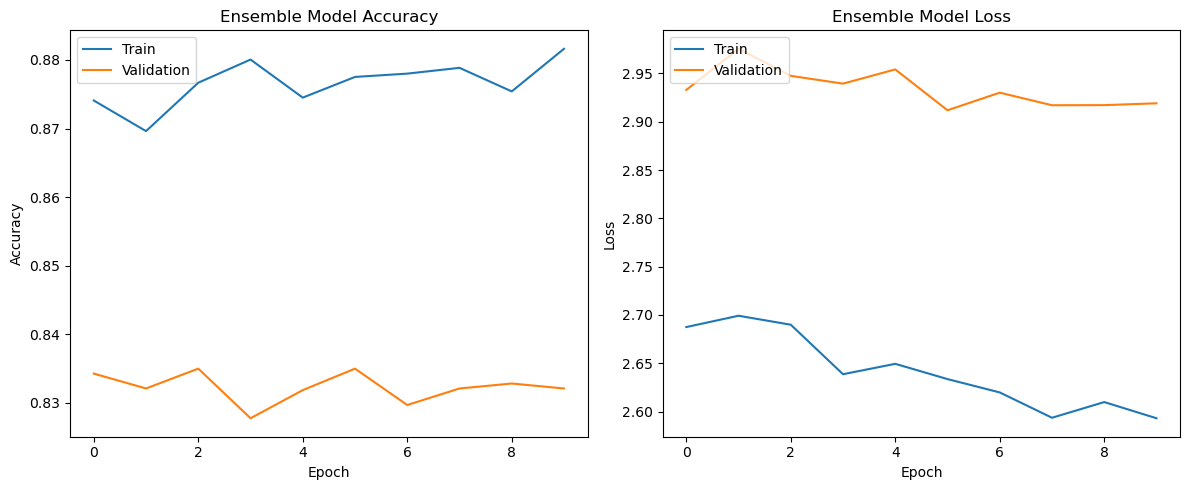

In [7]:
import matplotlib.pyplot as plt
def plot_ensemble_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Ensemble Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Ensemble Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the history for the ensemble
plot_ensemble_history(ensemble_history)
